In [60]:
import os
import re
import sys
import pandas as pd
import numpy as np

In [61]:
"""
 data_source should be plain text content.  Content will be parsed for sentences.
 This is NOT a csv file with classes.
"""
view_tokens=False
#data_source = 'data/fairy_tales_every_child_should_know_pg14916.txt'
data_source = 'data/medical_docs_content.txt'

# We're just creating the model_path here, we don't use it till next section.
model_path  = "models/{}".format(re.compile(r'\..*').sub('', os.path.basename(data_source)))


#open input file and tokenize
tokens = []
with open(data_source, 'r') as source:
    for line in source:
        line = re.sub(r'\W', ' ', line) 
        line_tokens = line.split( )
        line_tokens = [token.strip().lower() for token in line_tokens]
        tokens.append(line_tokens)

if (view_tokens):
    for idx in range(2):
        print tokens[idx]
print "DONE creating tokens, saved in variable 'tokens'"

DONE creating tokens, saved in variable 'tokens'


In [62]:
"""
 Source: Natural Language Processing in Action, Chapter 6
 Section: 6.5.2 Training domain specific word2vec model
 Section:
     Input: tokens, Tokenized data from previous step.
     Input: model_path, path where we will saved trained model from tokens
"""
from gensim.models import word2vec

model = word2vec.Word2Vec(
    tokens,              # Our array of sentences, each of which is an array of words.
    min_count=3,         # Min number of word count to be considered
    workers=4,           # Number of threads in parallel. (cores on laptop)
    size=300,            # The number of weights in hidden layer, (length of word verctors)
    window=6,            # Context window size
    sample=1e-3          # subsampling rate for frequent terms
)

# Save disk space by saving only hidden neurons.  (We lose output weights)
model.init_sims(replace=True)

model.save(model_path)

print "DONE"

DONE


In [63]:
import pandas as pd
from gensim.models import KeyedVectors
from gensim.models import word2vec
model = word2vec.Word2Vec.load(model_path)
results = model.most_similar(positive=['medical'], negative=[], topn=20)
print results
data = pd.DataFrame(results)
# print data[0]

word_vectors = KeyedVectors.load(model_path)
# print model.similar_by_vector(word_vectors['care'], topn=2)


[('collector', 0.7817988991737366), ('electronic', 0.7626649737358093), ('dispense', 0.7485814094543457), ('billing', 0.7467023730278015), ('practice', 0.7442421913146973), ('gyn', 0.7429088354110718), ('clerk', 0.7185249924659729), ('pediatric', 0.7171906232833862), ('almost', 0.7142488956451416), ('nurse', 0.708174467086792), ('using', 0.7045856714248657), ('charting', 0.6911250352859497), ('terminology', 0.6902320981025696), ('tableau', 0.6885441541671753), ('peri', 0.6871689558029175), ('65', 0.6865479350090027), ('anziolite', 0.6861138939857483), ('emr', 0.6846336126327515), ('leaving', 0.672439694404602), ('registered', 0.6704121828079224)]


In [64]:
"""
This section creates the semantic map from the hidden layer vectors.
	1. Open a pretrained vector set 'data_for_classification_model'
	2. collect all vectors into one single 2d numpy array
	3. pass 2d array to minisom and train a map
	4. Save the map to som_map
    
    Inputs:
    model_path, was set previously pointing to the model trained from raw text
    Outputs:
    vectors_path
    weights_path
    
"""
from ptpython.repl import embed
from minisom import MiniSom
from gensim.models import KeyedVectors
from gensim.models import word2vec
import numpy as np 

#INPUTS
b_collect_new_vectors = True  # if retrain the model
b_save_new_som_weights = False  # we want dots stay in the same location every i
#OUTPUTS
vectors_path = 'models/vectors_array'
weights_path = 'models/som_weights_3'
# TRAINING INPUTS
_sigma = 5
_learning_rate = 0.8
_train_iterations = 200
#ENDINPUTS


print "Loading model {}".format(model_path)
word_vectors = KeyedVectors.load(model_path)
print word_vectors
model = word2vec.Word2Vec.load(model_path)

if (b_collect_new_vectors):
    print "Saving 2d numpy array from word_vectors to {}".format(vectors_path)
    varrs = np.array([word_vectors[word] for word in word_vectors.wv.vocab.keys()])
    np.save(vectors_path, varrs)
else:
    print "Loading {}.py word vectors from disk".format(vectors_path)
    varrs = np.load("{}.npy".format(vectors_path))

print varrs.shape
som = MiniSom(x=128, y=128, input_len=300, sigma=_sigma, learning_rate=_learning_rate)
som.random_weights_init(varrs)
if (b_save_new_som_weights):
    print "Training:"
    print "sigma:", _sigma, "learning_rate:", _learning_rate, "train_iterations:",_train_iterations
    som.train_random(varrs, _train_iterations) # random training

    print "Saving {}".format(weights_path)
    np.save(weights_path, som.weights)


            
print "DONE"

Loading model models/medical_docs_content
Word2Vec(vocab=6994, size=300, alpha=0.025)
Saving 2d numpy array from word_vectors to models/vectors_array
(6994, 300)
DONE


In [ ]:
"""DON'T RUN THIS CELL IF YOU ALREADY GOT THE WORD RETINA CSV FILE, IT WILL RELOAD RETINA FOR EACH WORD AGAIN """
# get fingerprints for each word.

import csv

def import_from_data_file(unique_id):
    with open(data_source, 'r') as source:
        csvfile = csv.reader(source)
        for line in csvfile:
            binary = line[6]
            if unique_id == line[0].strip():
                row_els = [word.lower().strip() for word in line[8].split(' ')]
                return binary, row_els
            else:
                continue
    print "URL NOT FOUND IN SOURCE FILE"
    return 0, []

import matplotlib.pyplot as plt

%matplotlib inline

data_source = 'data/medical_docs_with_id.csv'
weights_path = 'models/som_weights_3'
print "Loading weights"
som.weights = np.load("{}.npy".format(weights_path))

# retinas mapping words to index
words_dict = {}

print "Importing from data file"
for s in range(2119):  # since the data file only has 2118 records
    unique_id = str(s)
    print unique_id
    binary, words = import_from_data_file(unique_id)
    arr = []
    for word in words:
        try:
            x, y = som.winner(word_vectors[word])
#             print 'words in docs', word
            results = model.most_similar(positive=[word], negative=[], topn=30)  # get related words
            data = pd.DataFrame(results)
            if word not in words_dict:
                words_dict[word] = []
            if [x, y] not in words_dict[word]:
                words_dict[word].append(x)
                words_dict[word].append(y)
            for w in data[0]:
#                 print w
                w_x, w_y = som.winner(word_vectors[w])
#                 print w_x, w_y
                words_dict[word].append(w_x)
                words_dict[word].append(w_y)
            
        except:
            pass


# save word fingerprint to file:
word_fingerprints = 'data/word_fingerprints.csv'
fw = open(word_fingerprints, 'w')
for wd in words_dict.keys():
    fw.write("{},{}\n".format(wd, words_dict[wd]))
fw.close()
    

plot retinas for every word
finger prints without threshold
265
['we', 'are', 'a', 'medium', 'sized', 'medical', 'specialty', 'office', 'with', 'seven', 'full', 'time', 'gastroenterologists.', 'we', 'are', 'currently', 'seeking', 'an', 'lpn', 'for', 'our', 'harbour', 'view', 'endoscopy', 'unit.', 'the', 'candidate', 'we', 'are', 'seeking', 'should', 'be', 'professional,', 'have', 'a', 'strong', 'teamwork', 'ethic', 'and', 'good', 'communication', 'with', 'their', 'coworkers.', 'primary', 'responsibilities', 'include,', 'but', 'are', 'not', 'limited', 'to:', 'daily', 'patient', 'care', 'within', 'the', 'unit,', 'result', 'tasks,', 'scheduling', 'follow', 'up', 'and', 'outpatient', 'exams', 'as', 'needed', 'and', 'documenting', 'within', 'gmed', 'ehr.', 'must', 'be', 'able', 'to', 'work', '5', 'days', 'a', 'week,', '40', 'hours', 'a', 'week.', 'additional', 'responsibilities', 'as', 'requested', 'by', 'the', 'charge', 'nurse,', 'administrator', 'and', 'physicians.', 'experience', 'requir

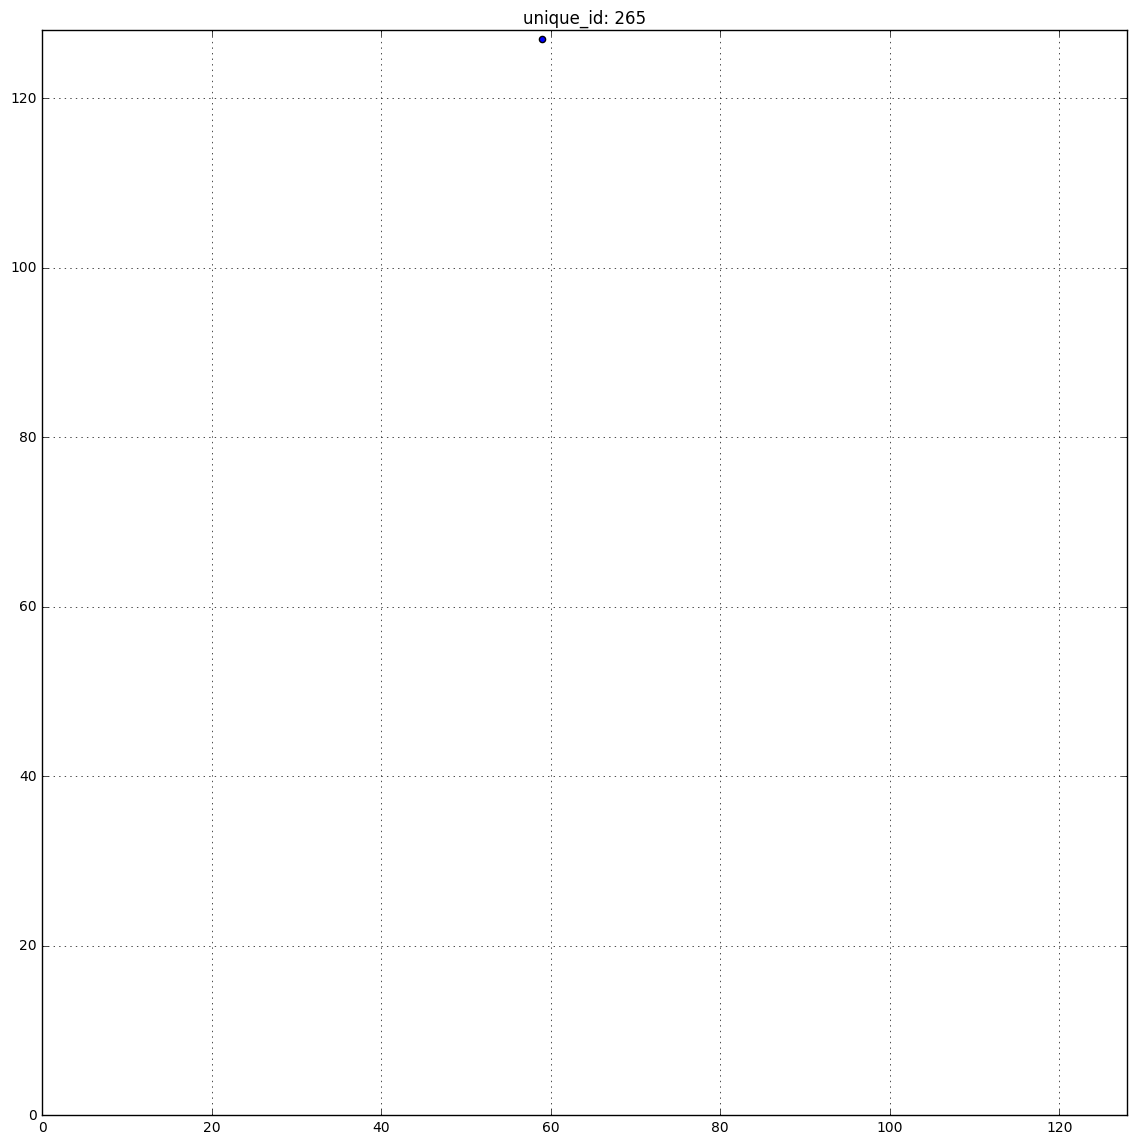

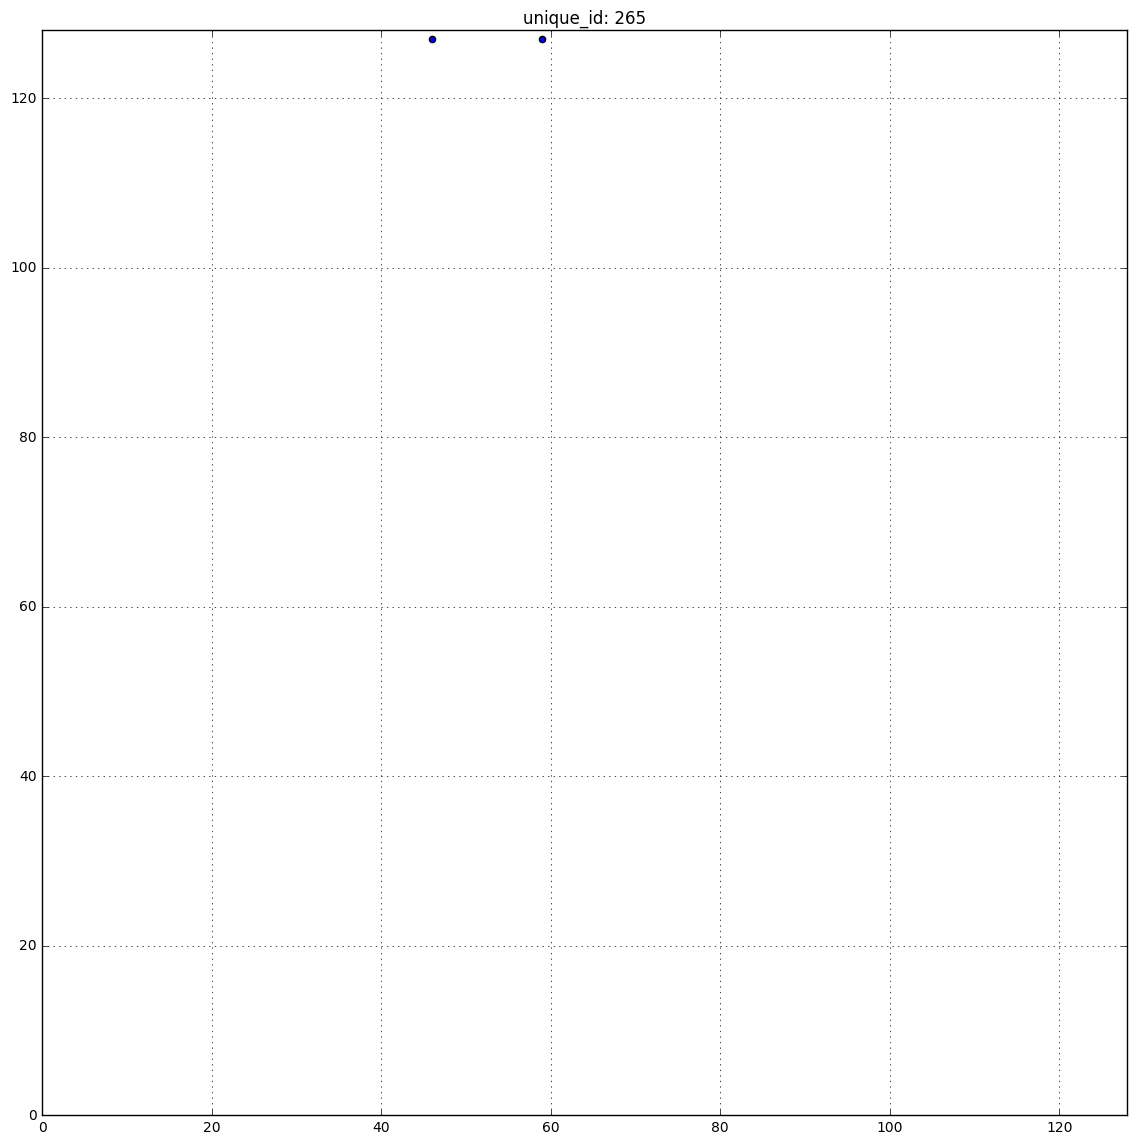

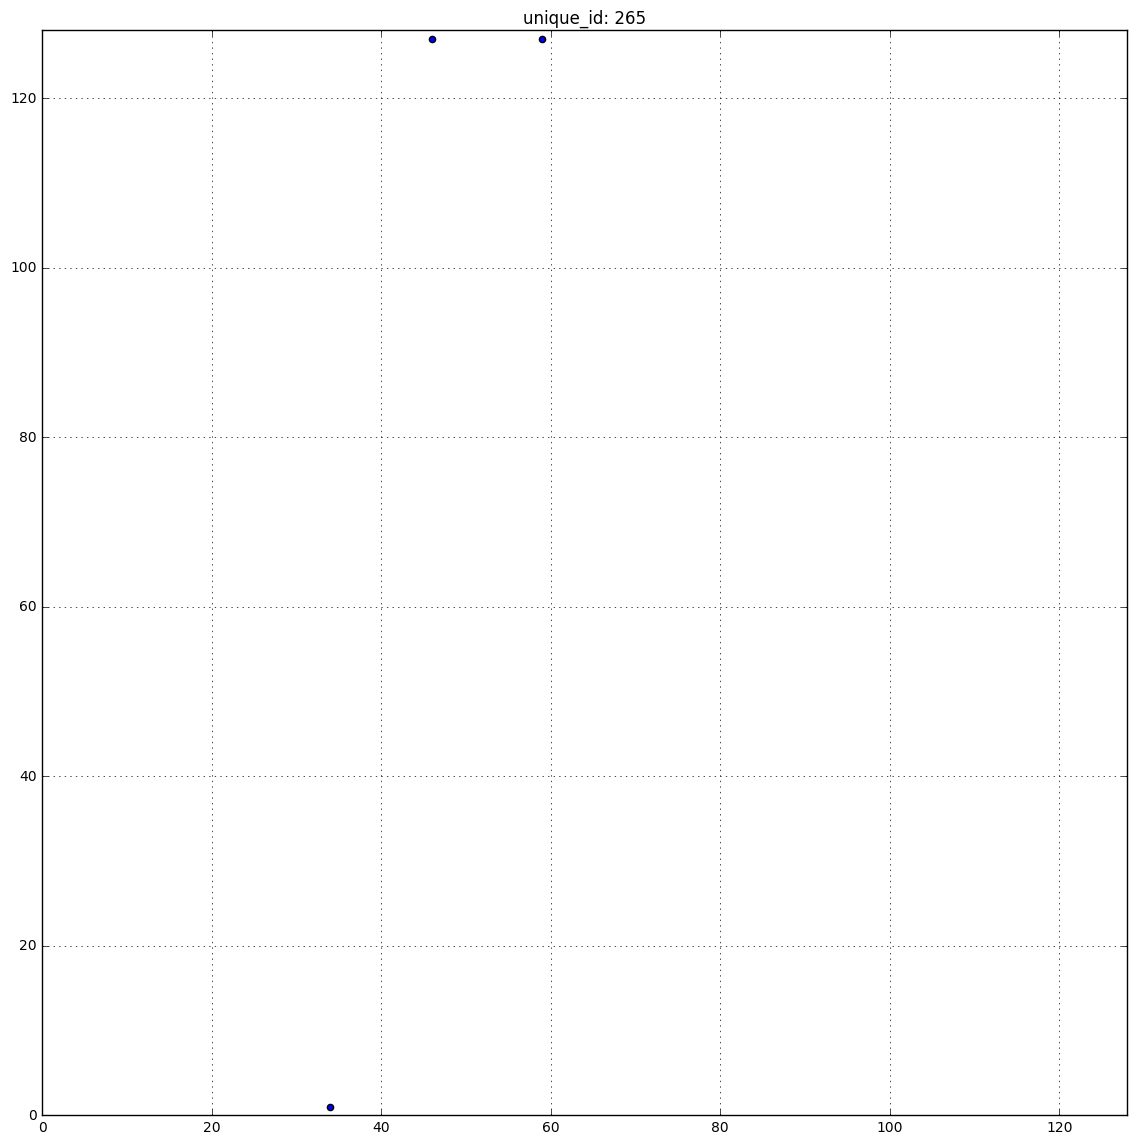

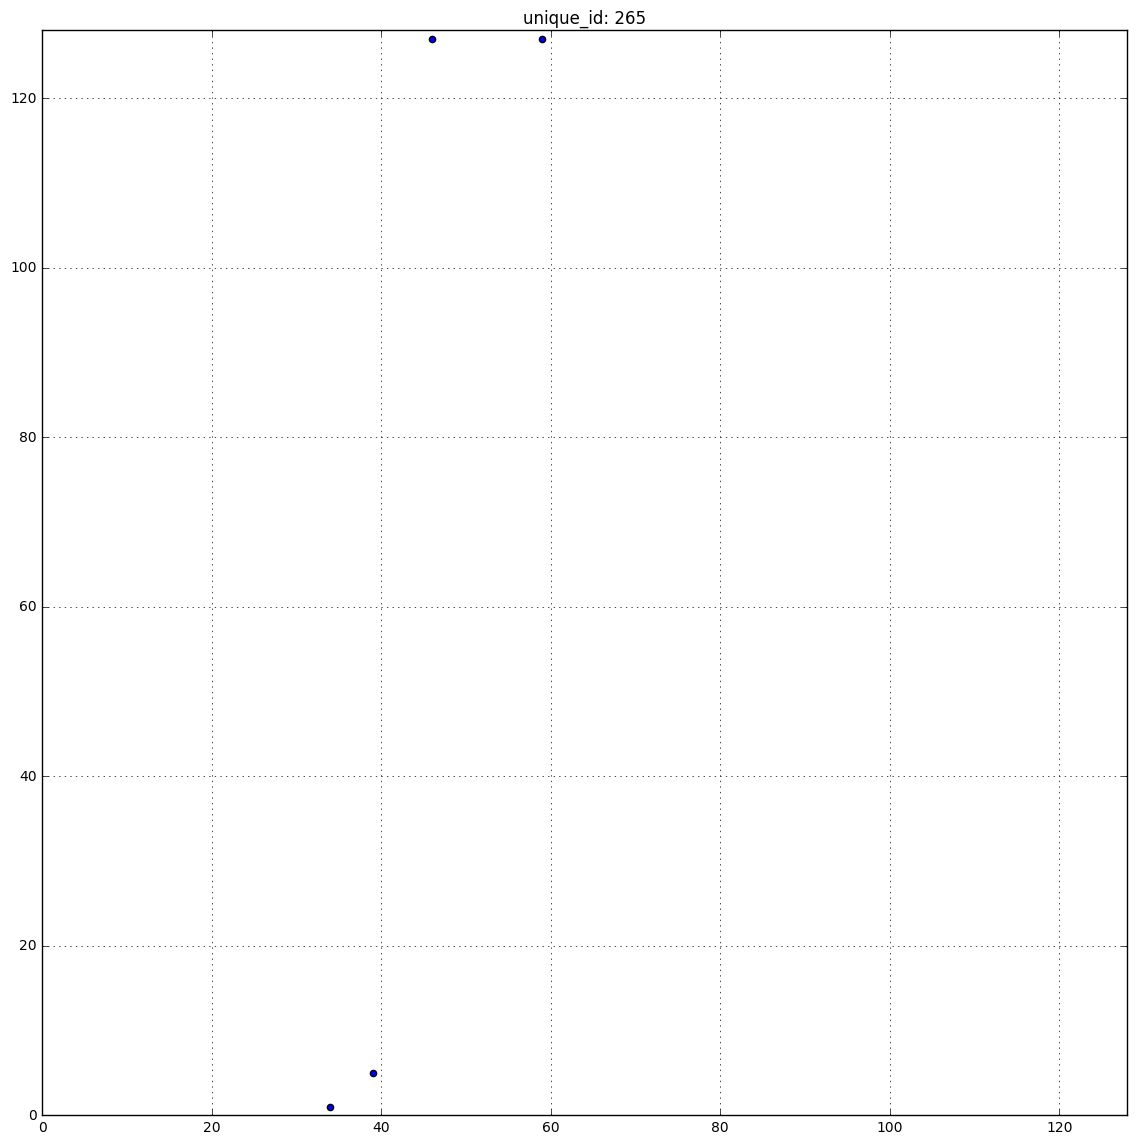

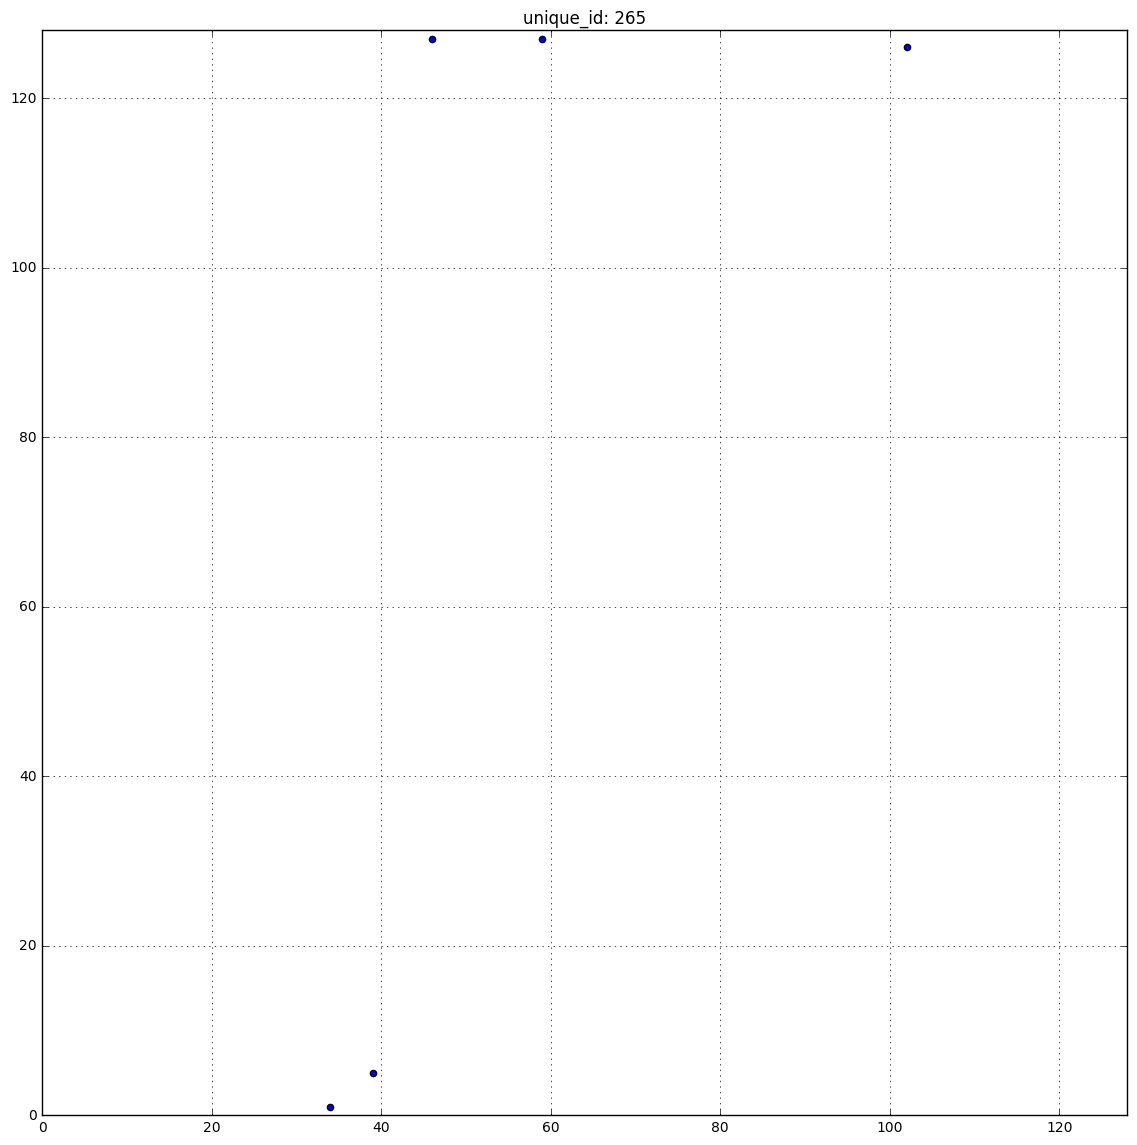

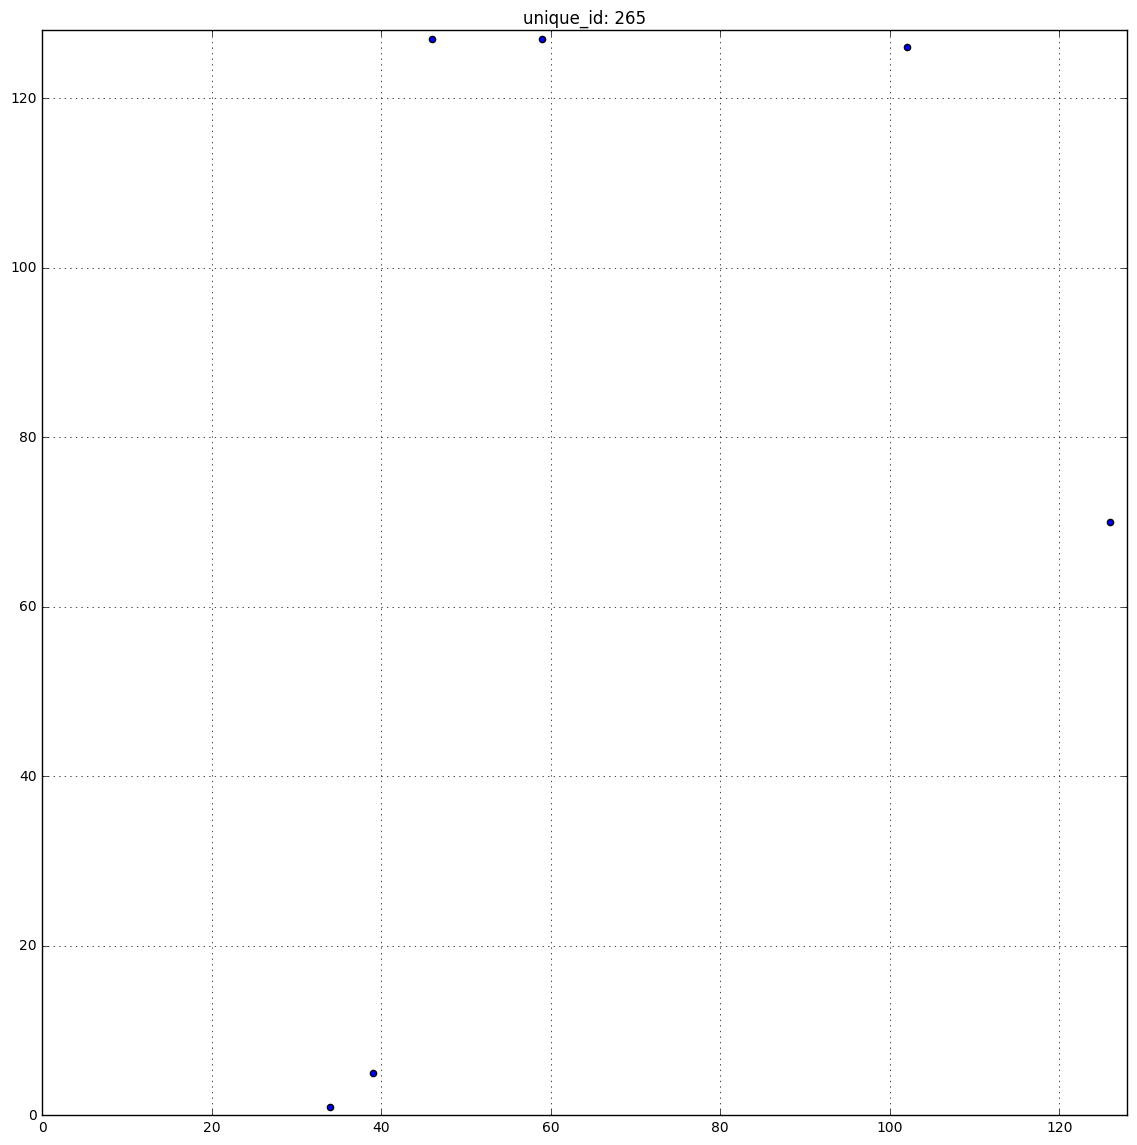

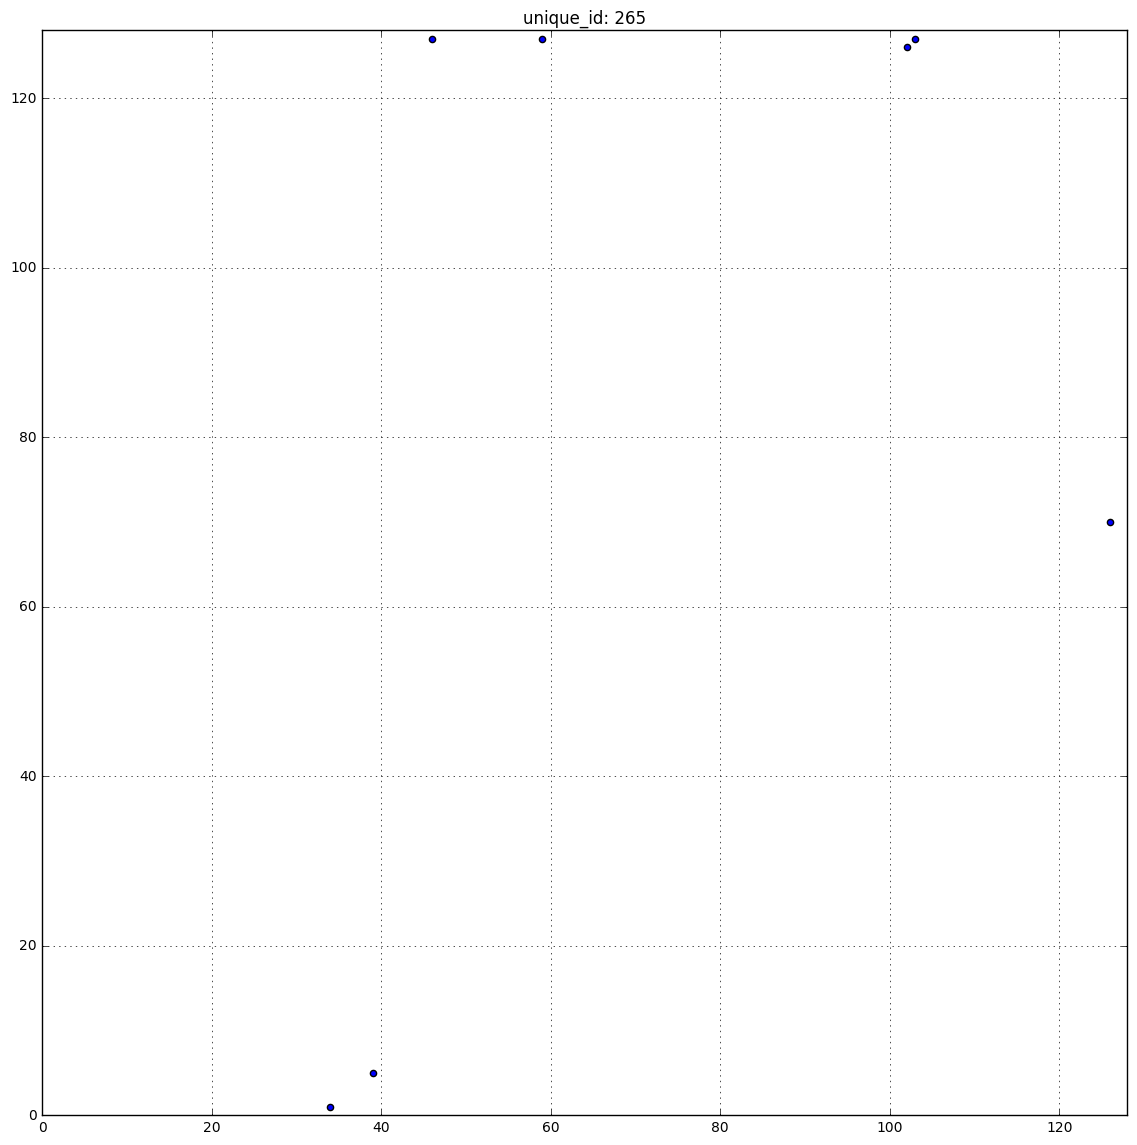

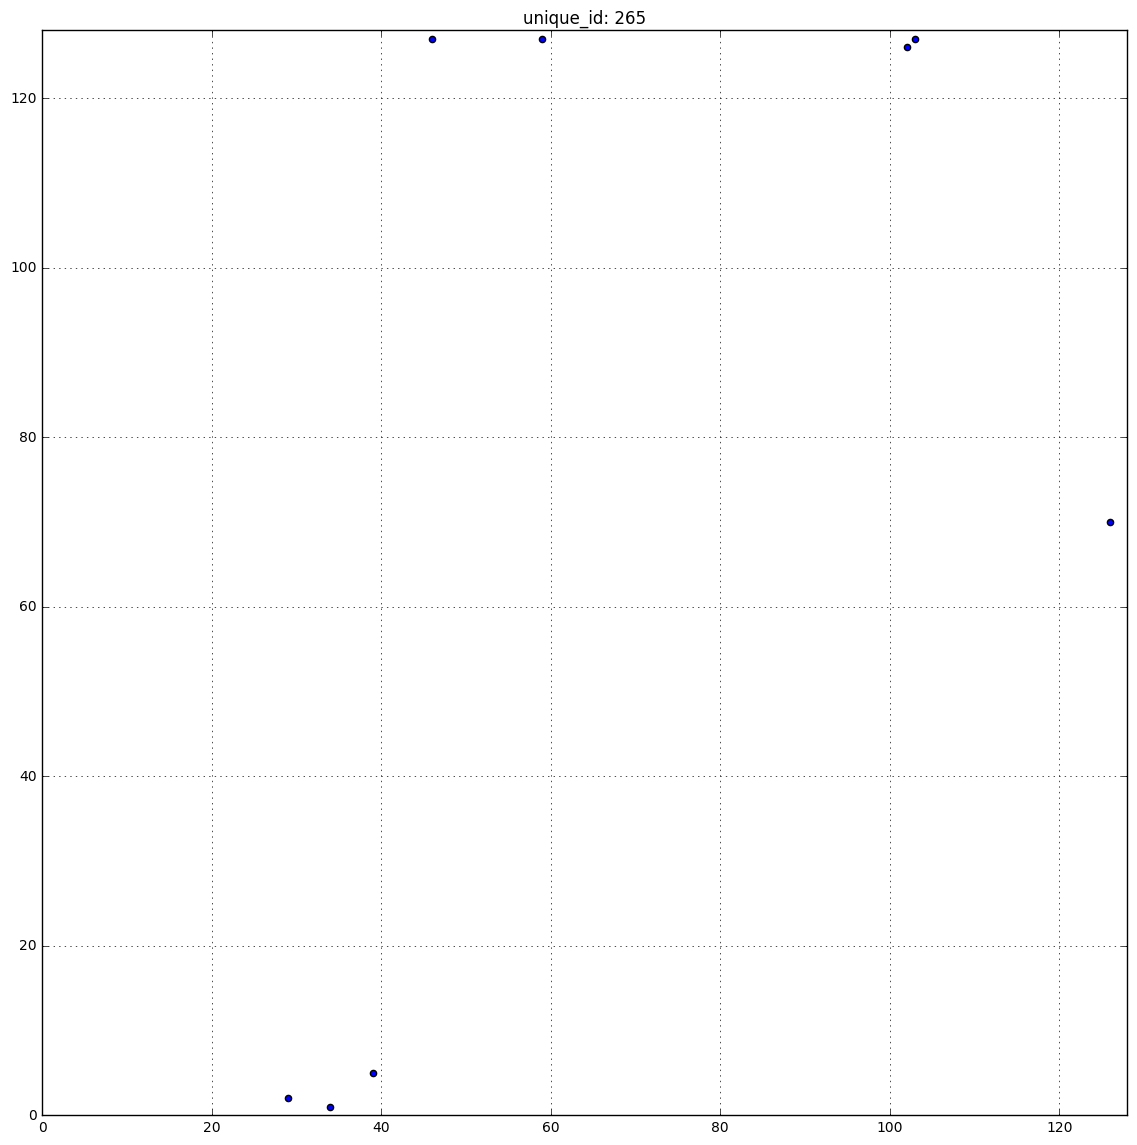

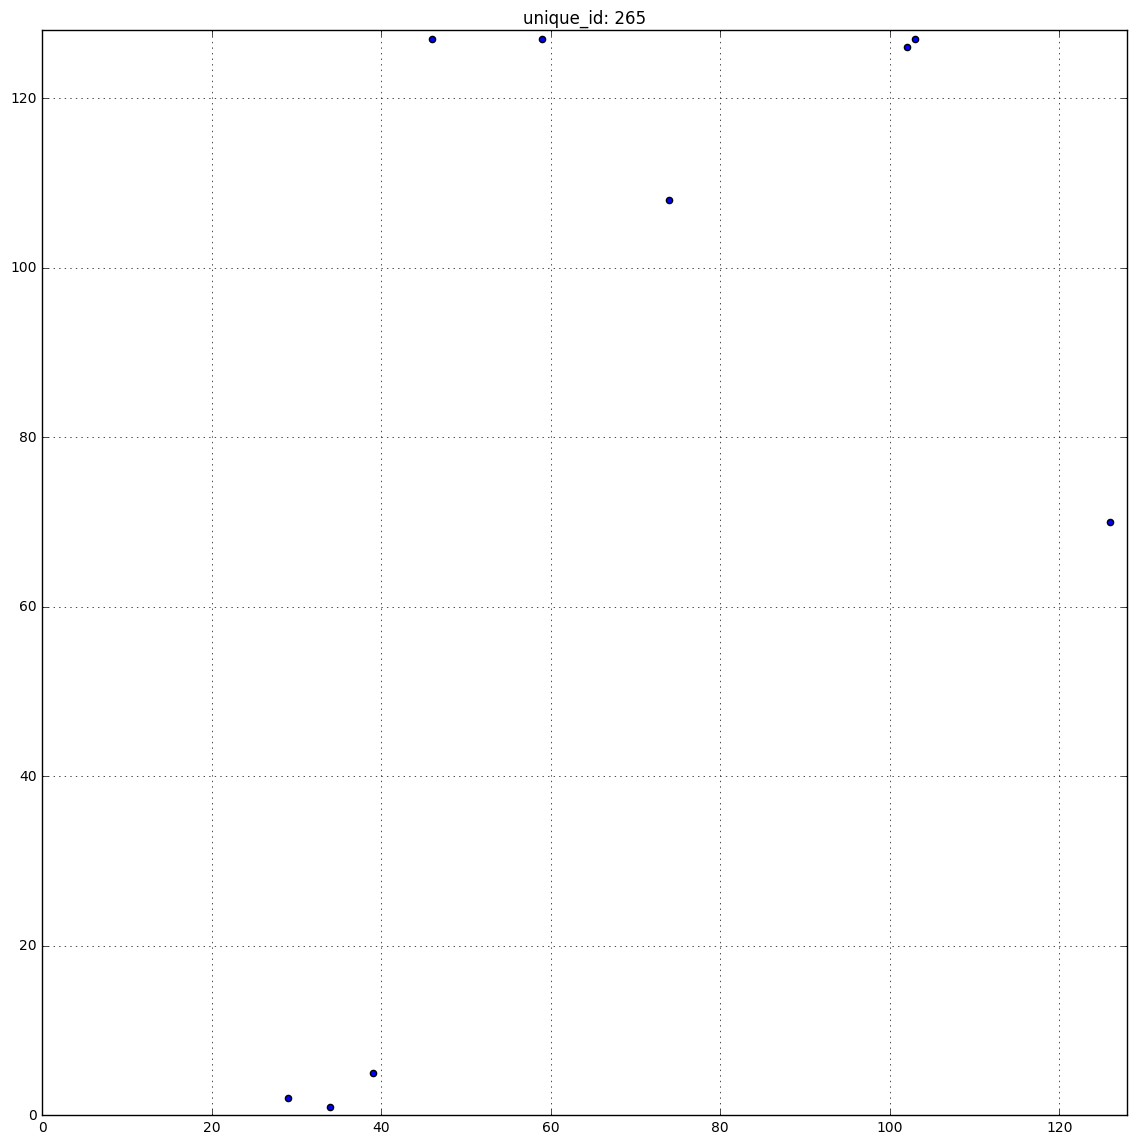

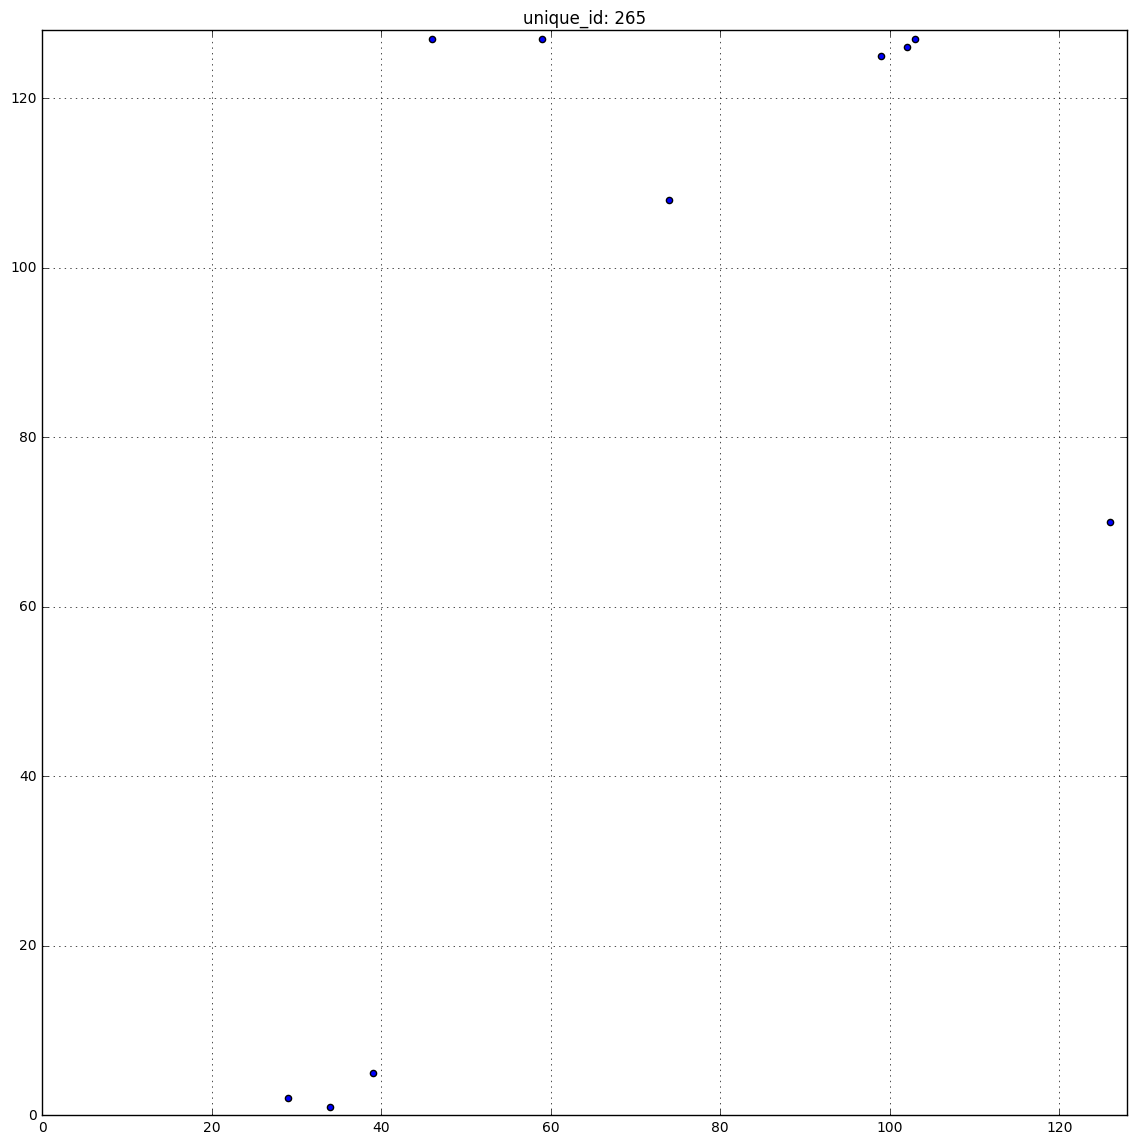

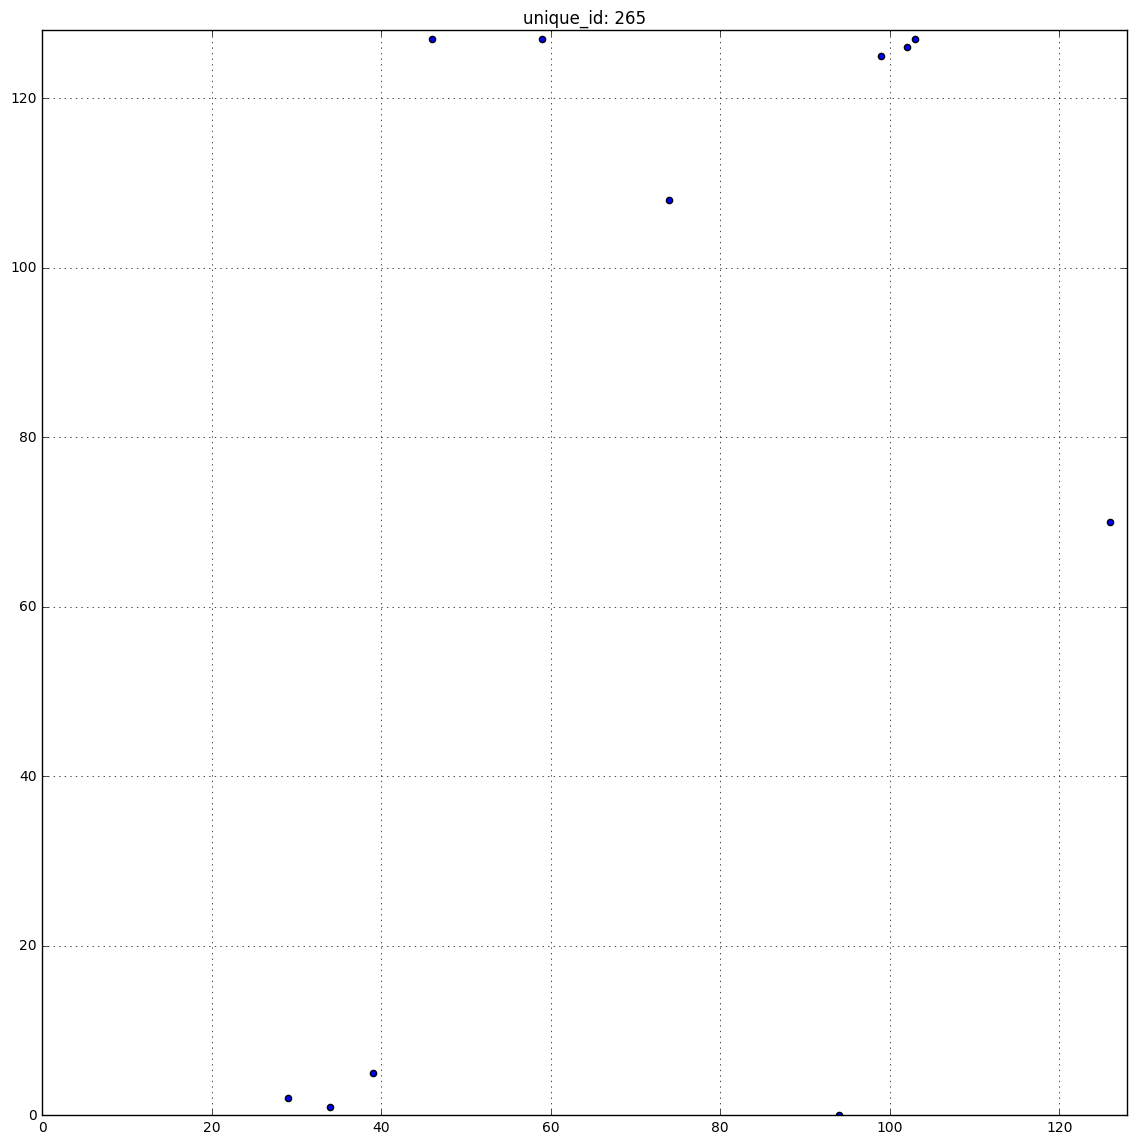

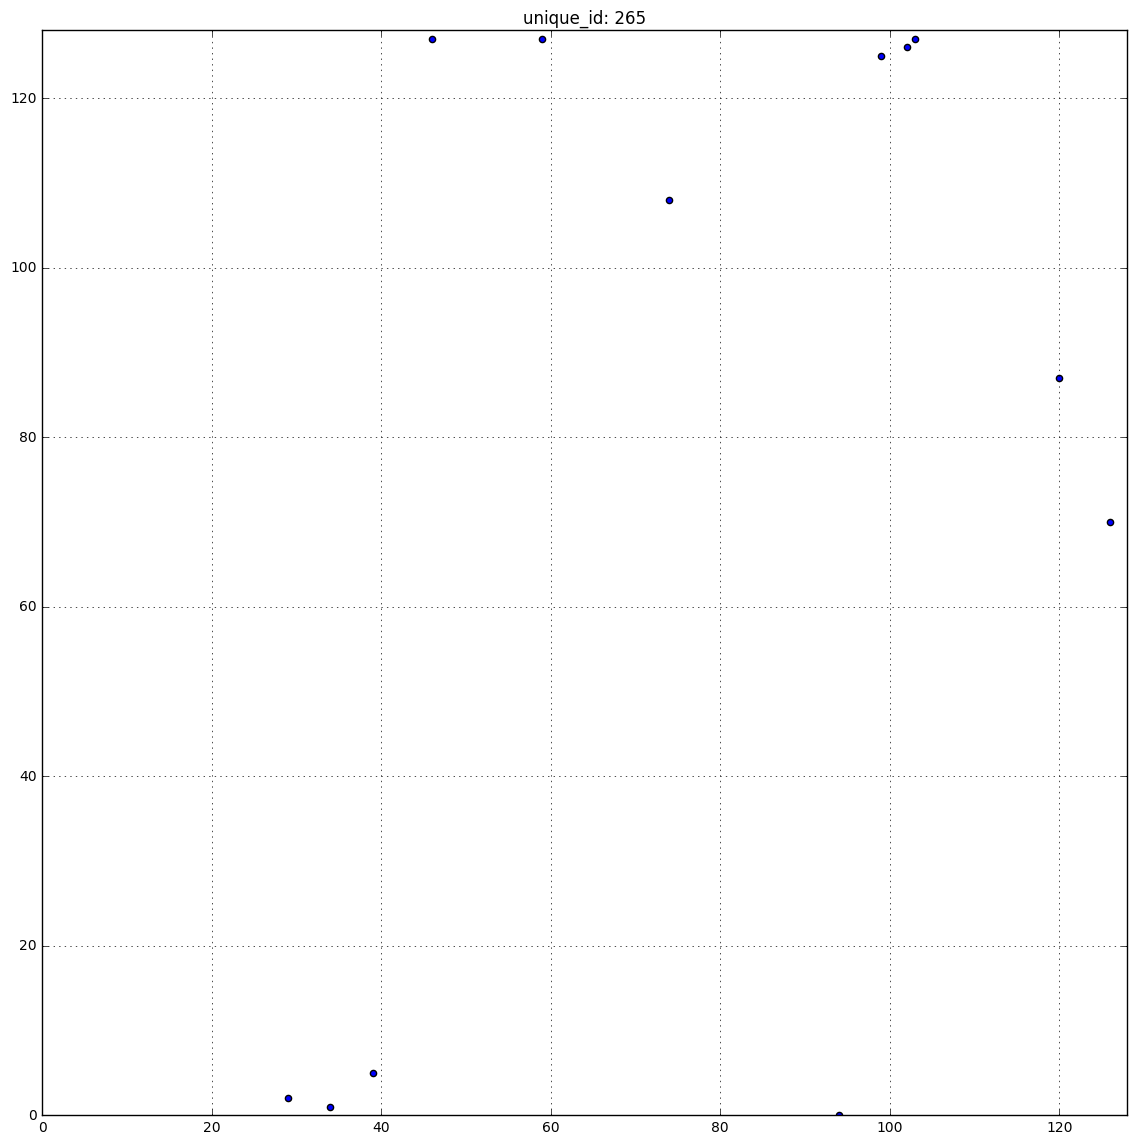

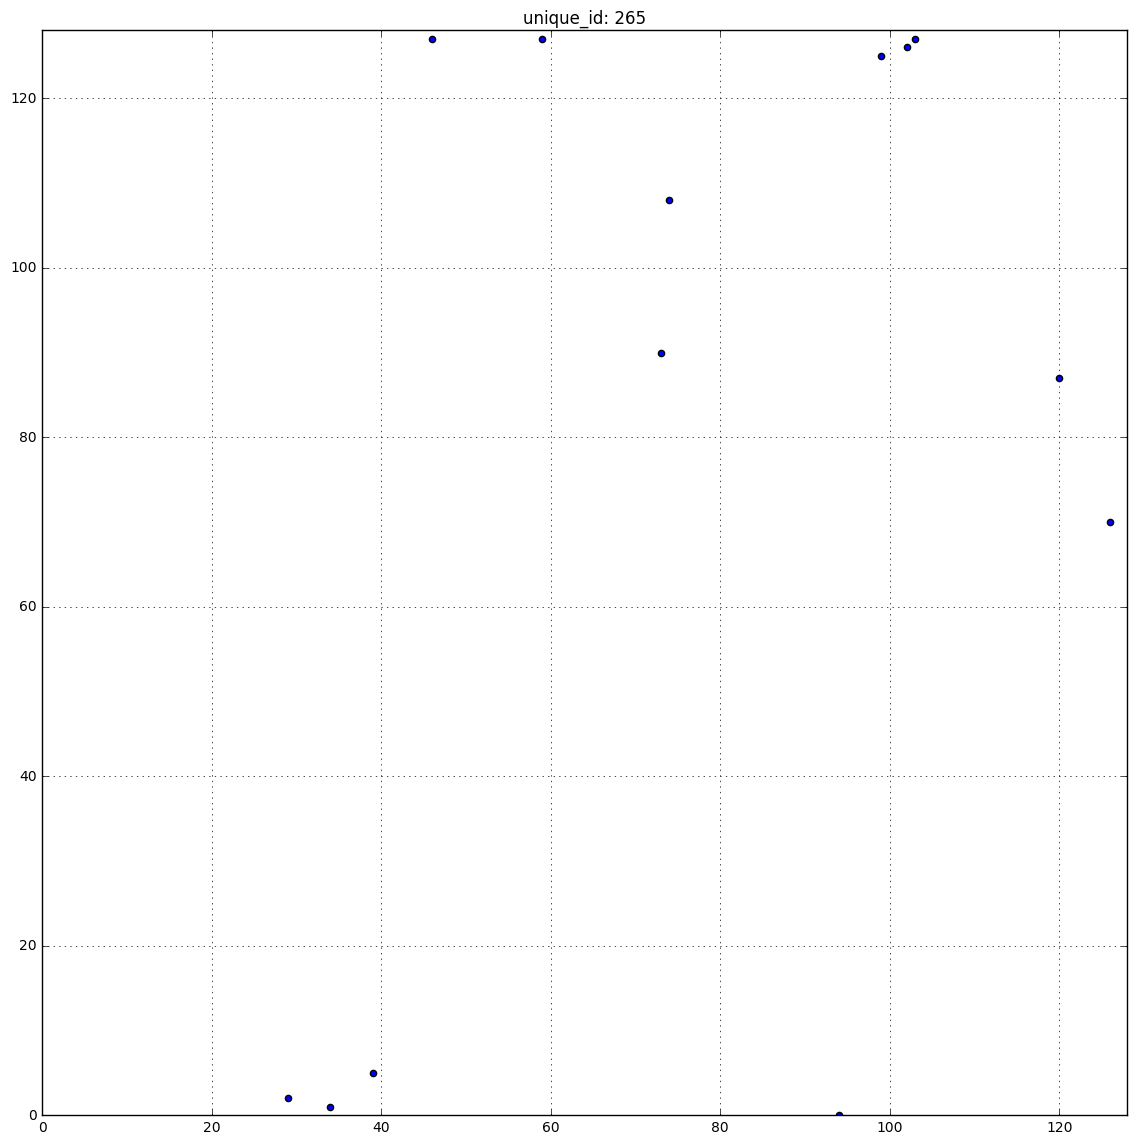

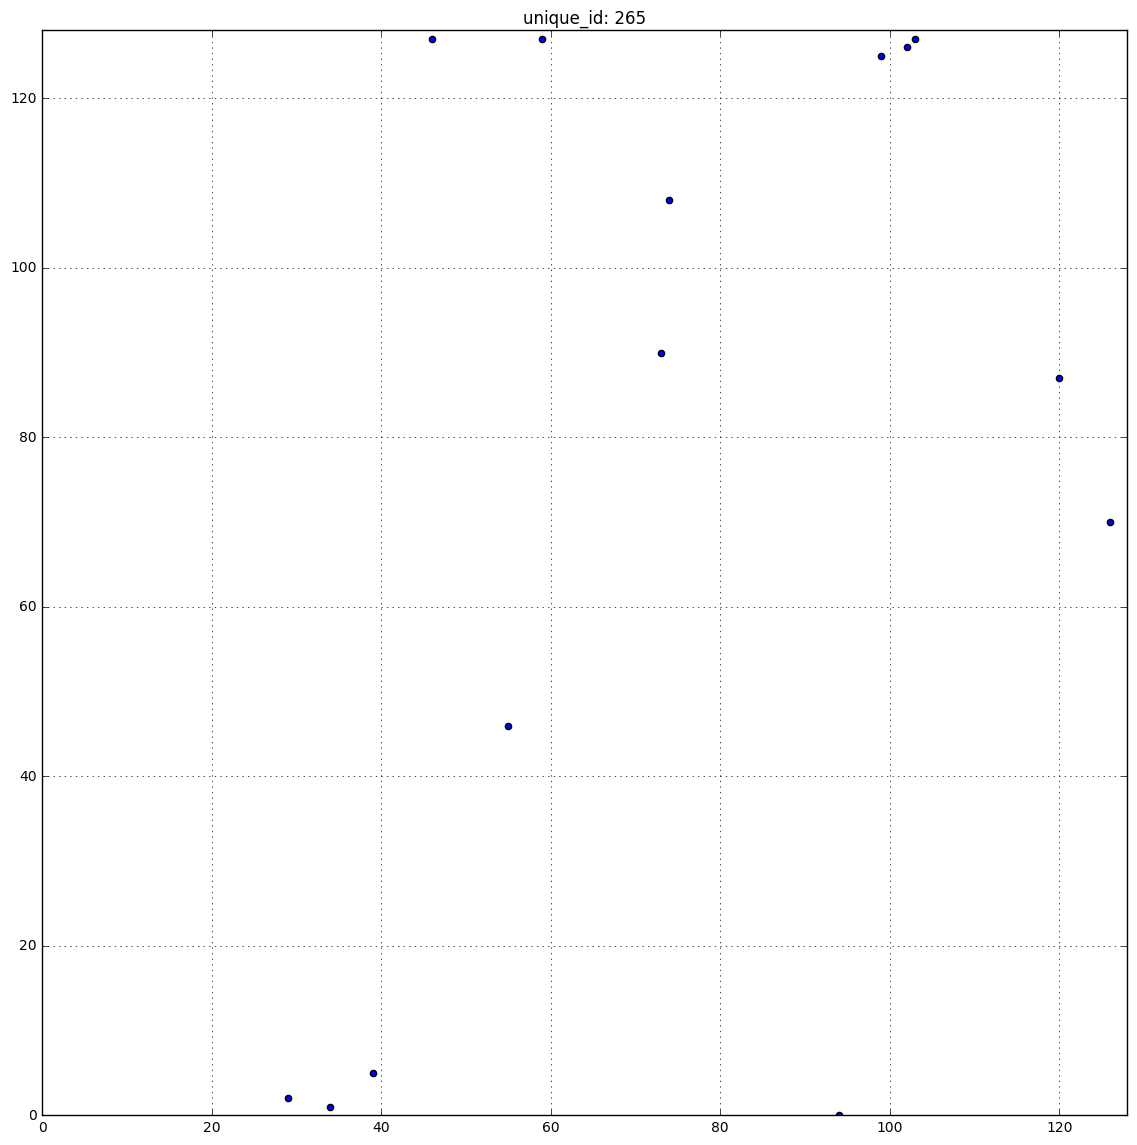

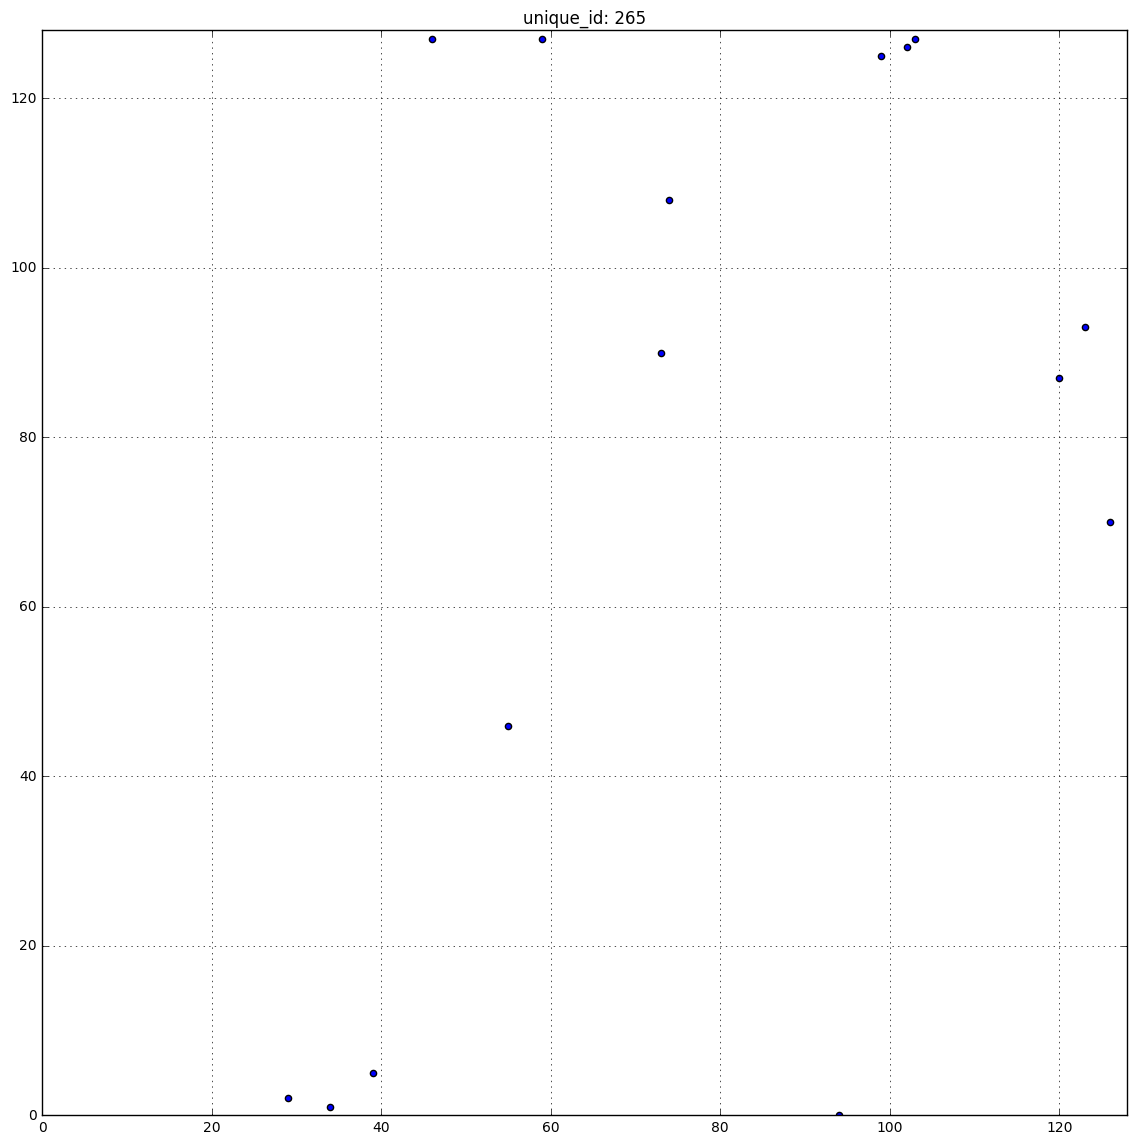

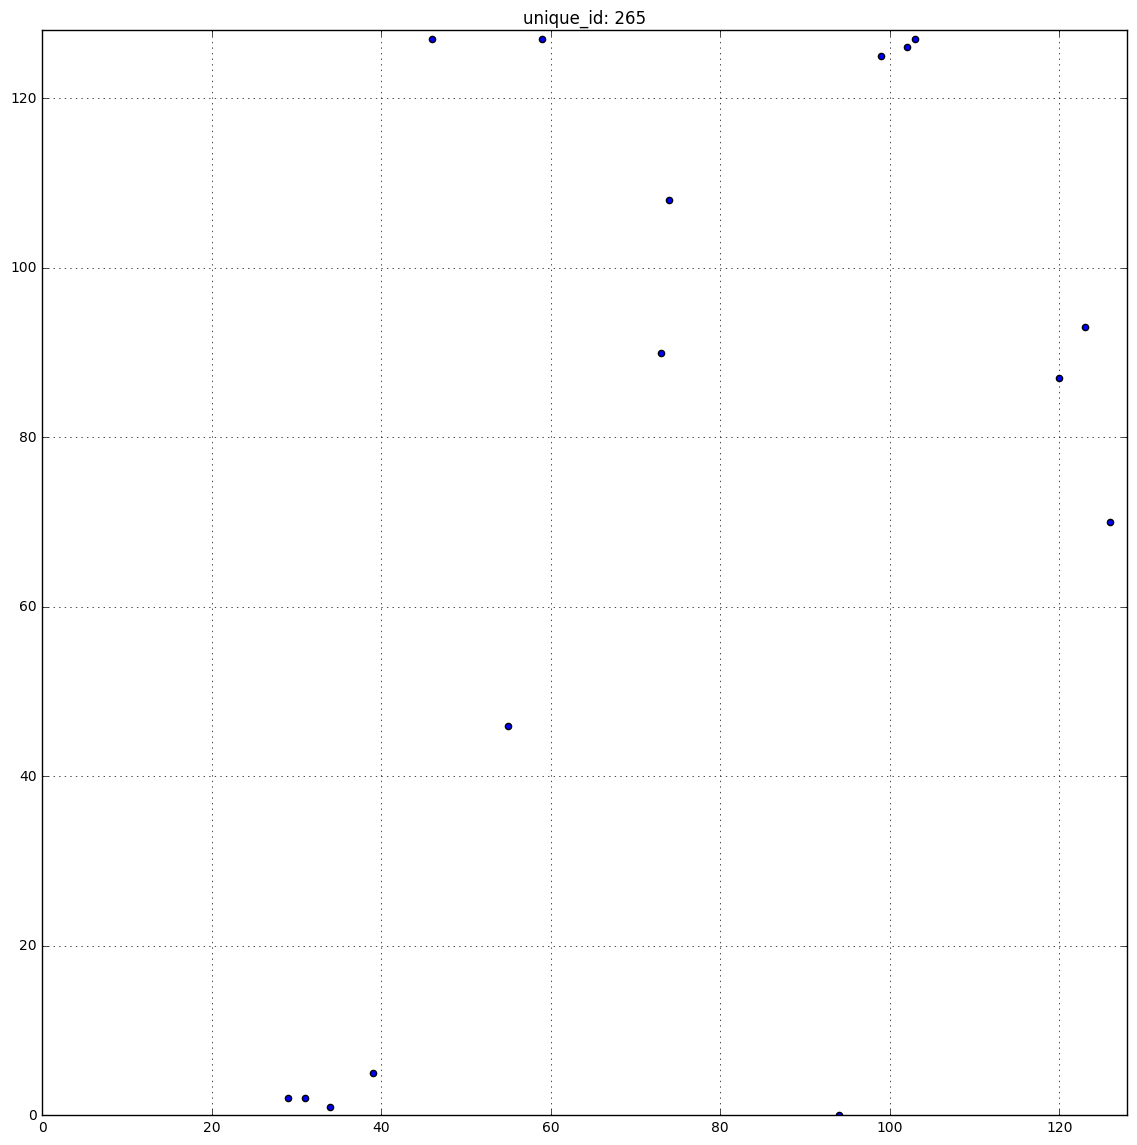

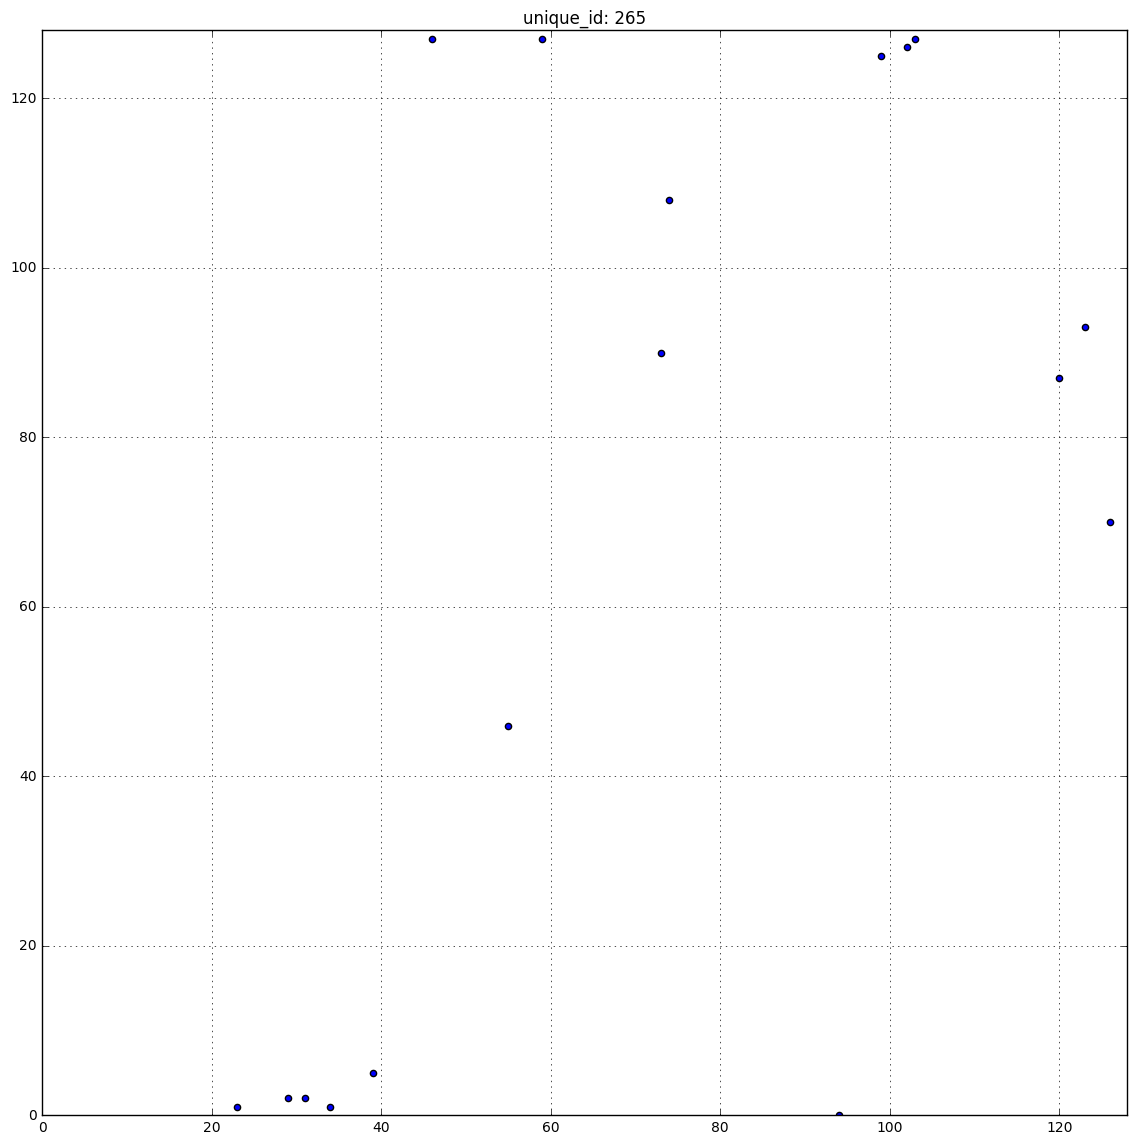

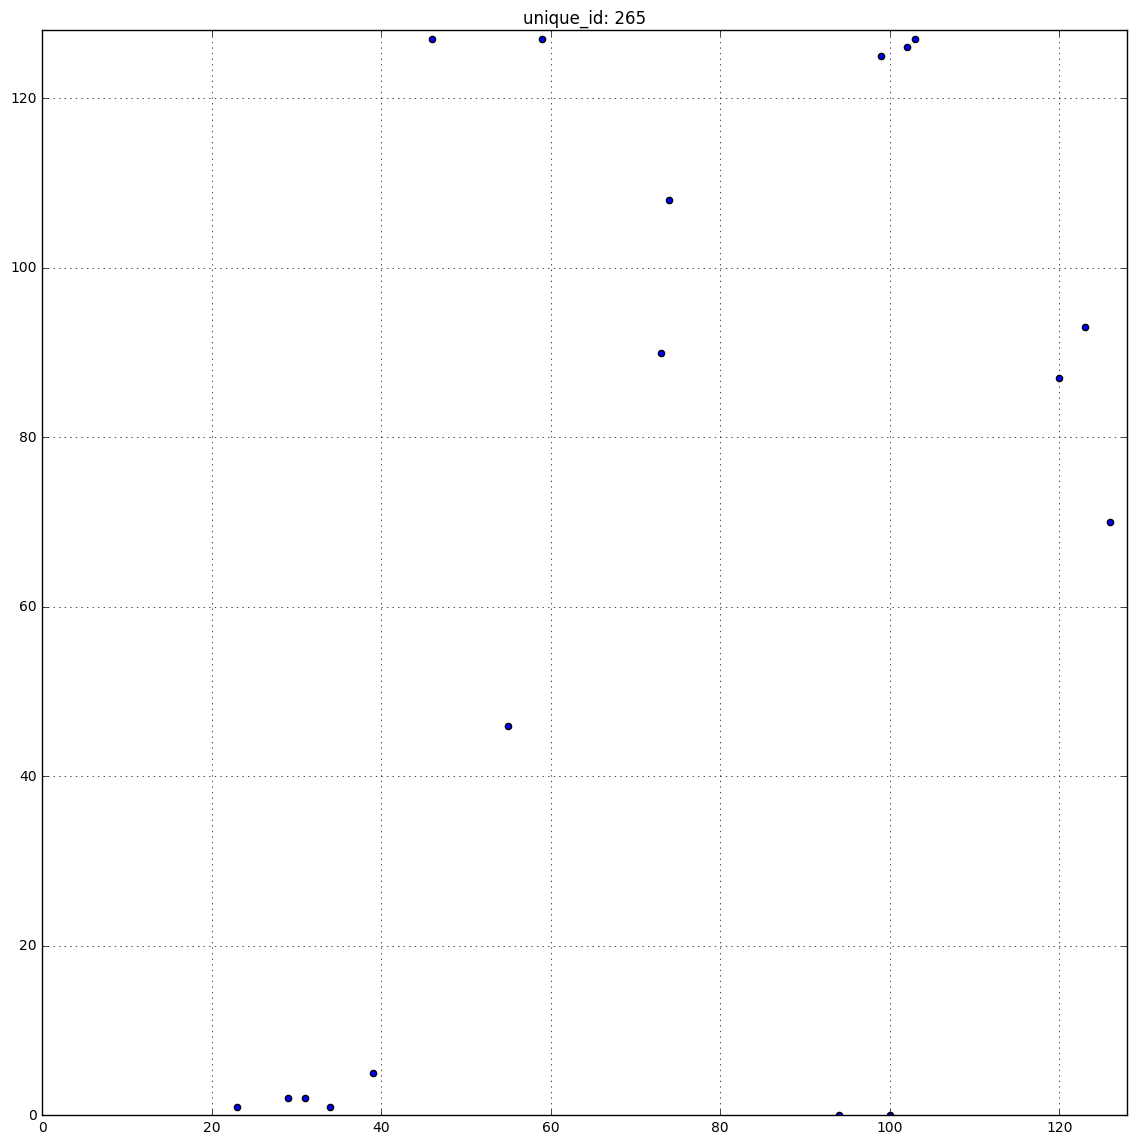

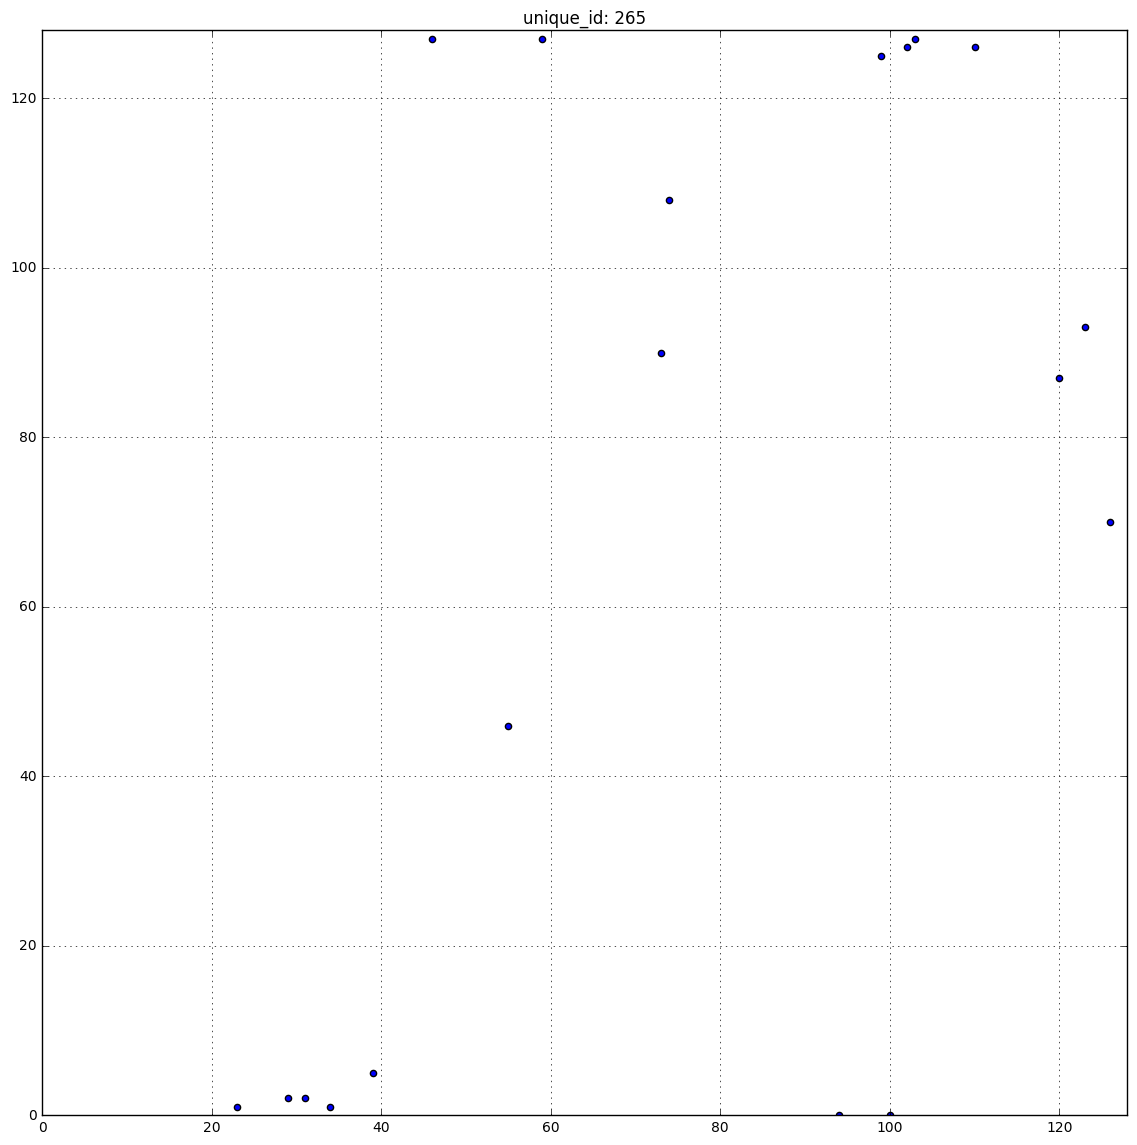

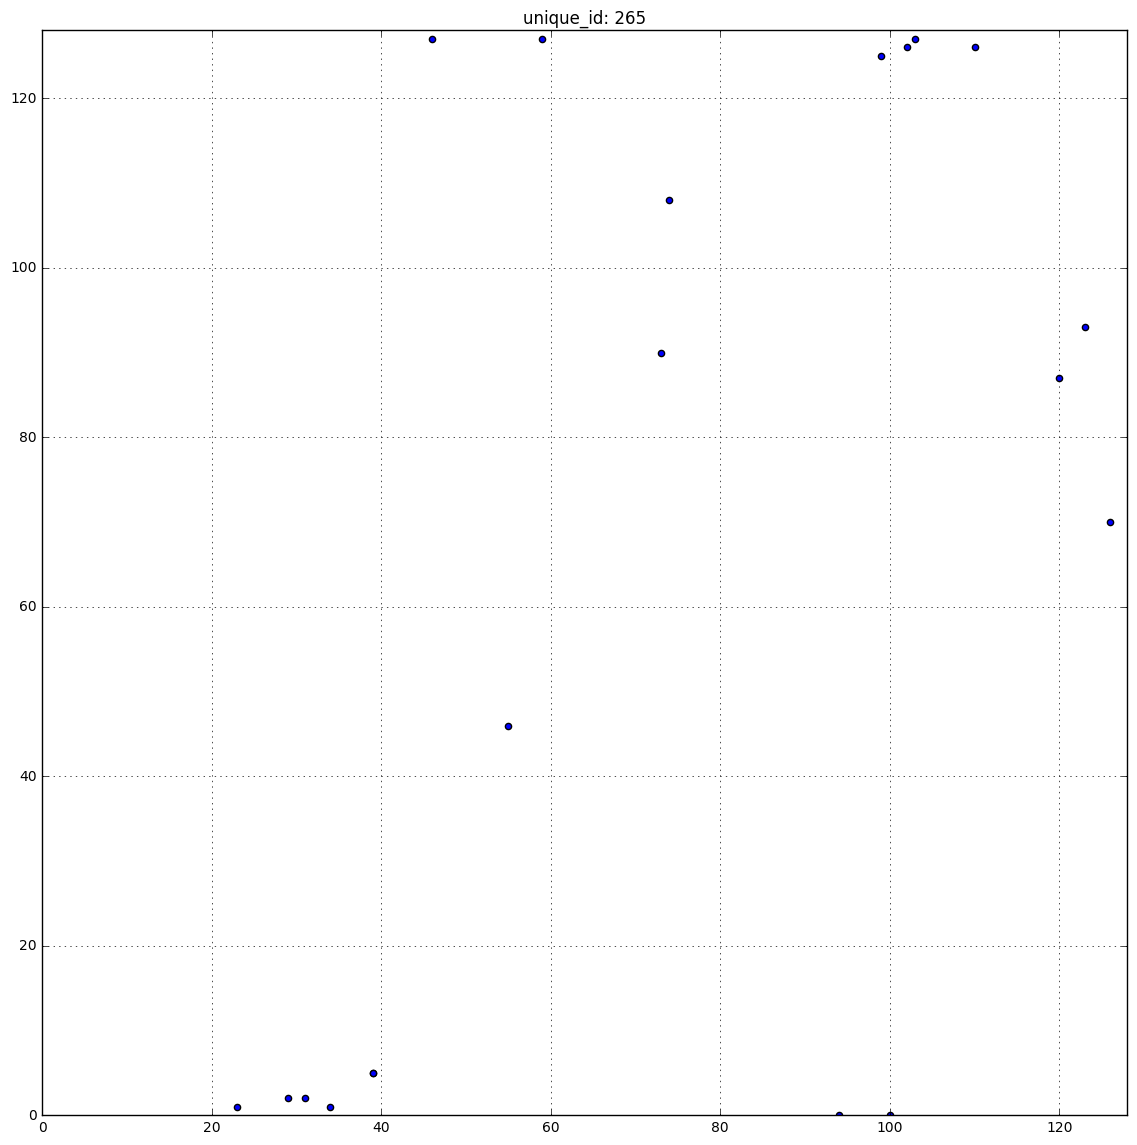

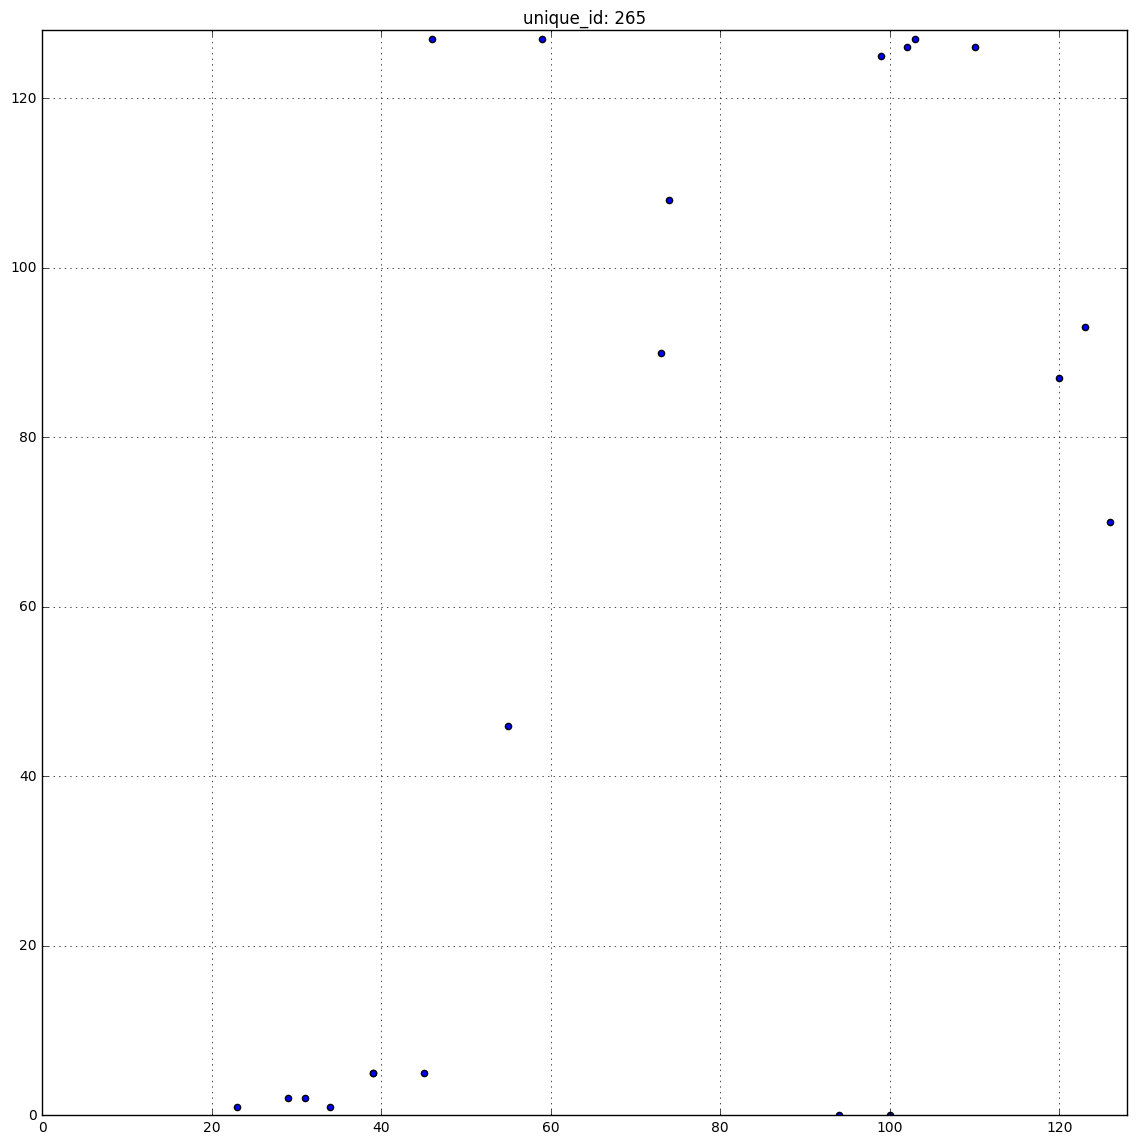

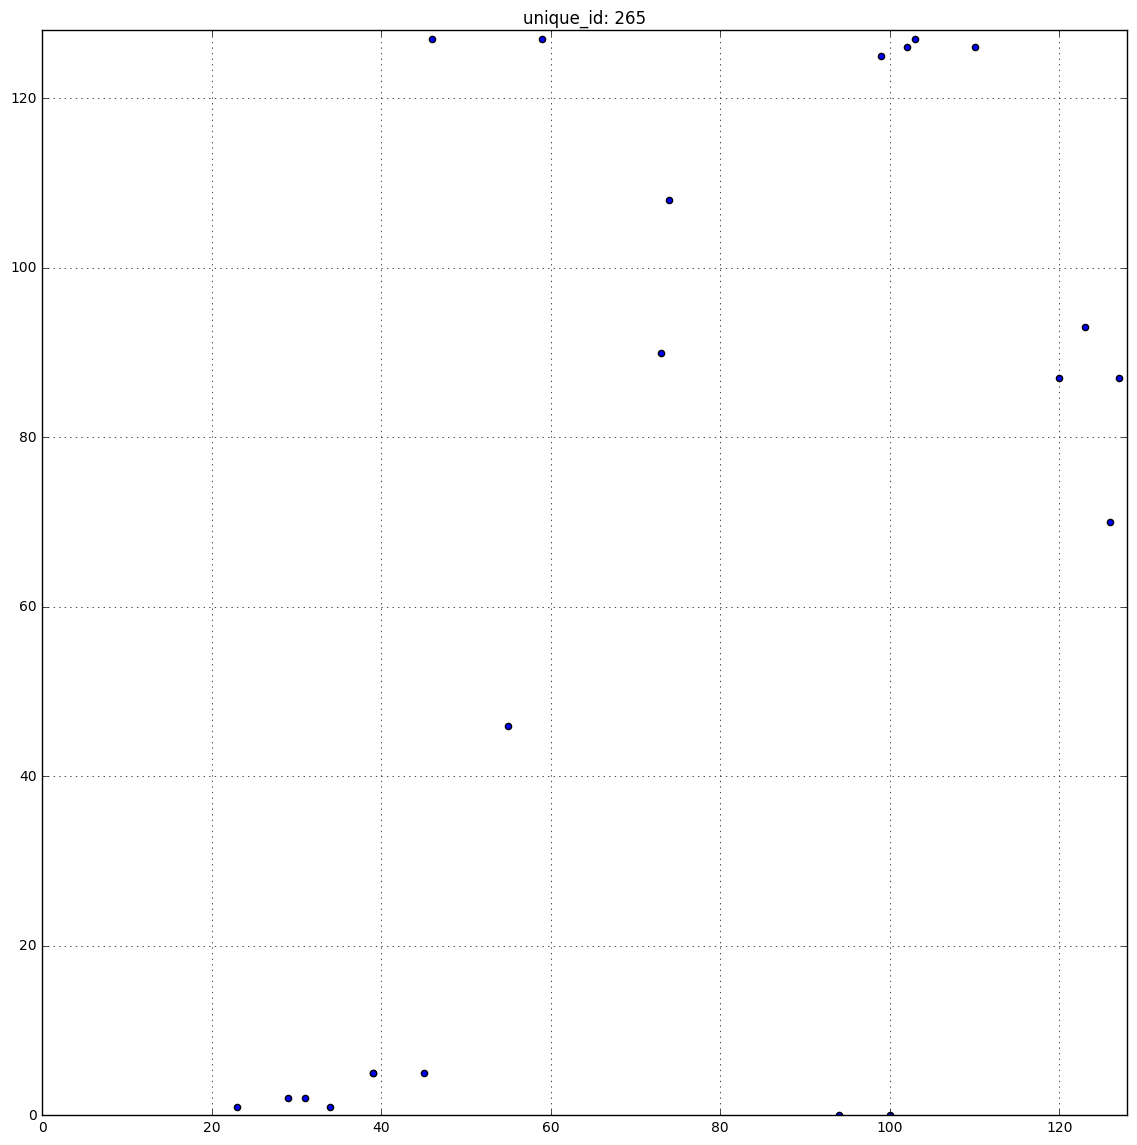

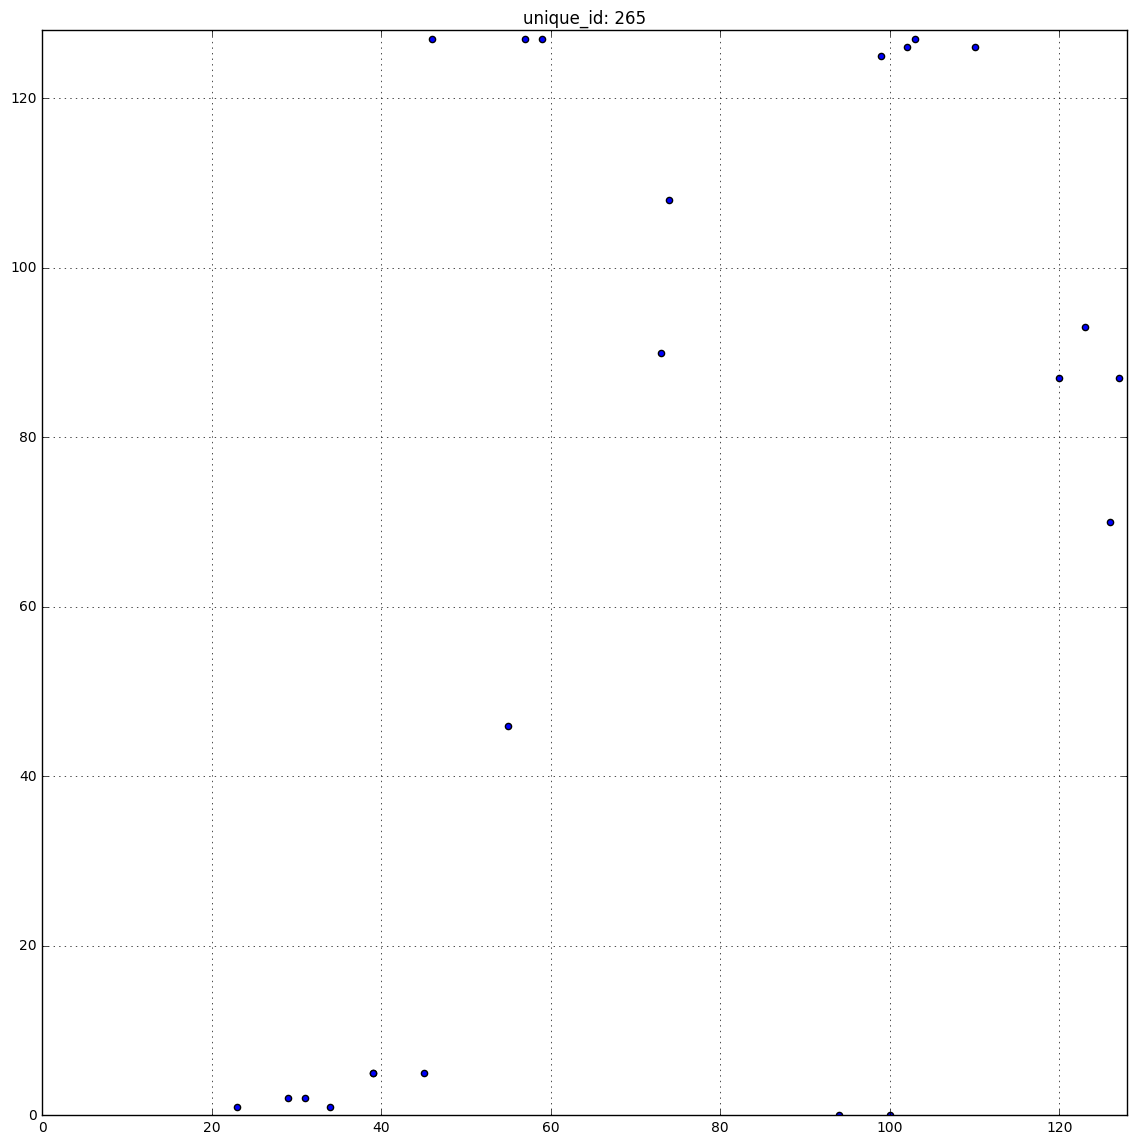

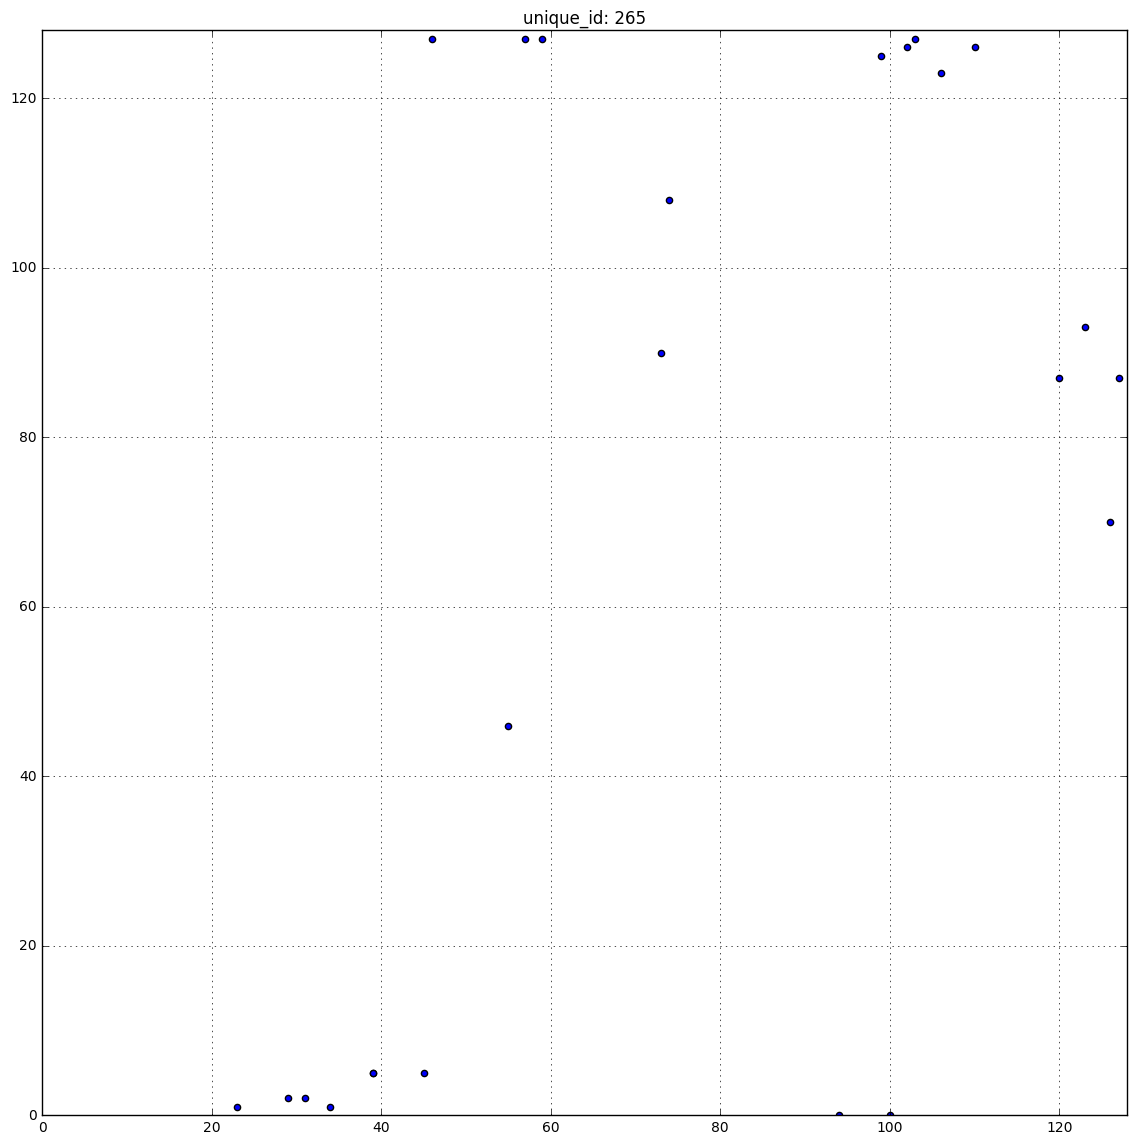

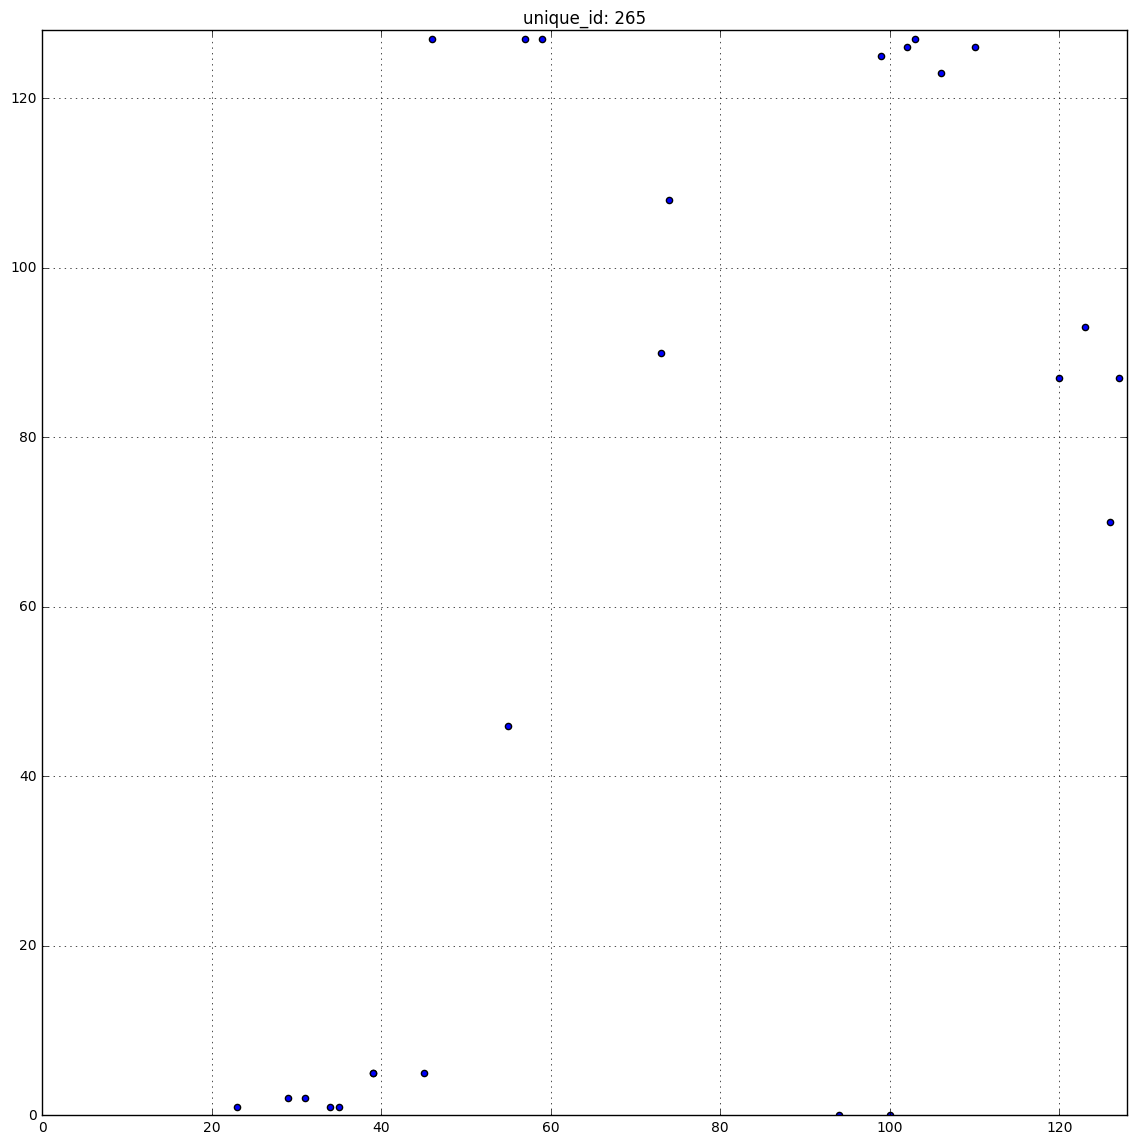

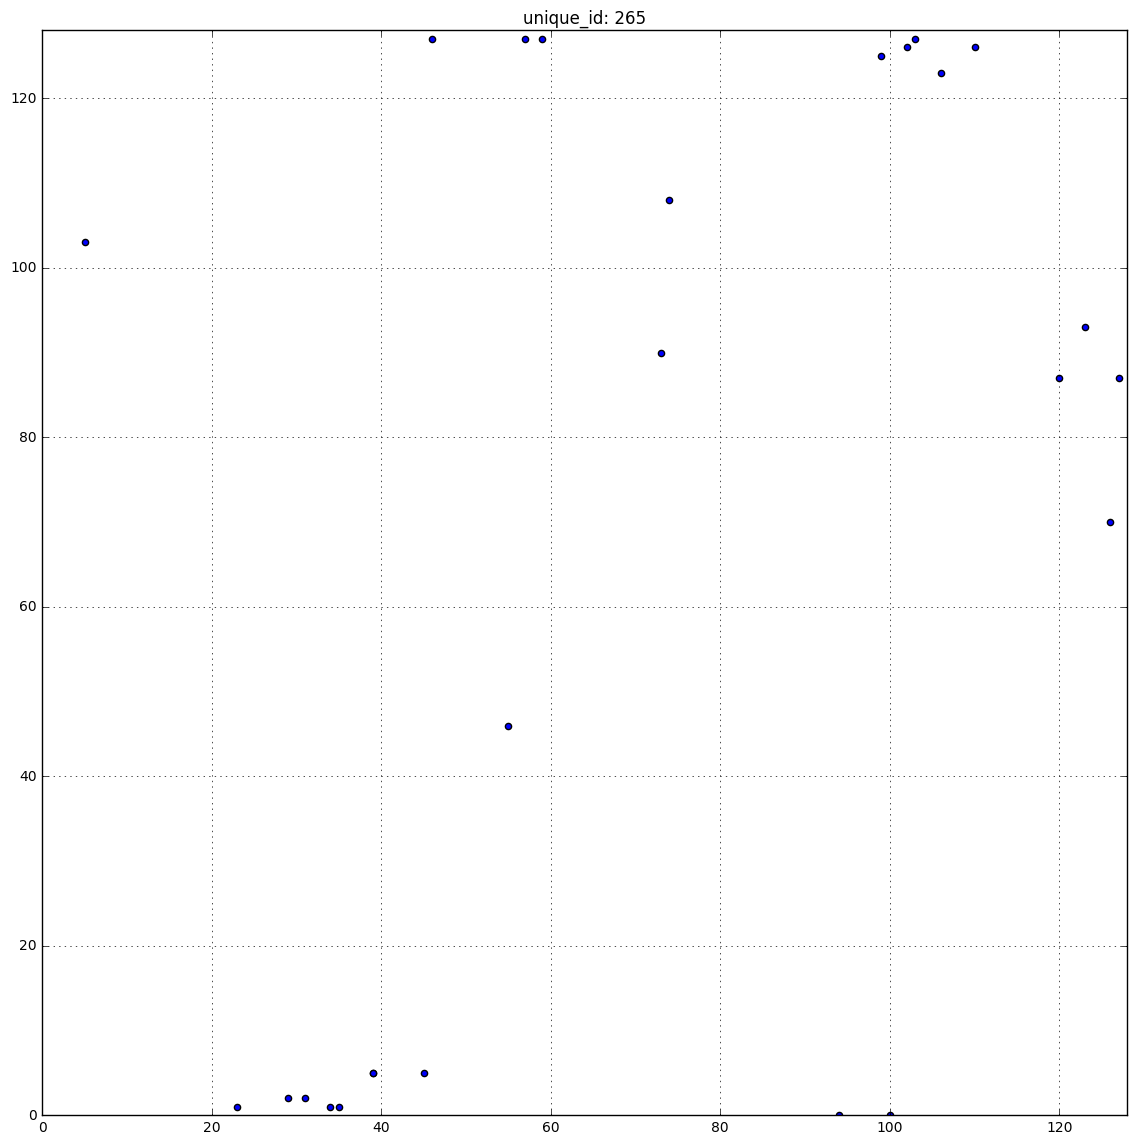

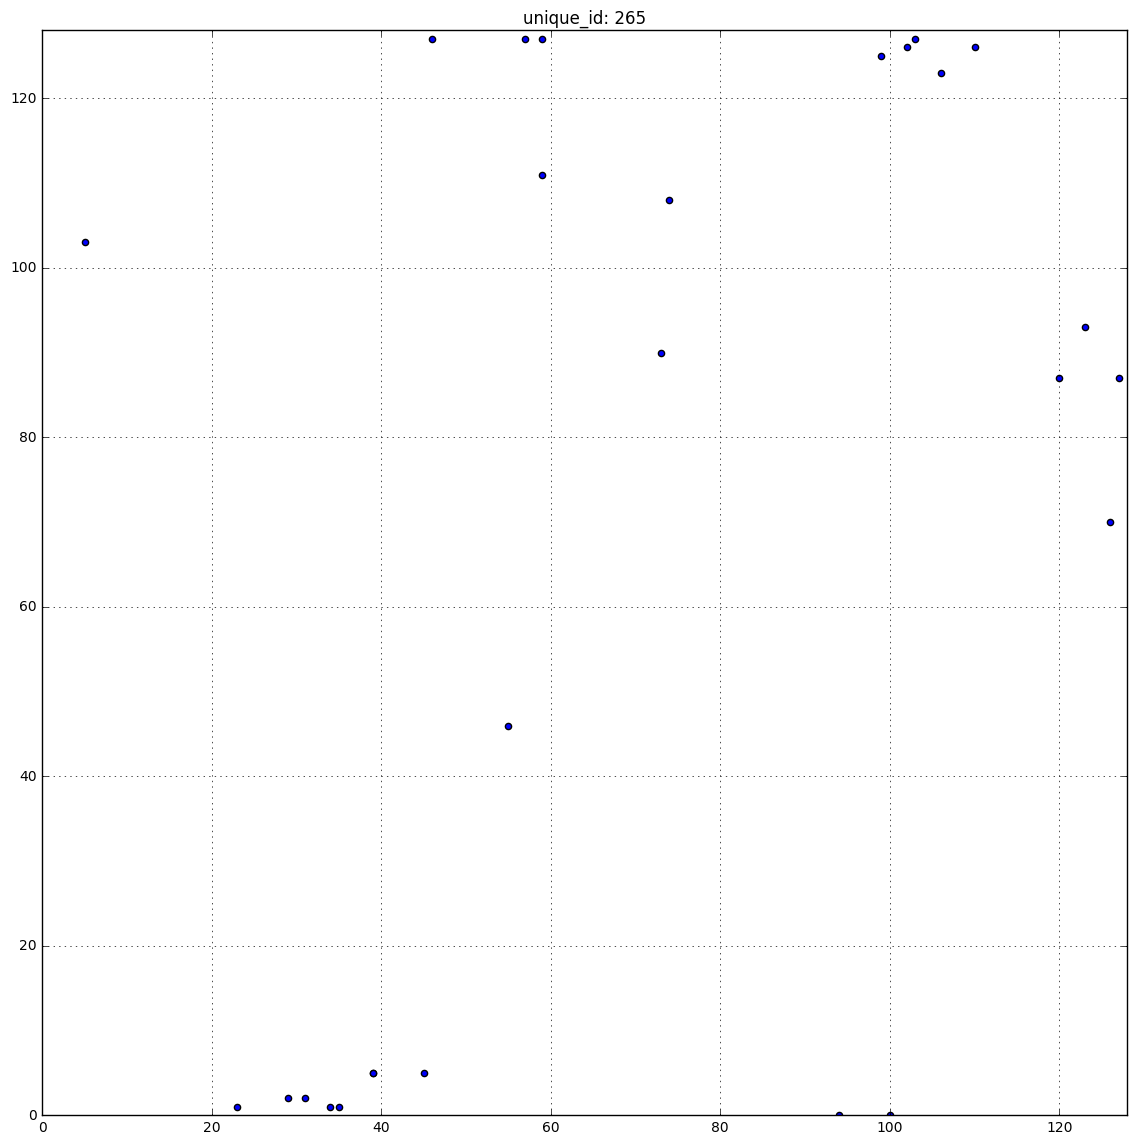

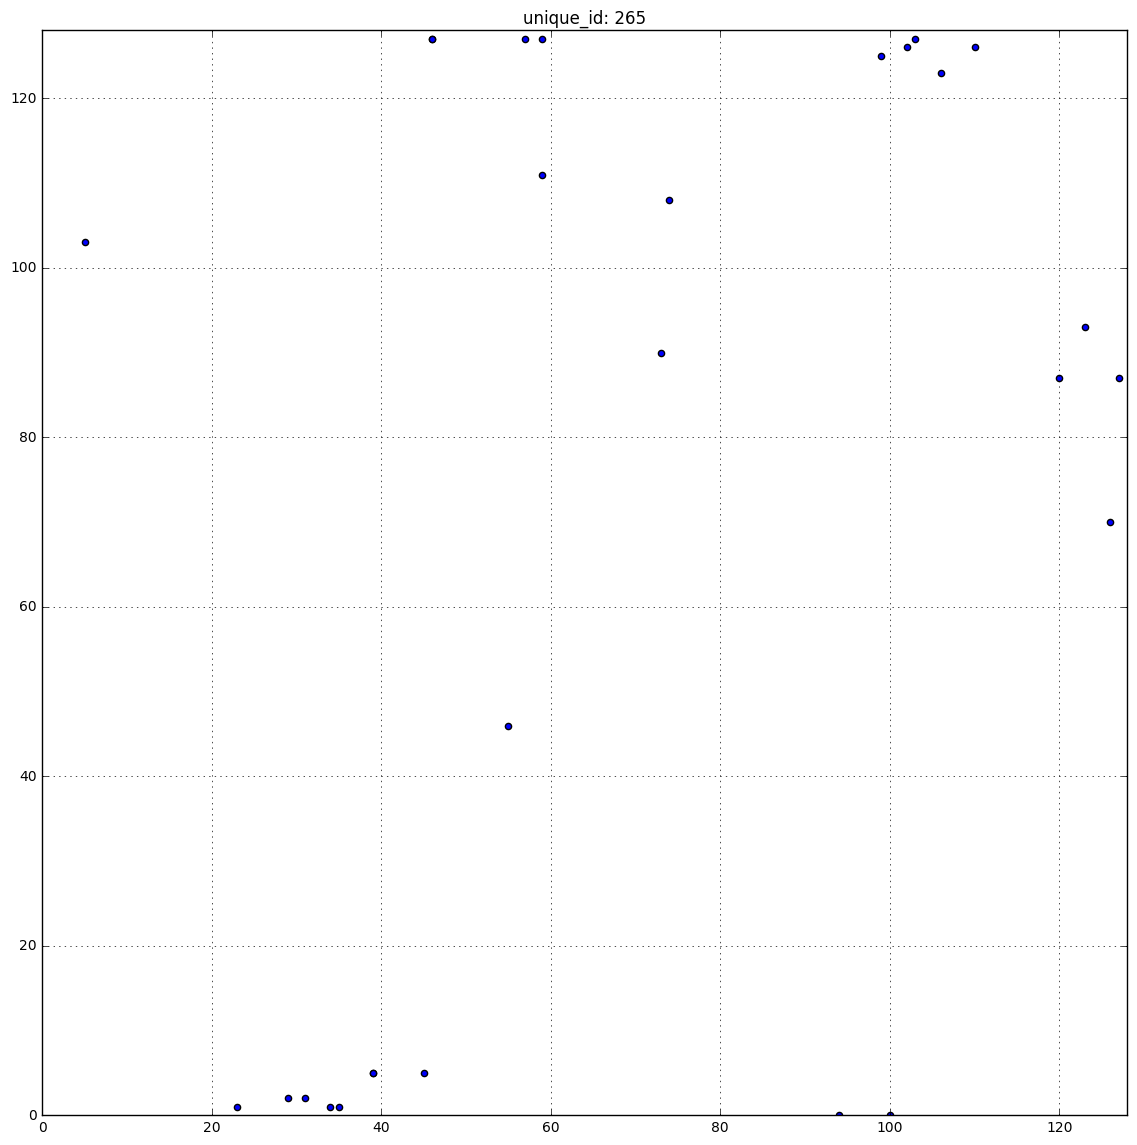

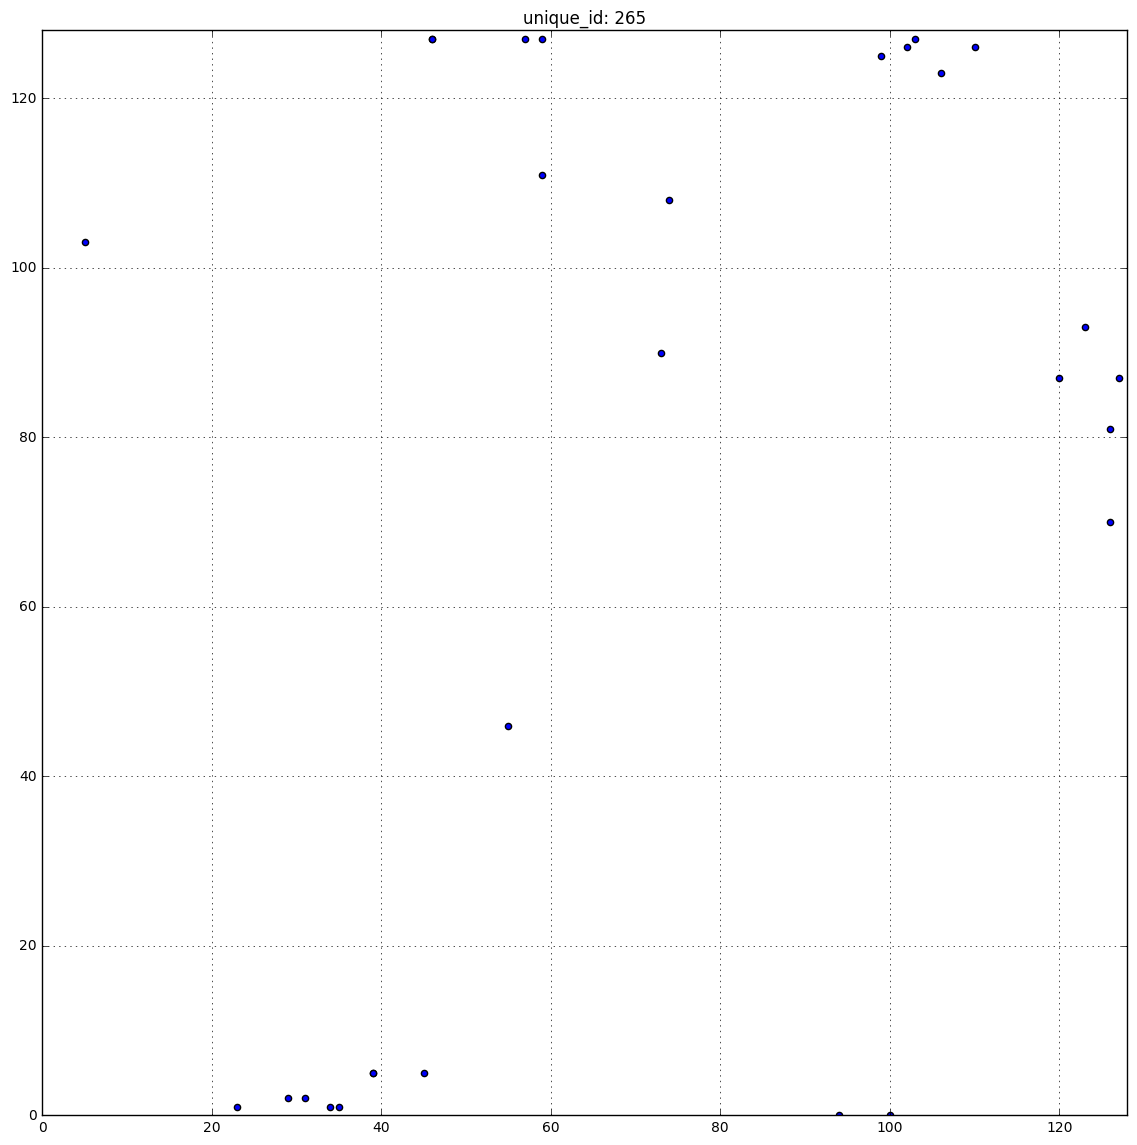

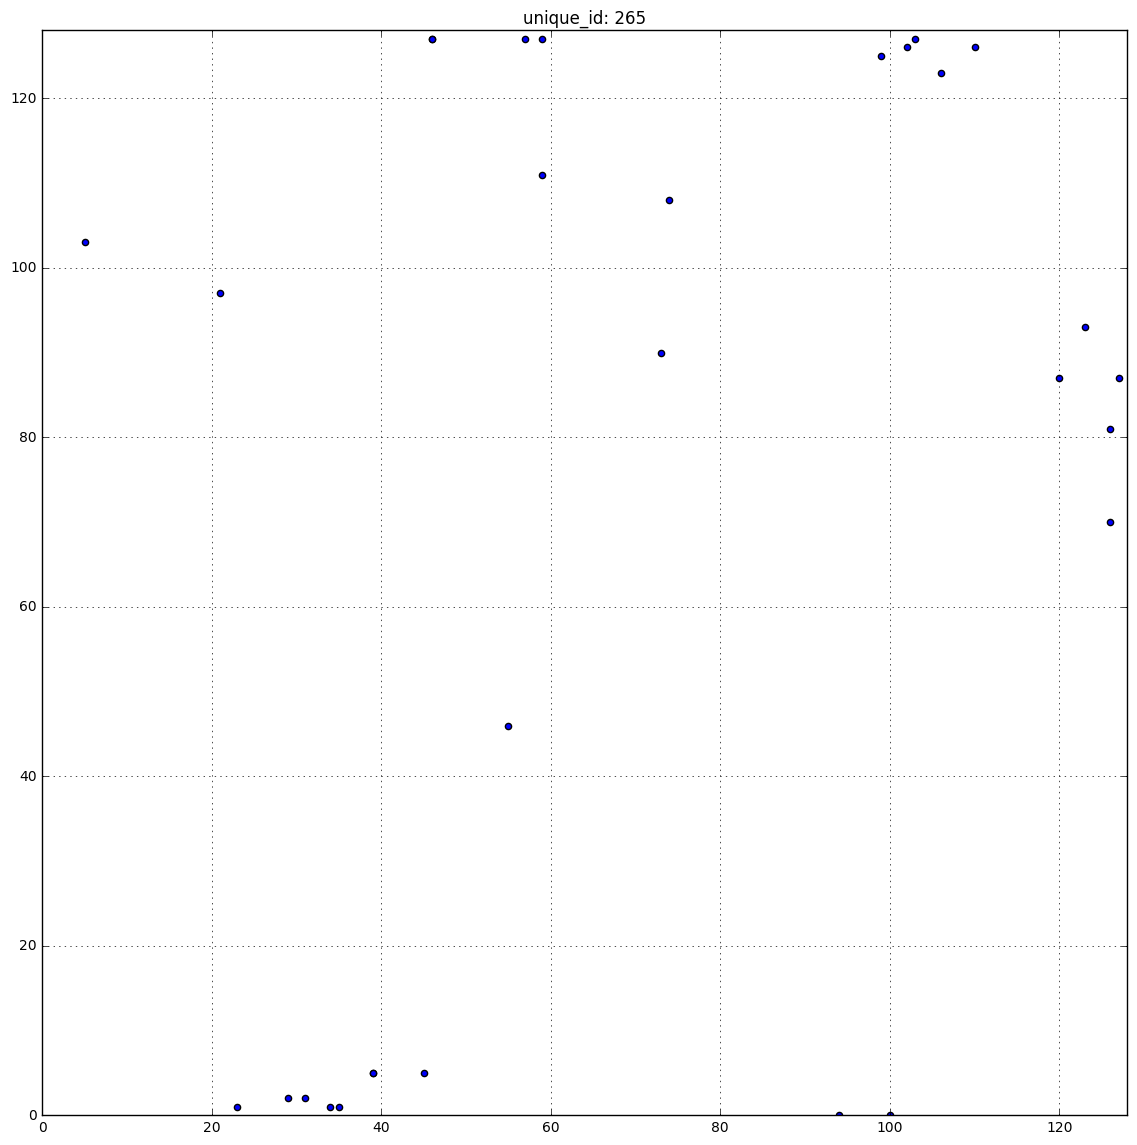

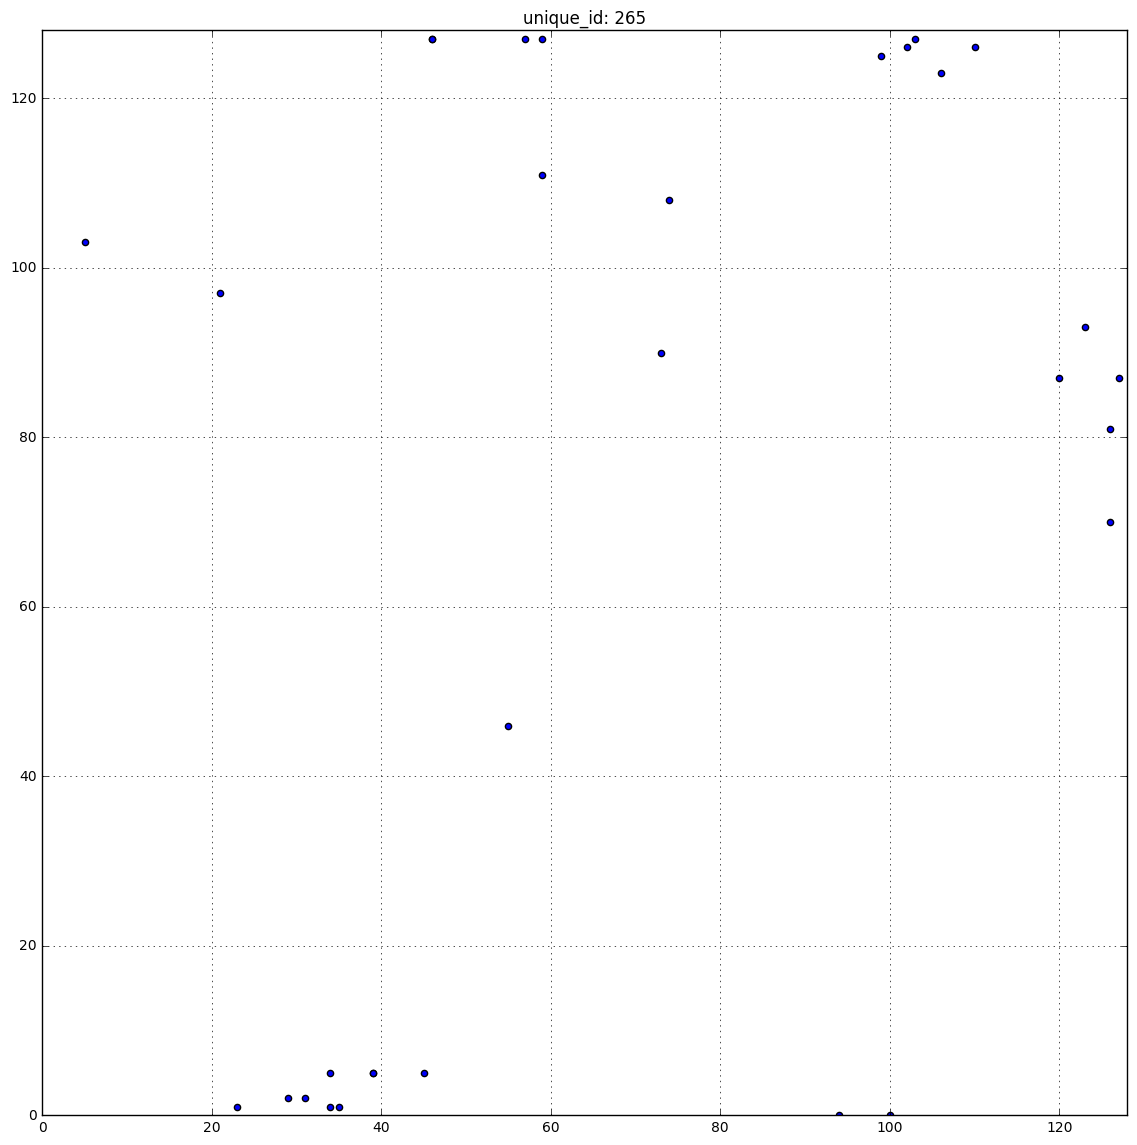

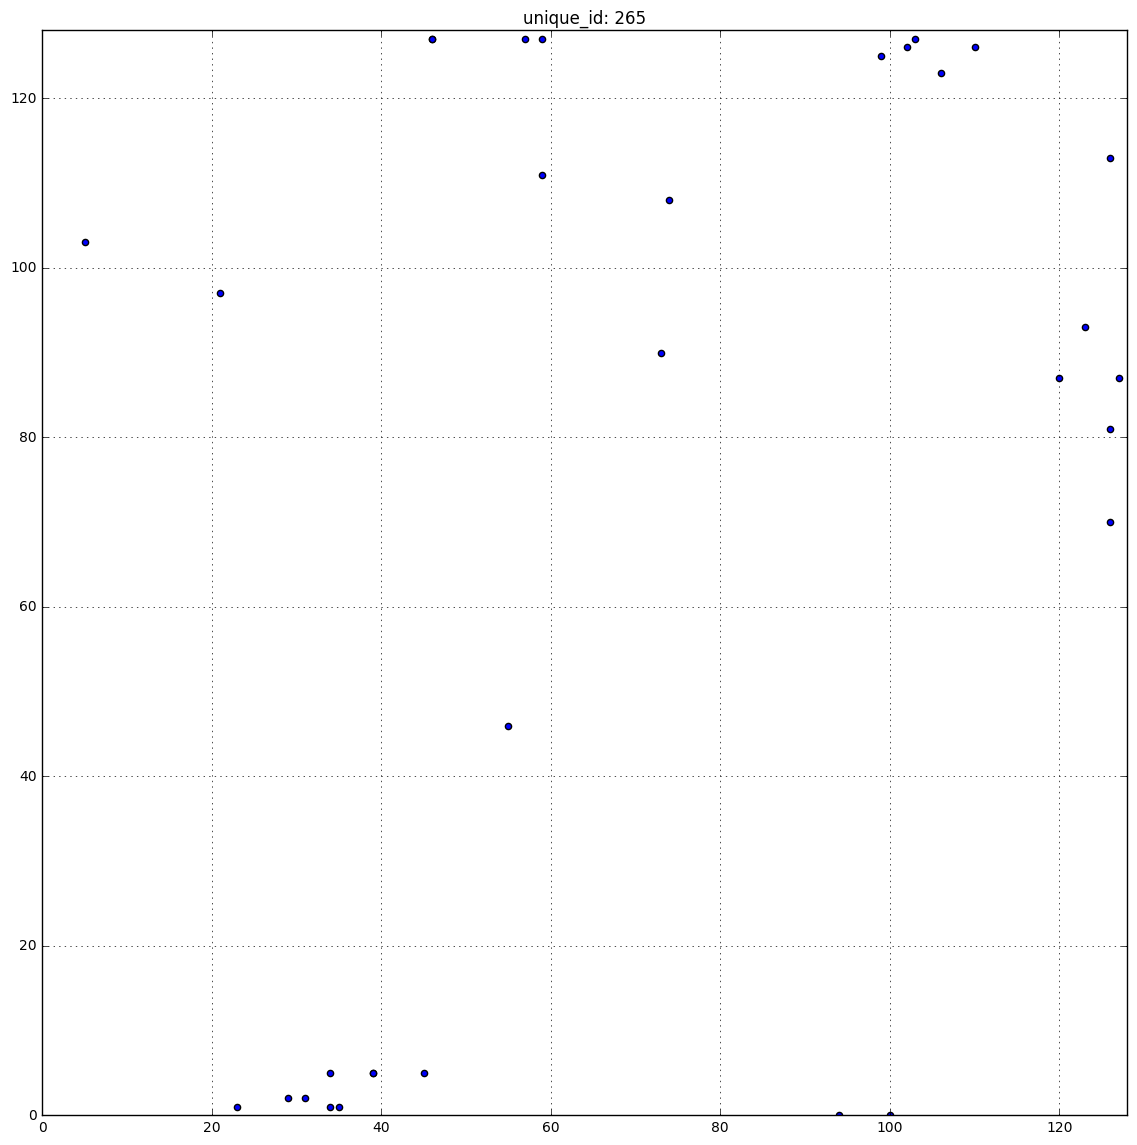

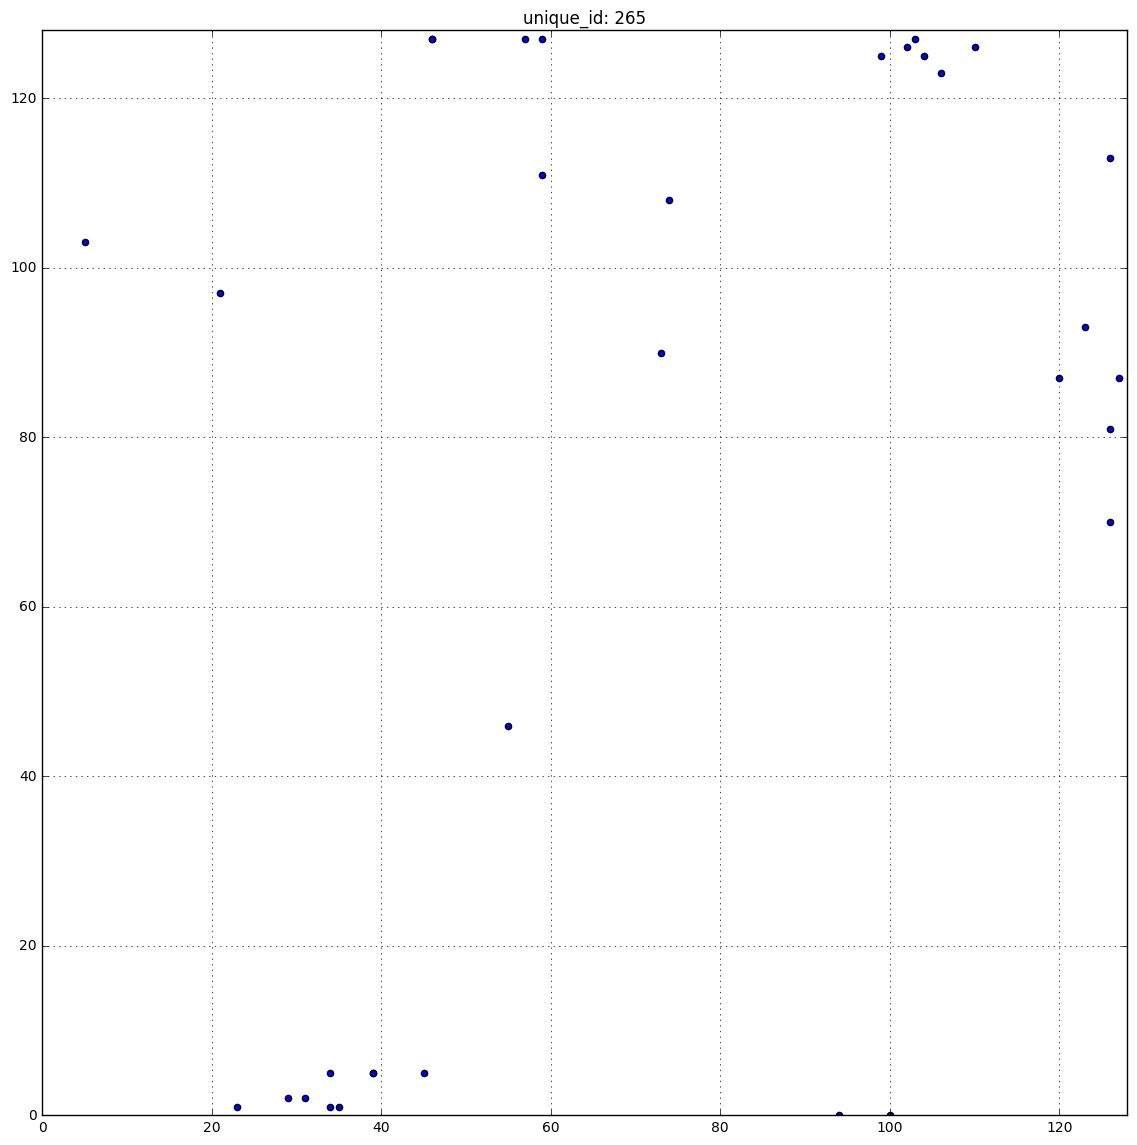

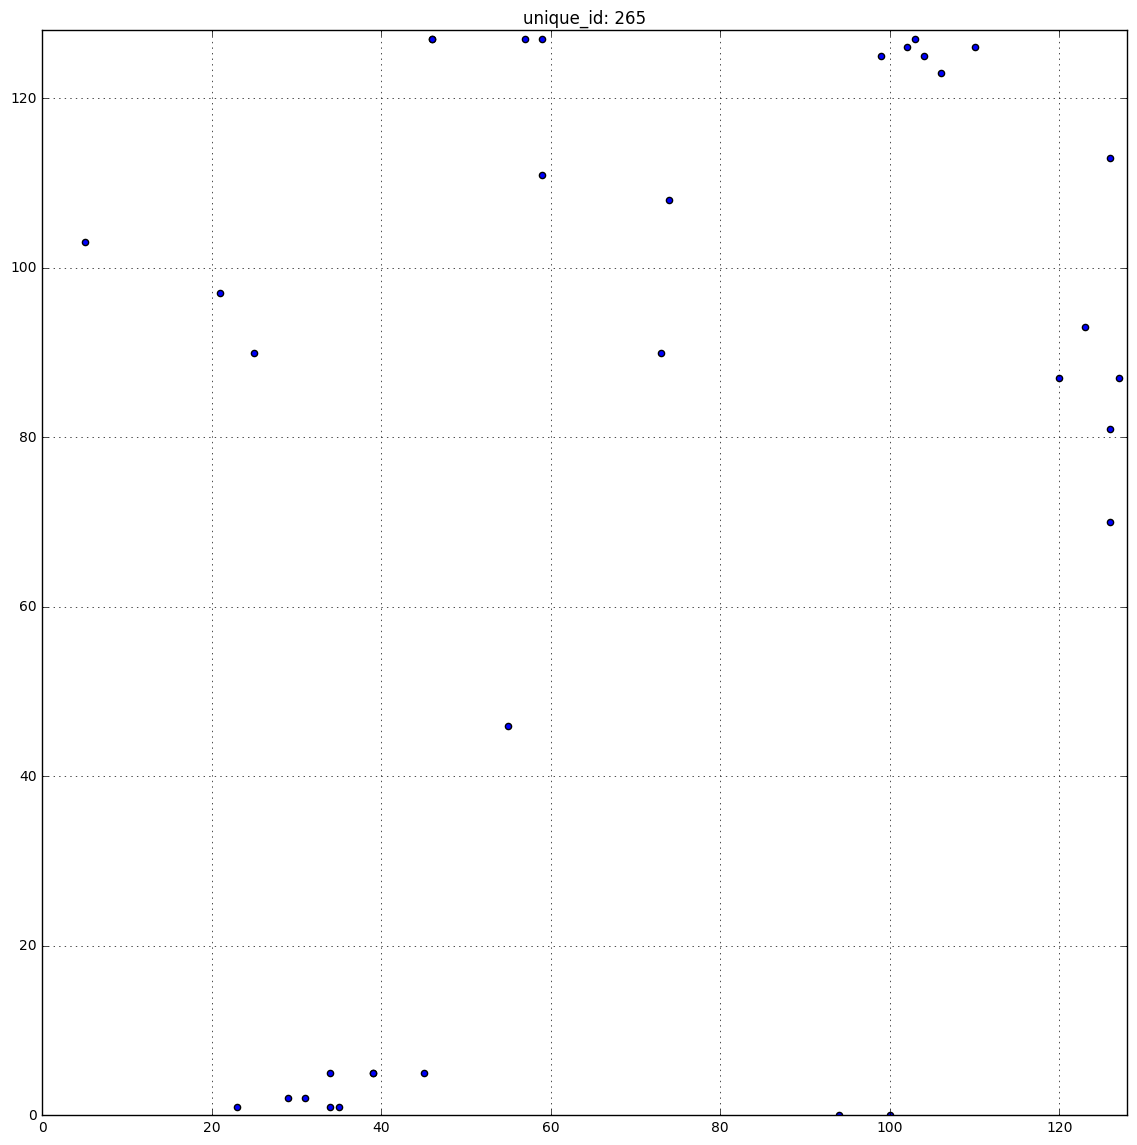

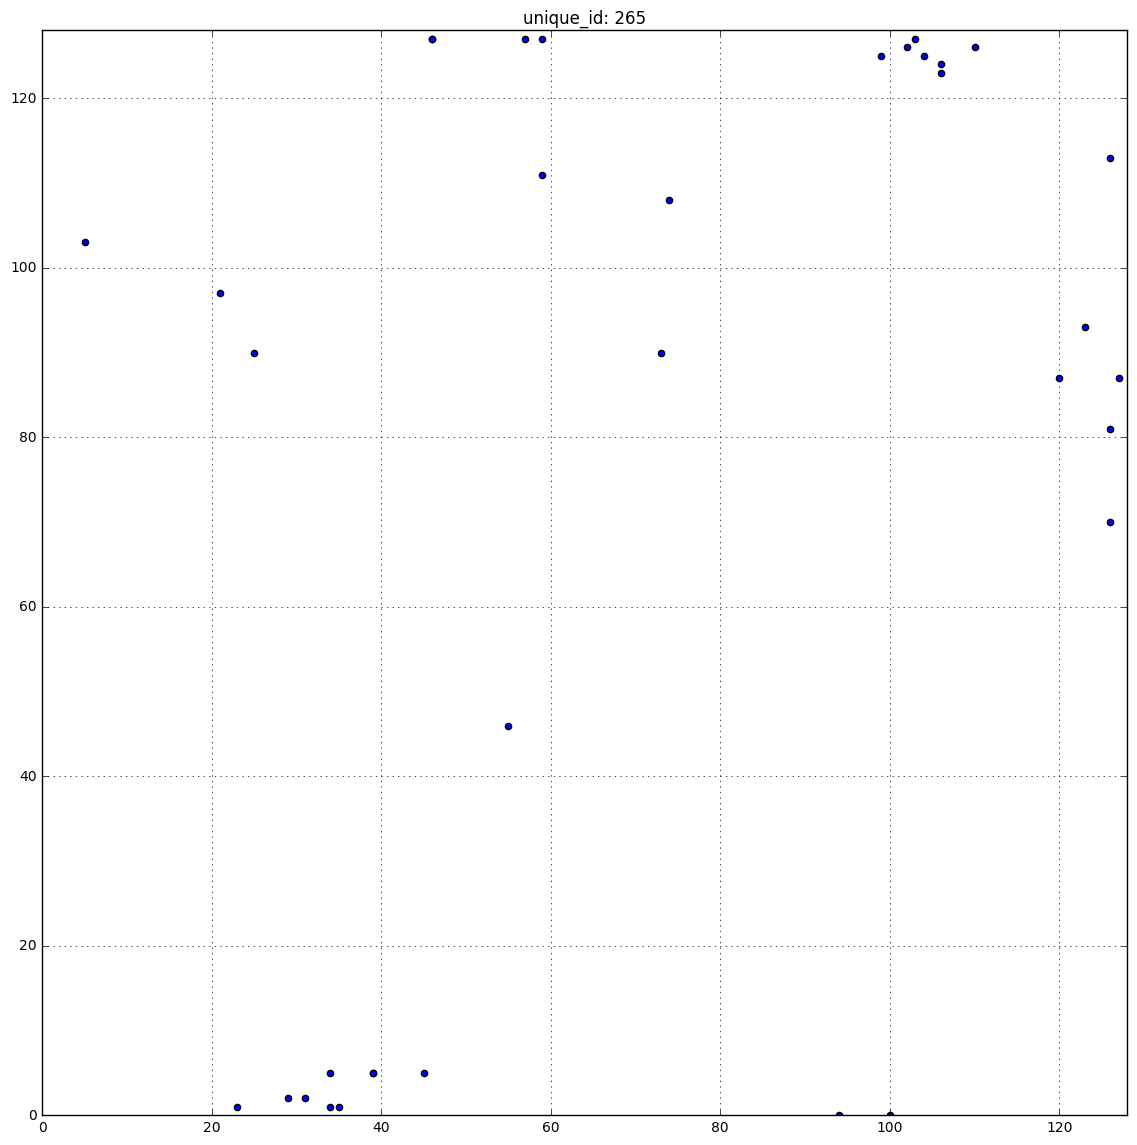

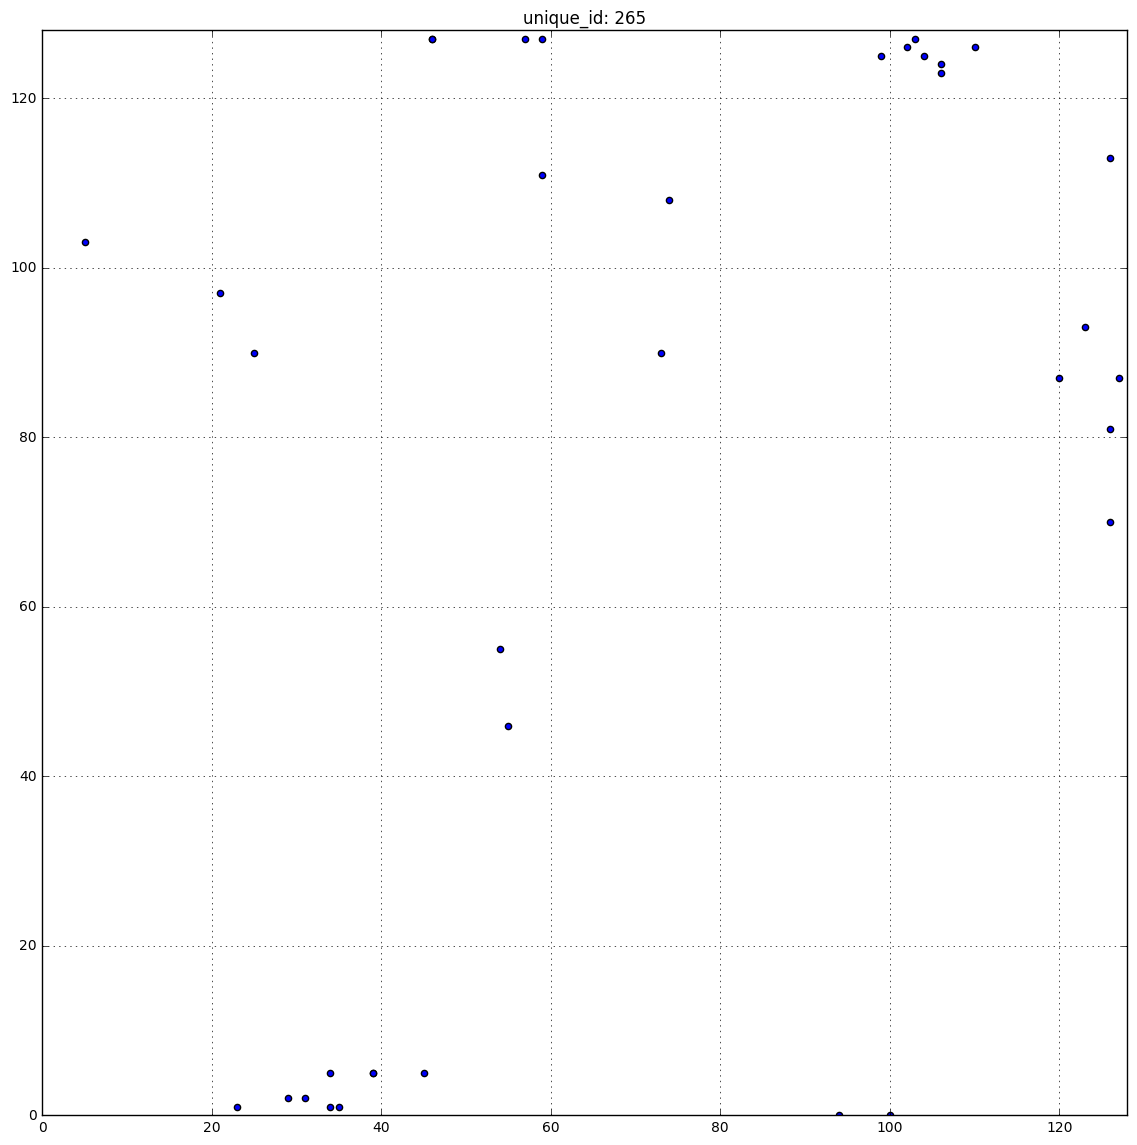

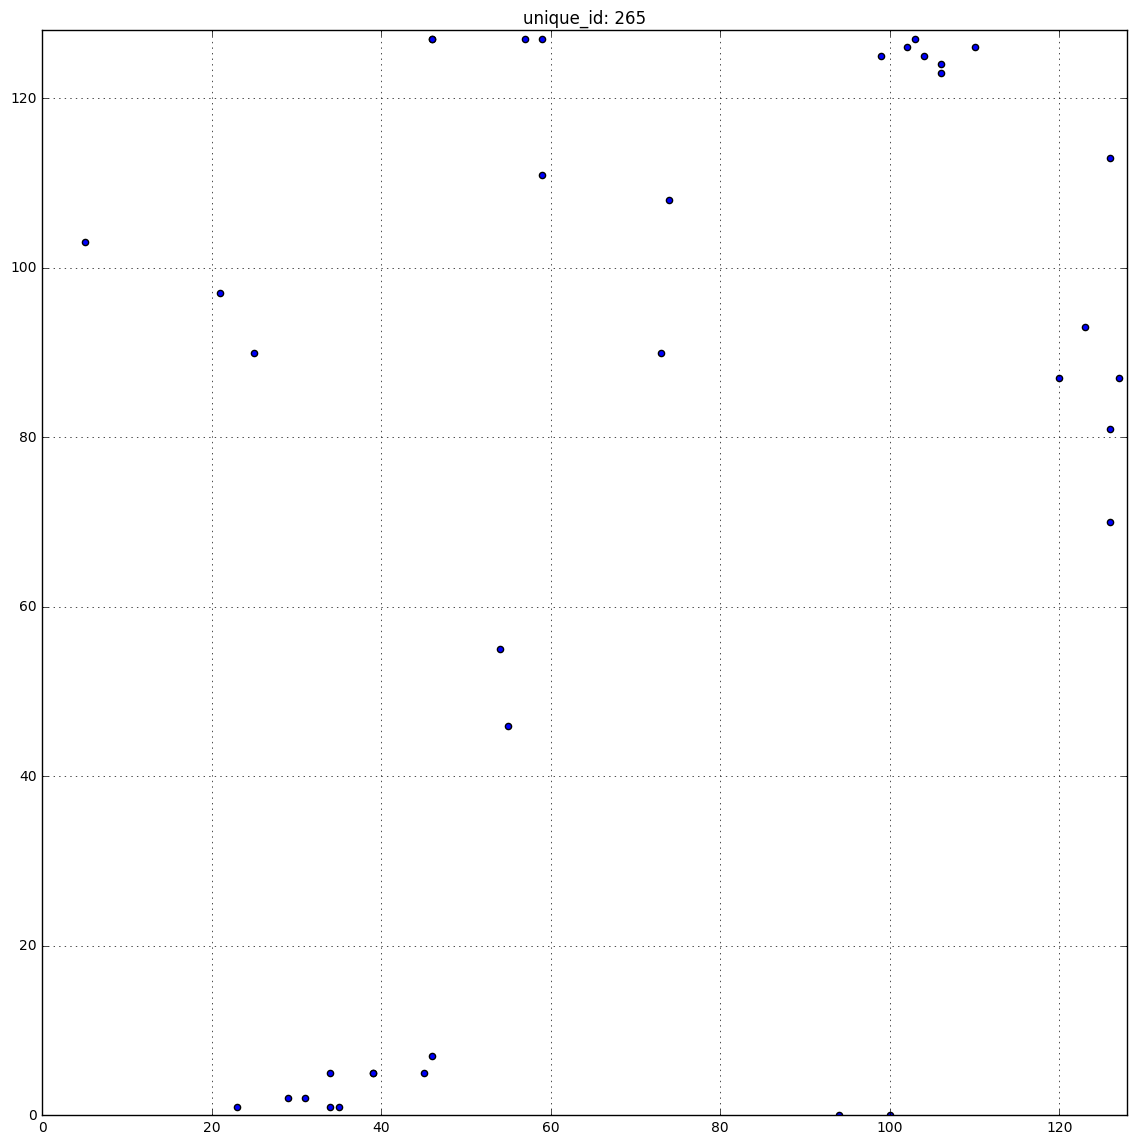

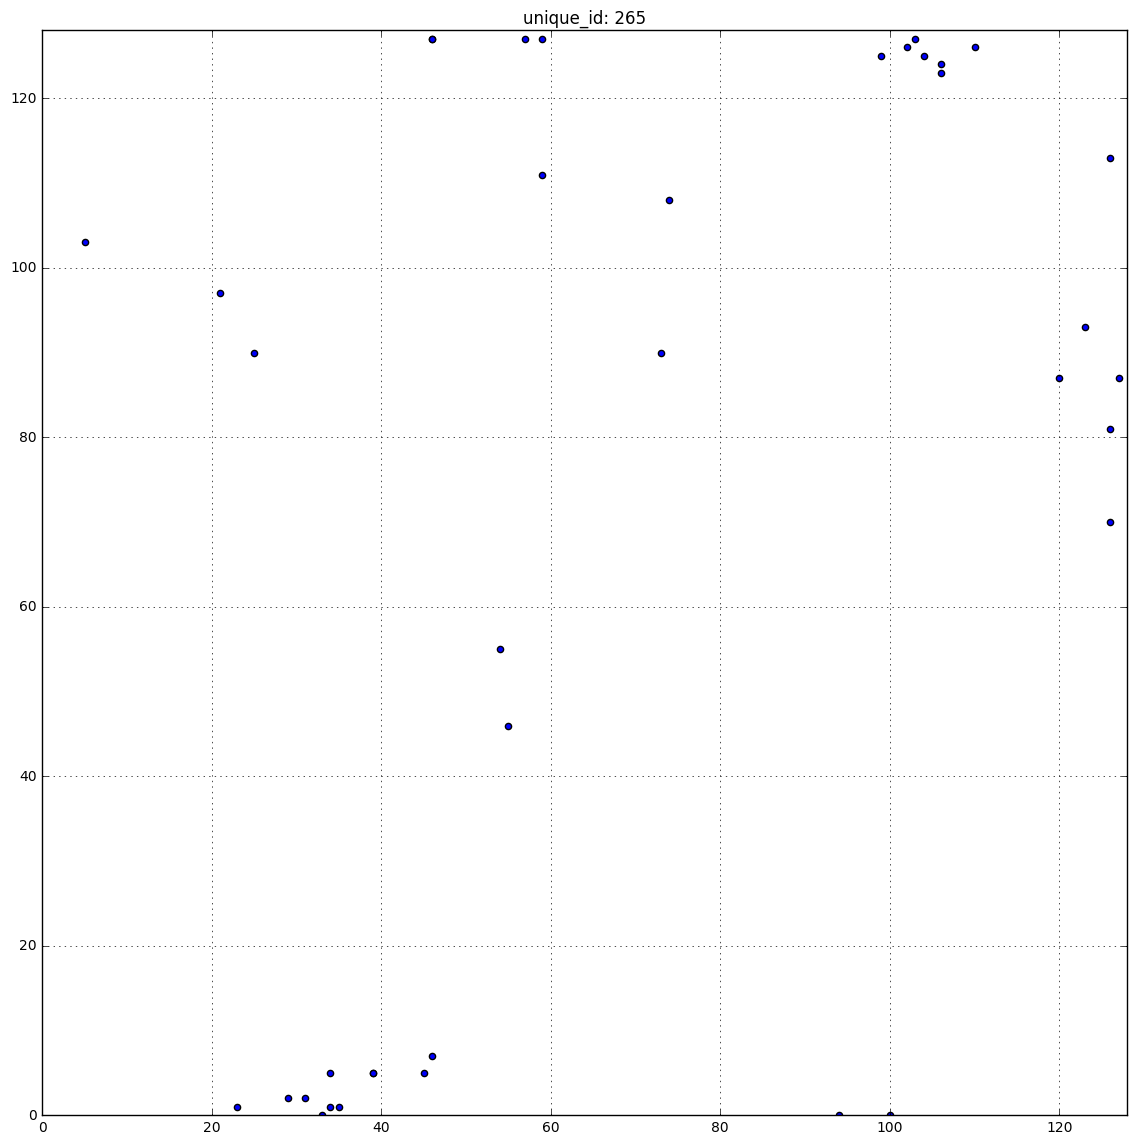

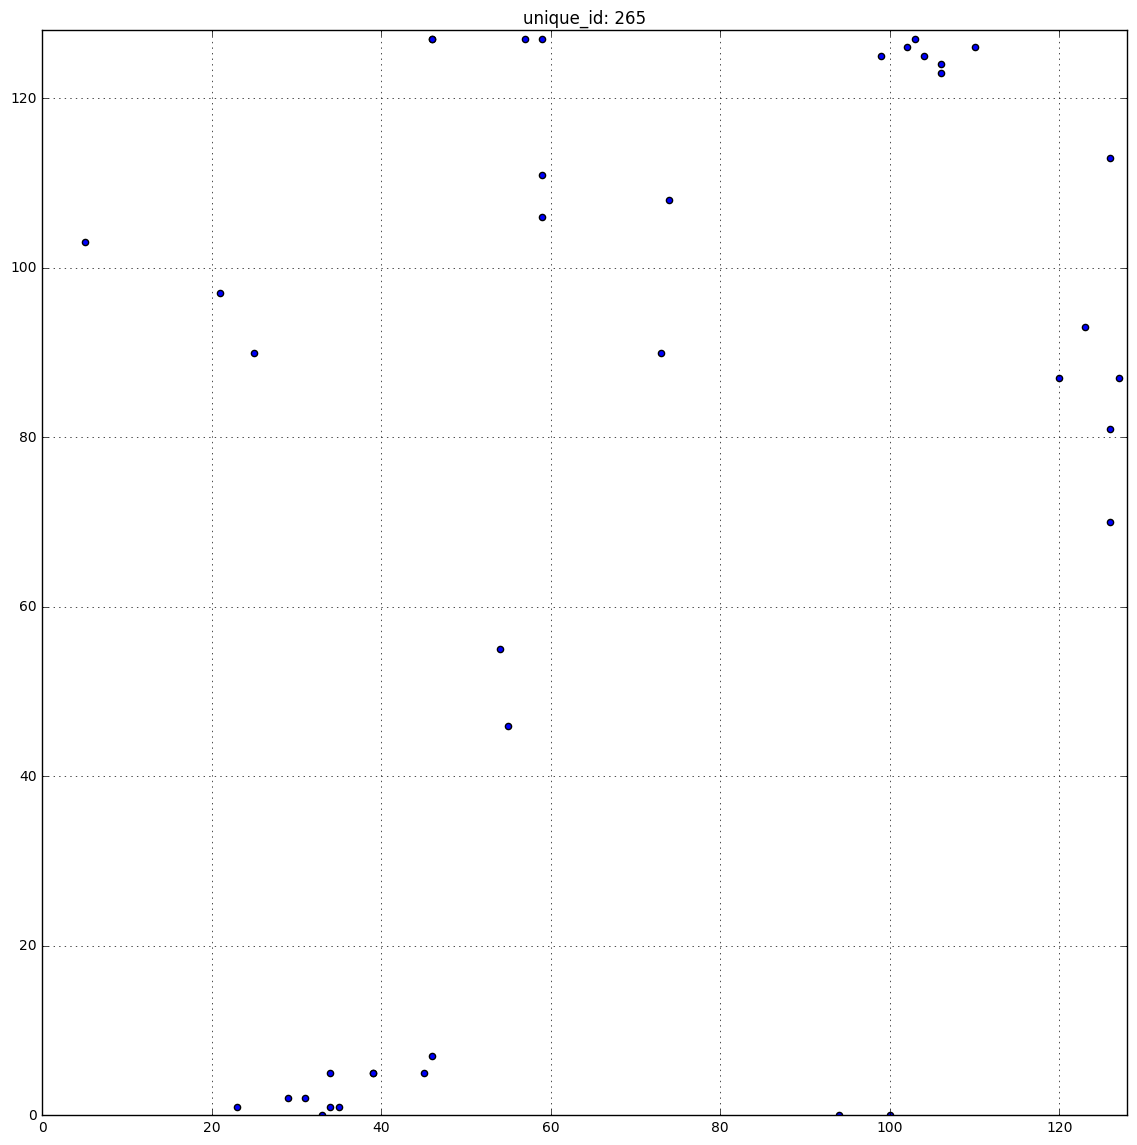

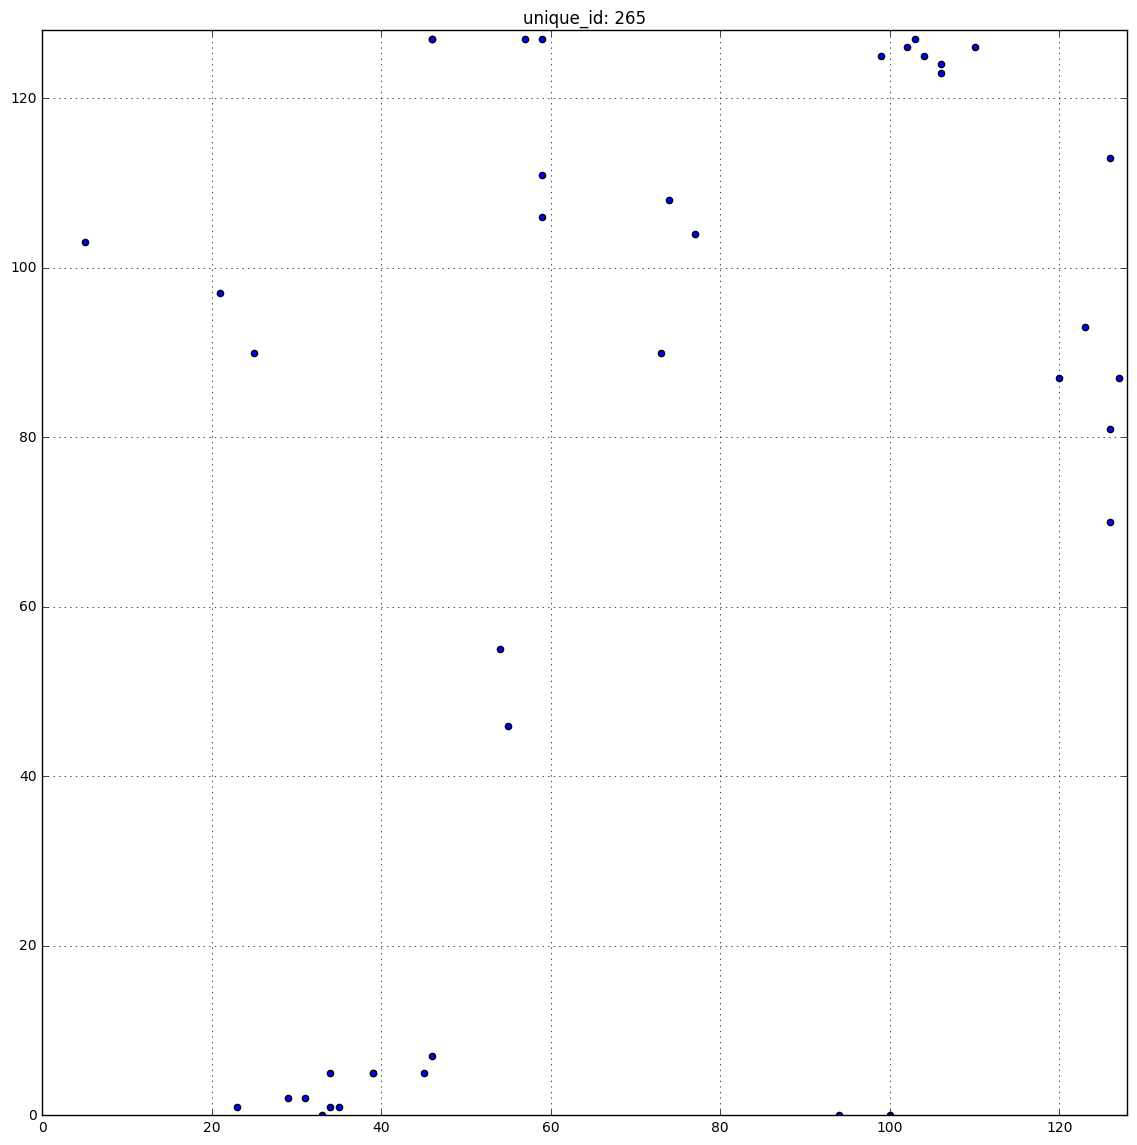

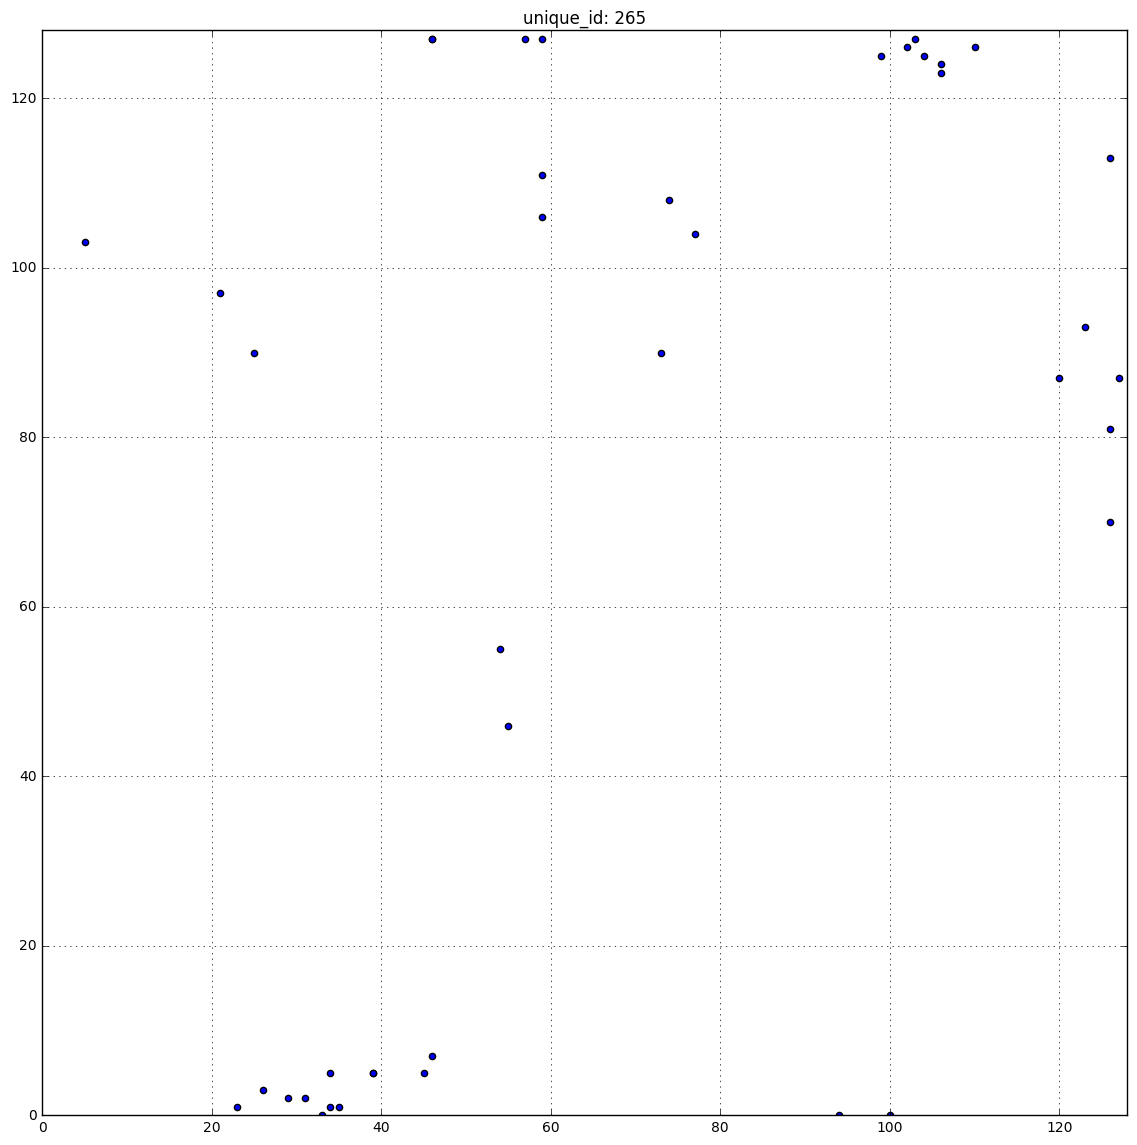

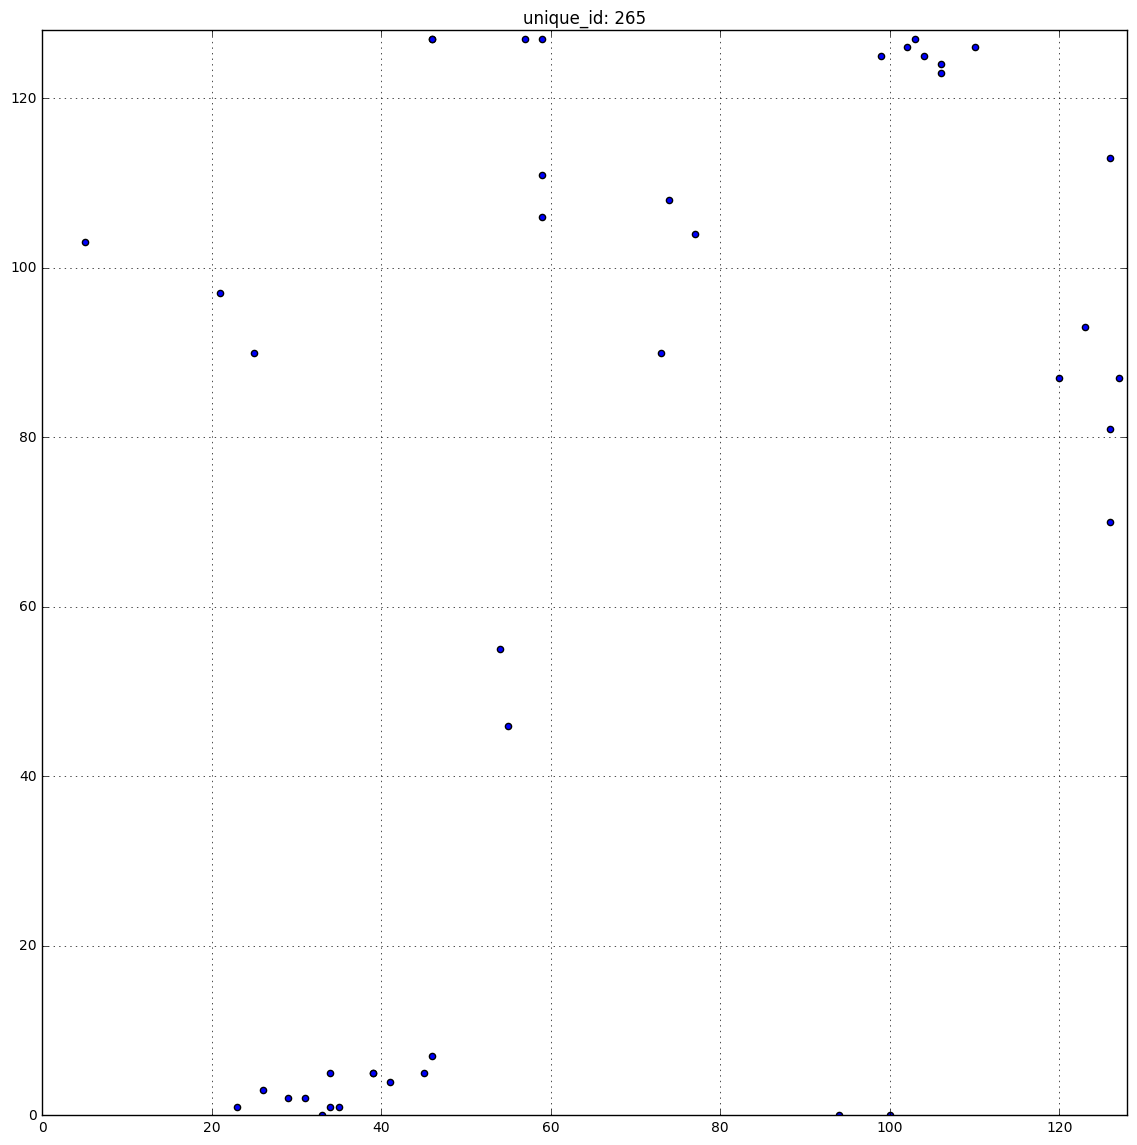

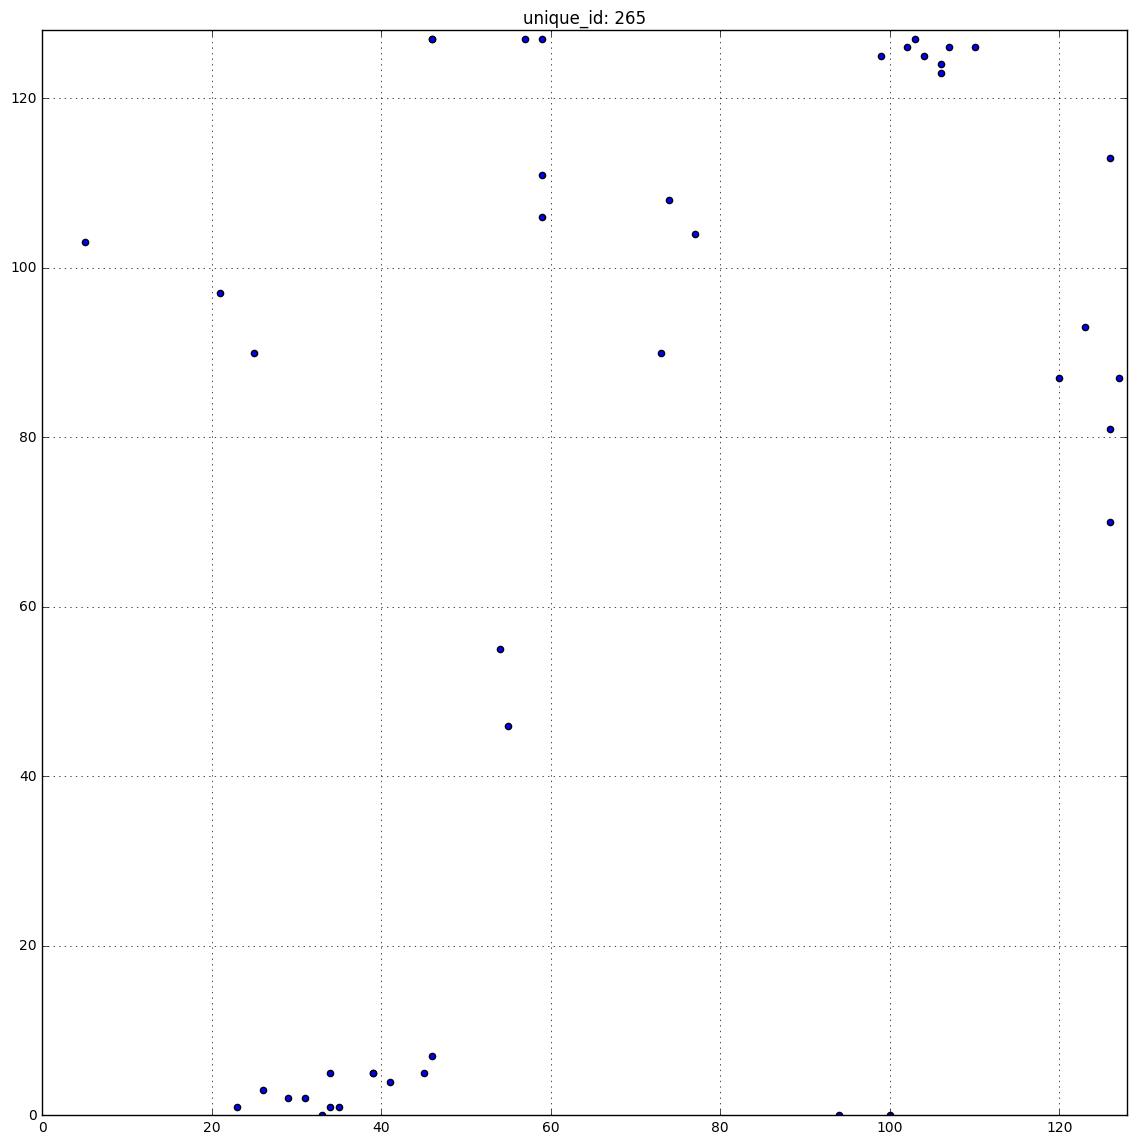

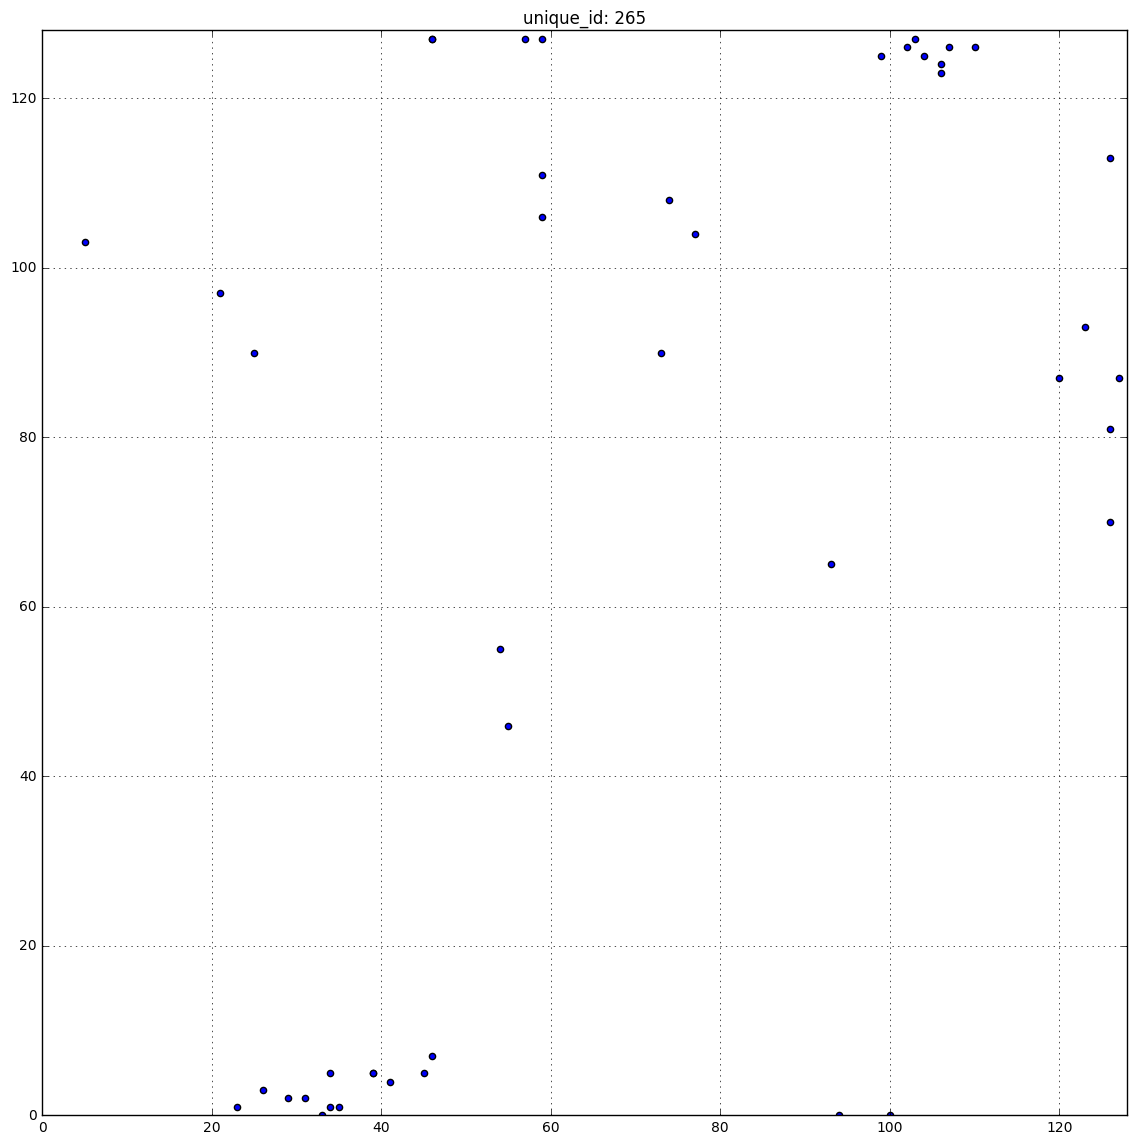

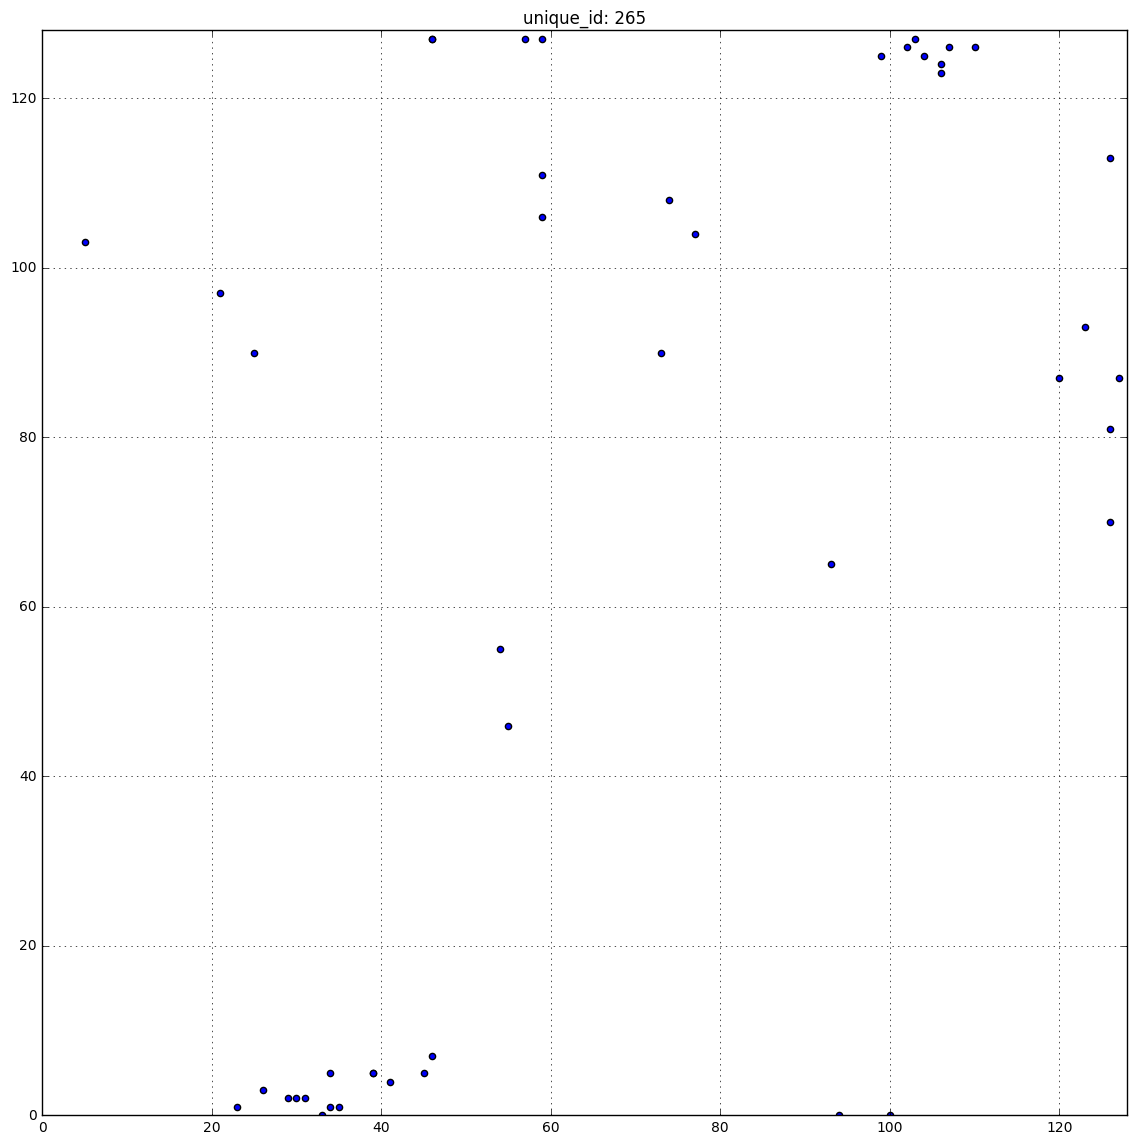

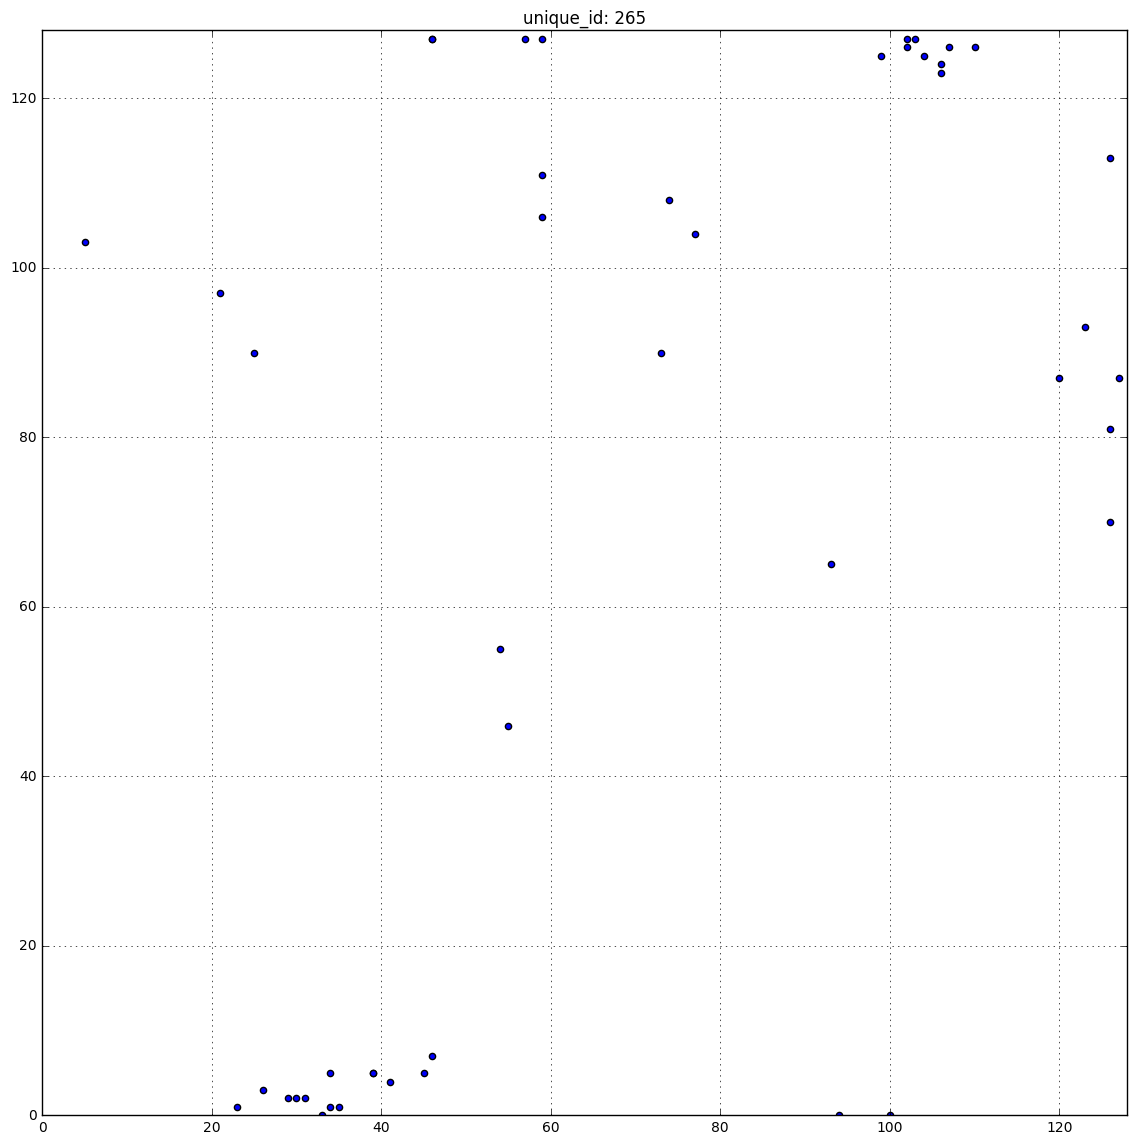

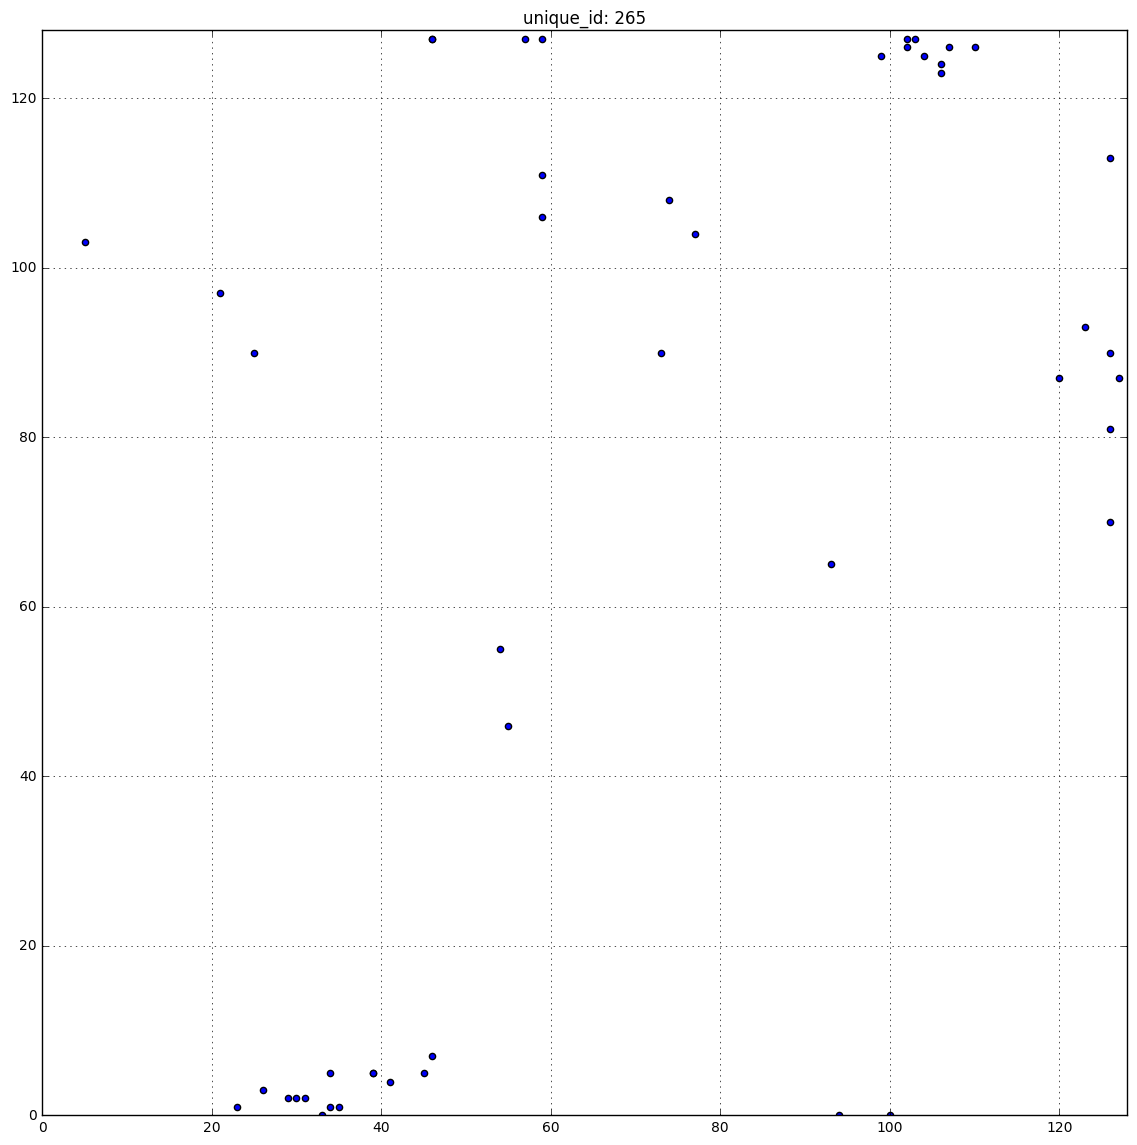

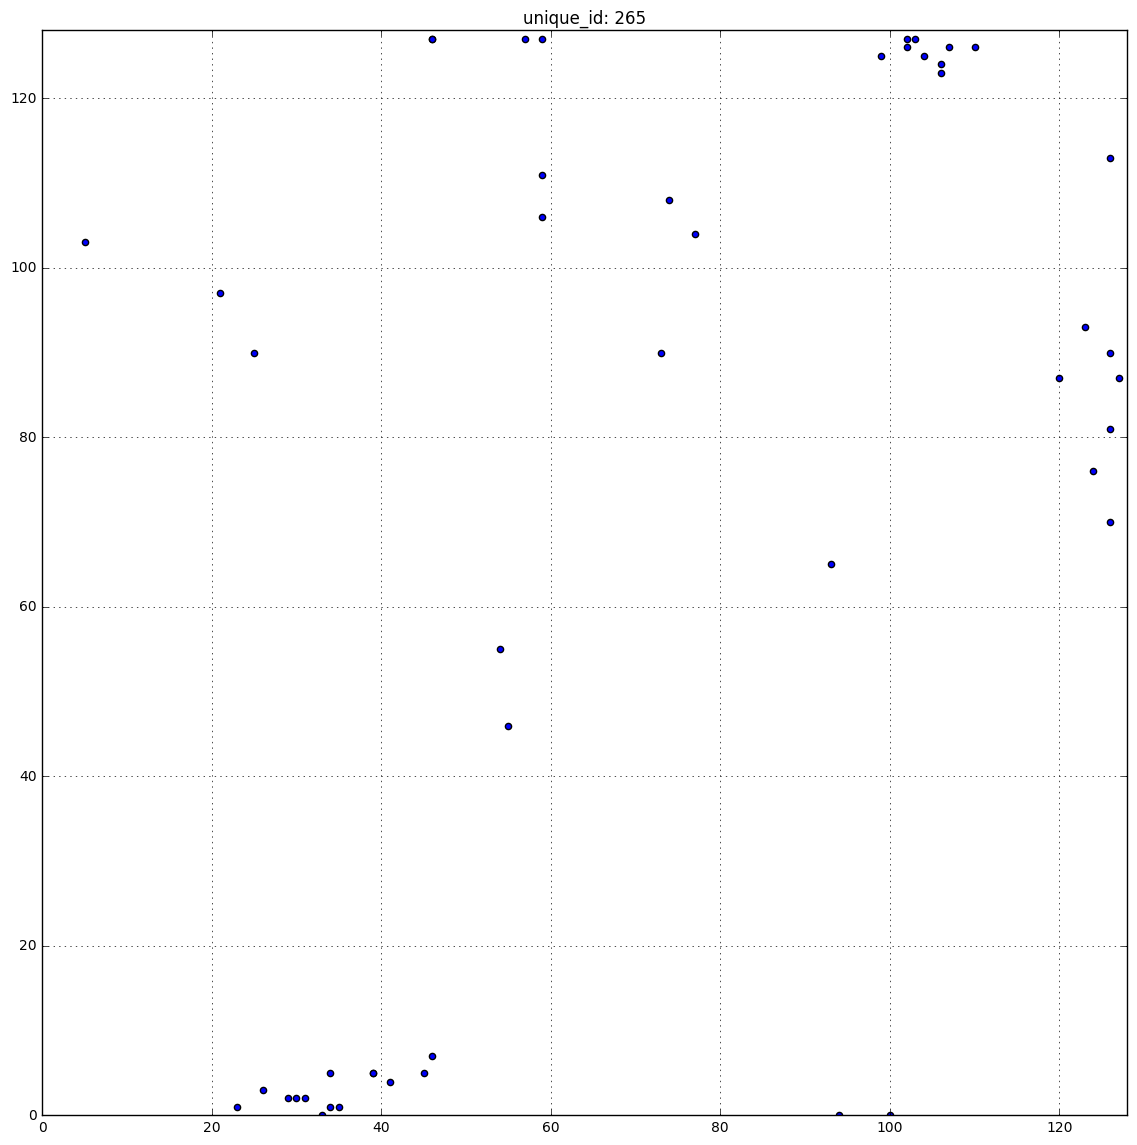

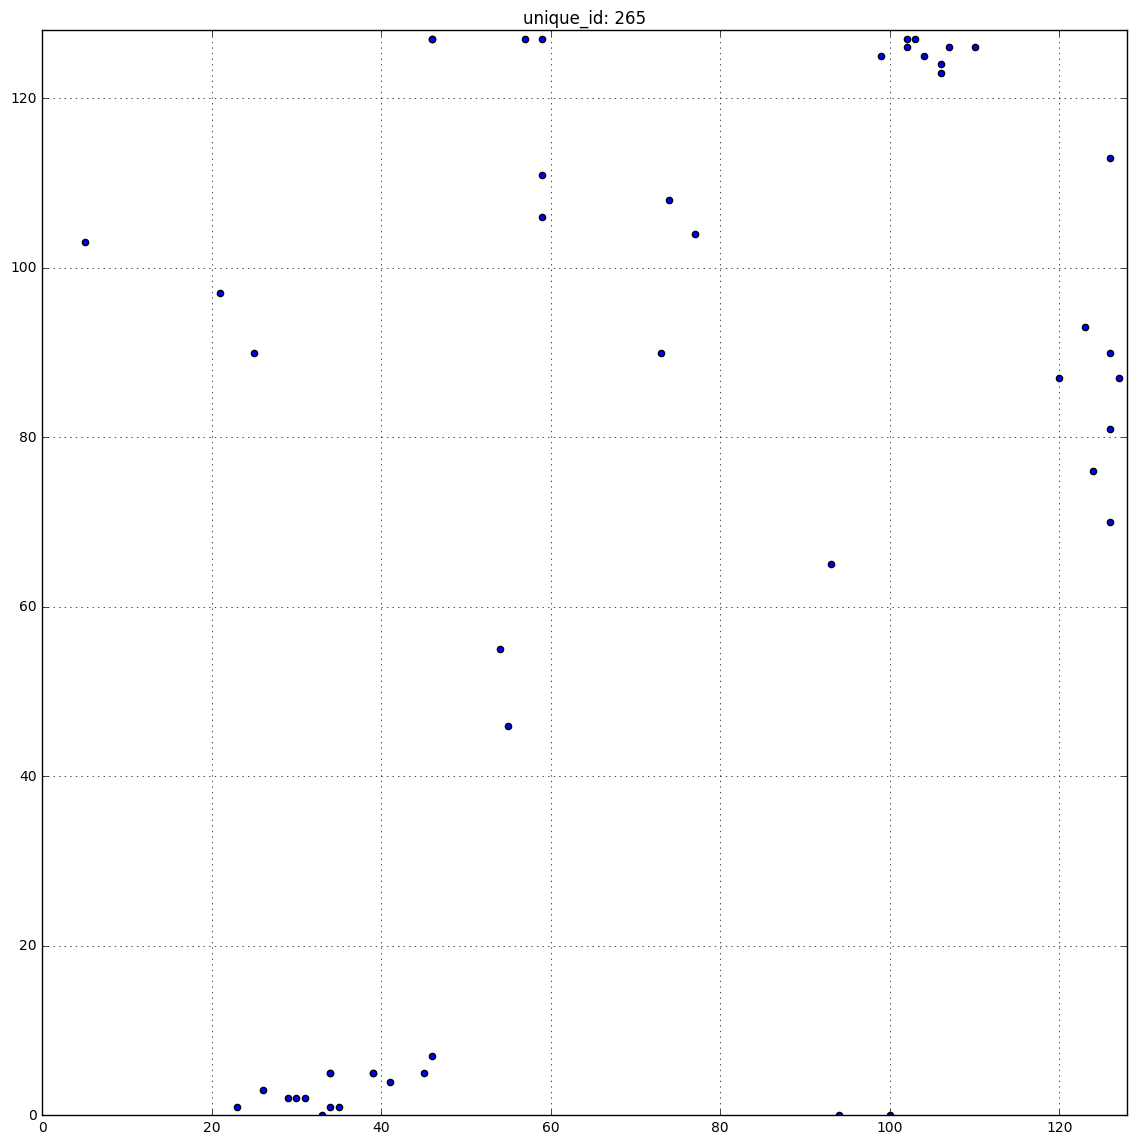

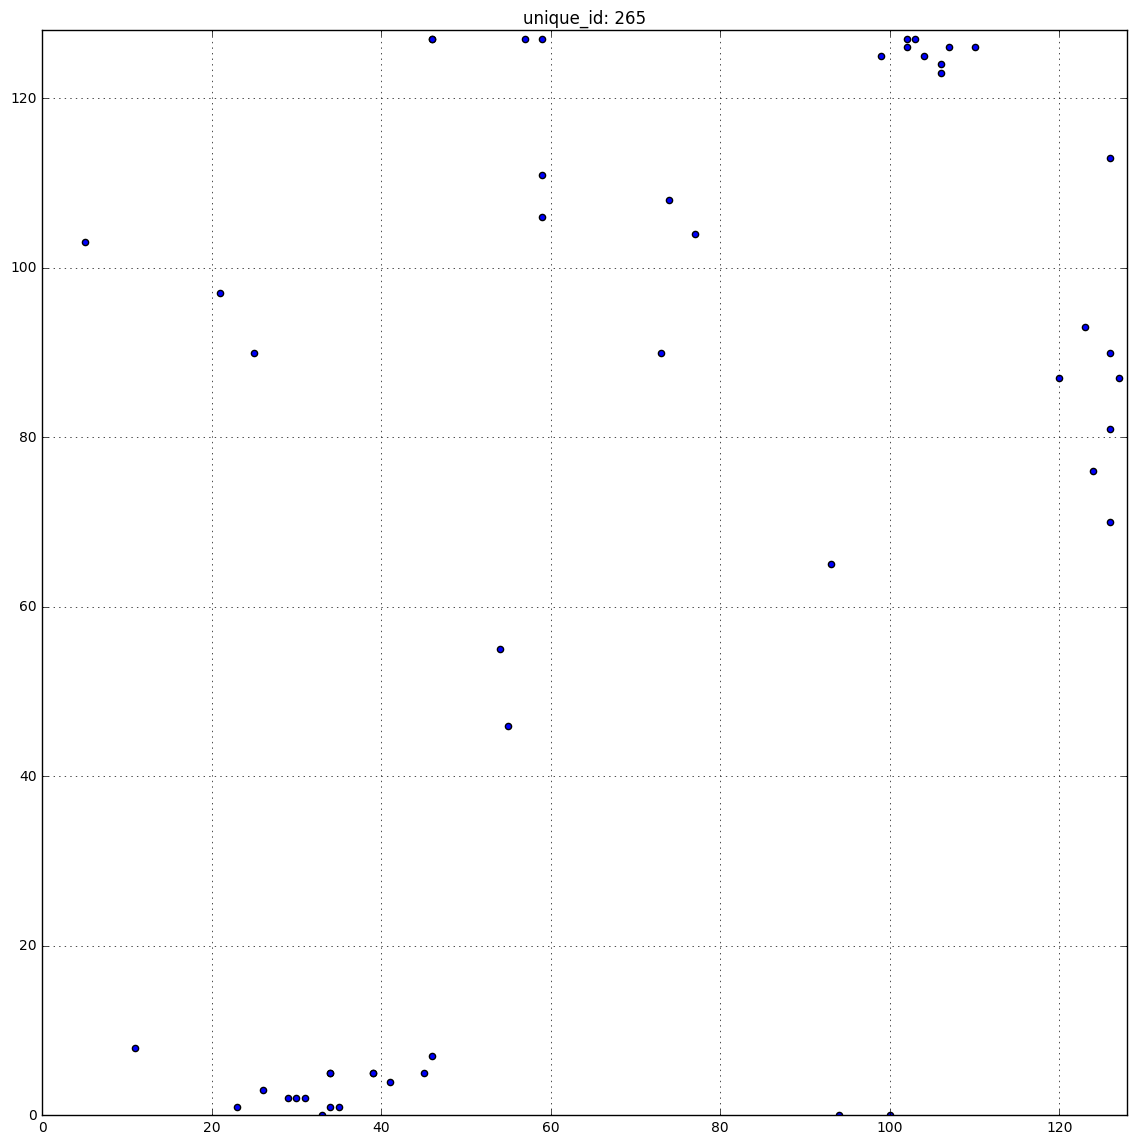

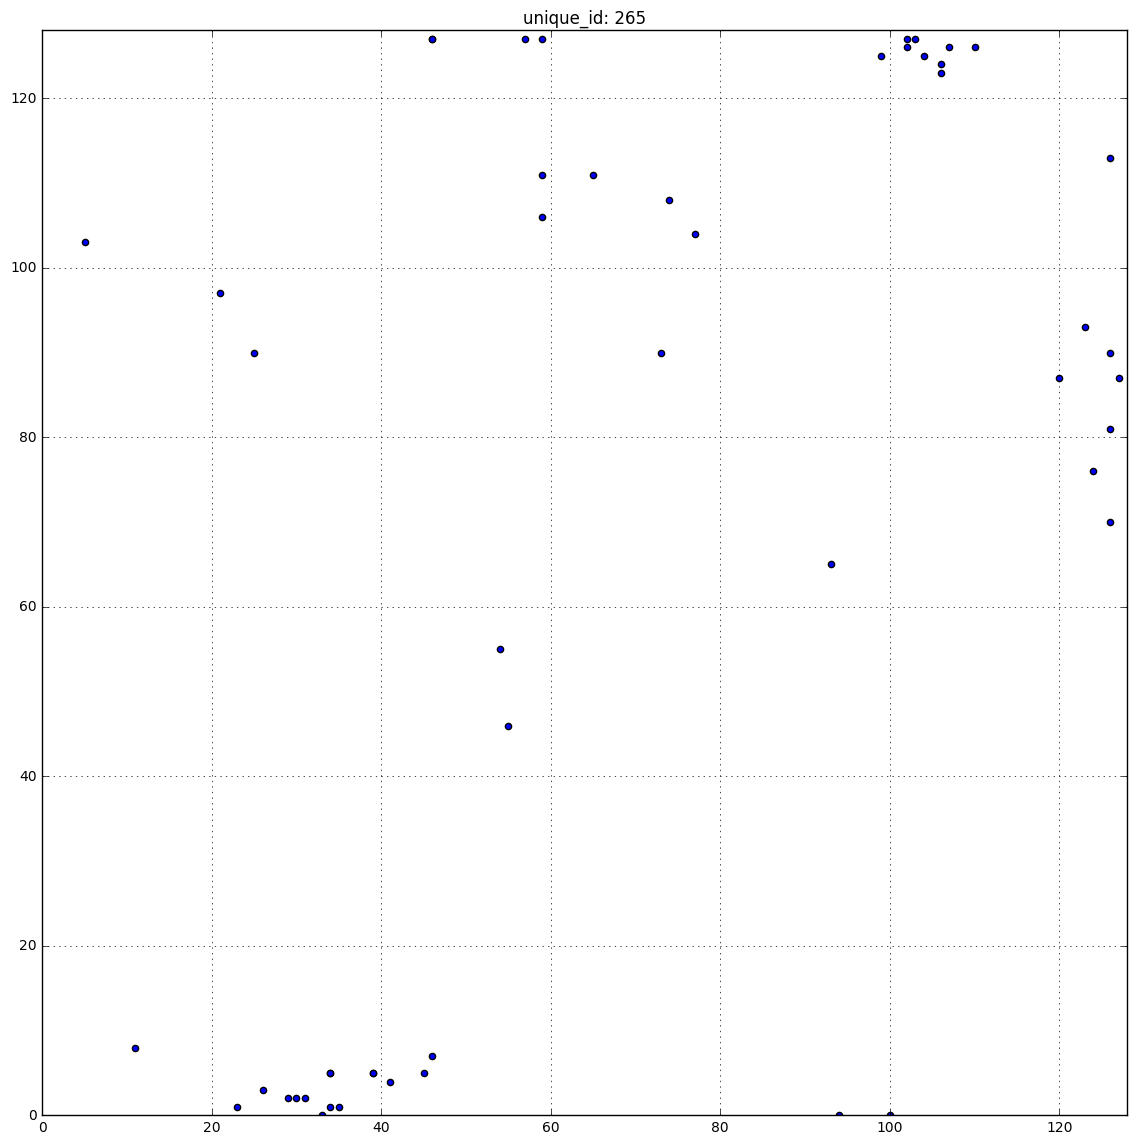

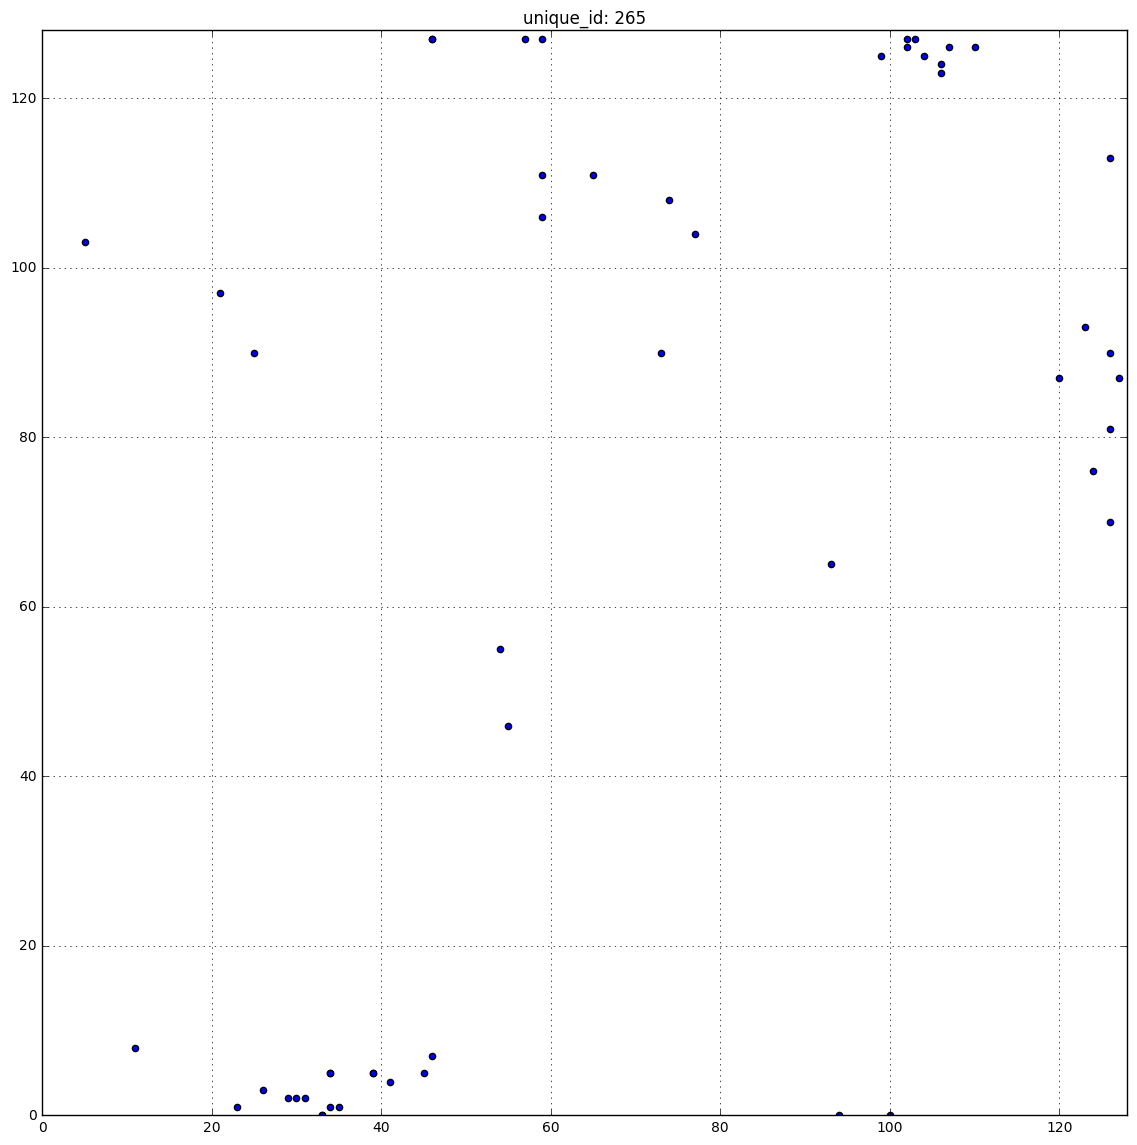

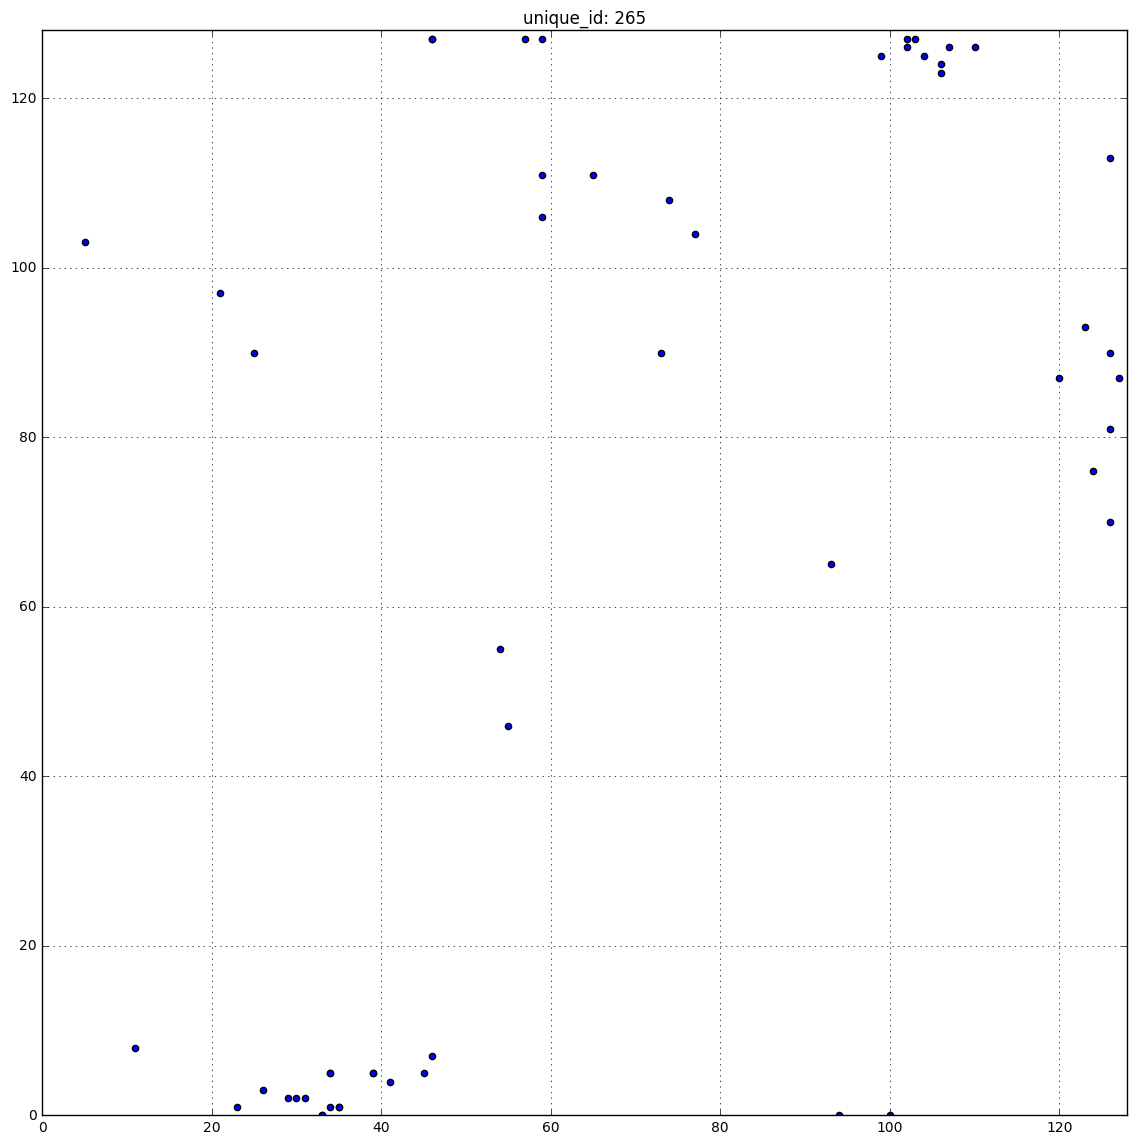

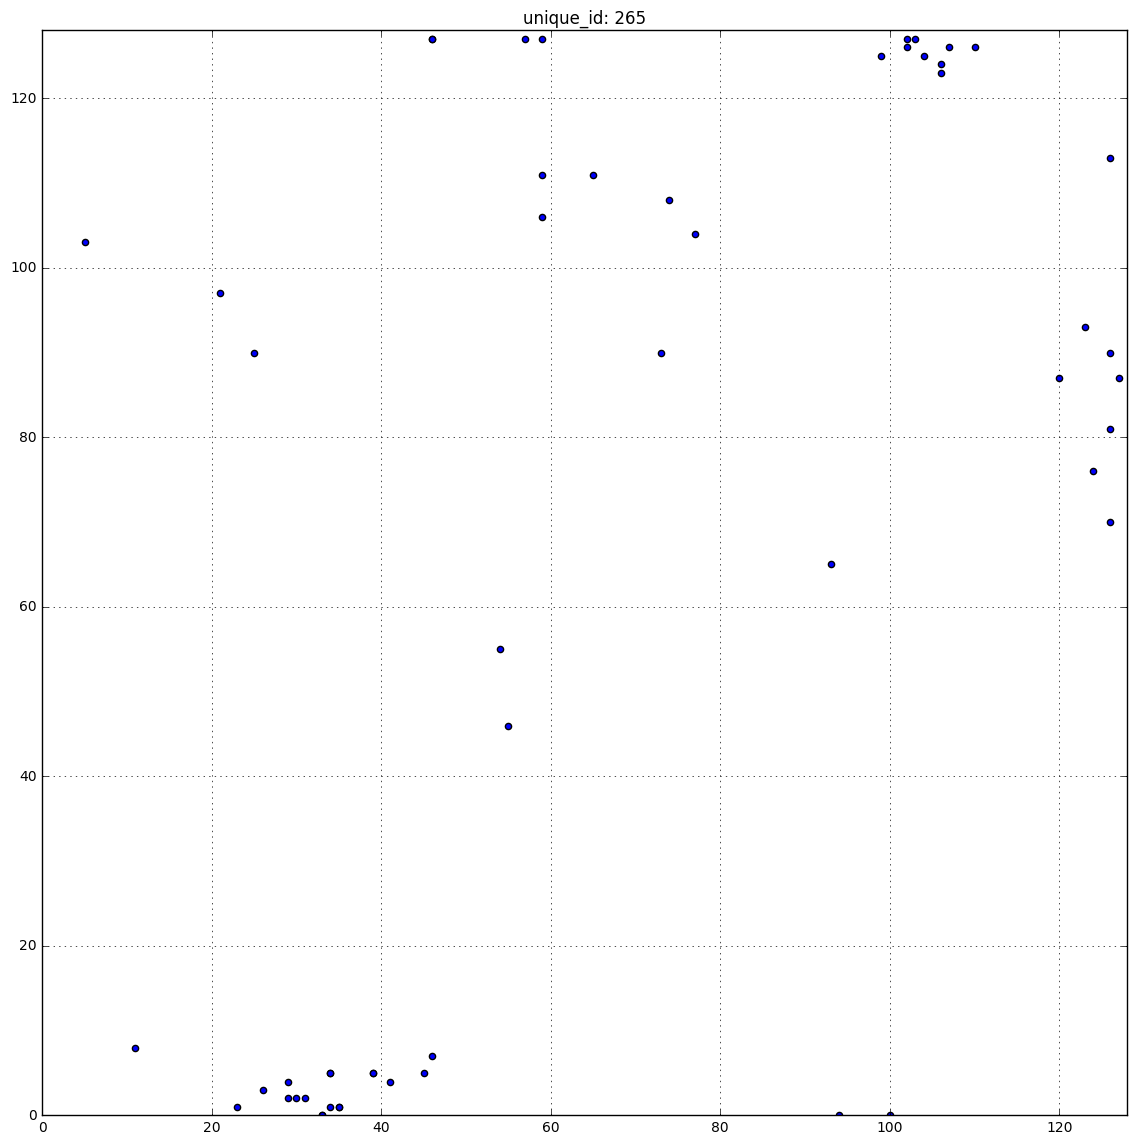

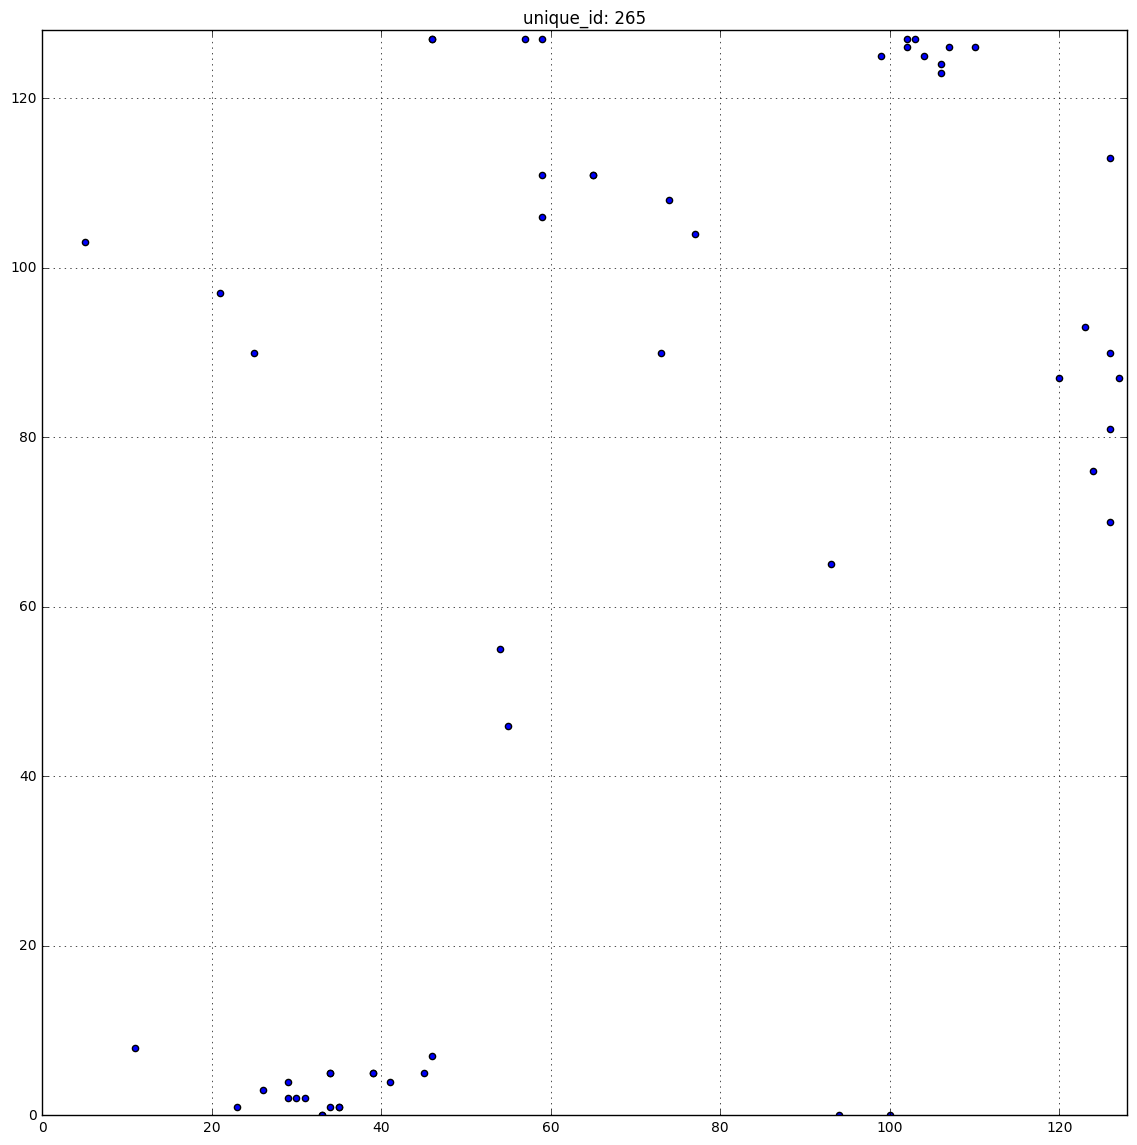

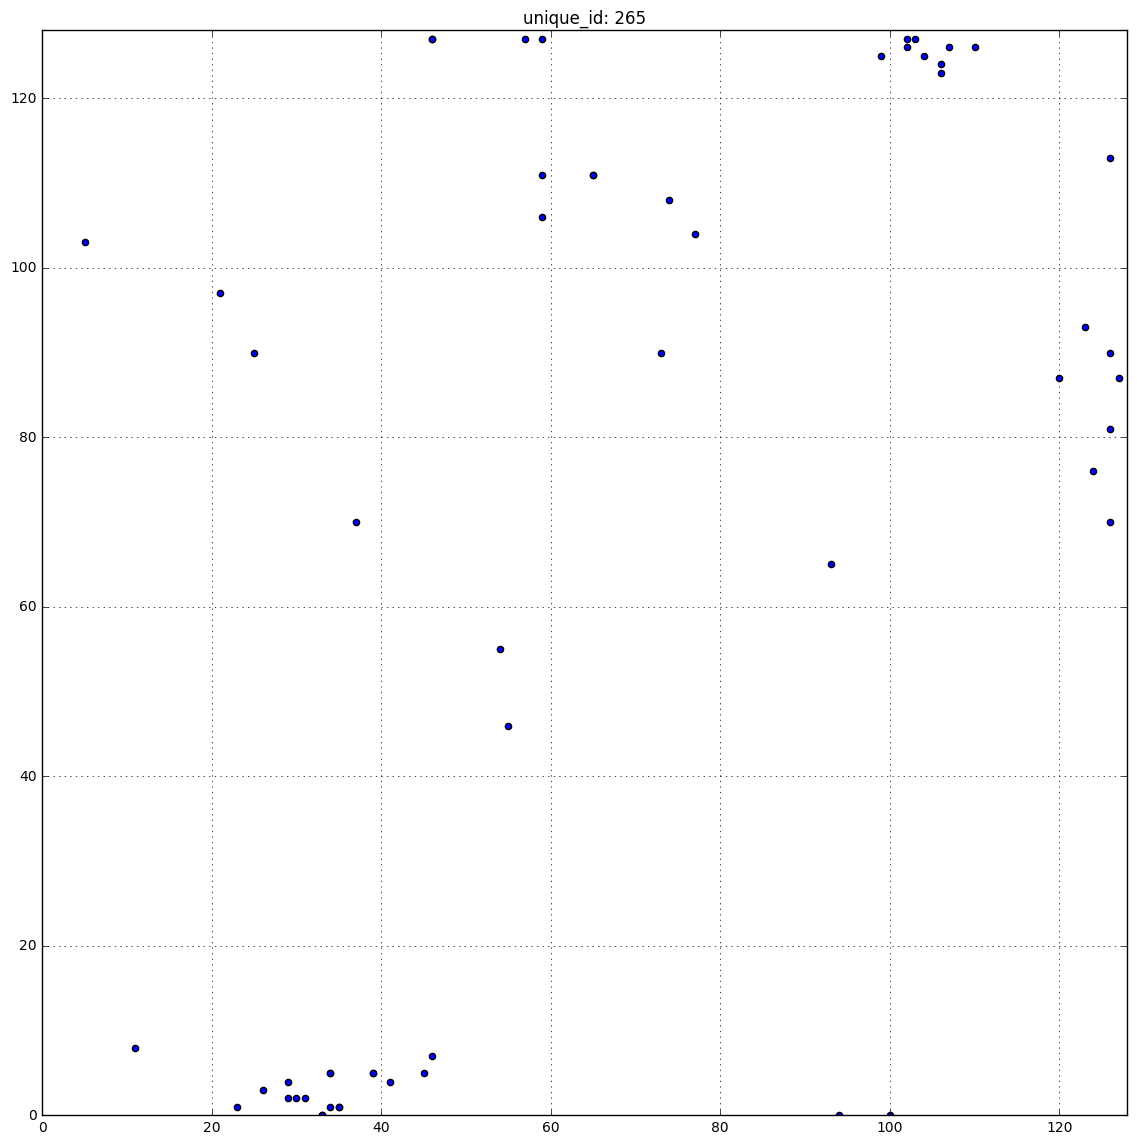

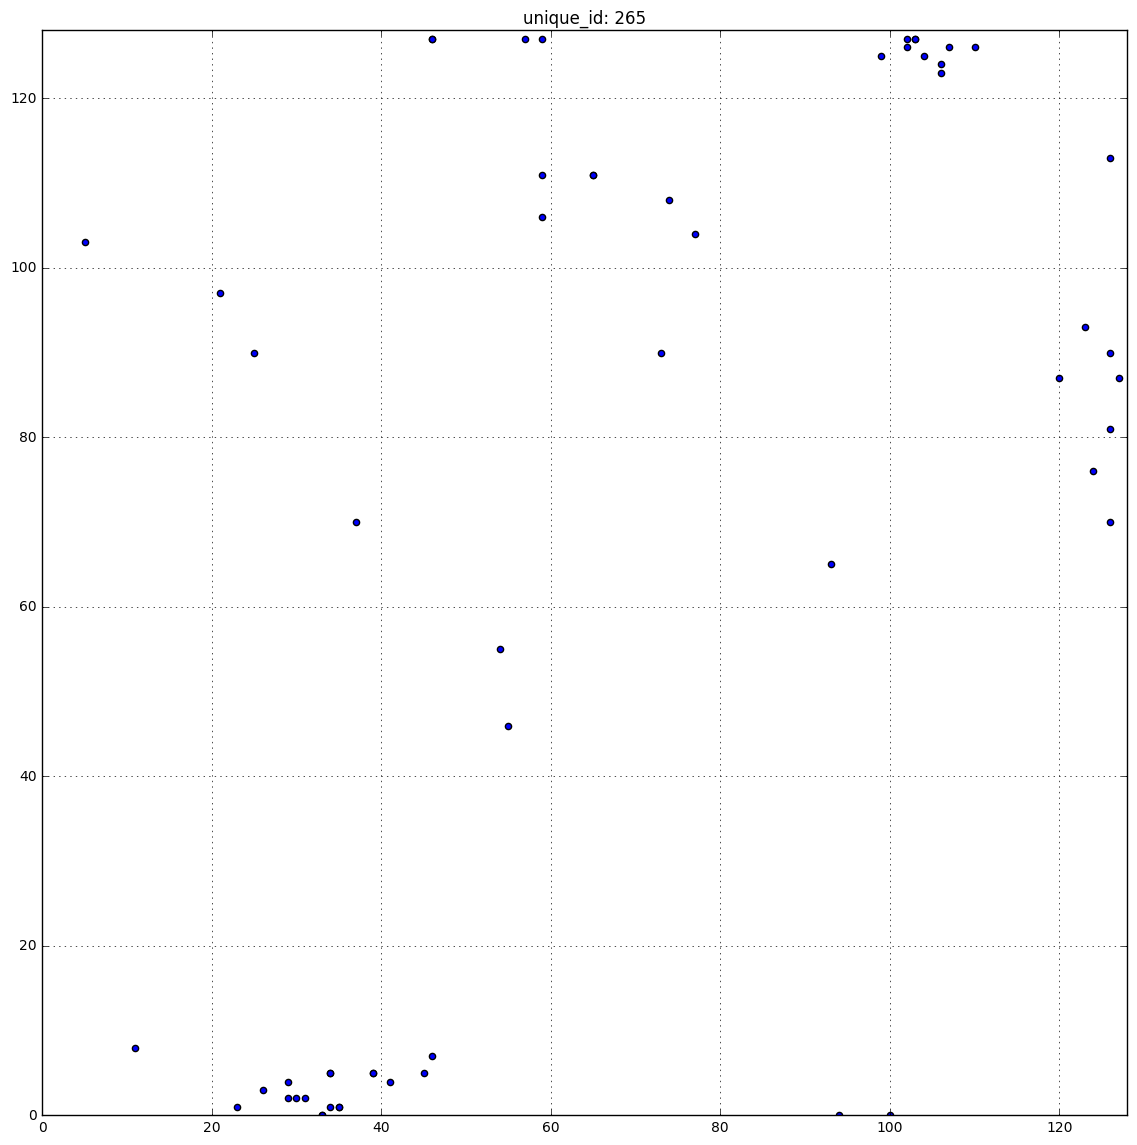

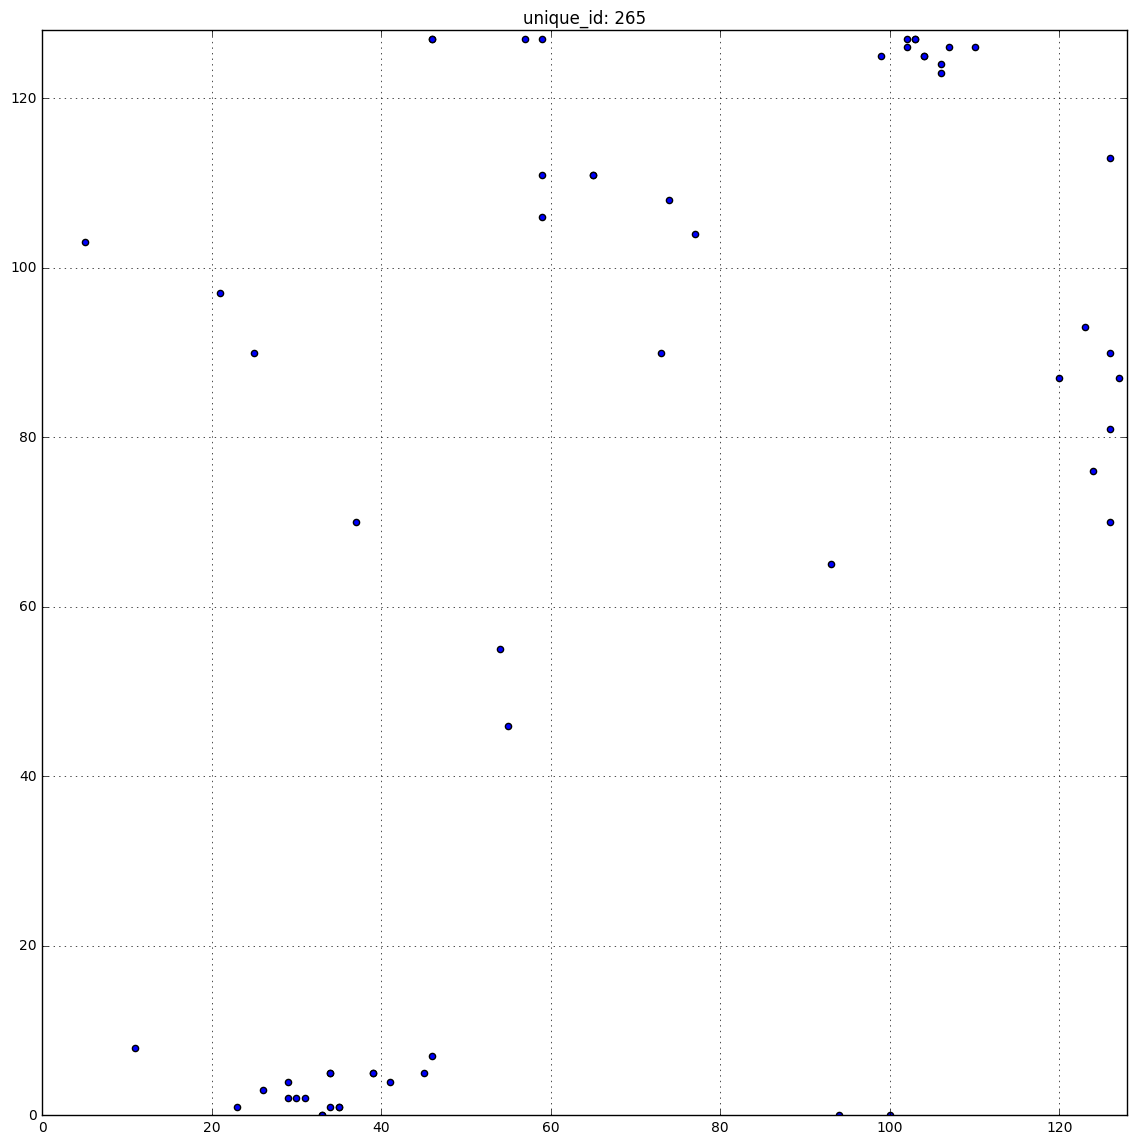

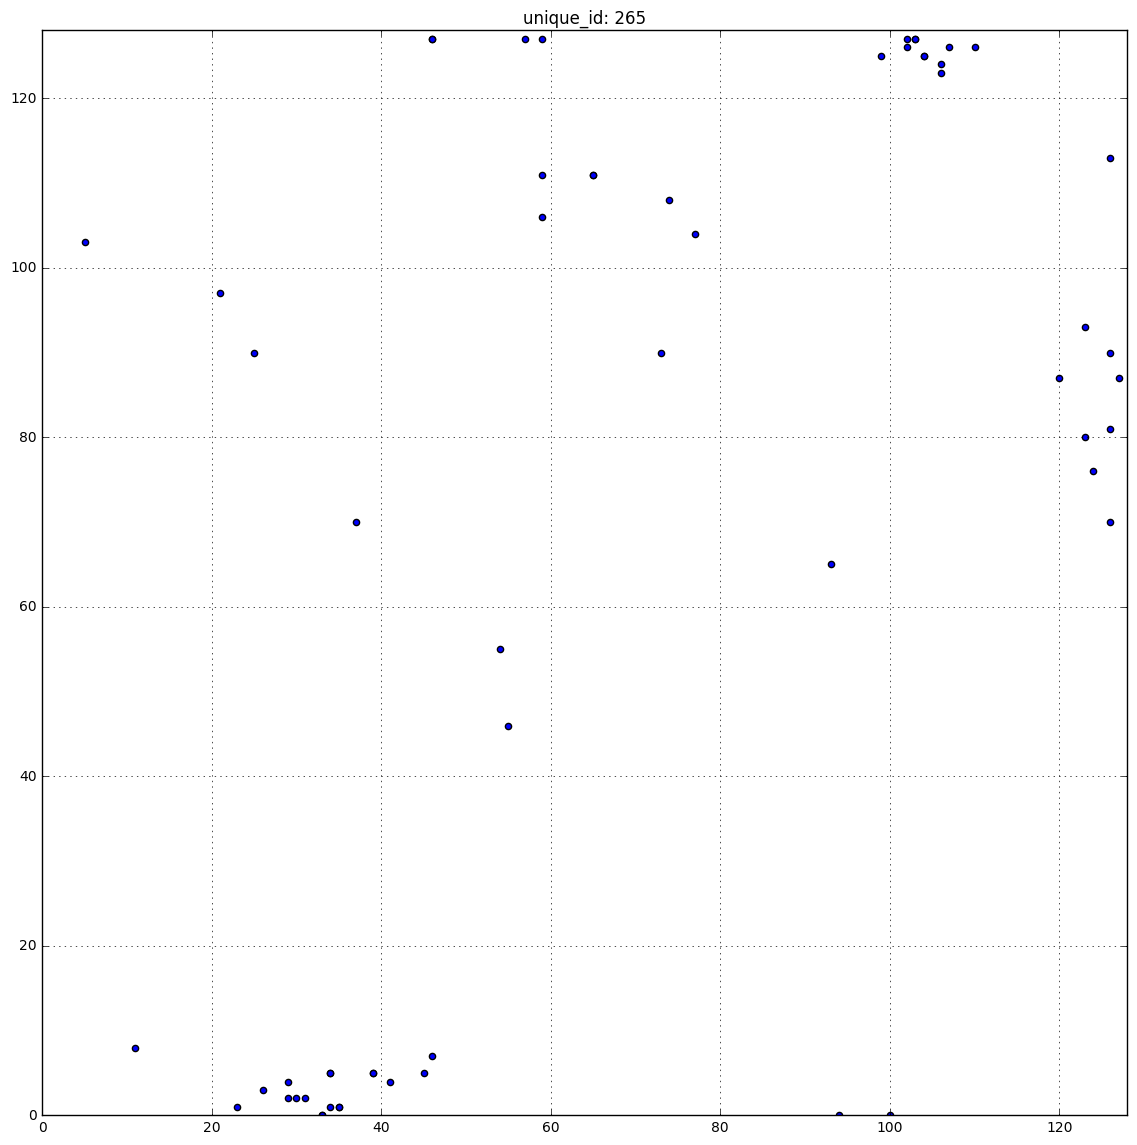

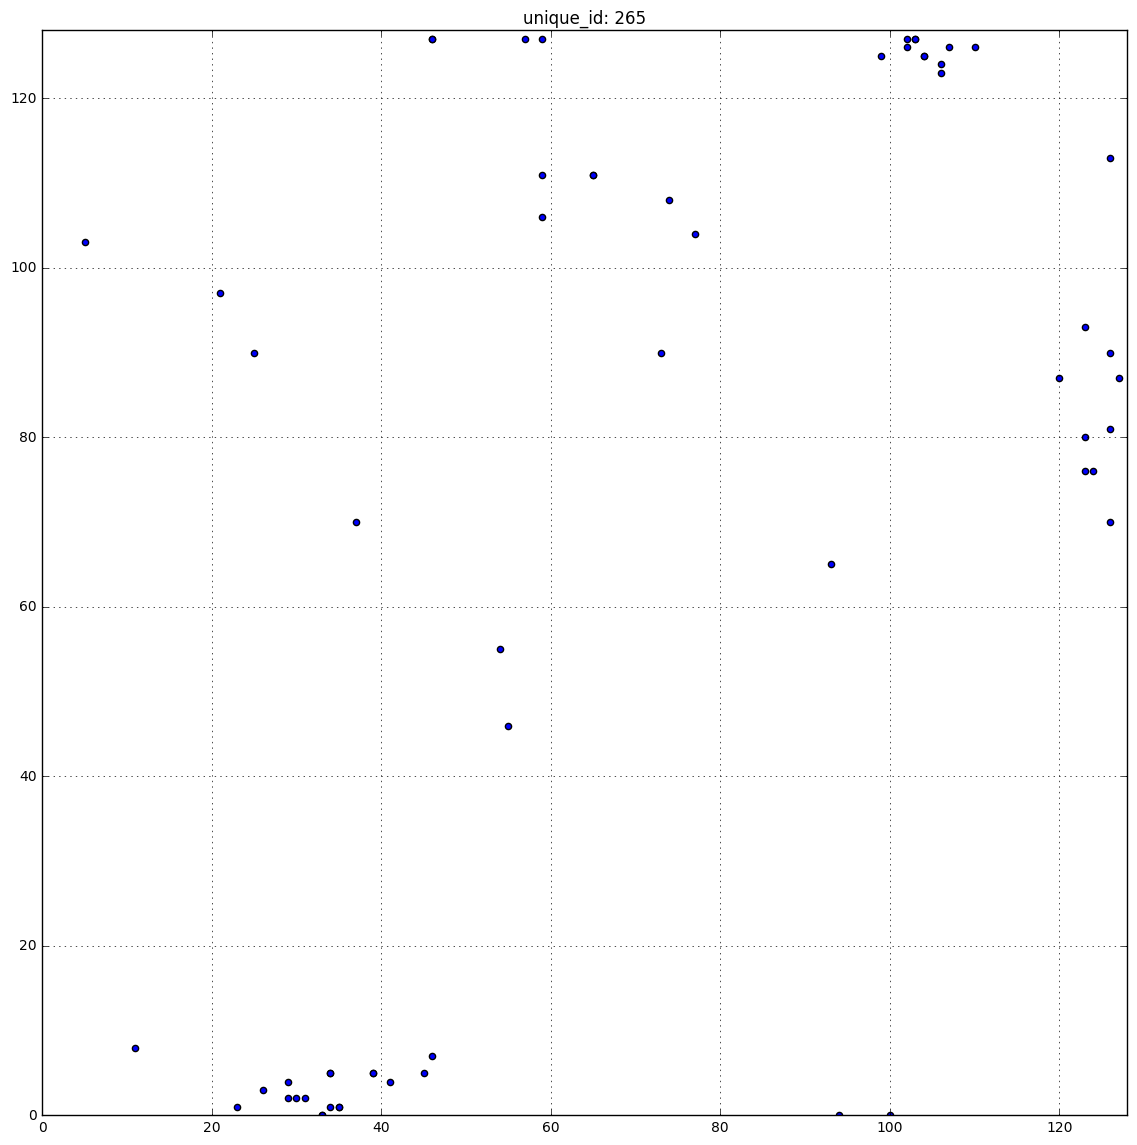

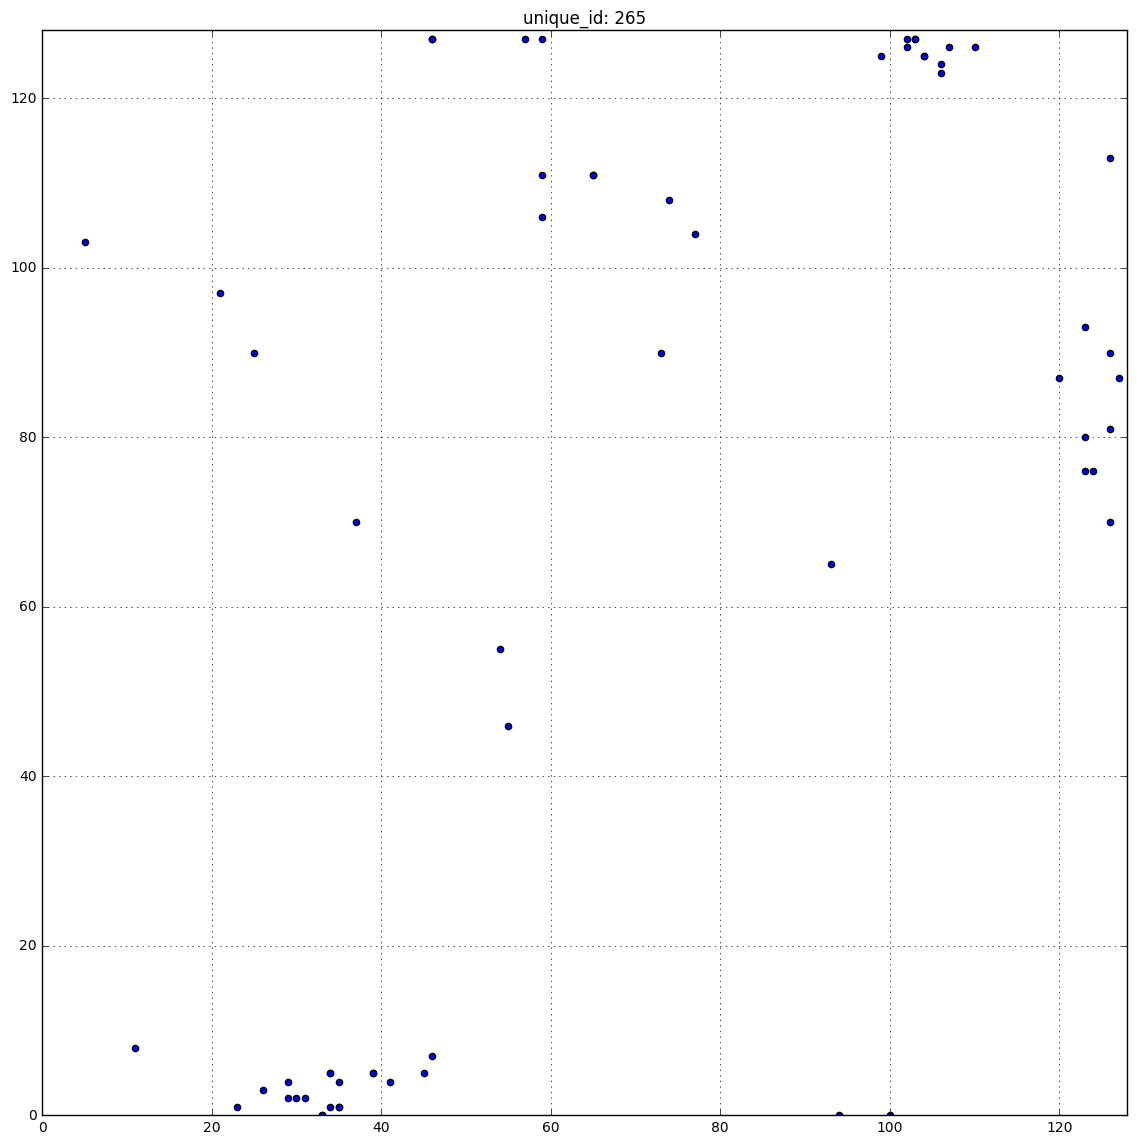

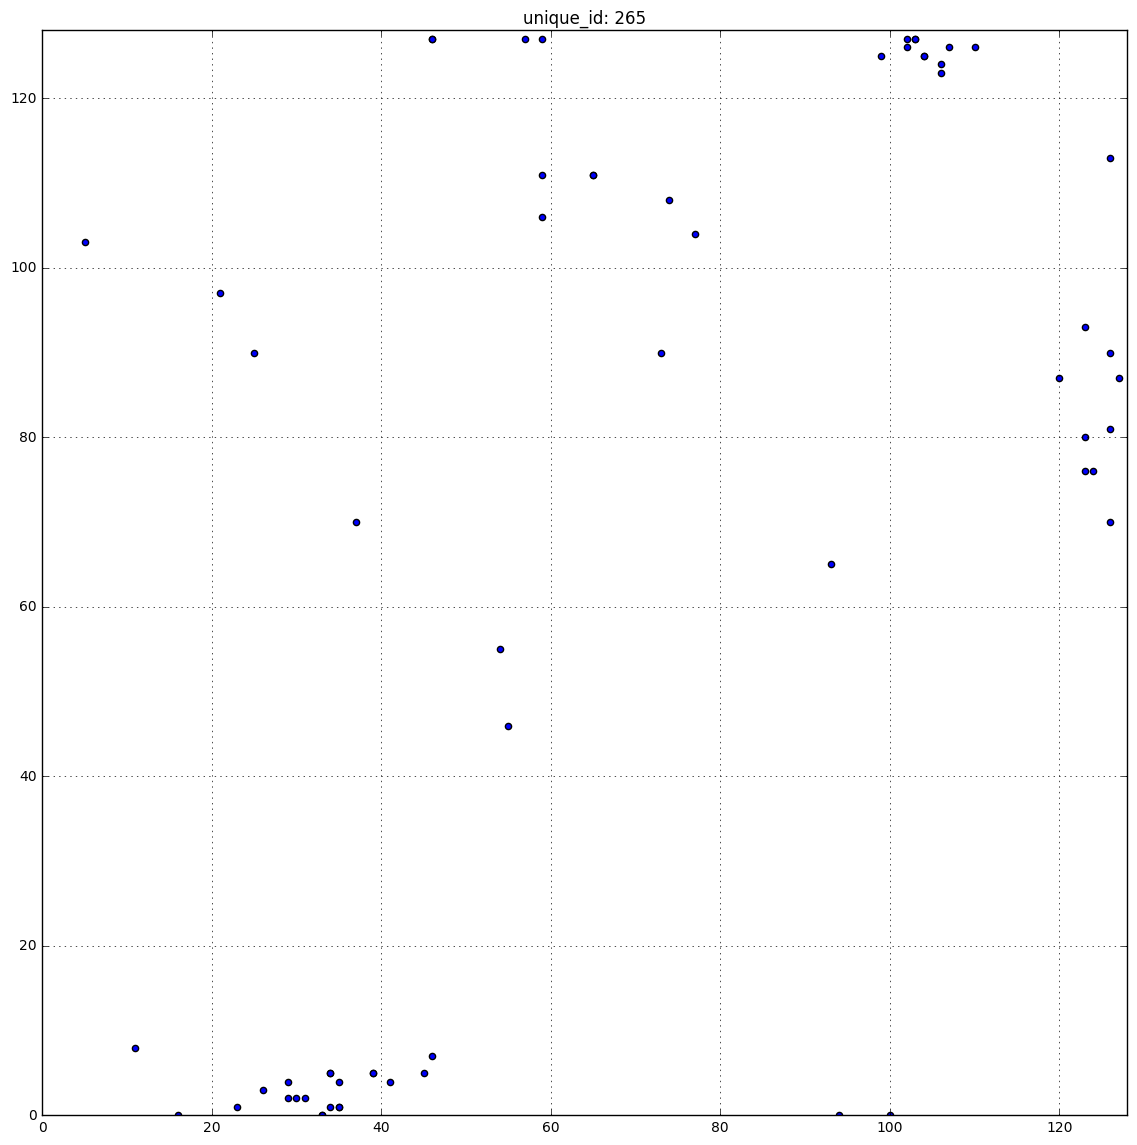

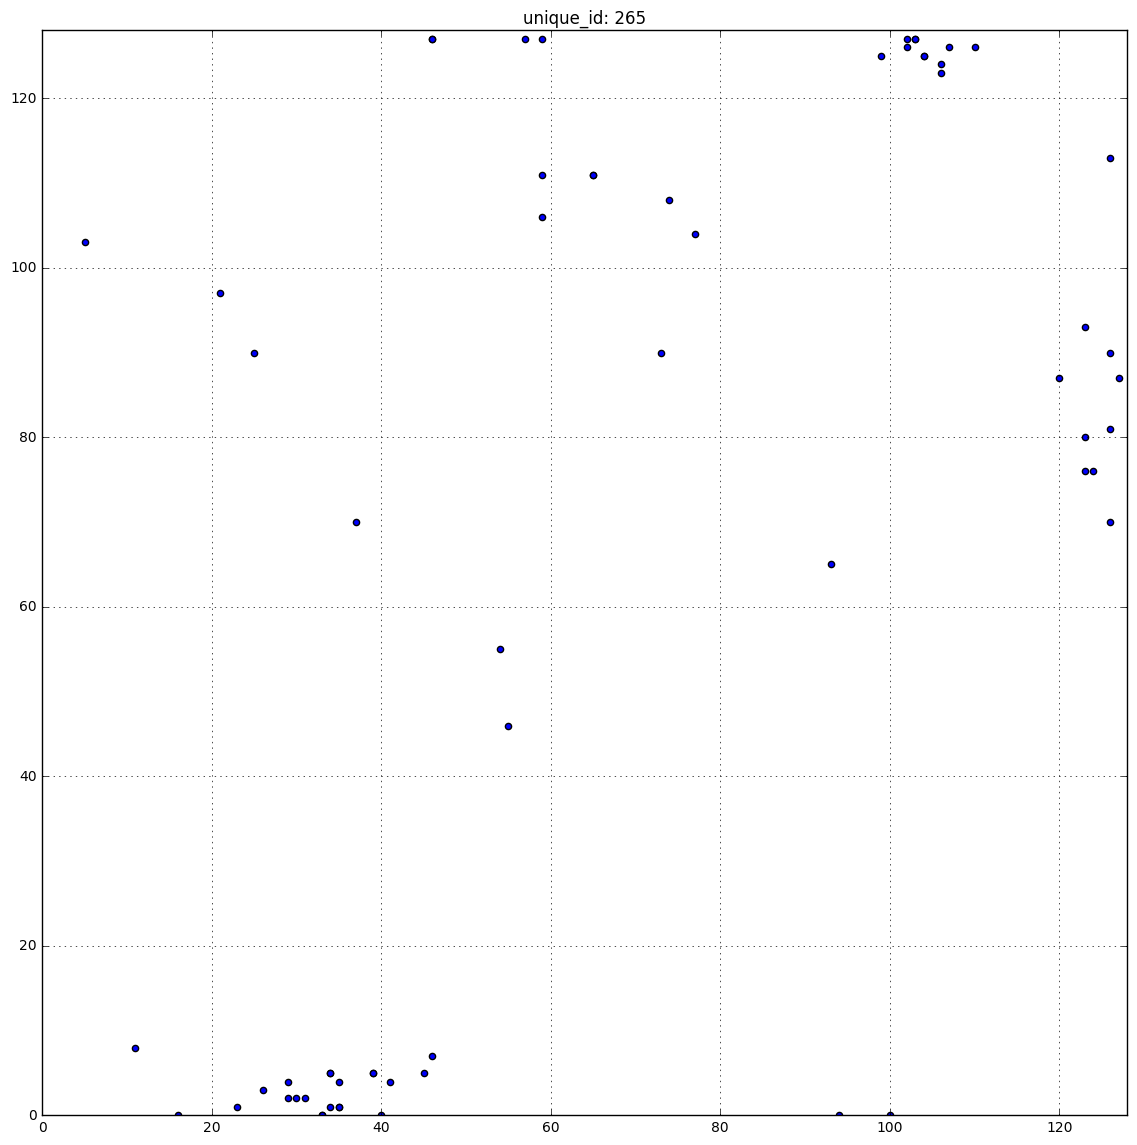

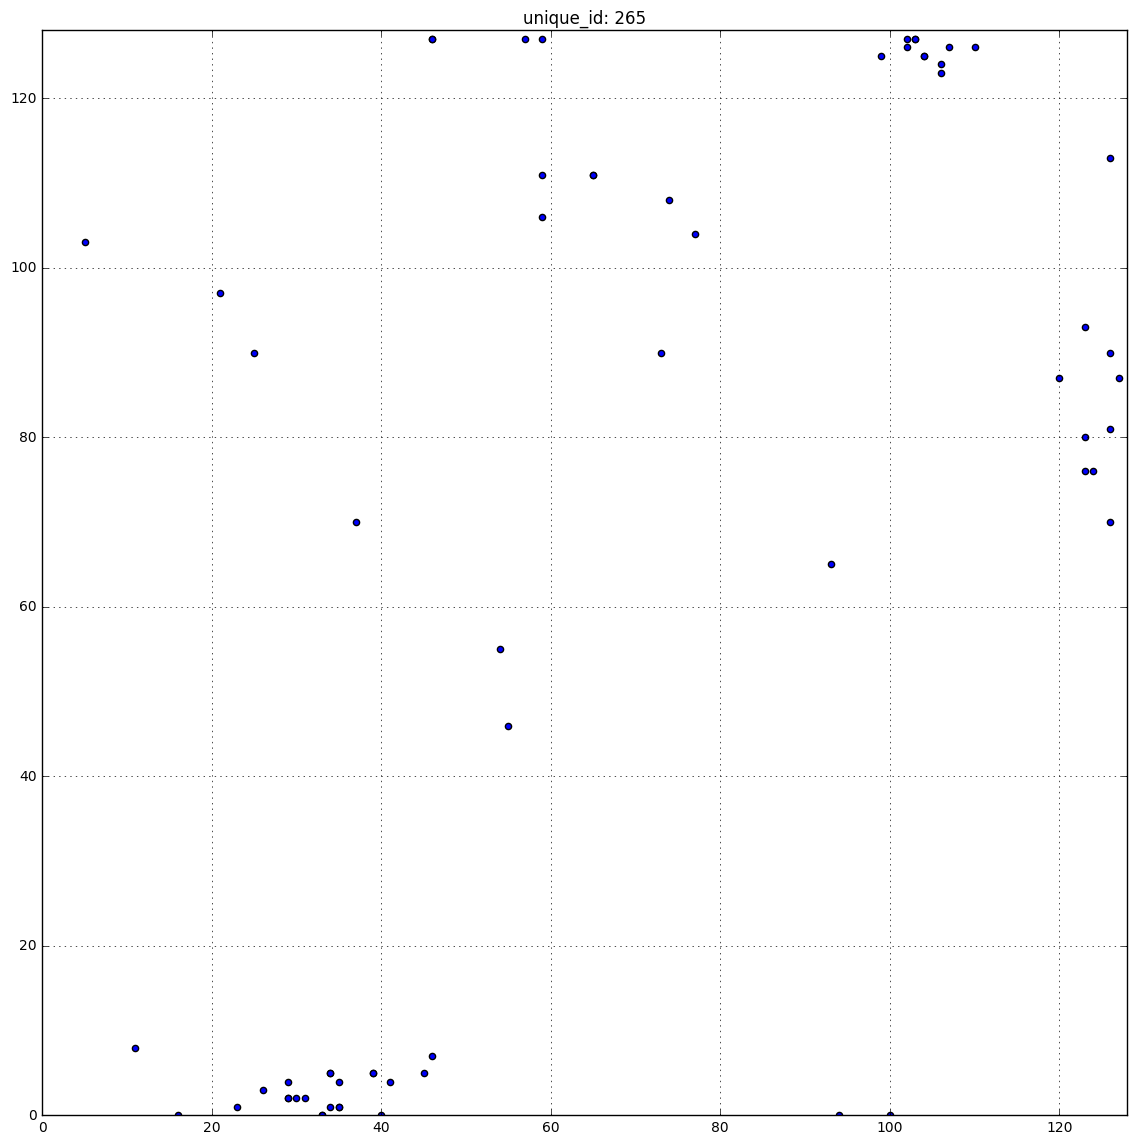

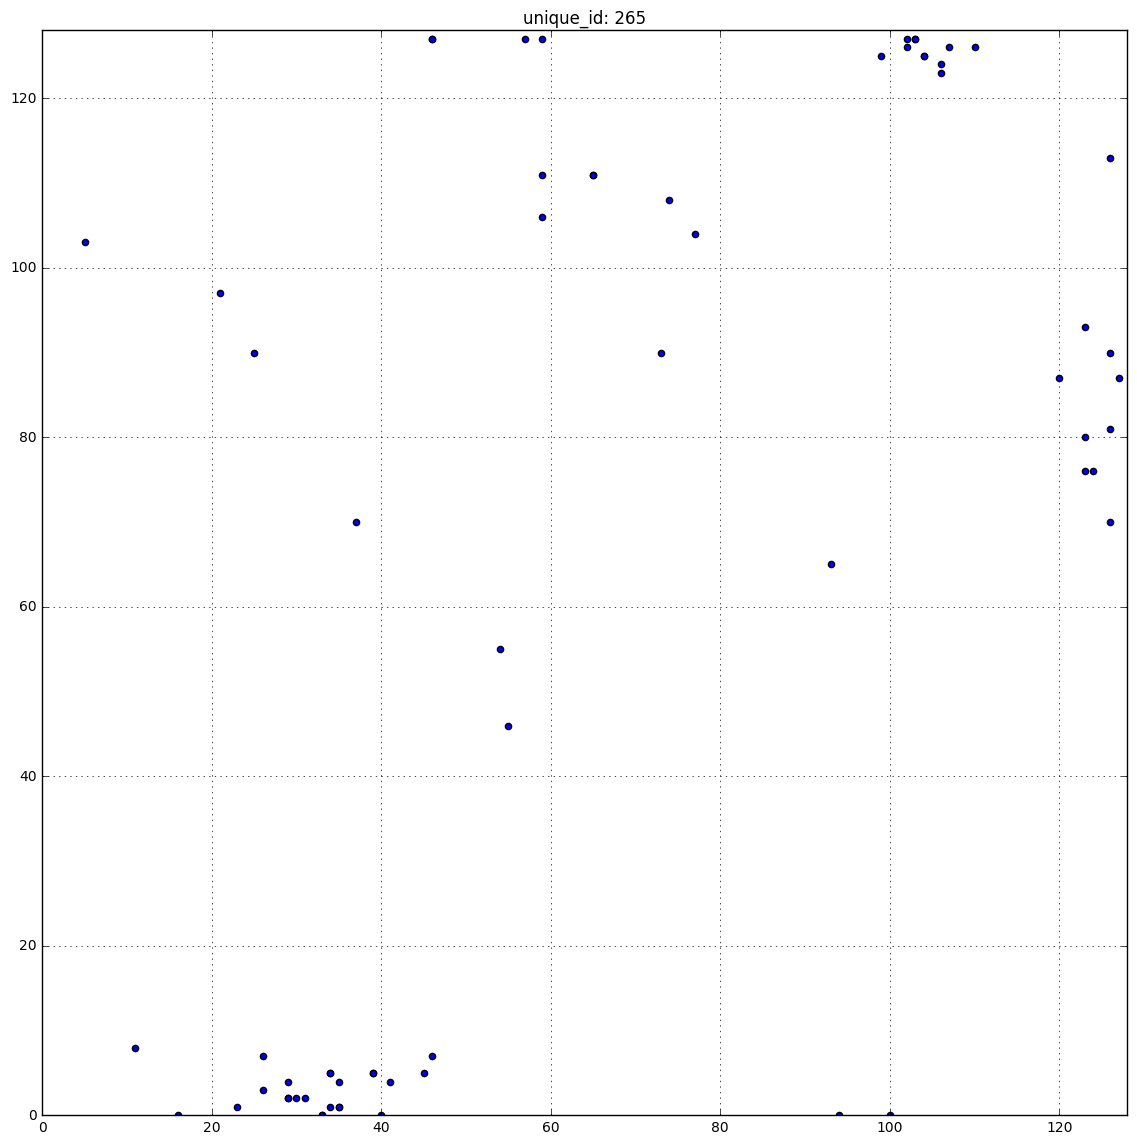

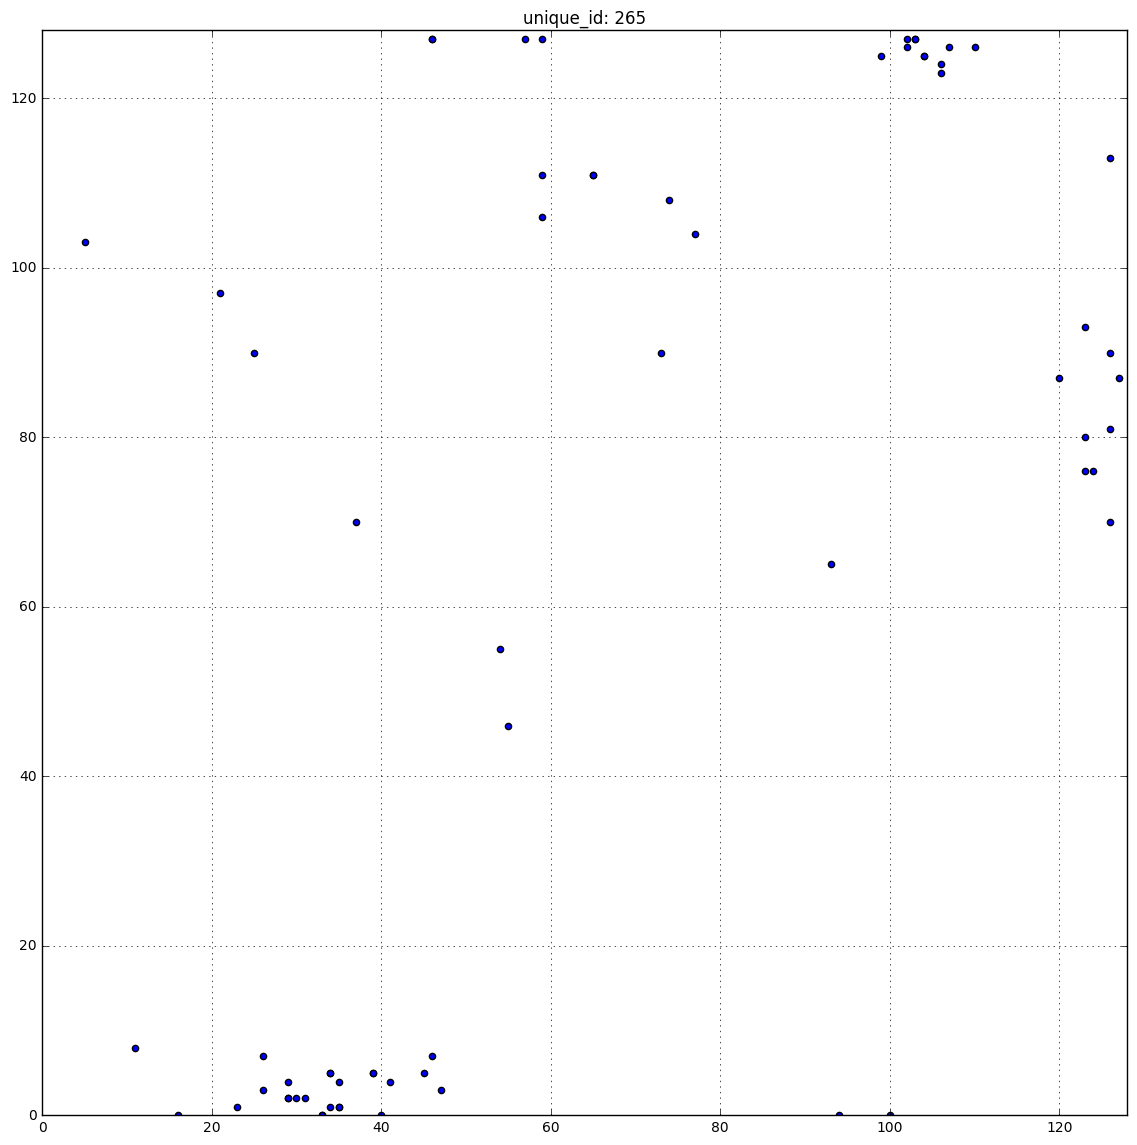

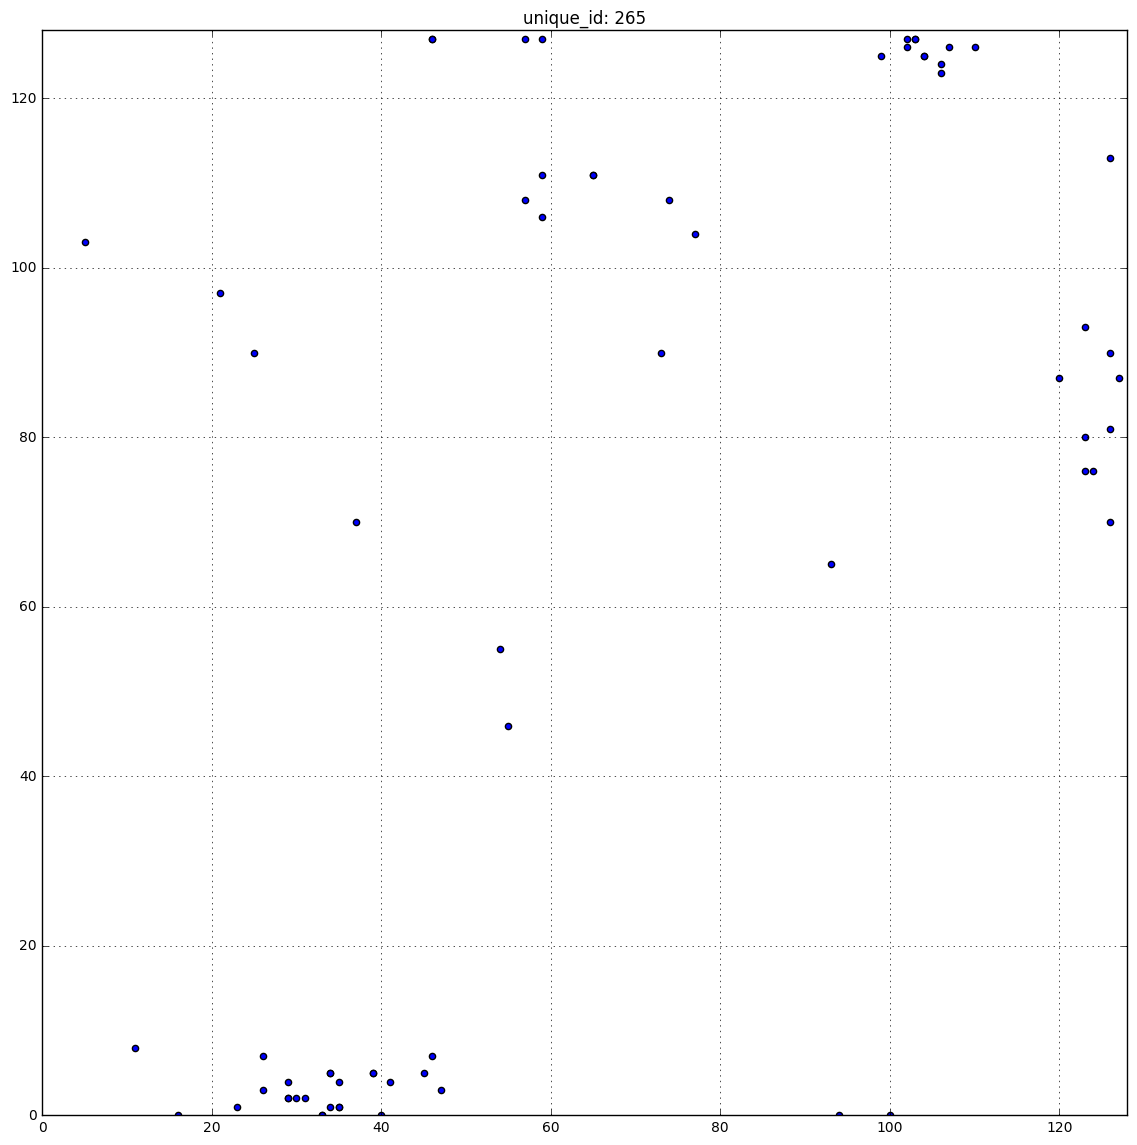

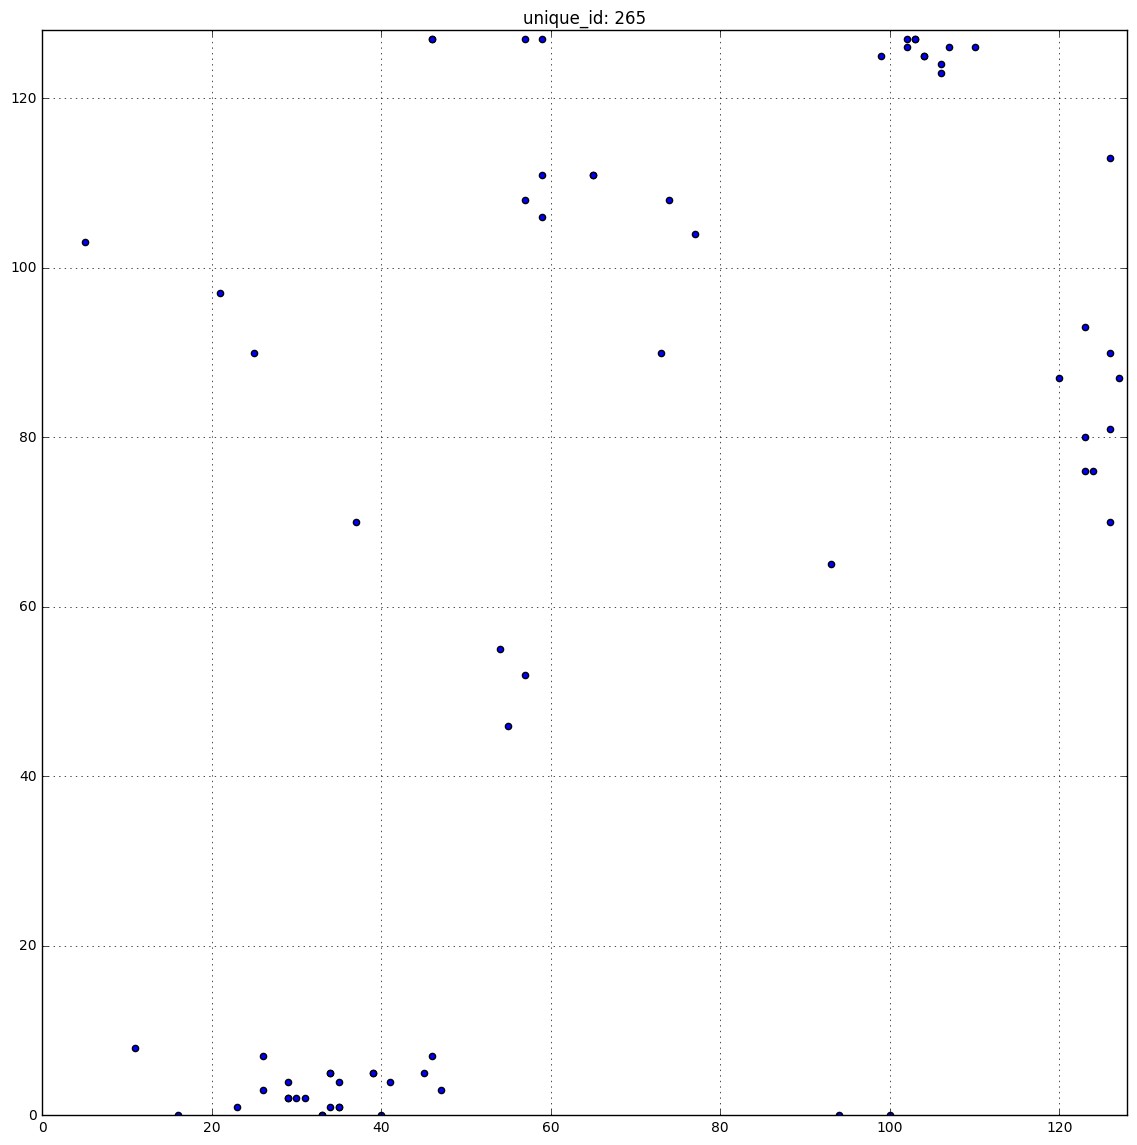

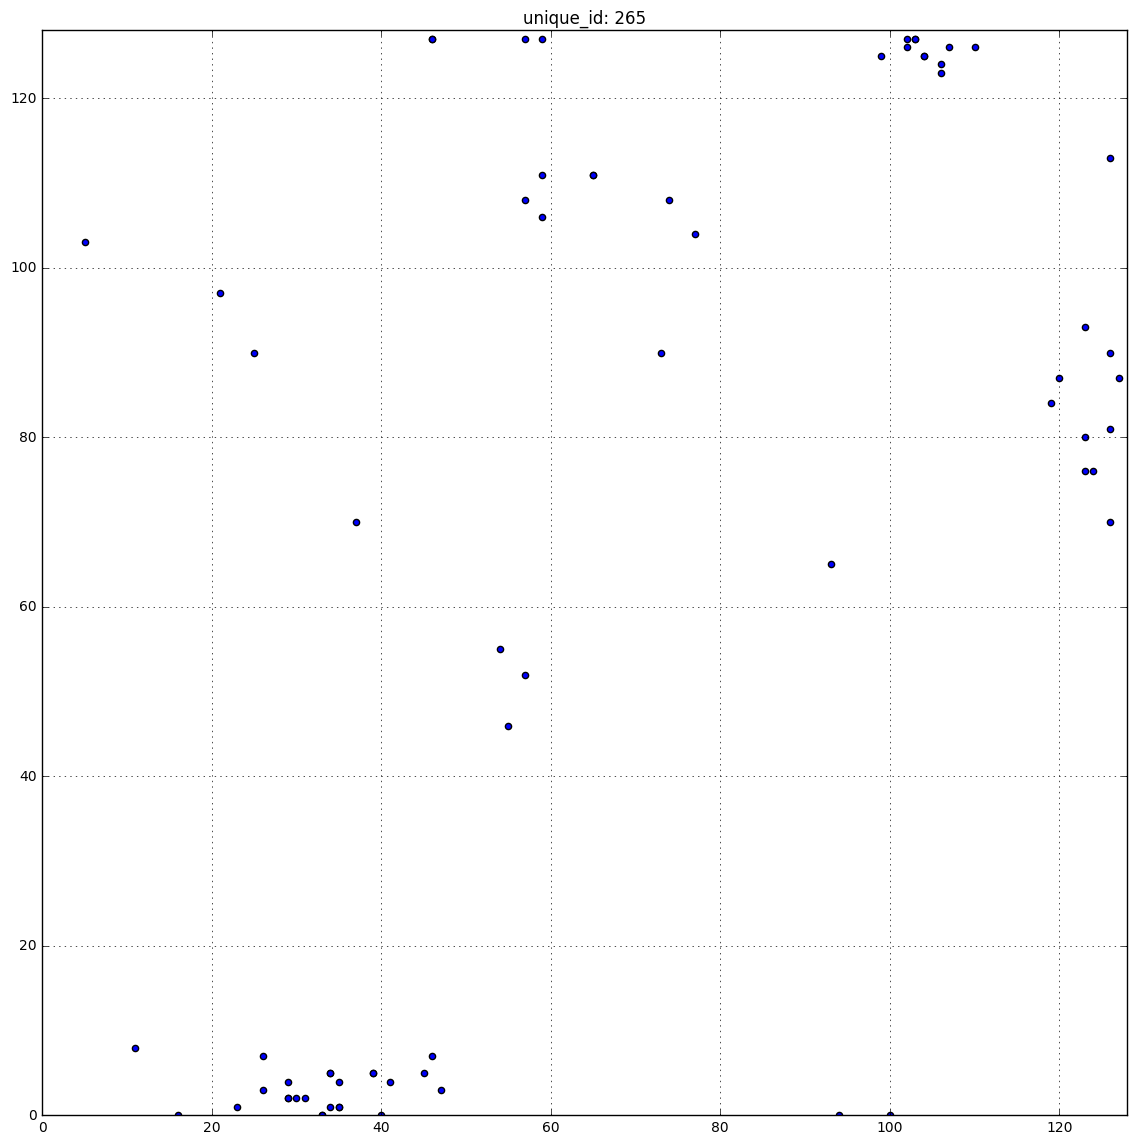

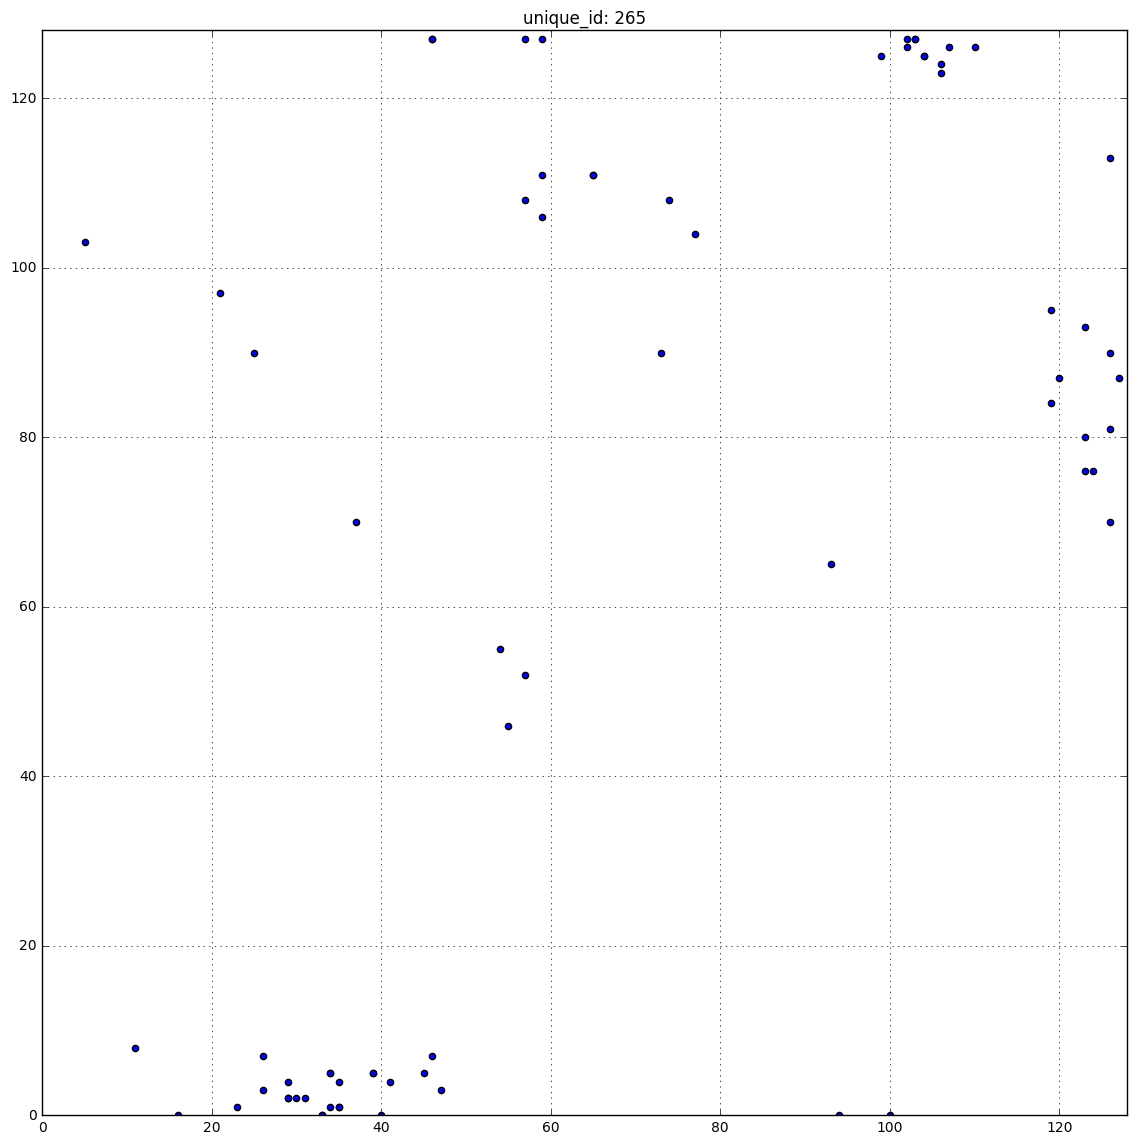

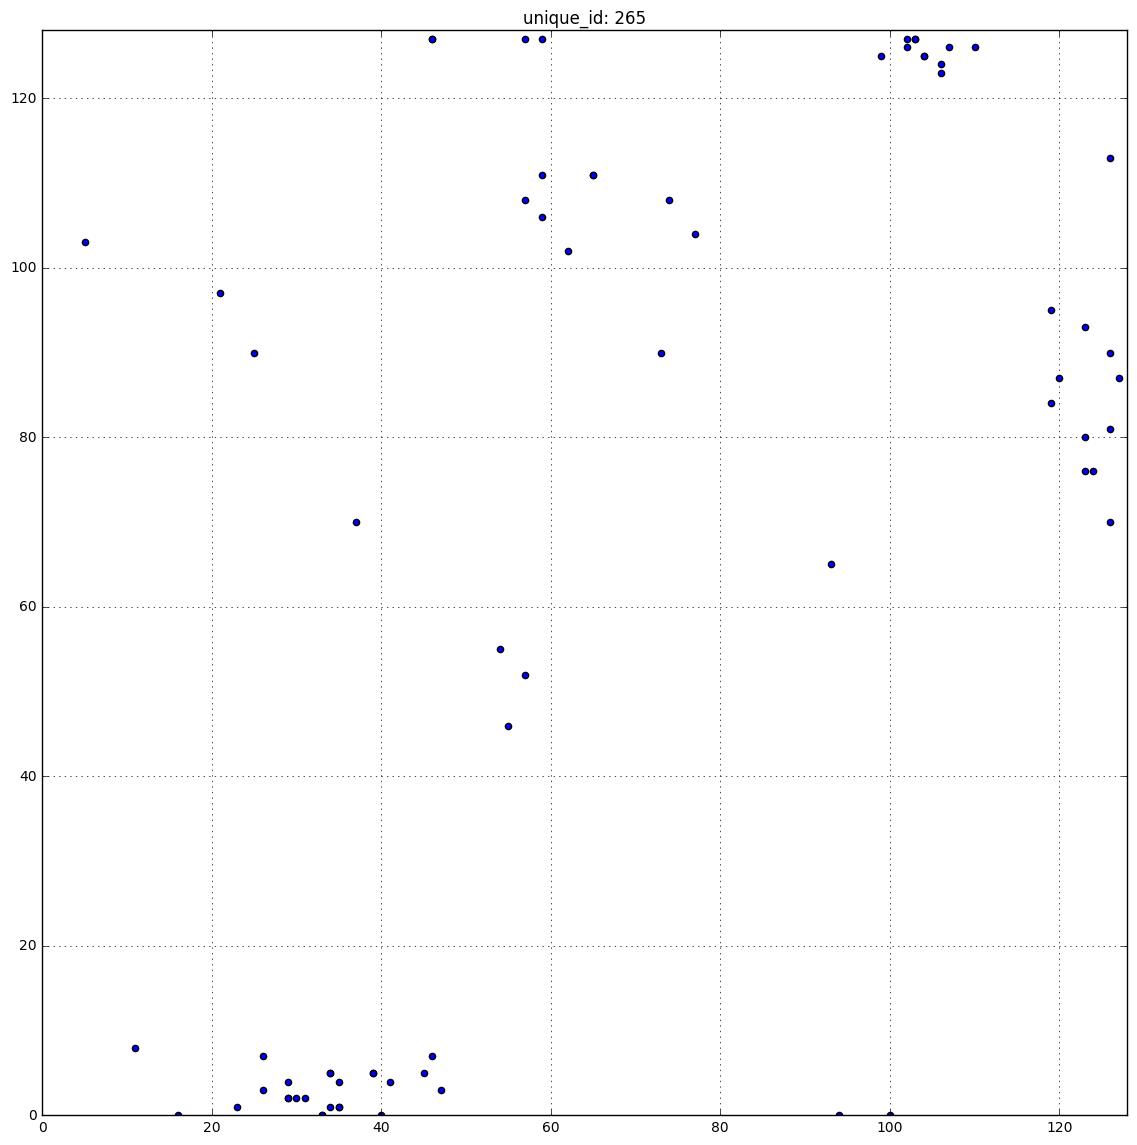

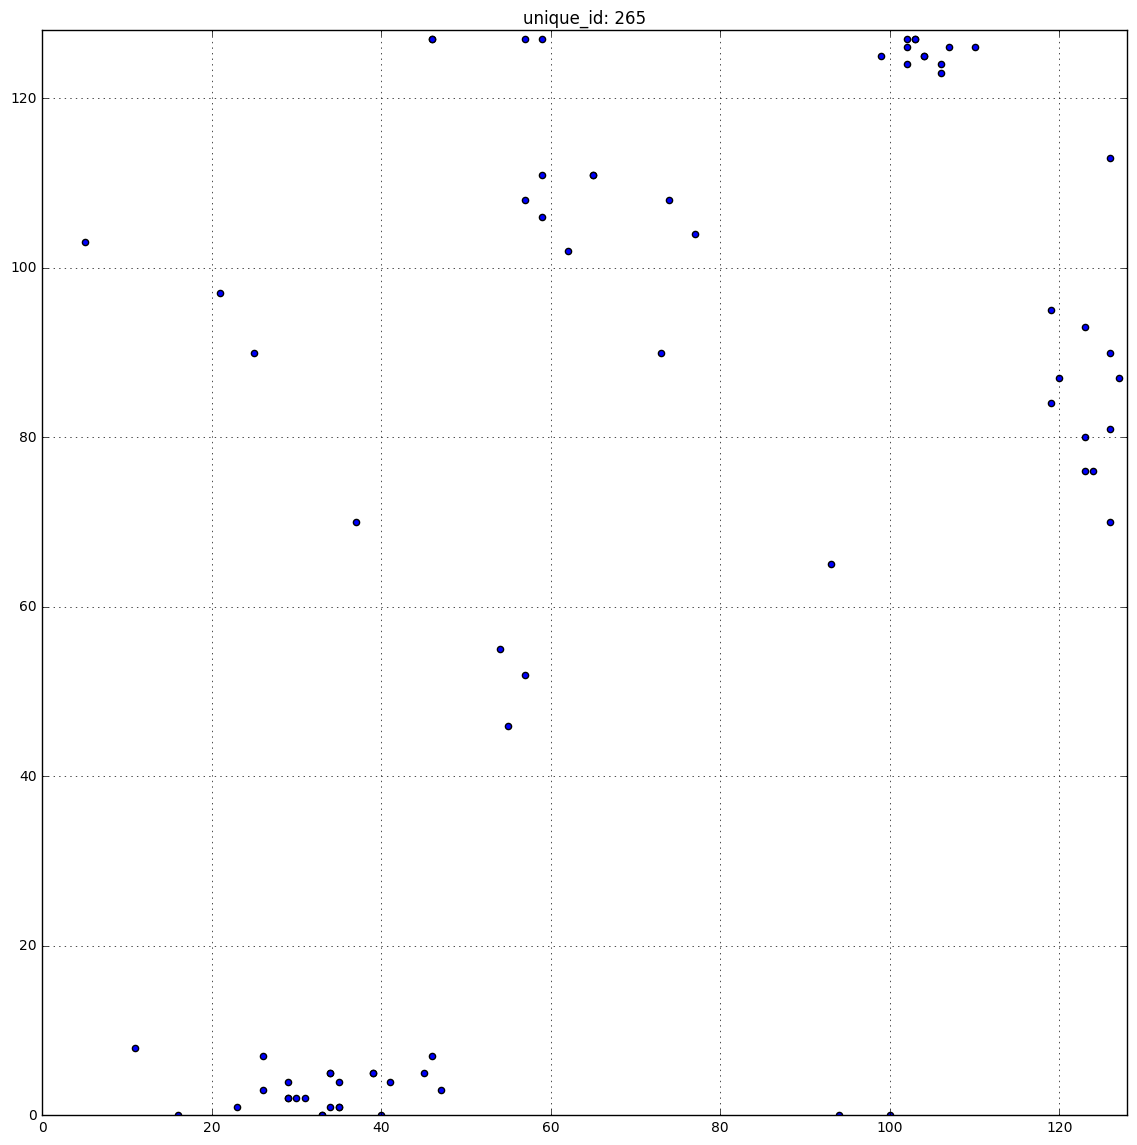

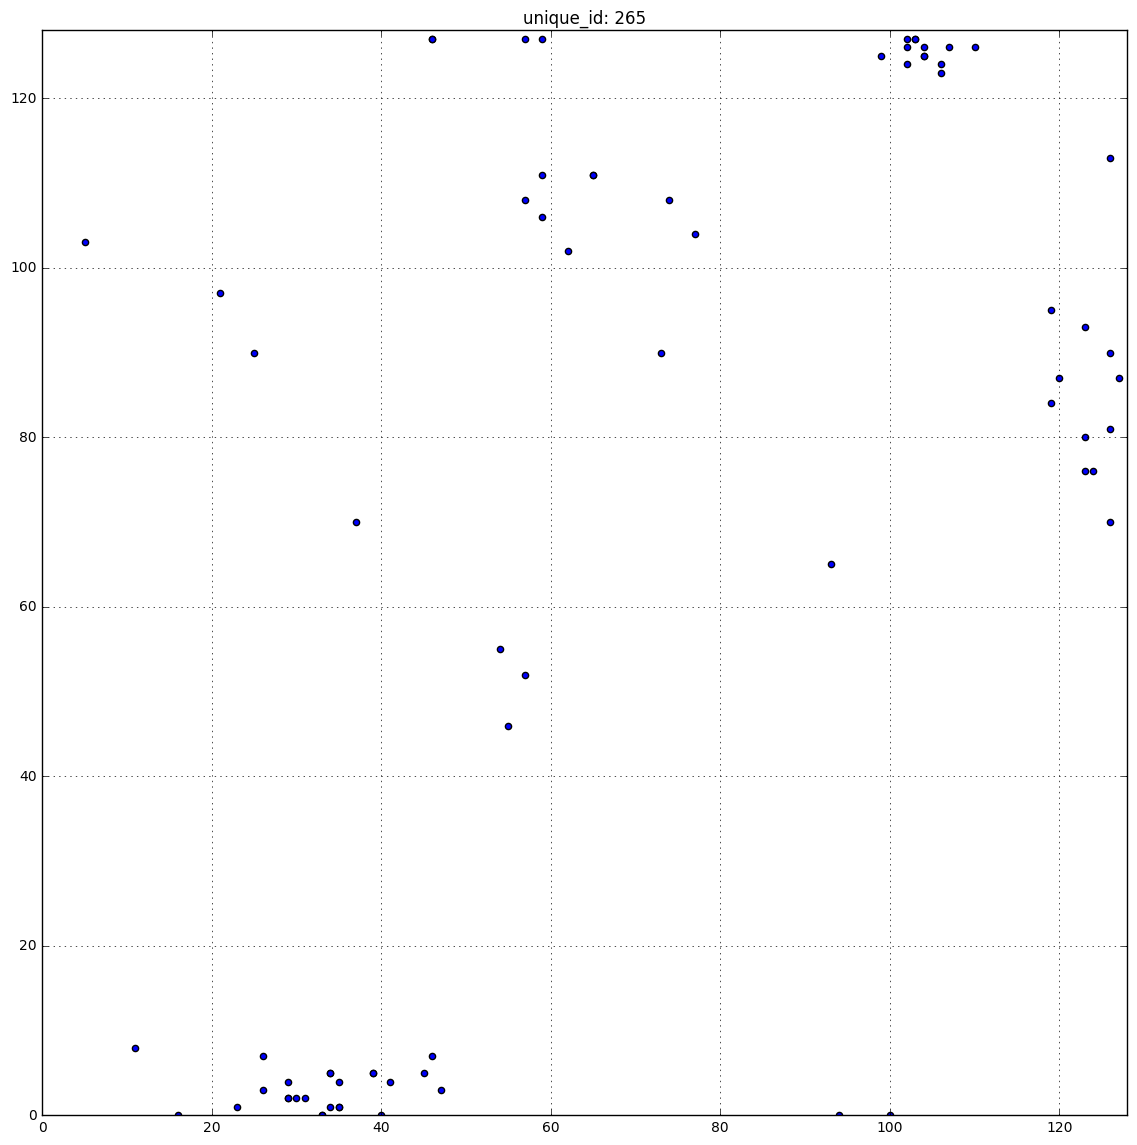

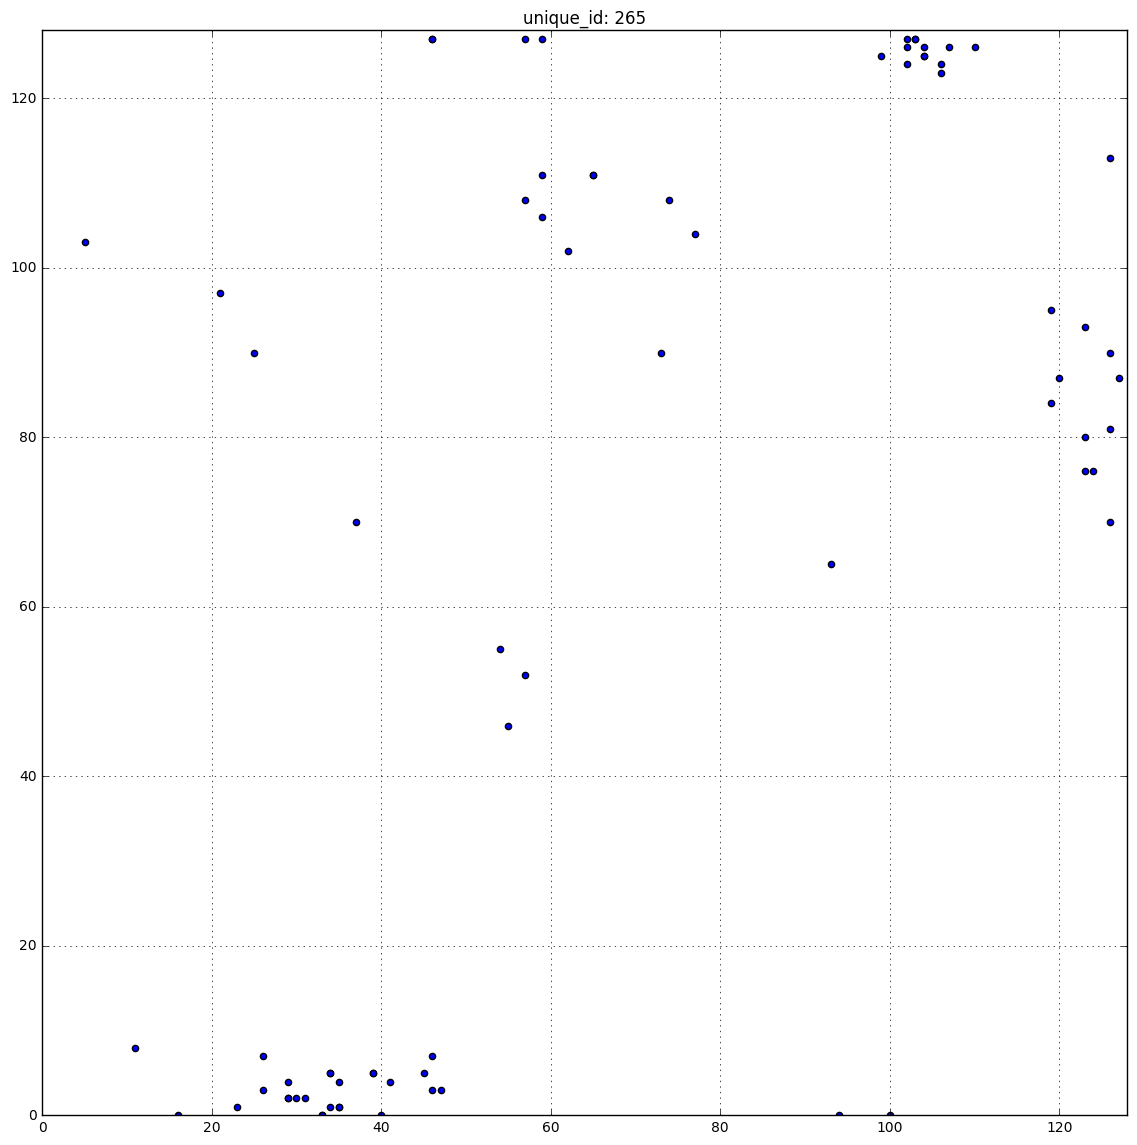

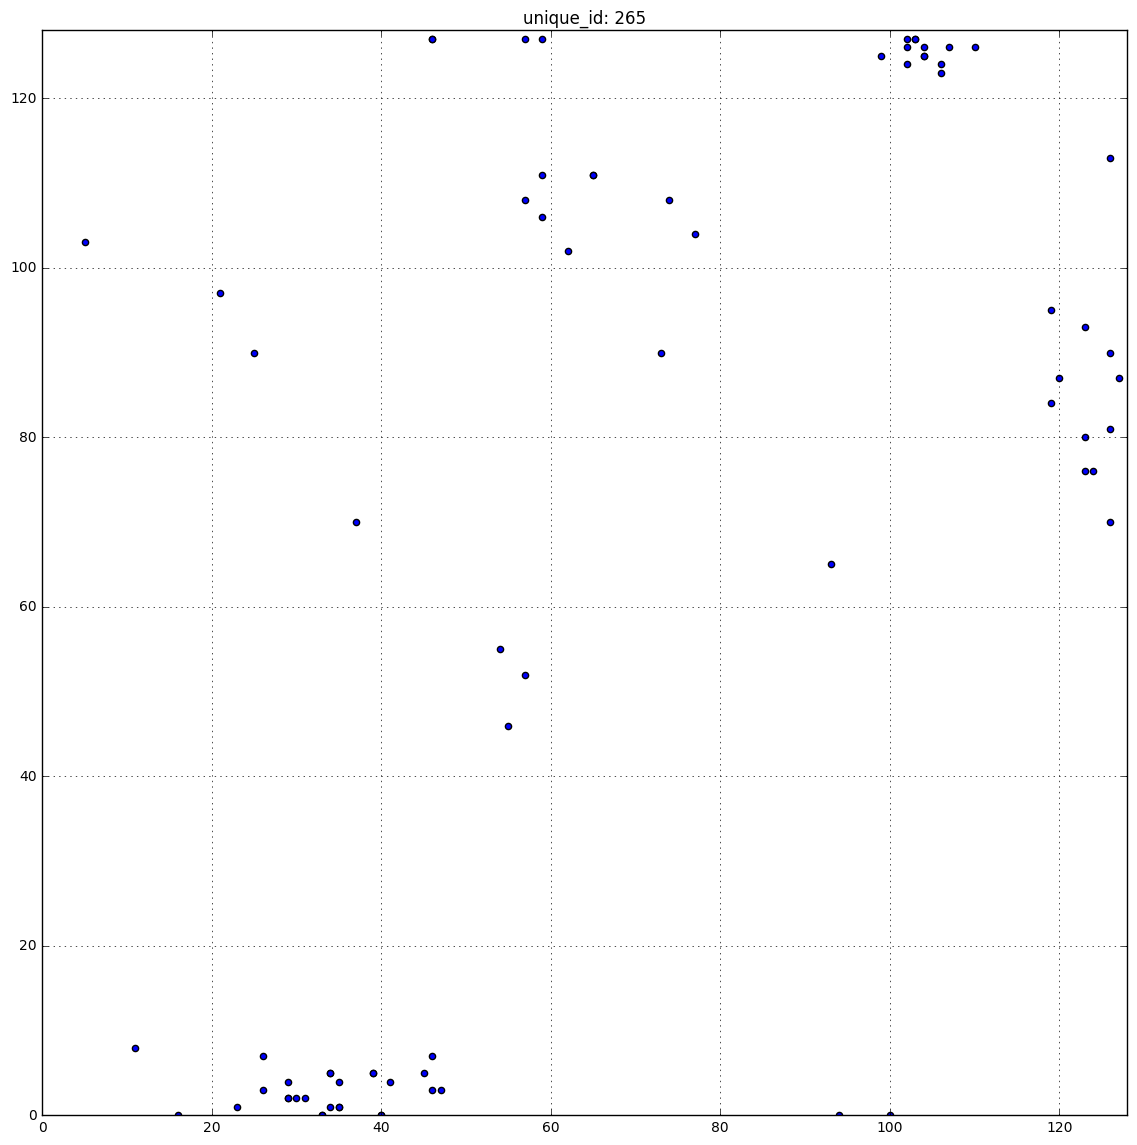

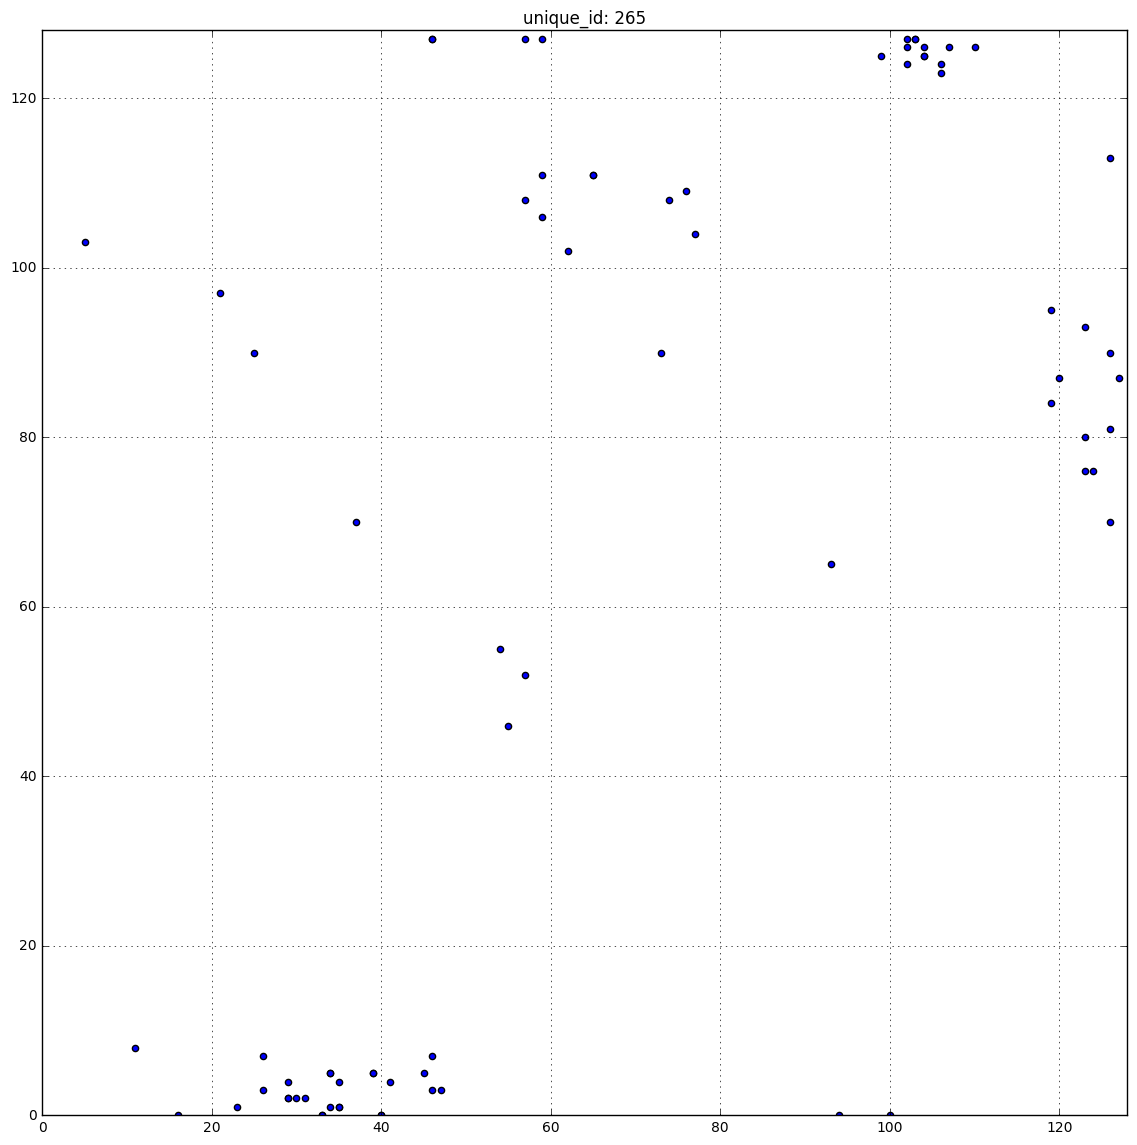

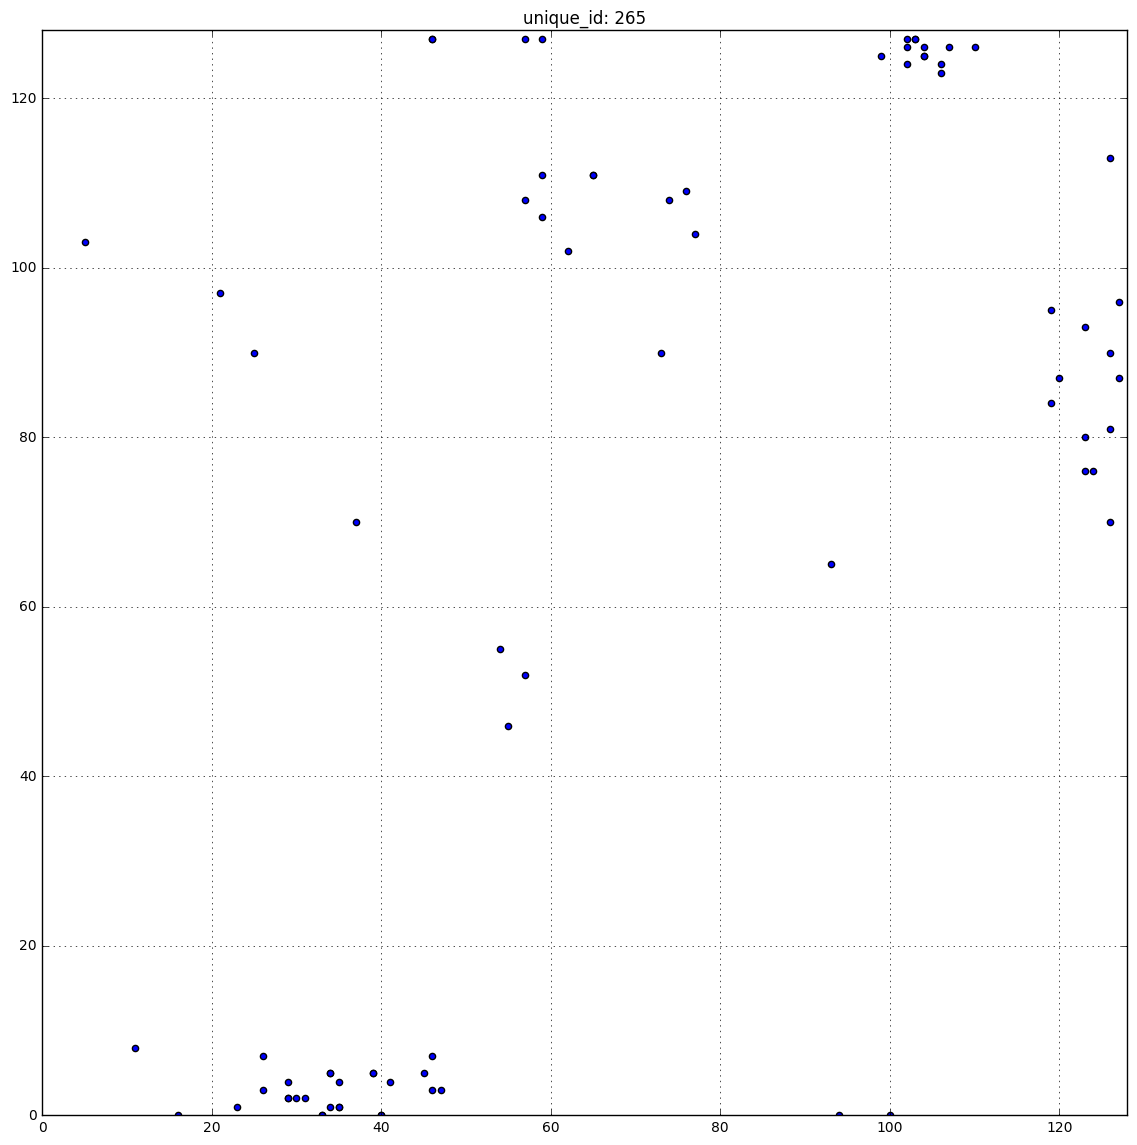

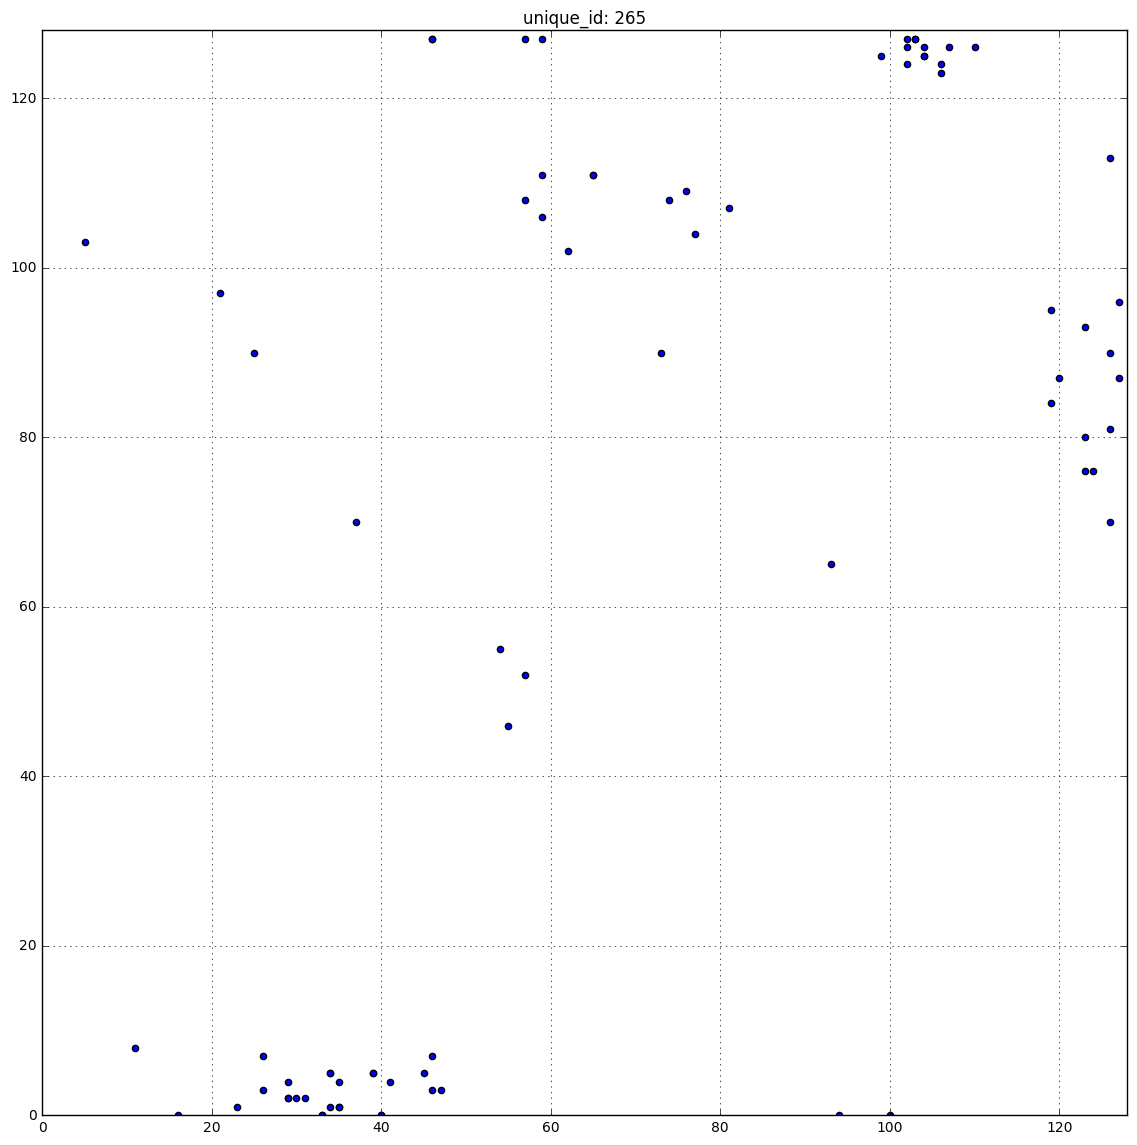

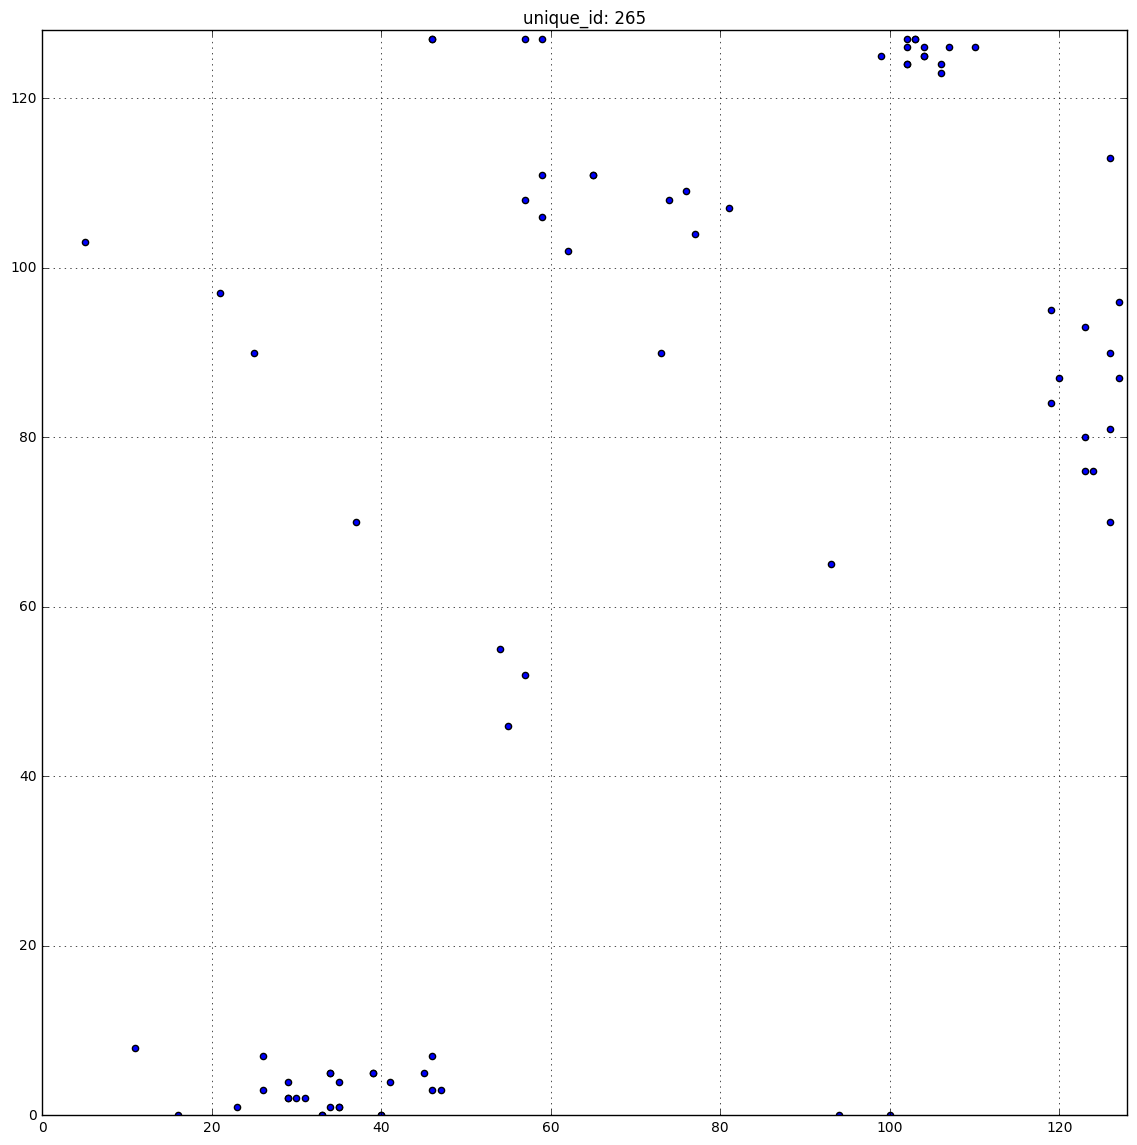

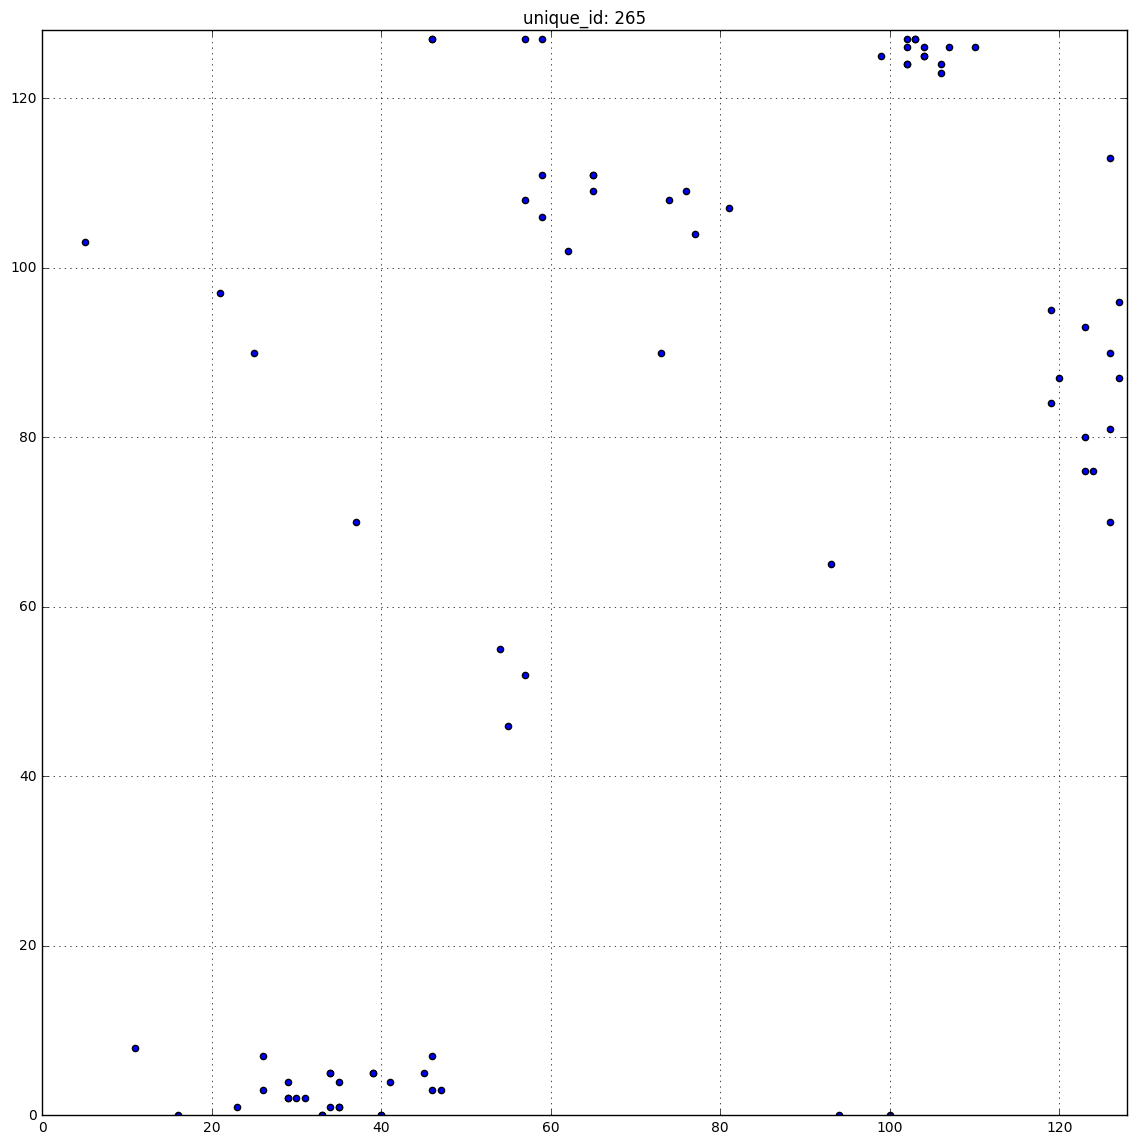

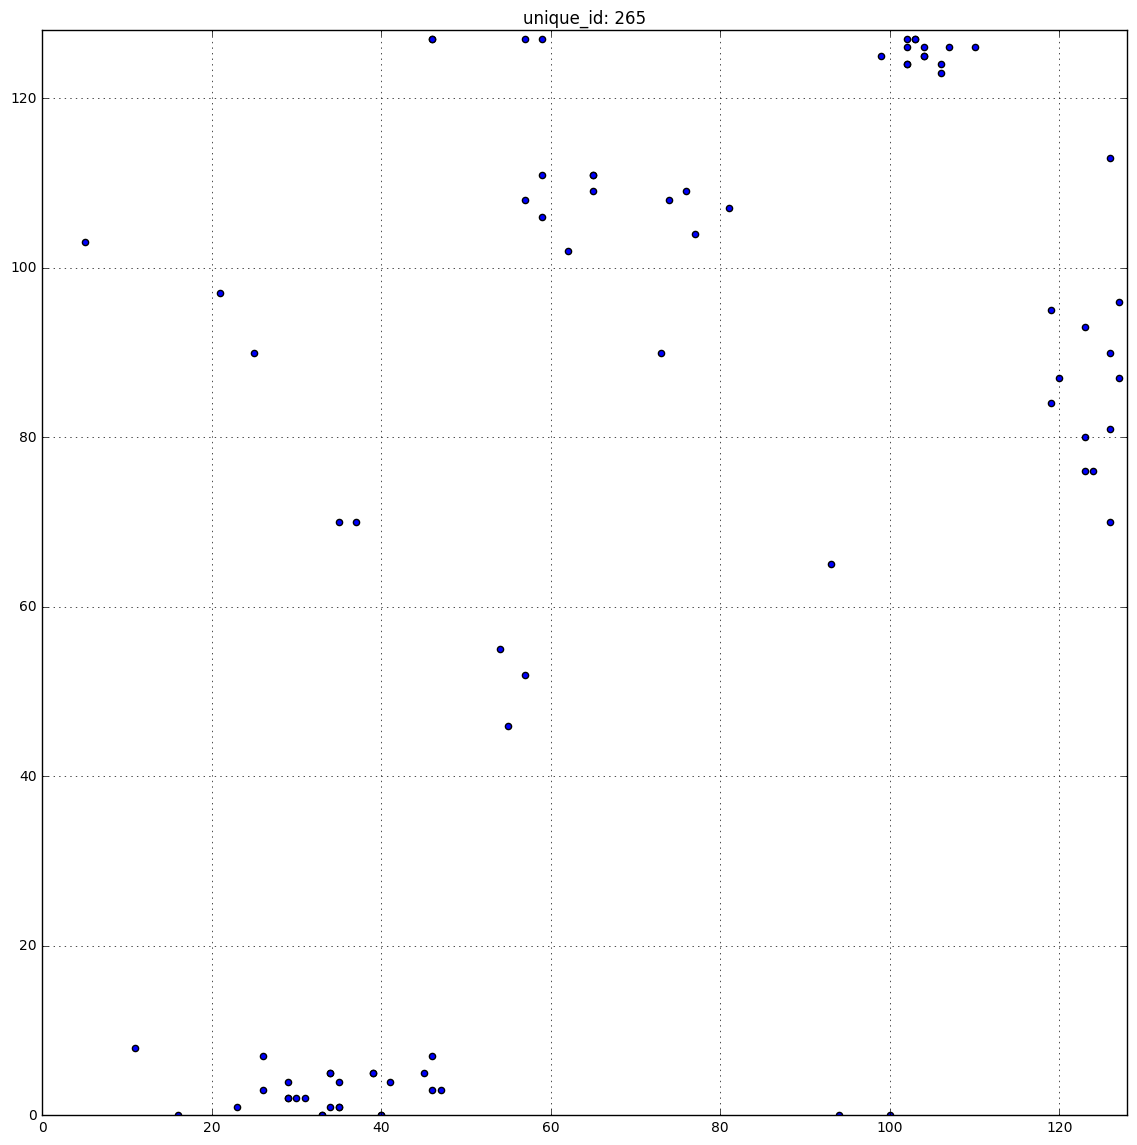

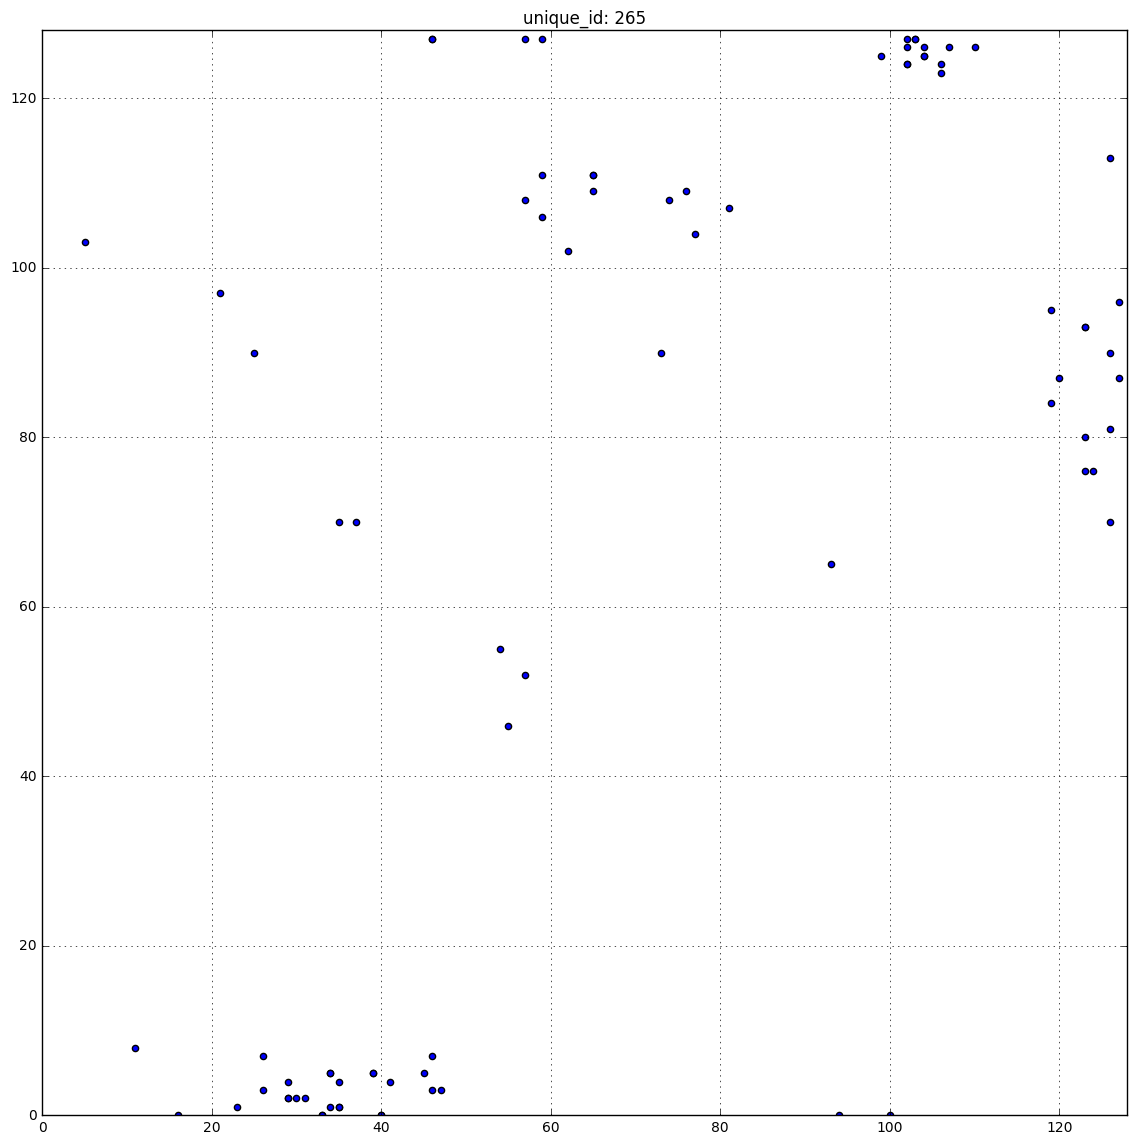

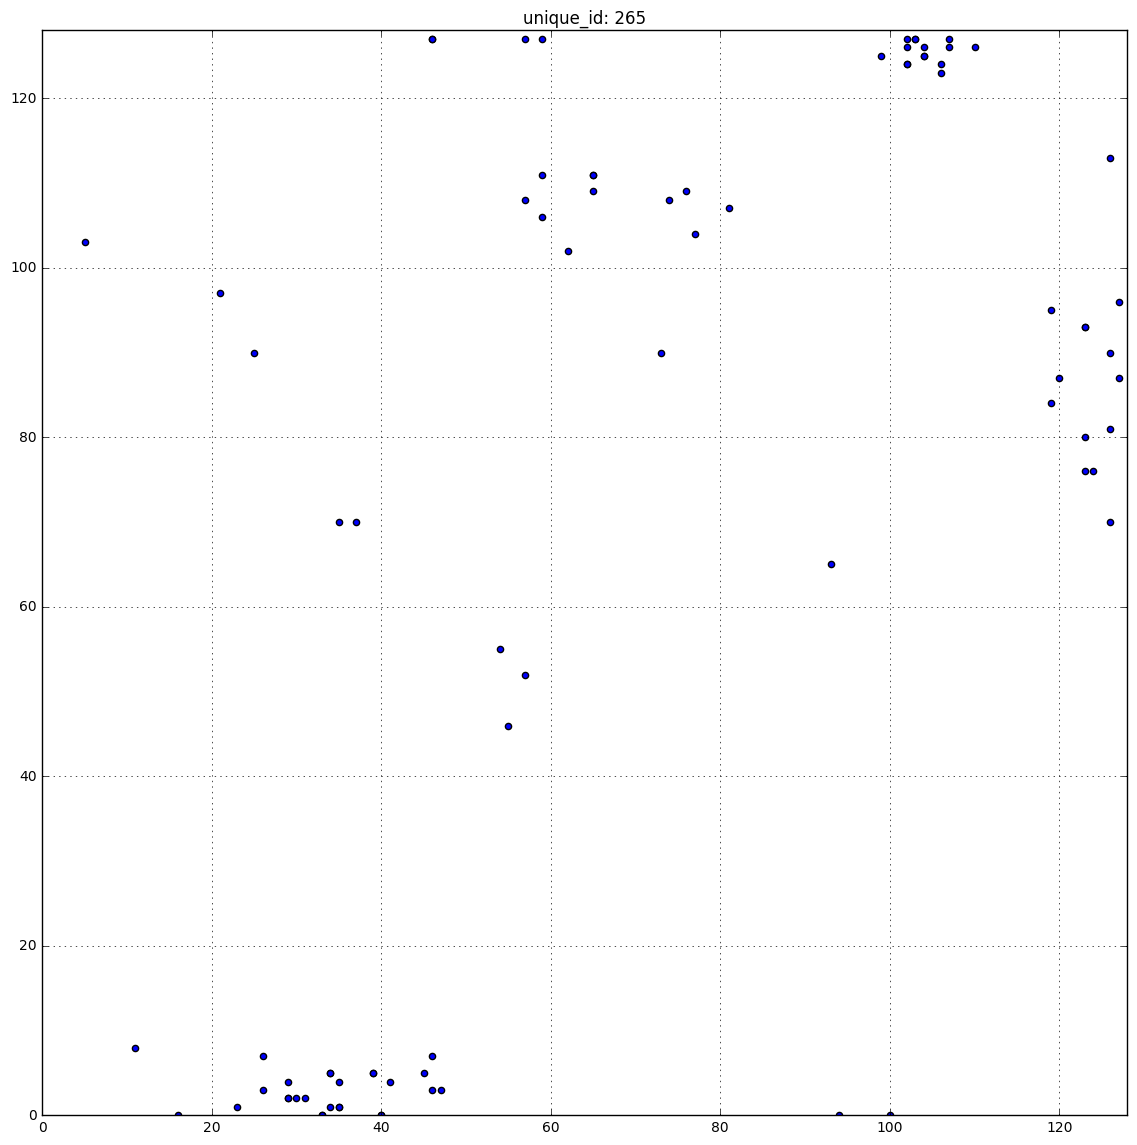

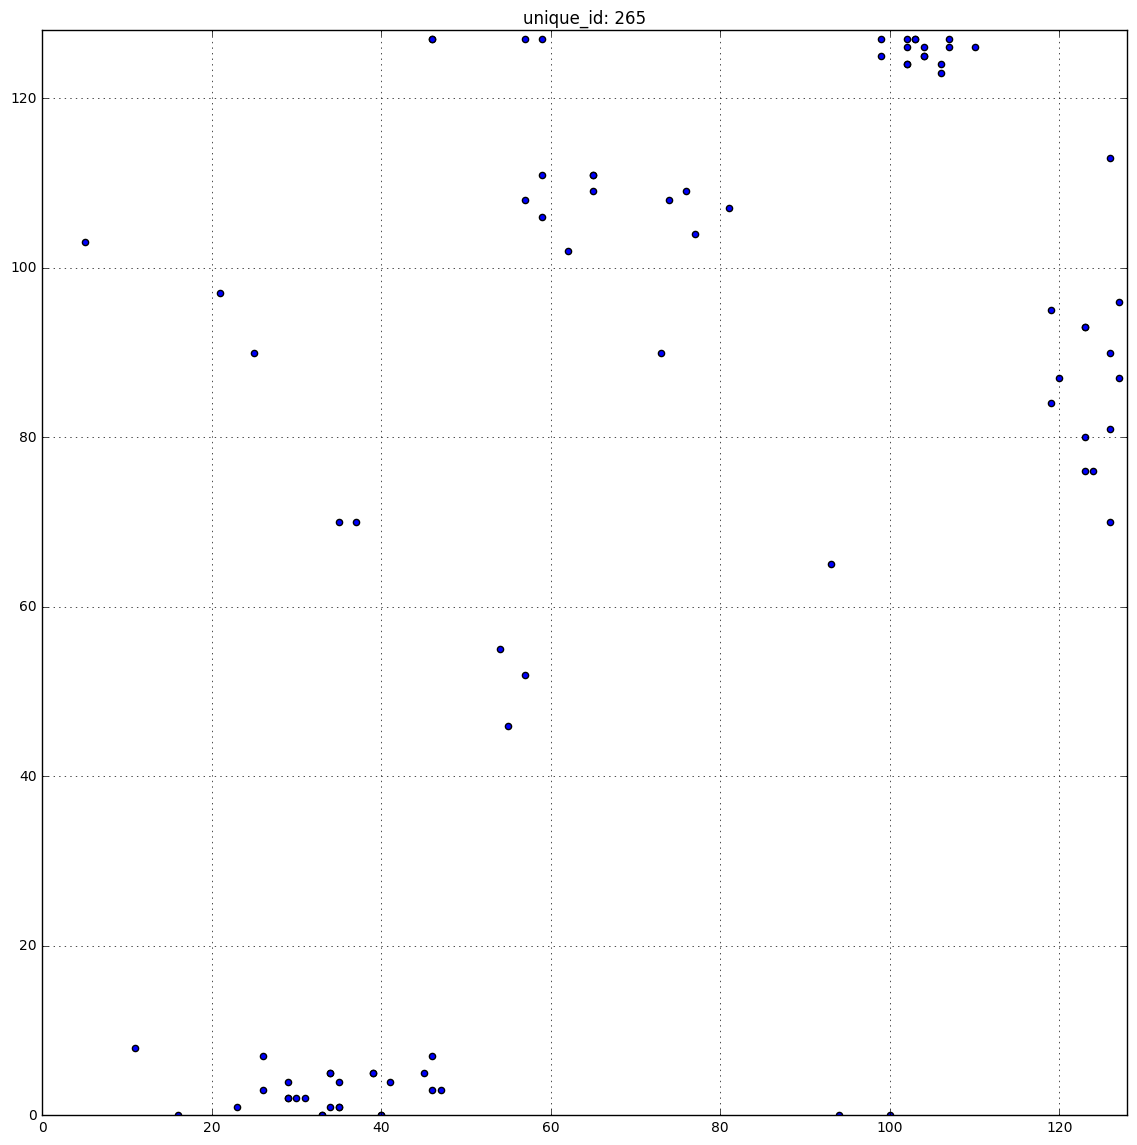

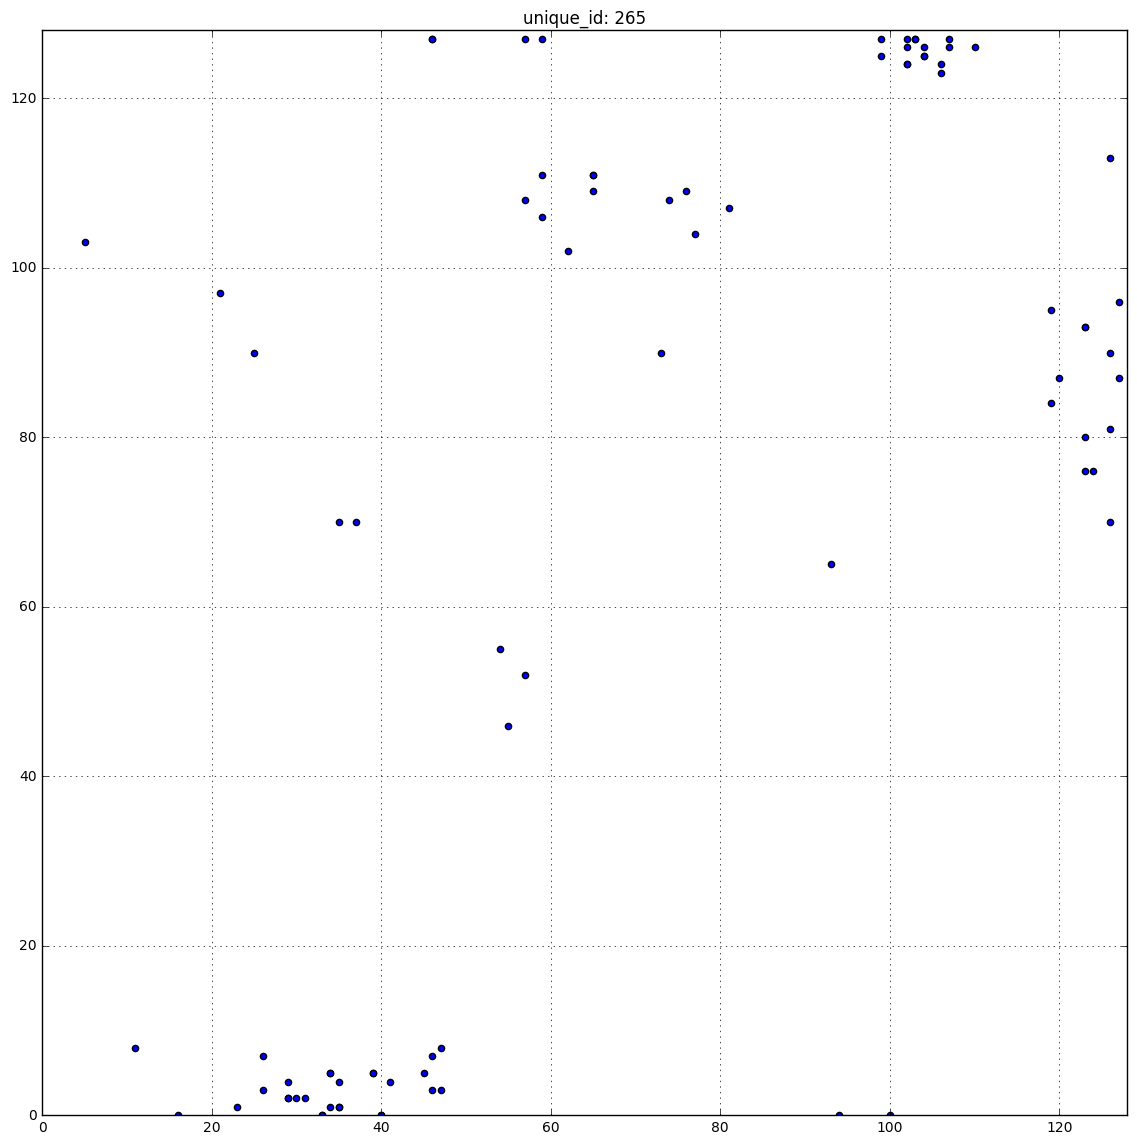

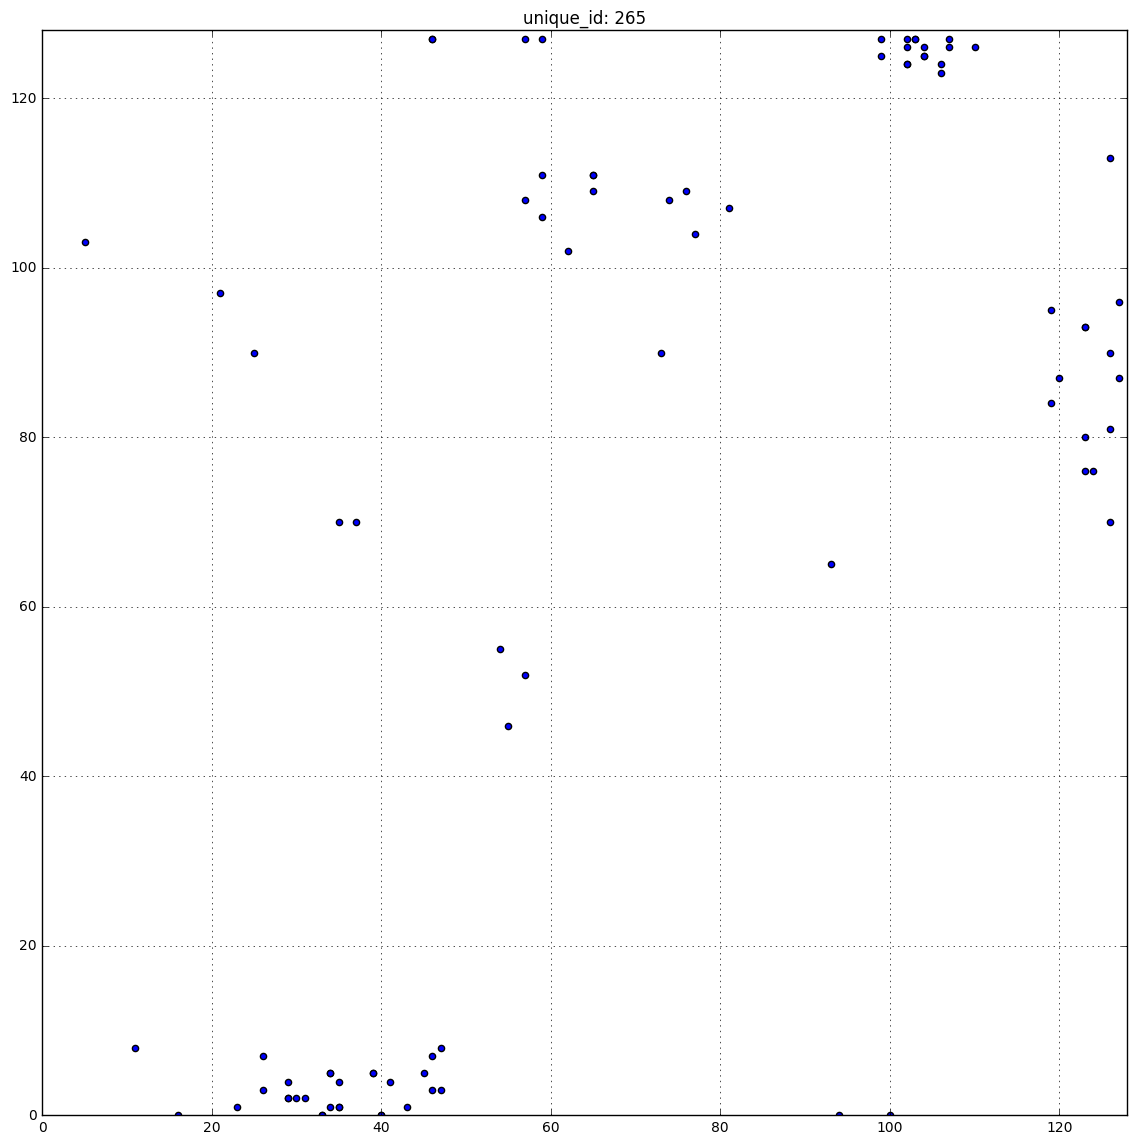

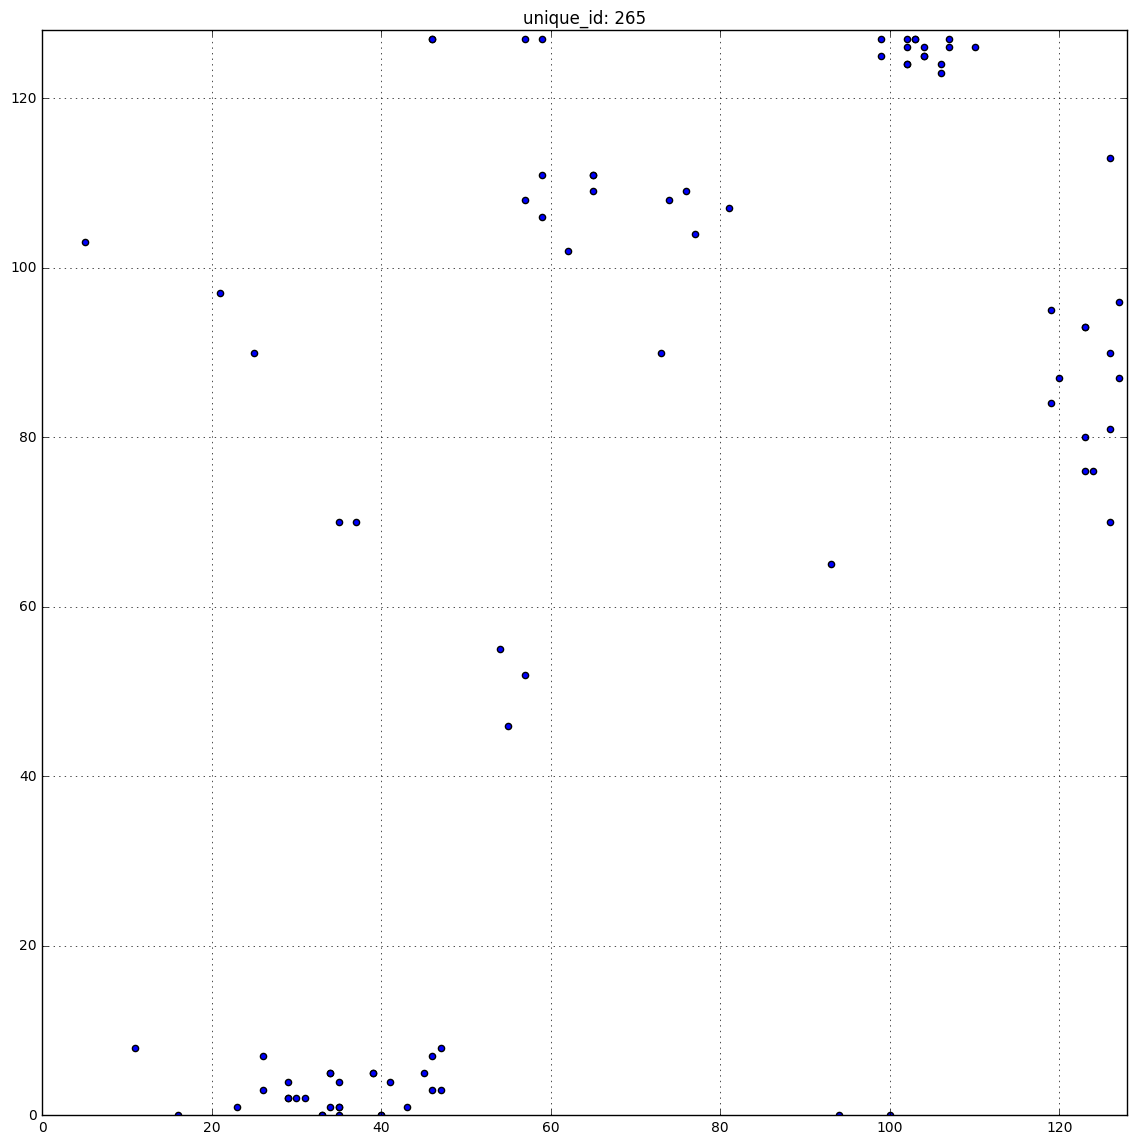

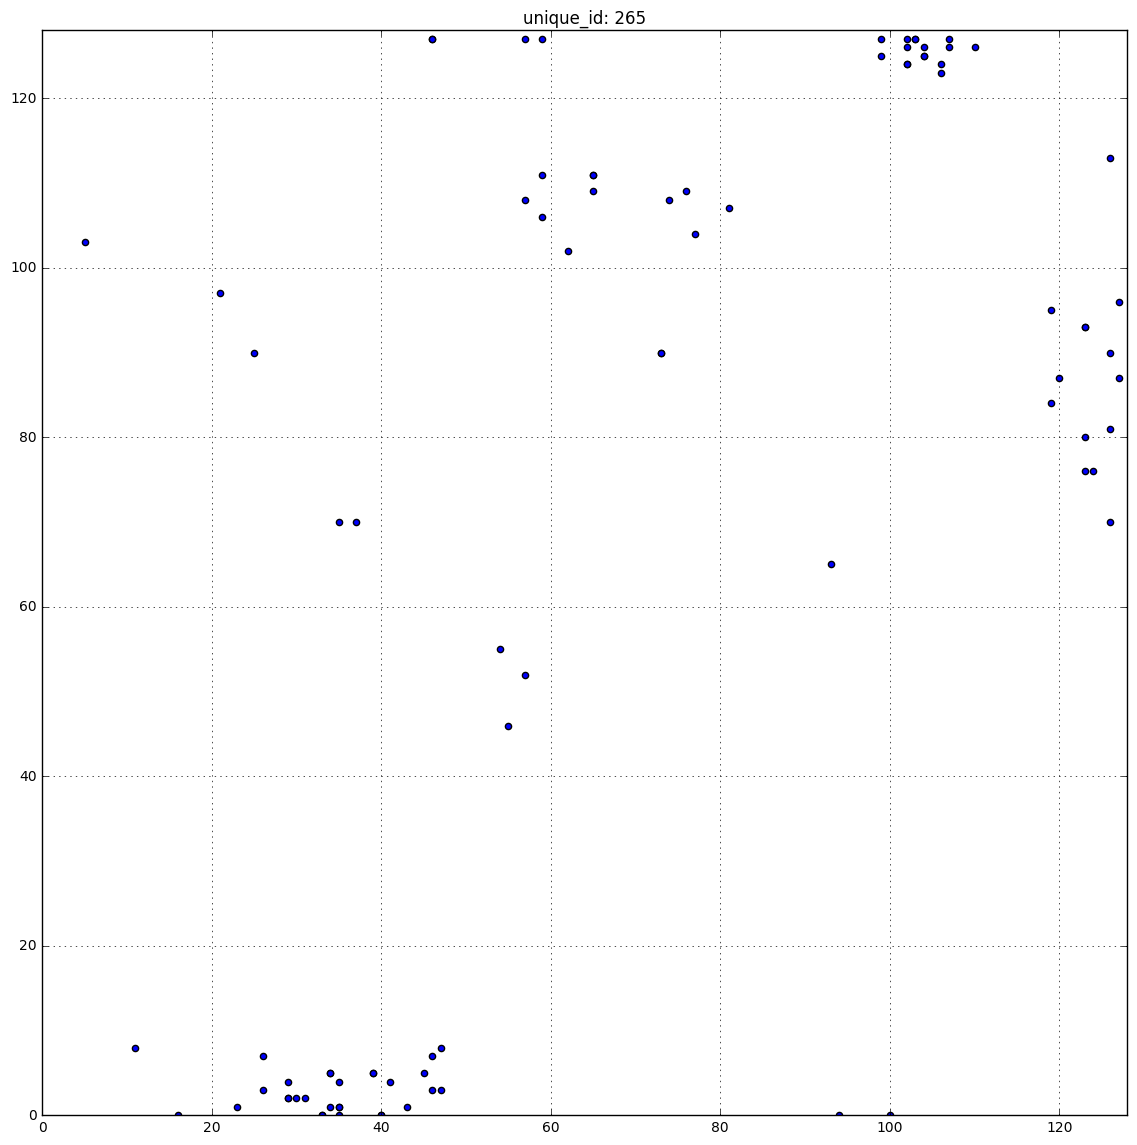

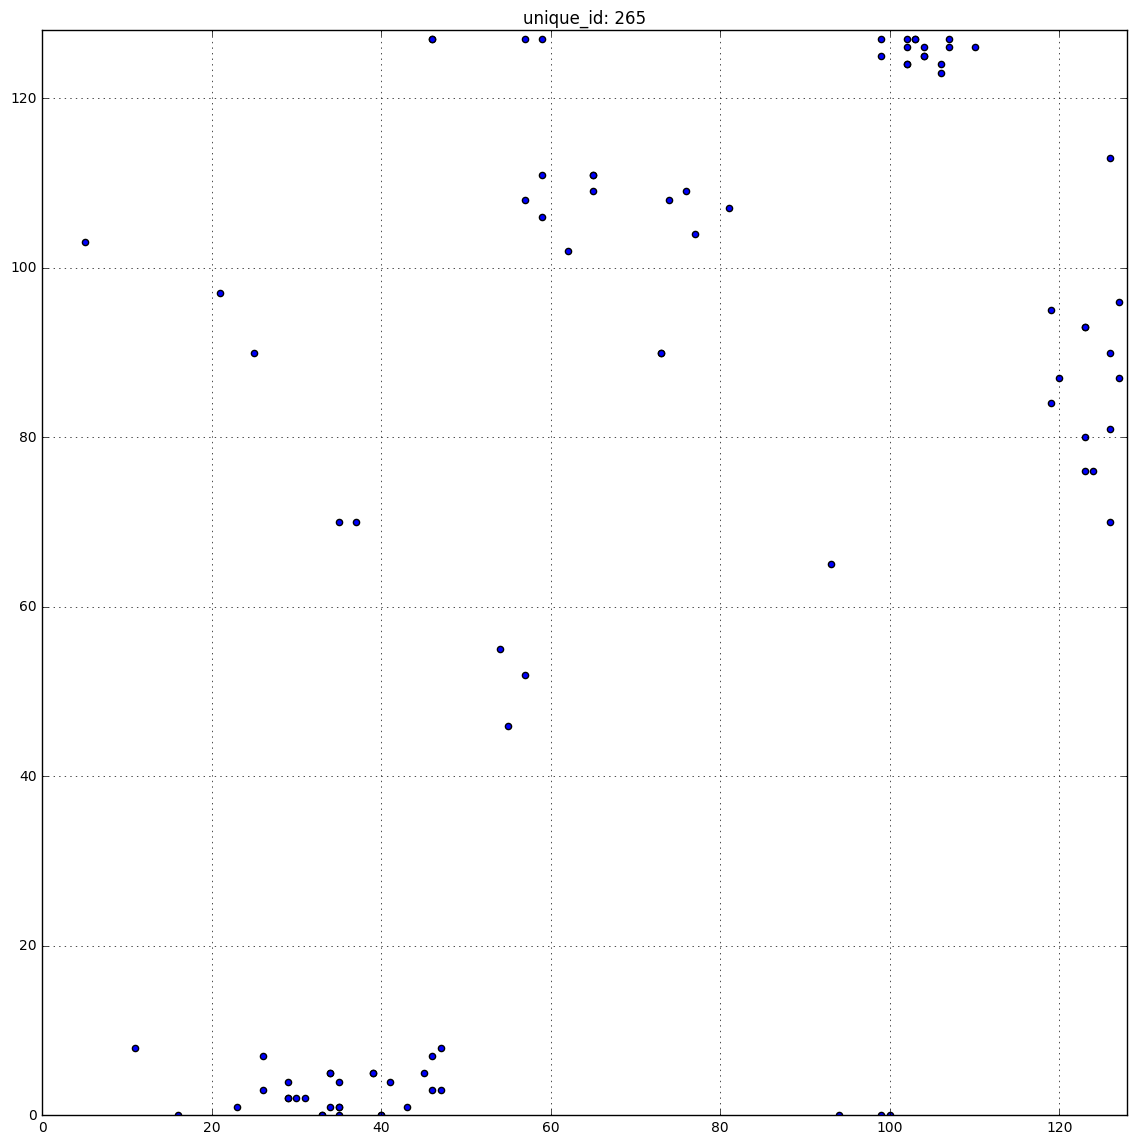

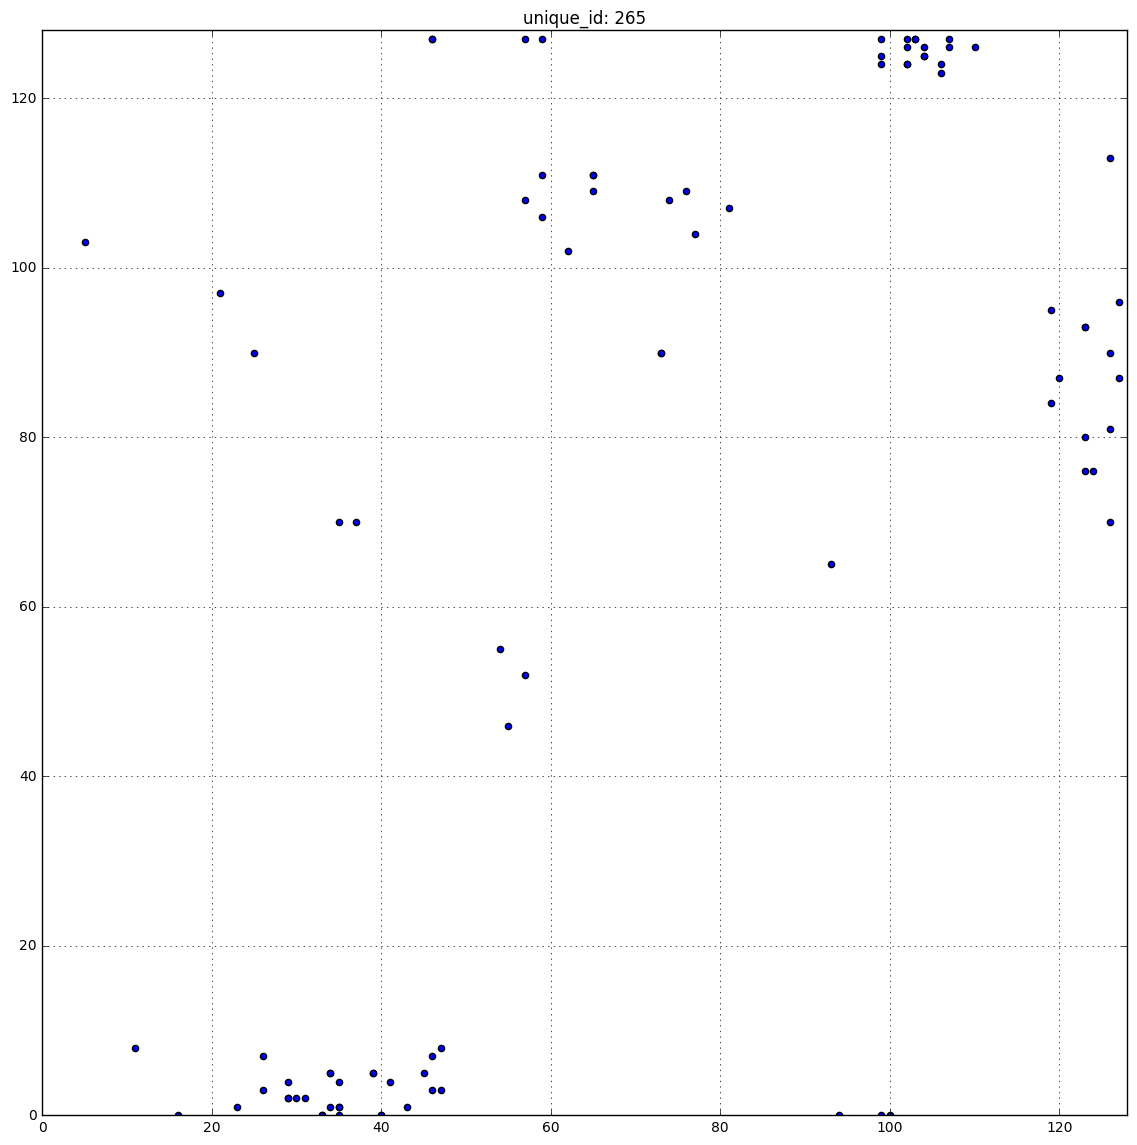

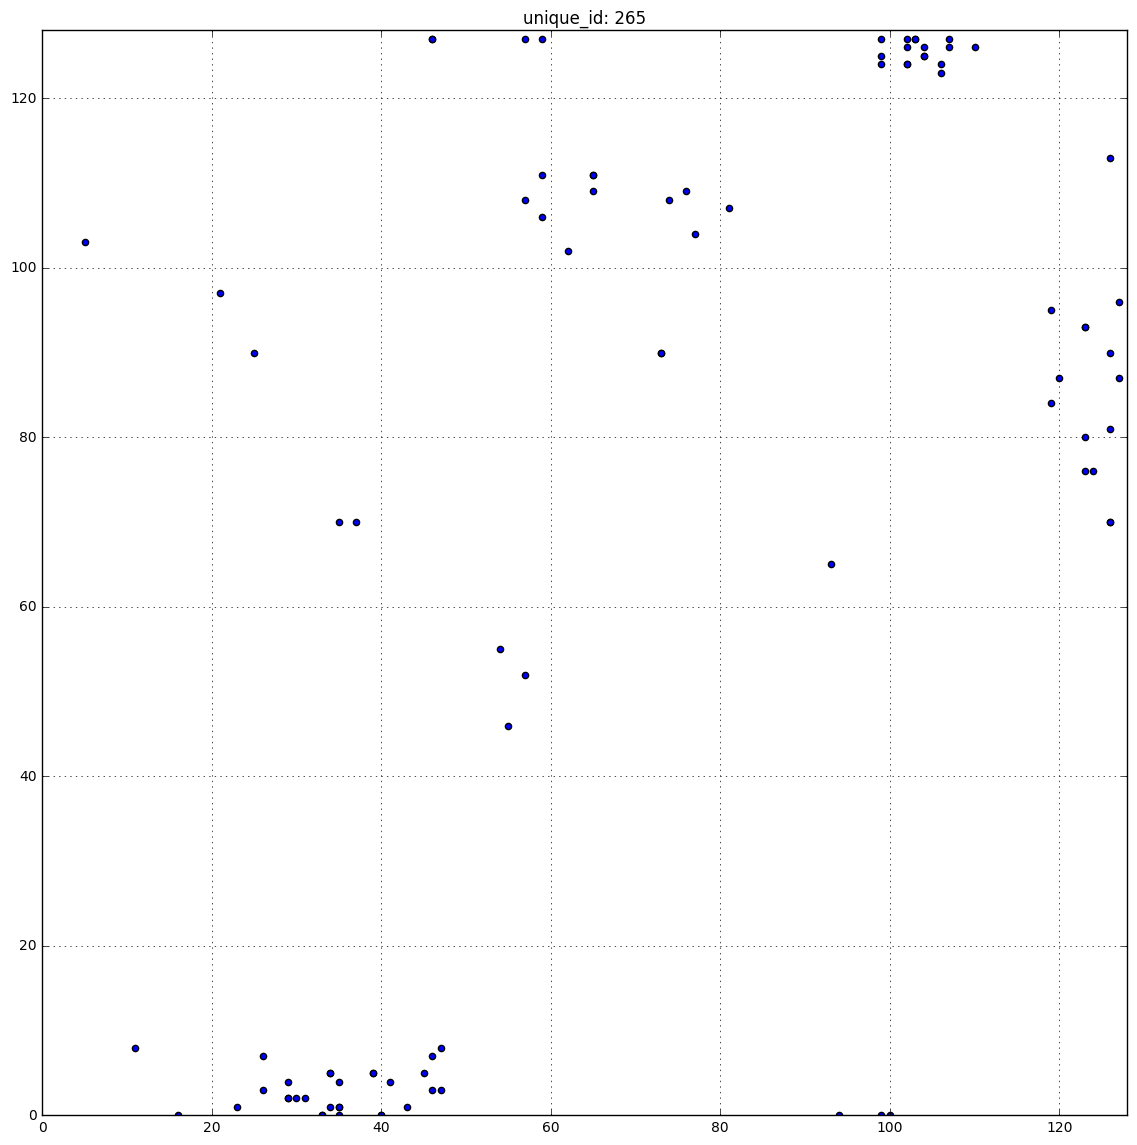

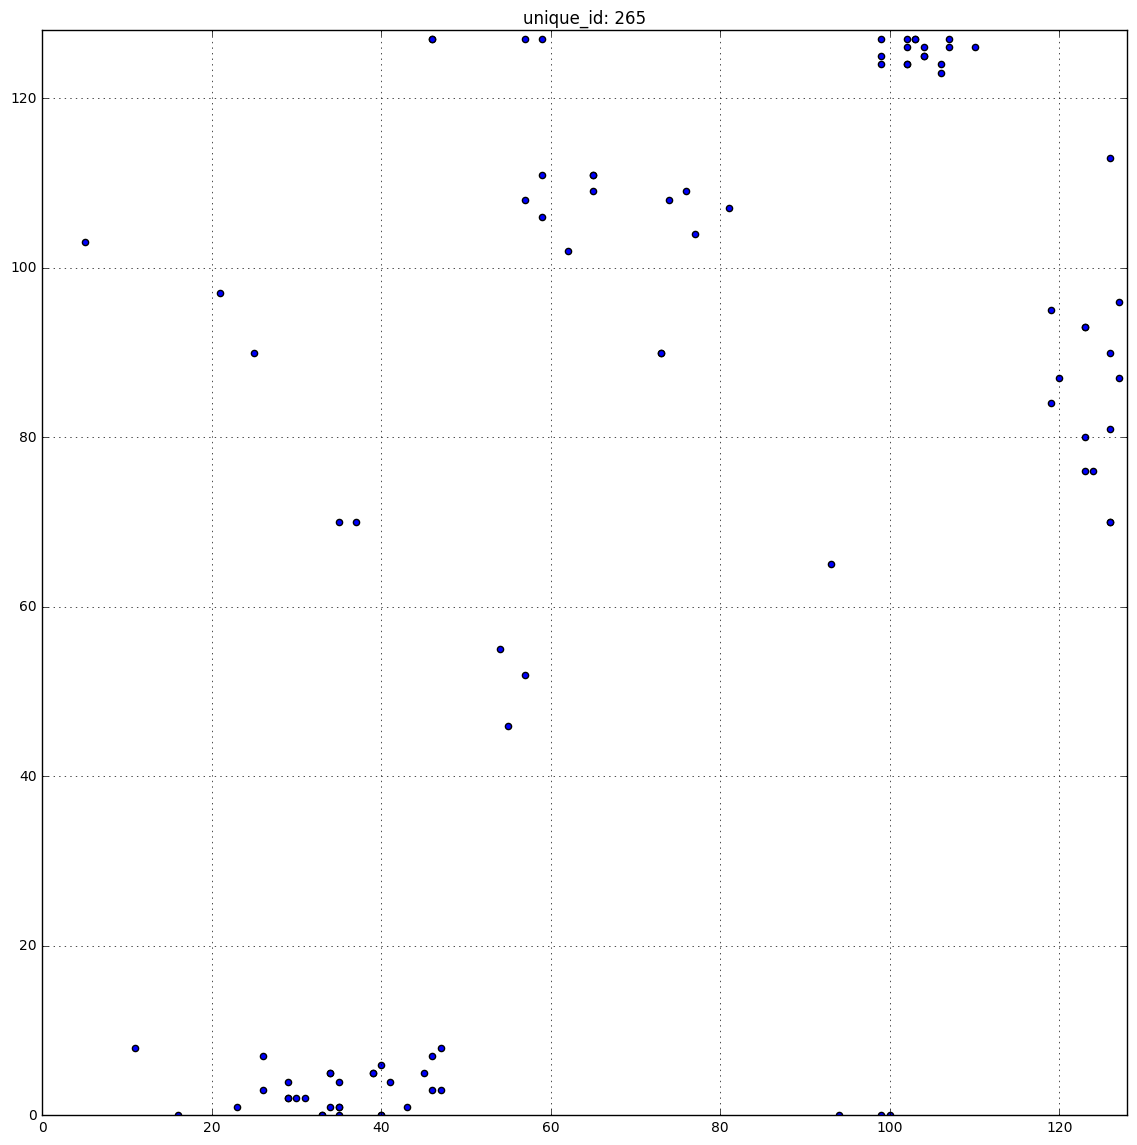

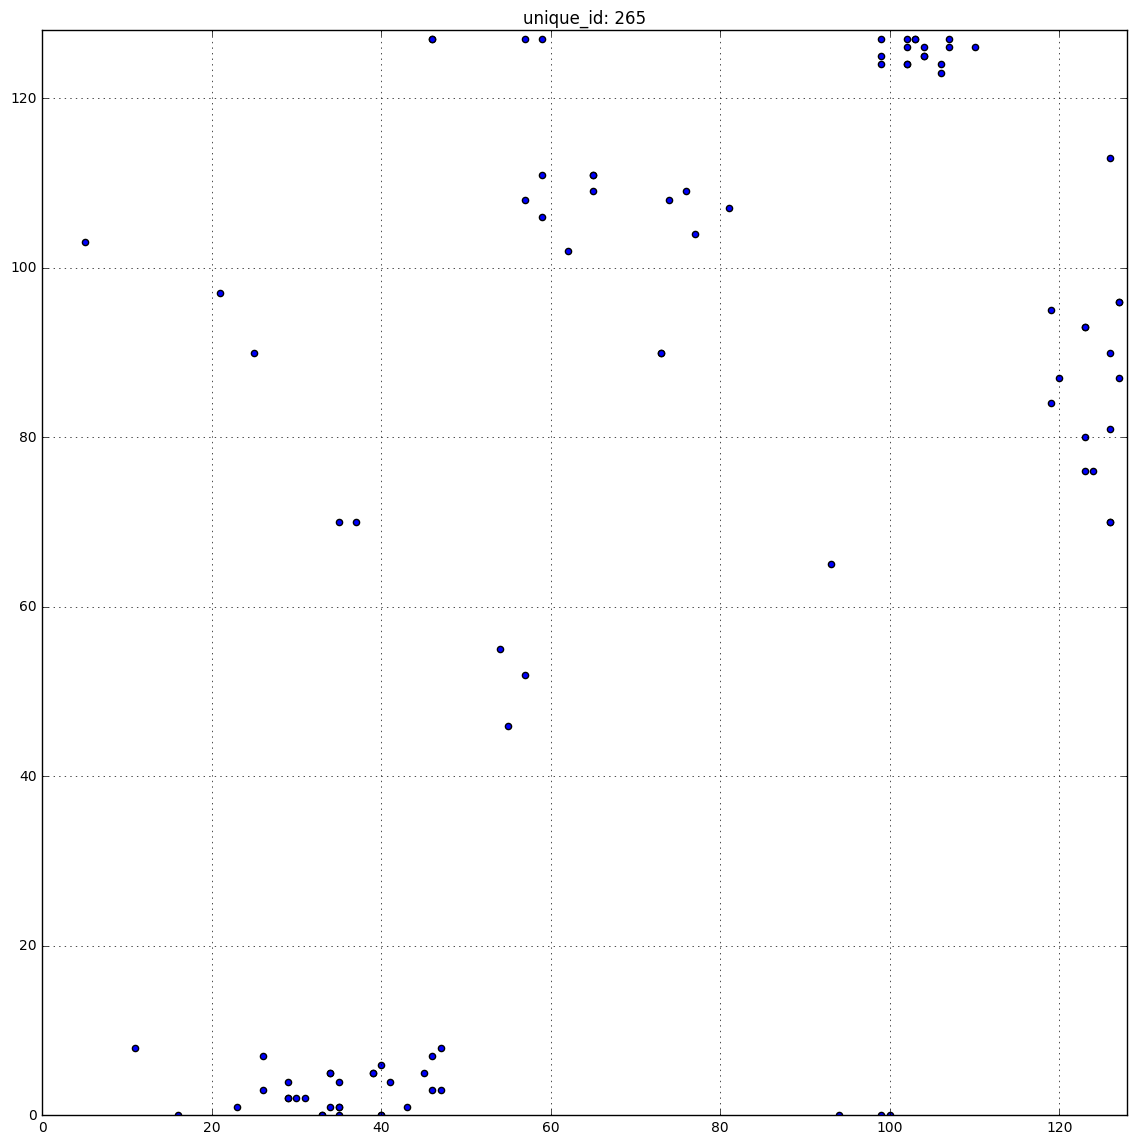

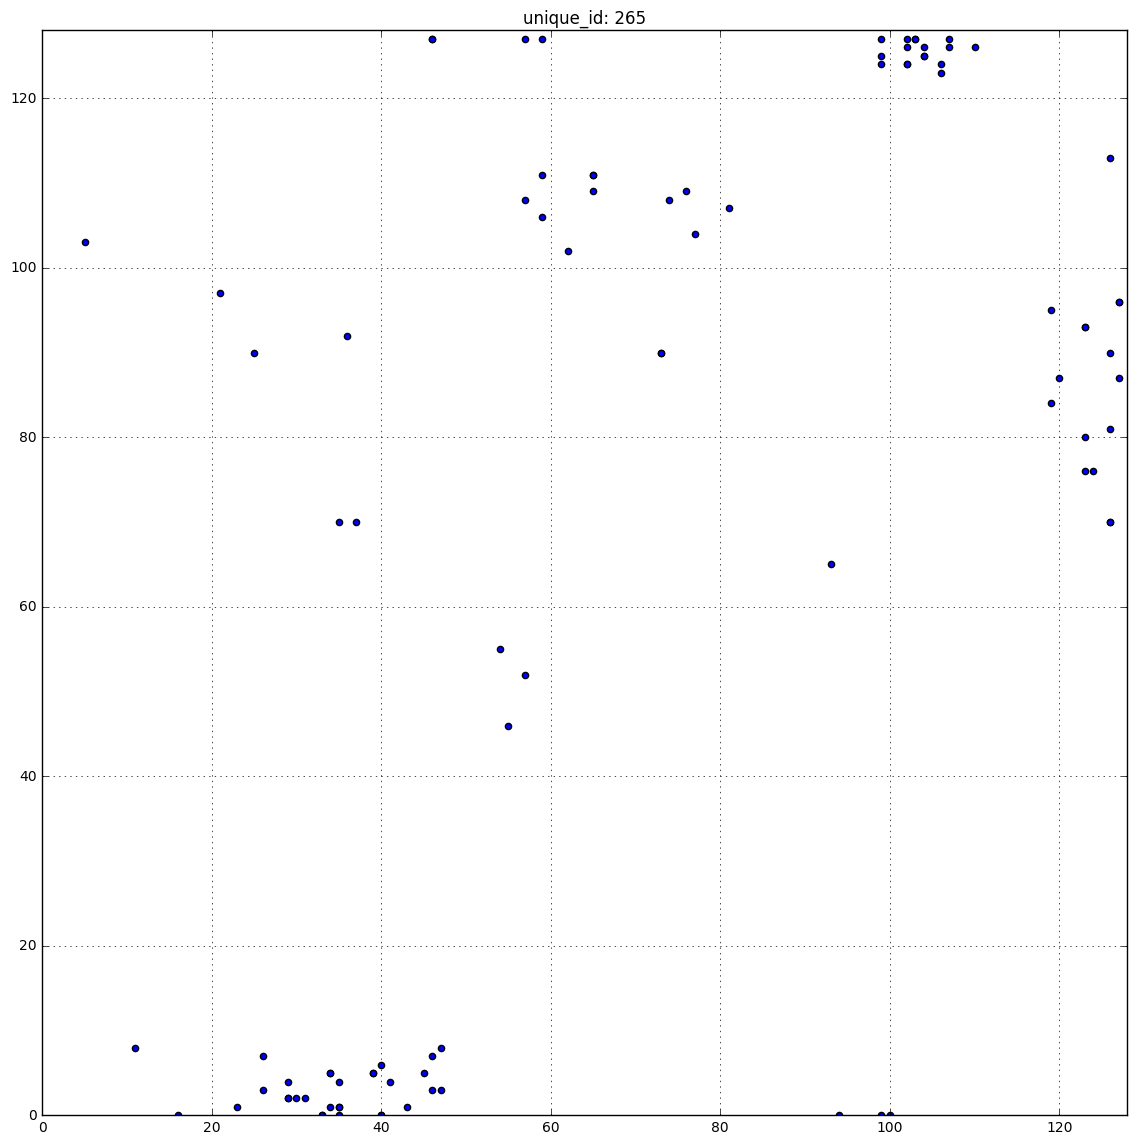

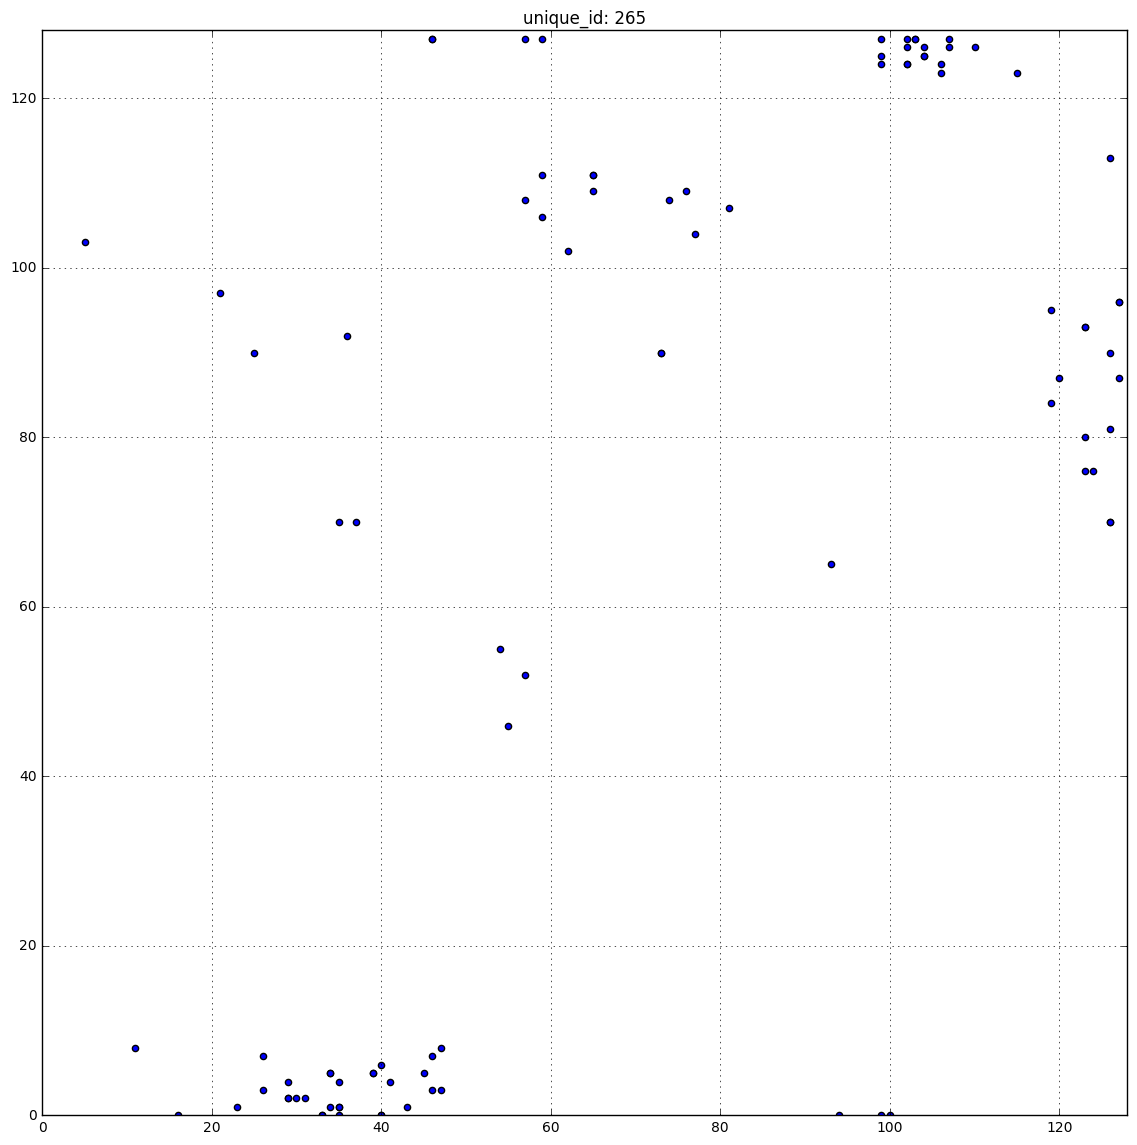

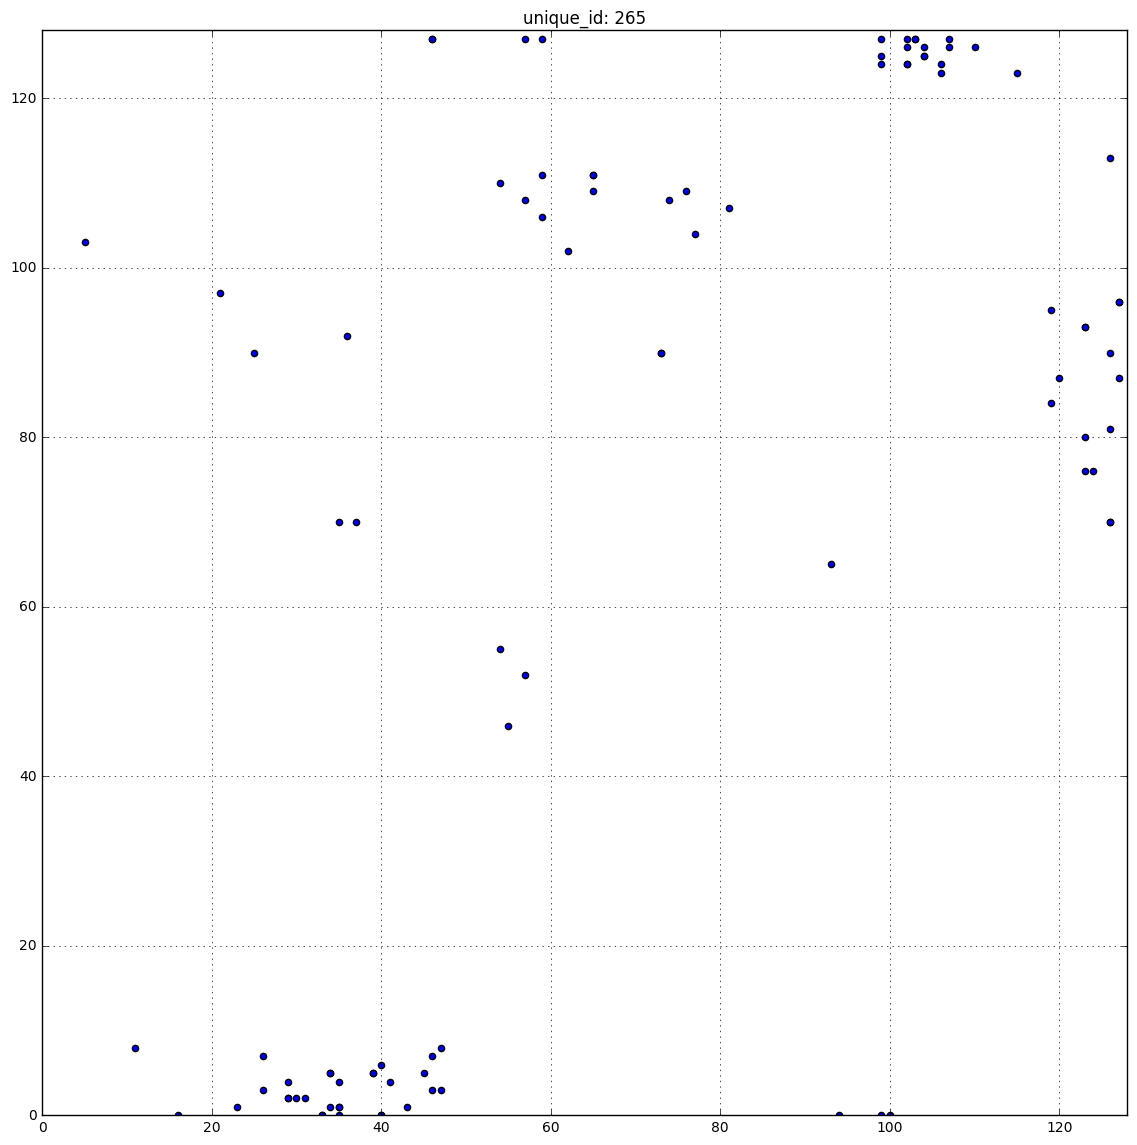

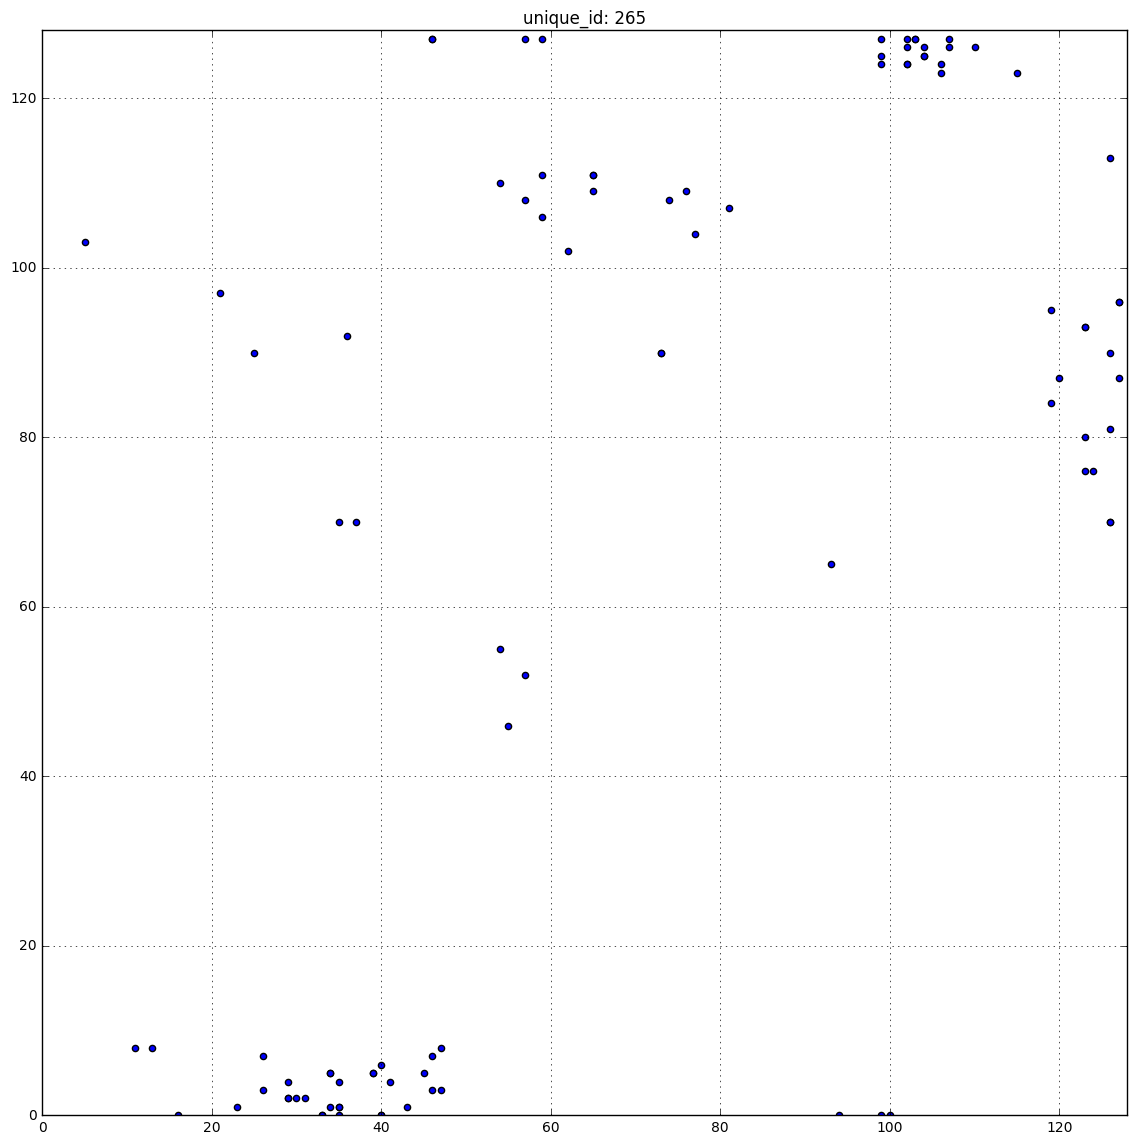

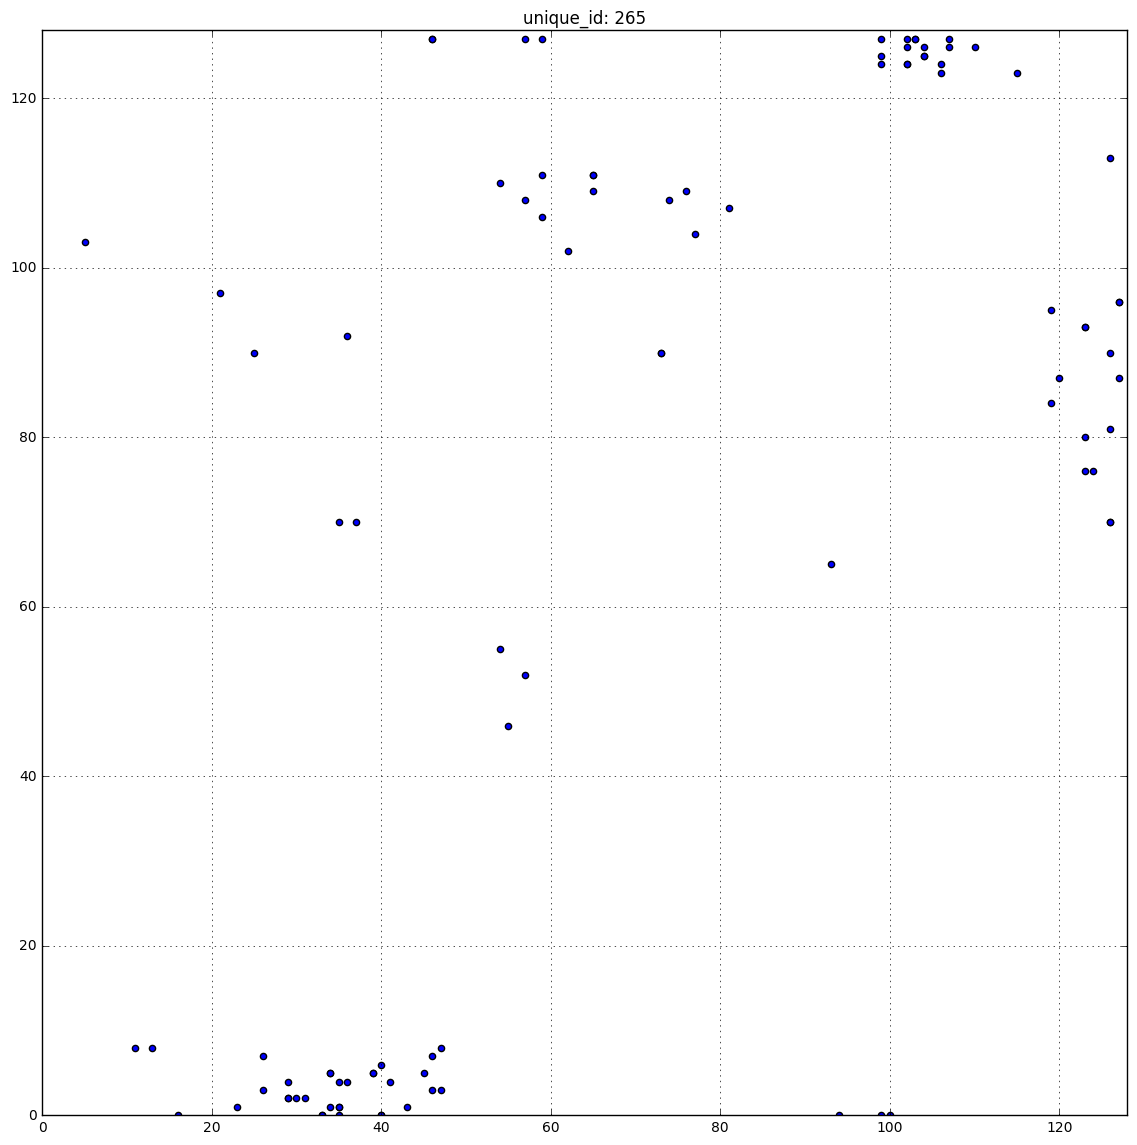

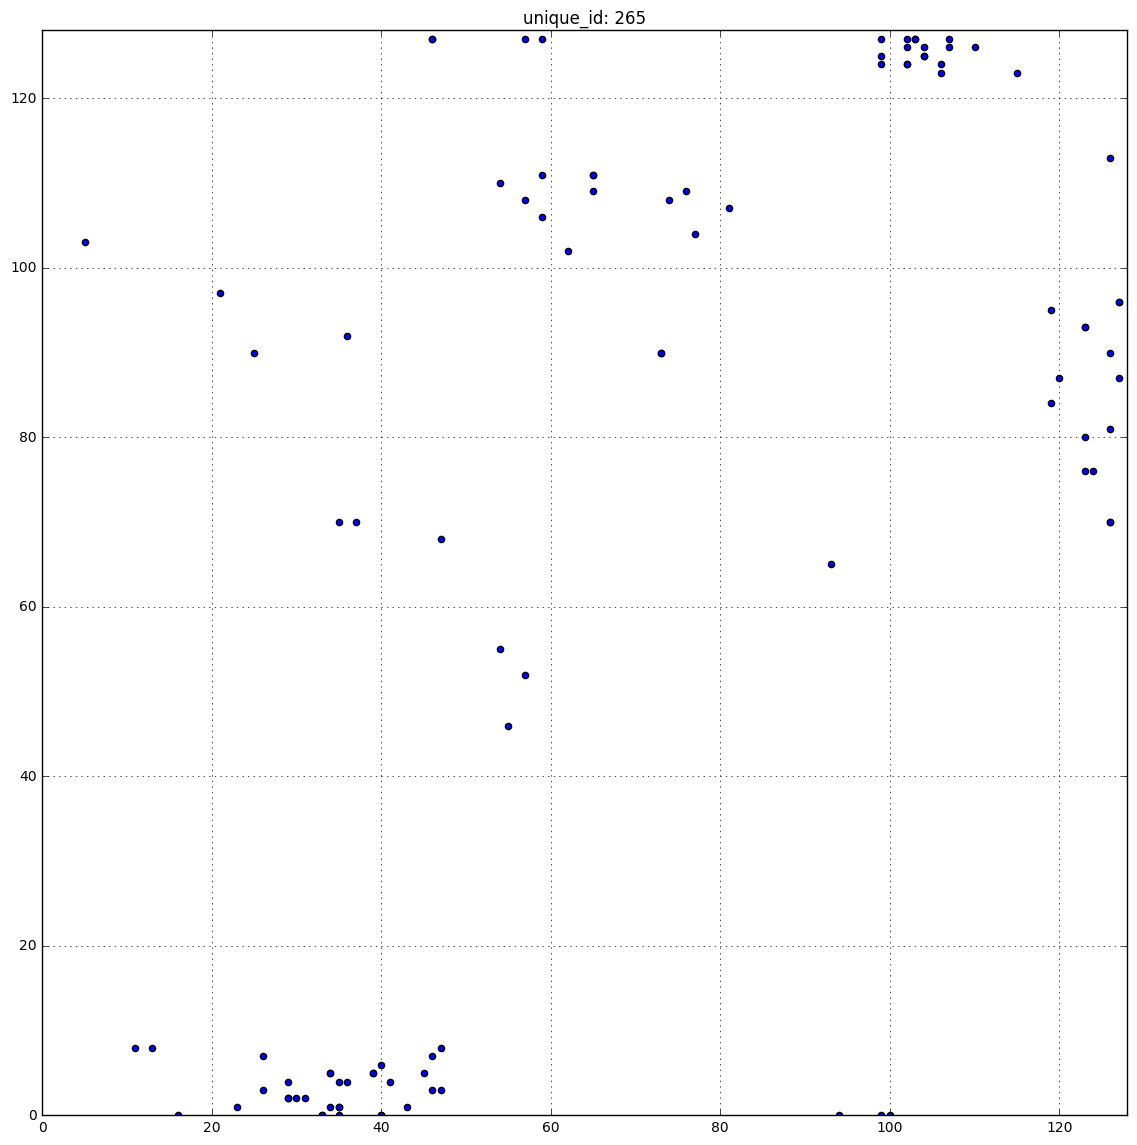

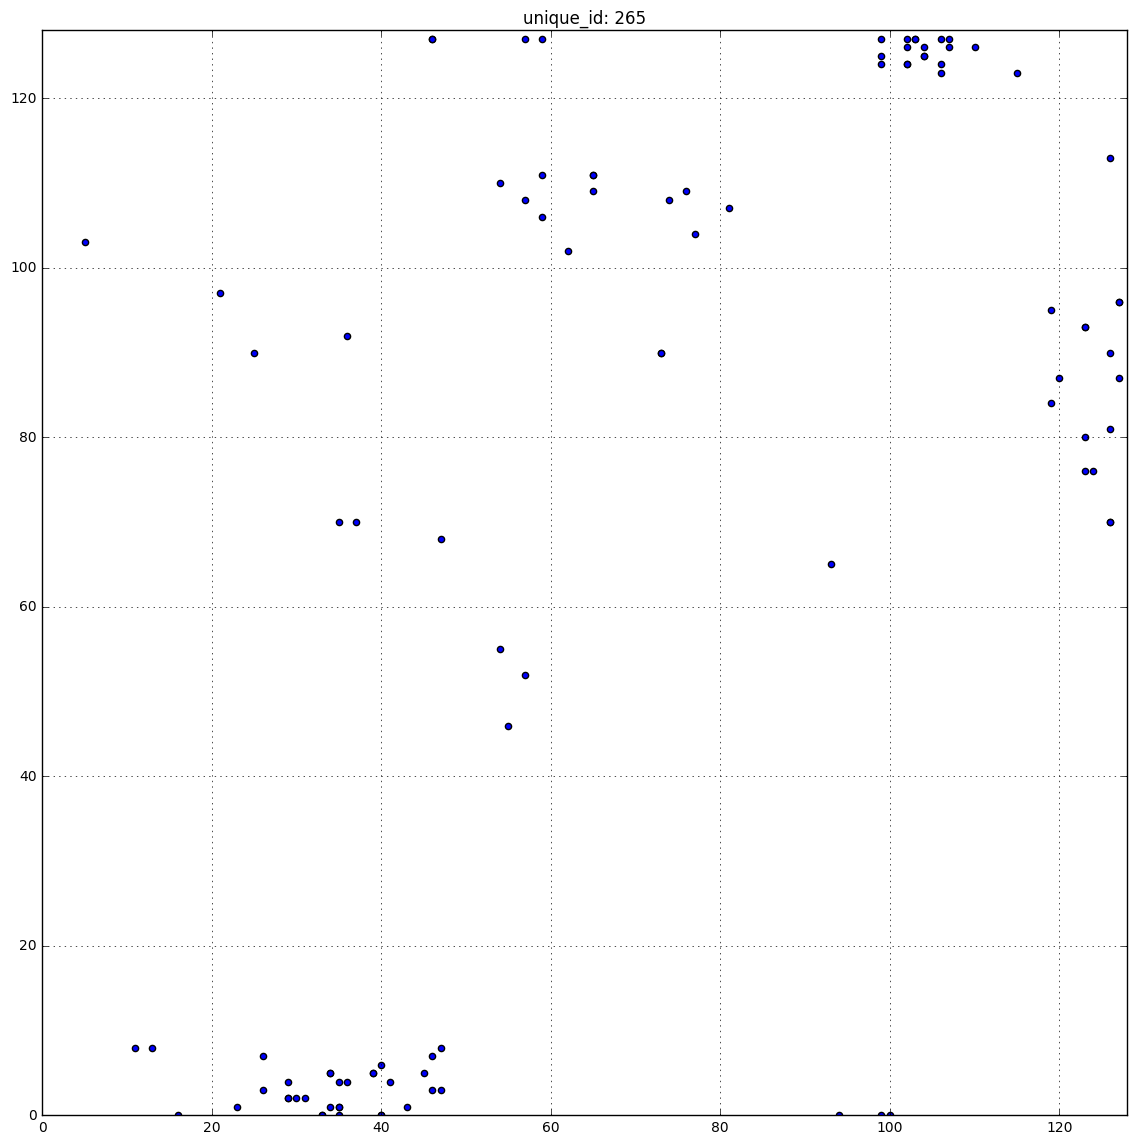

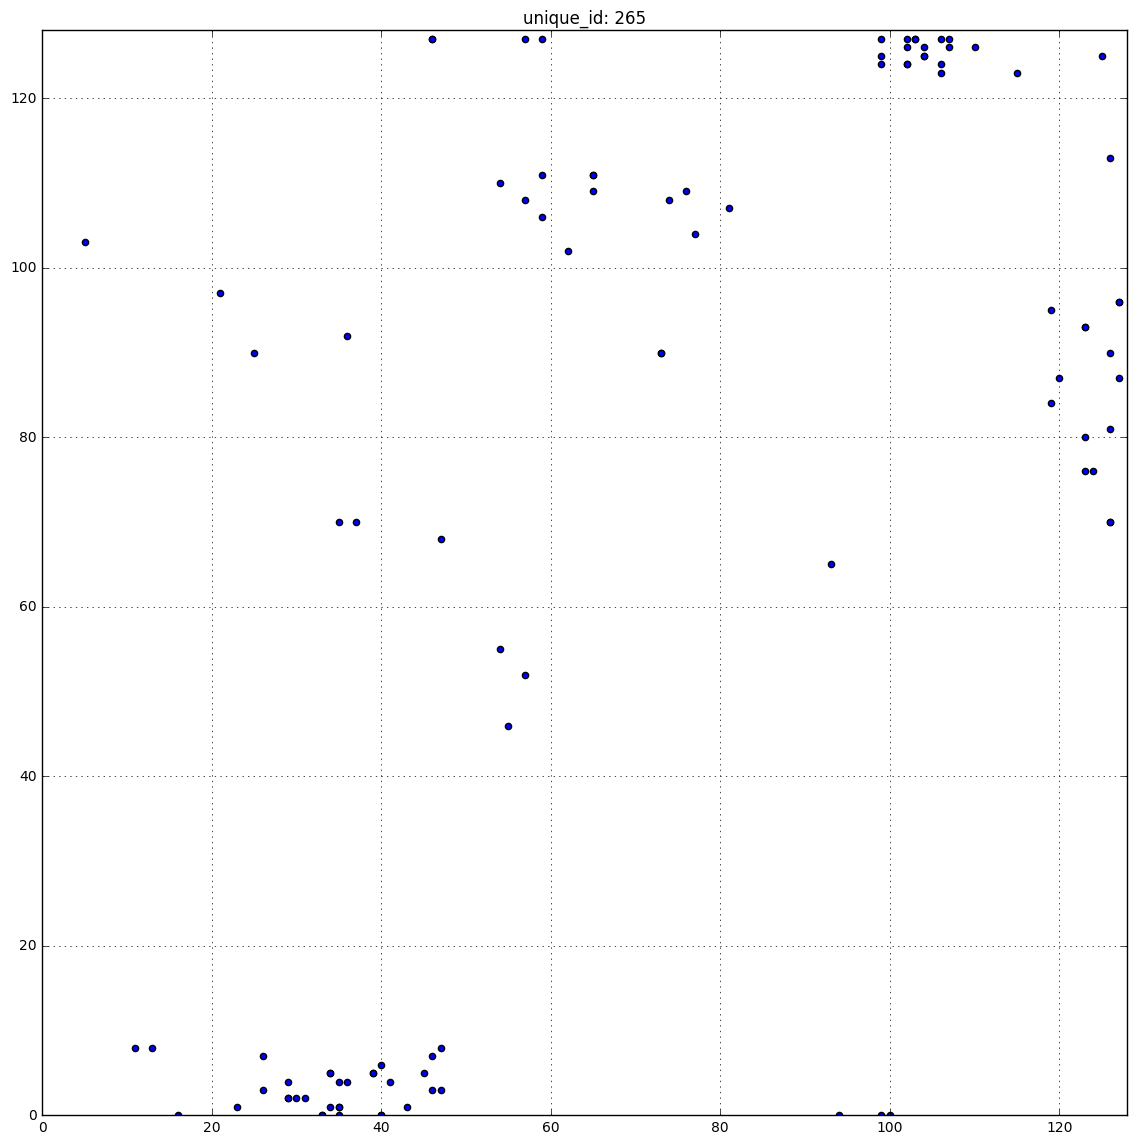

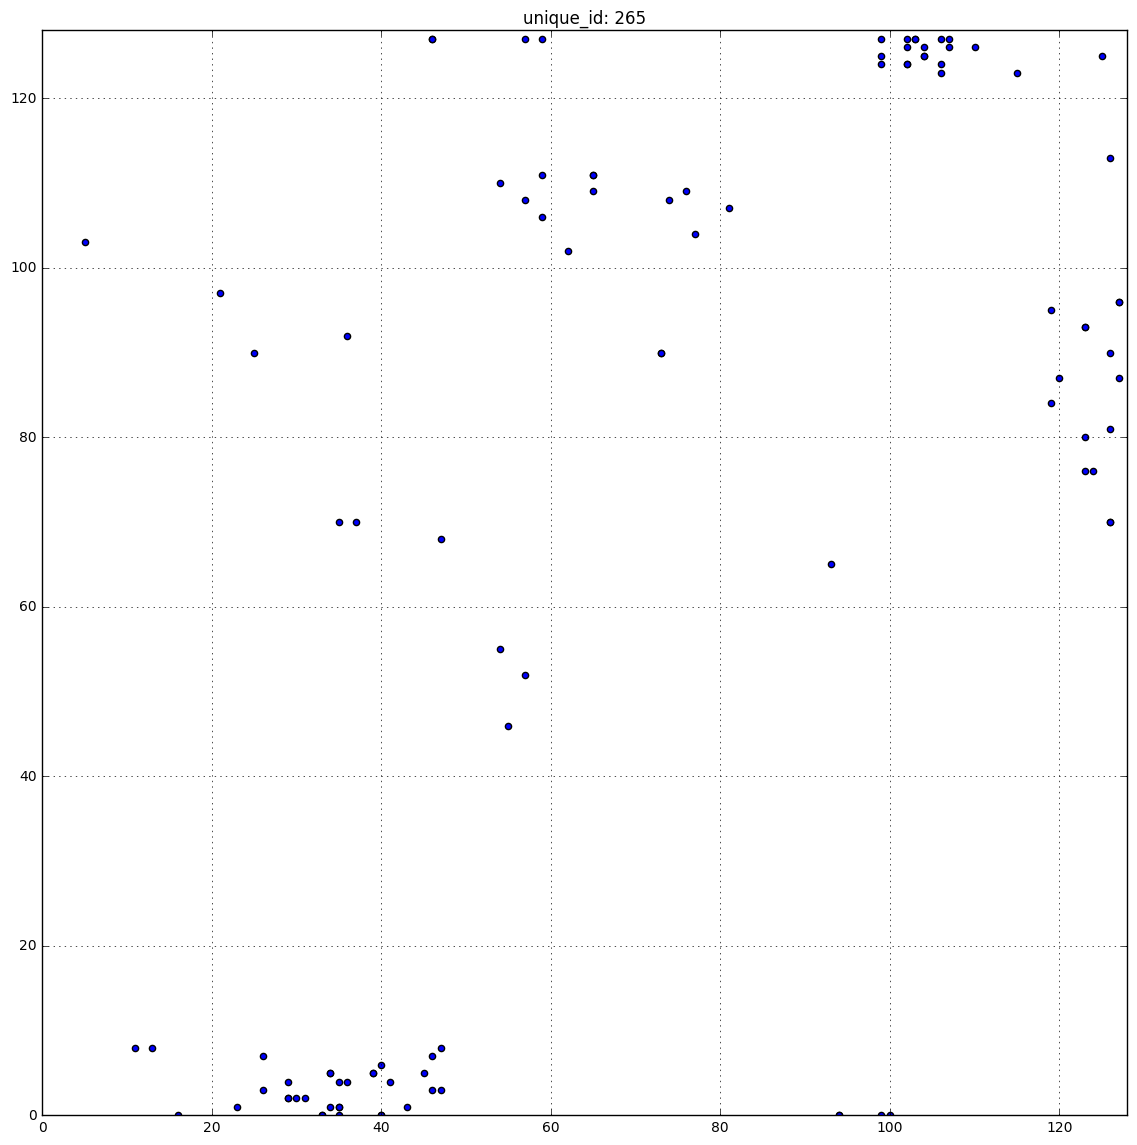

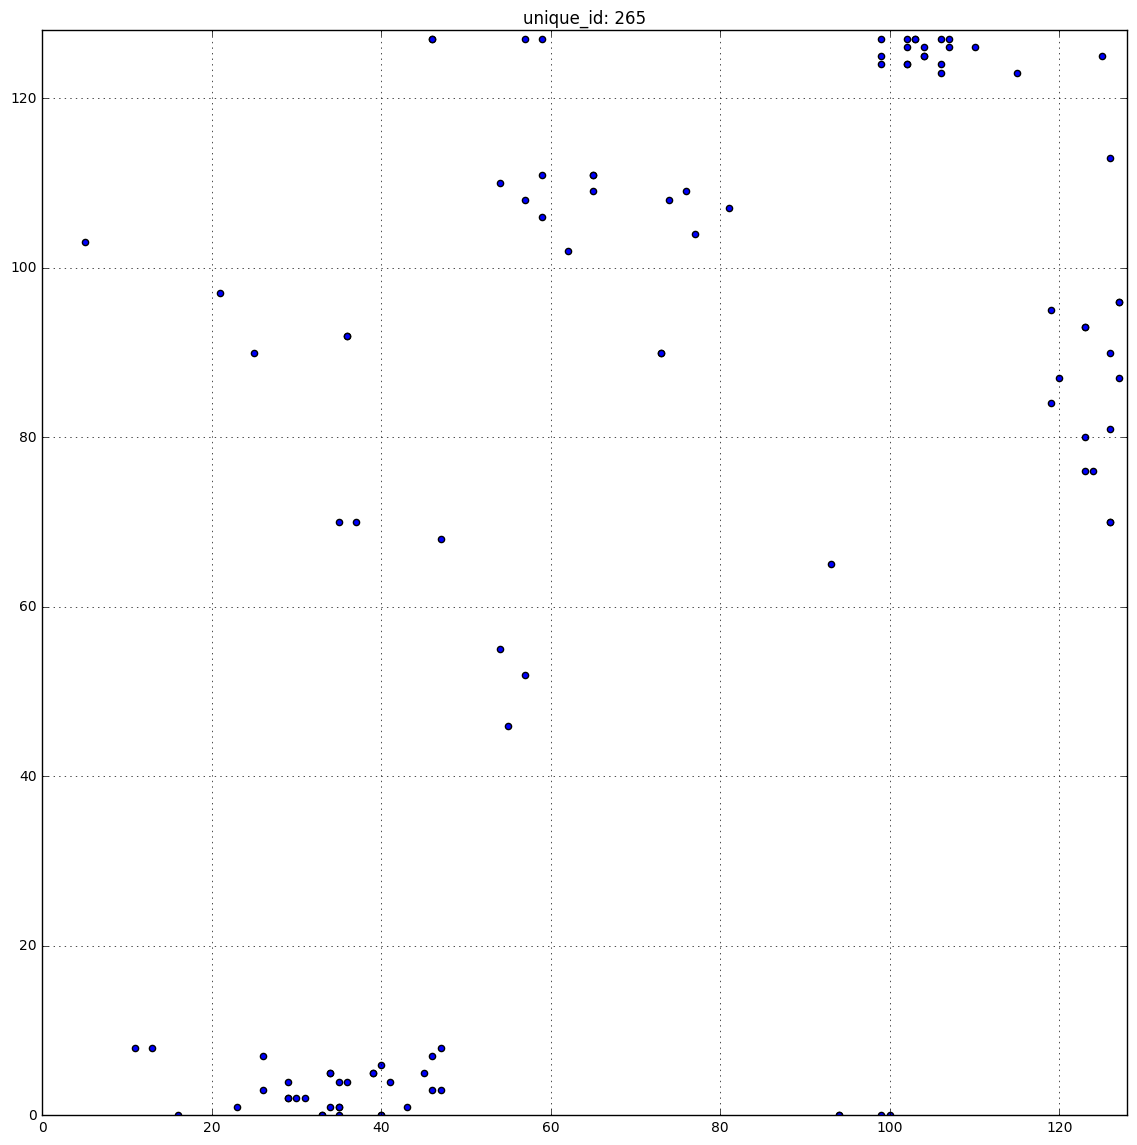

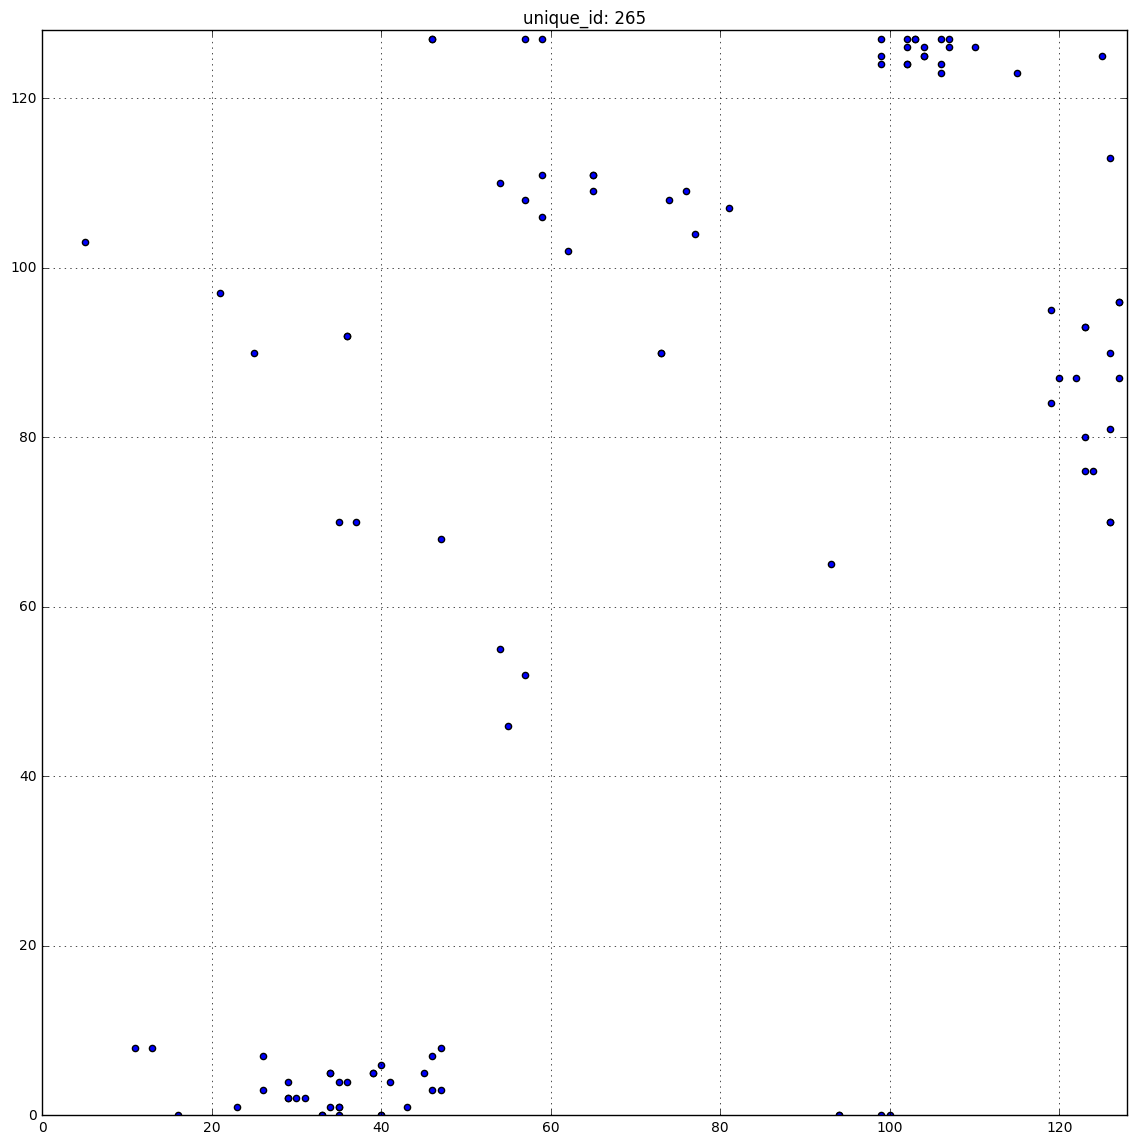

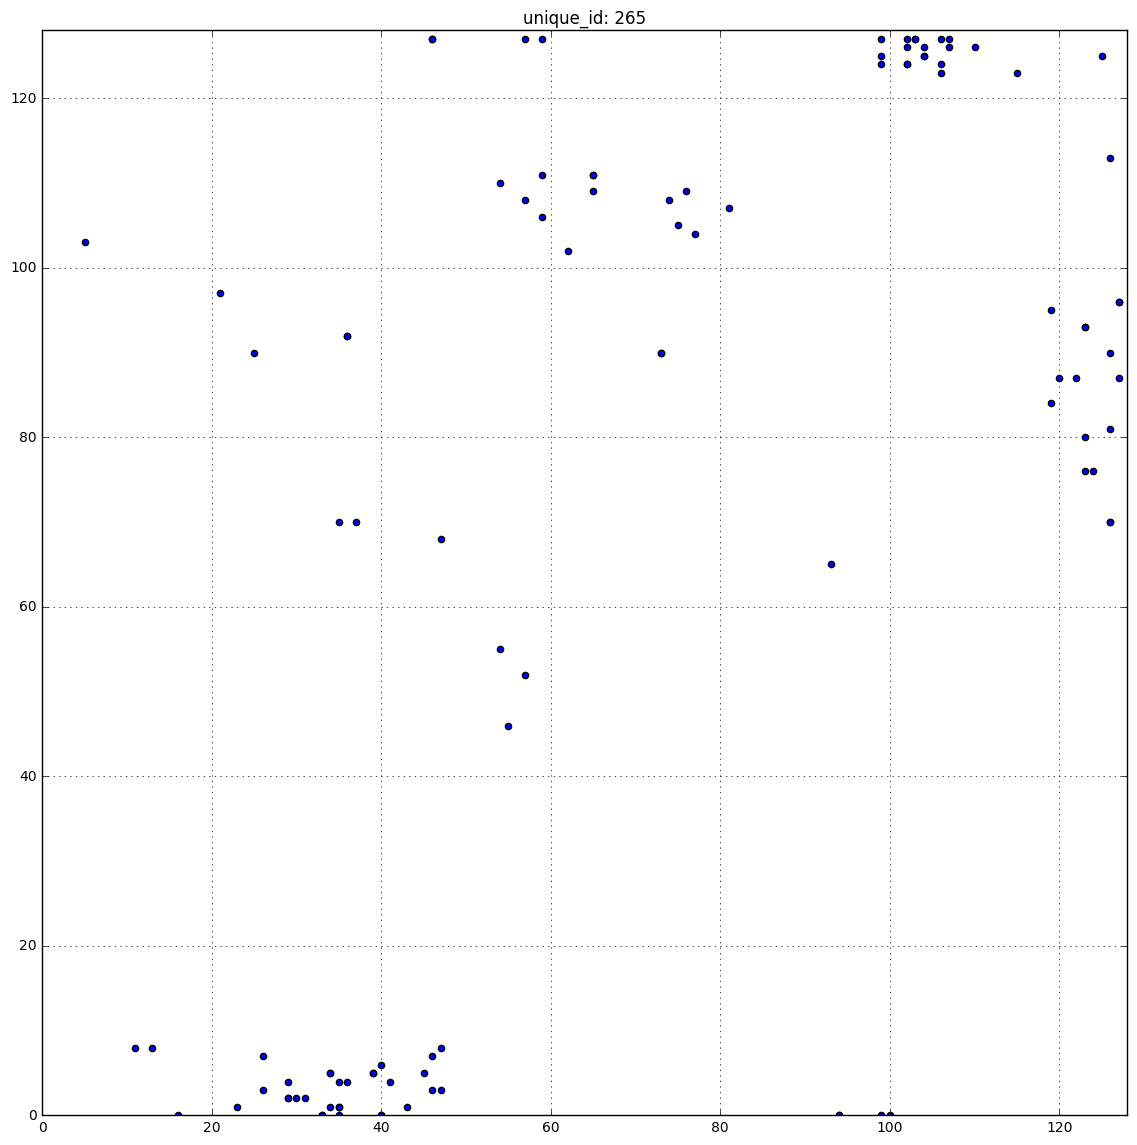

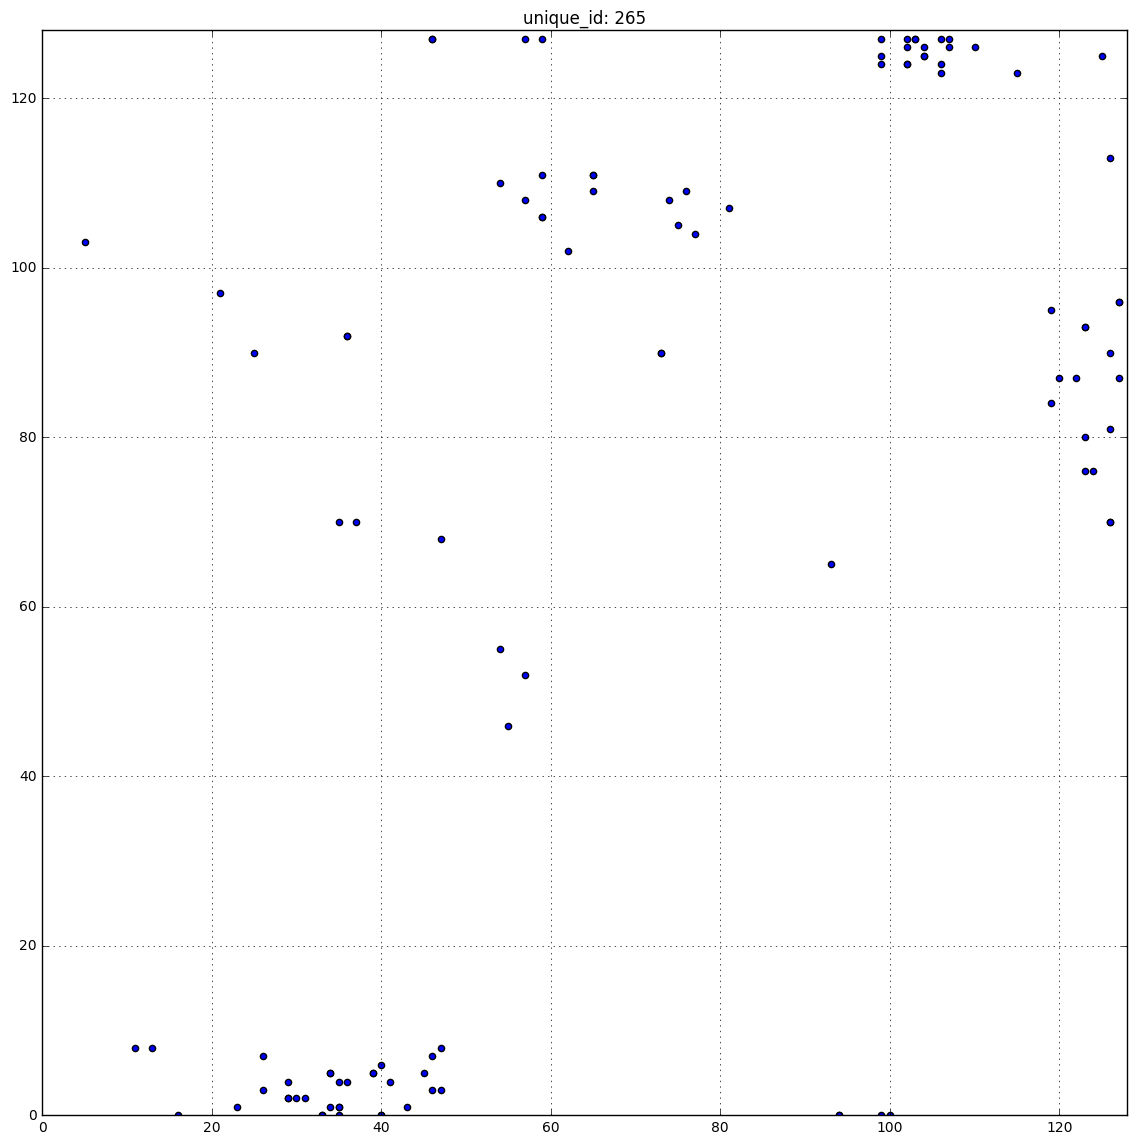

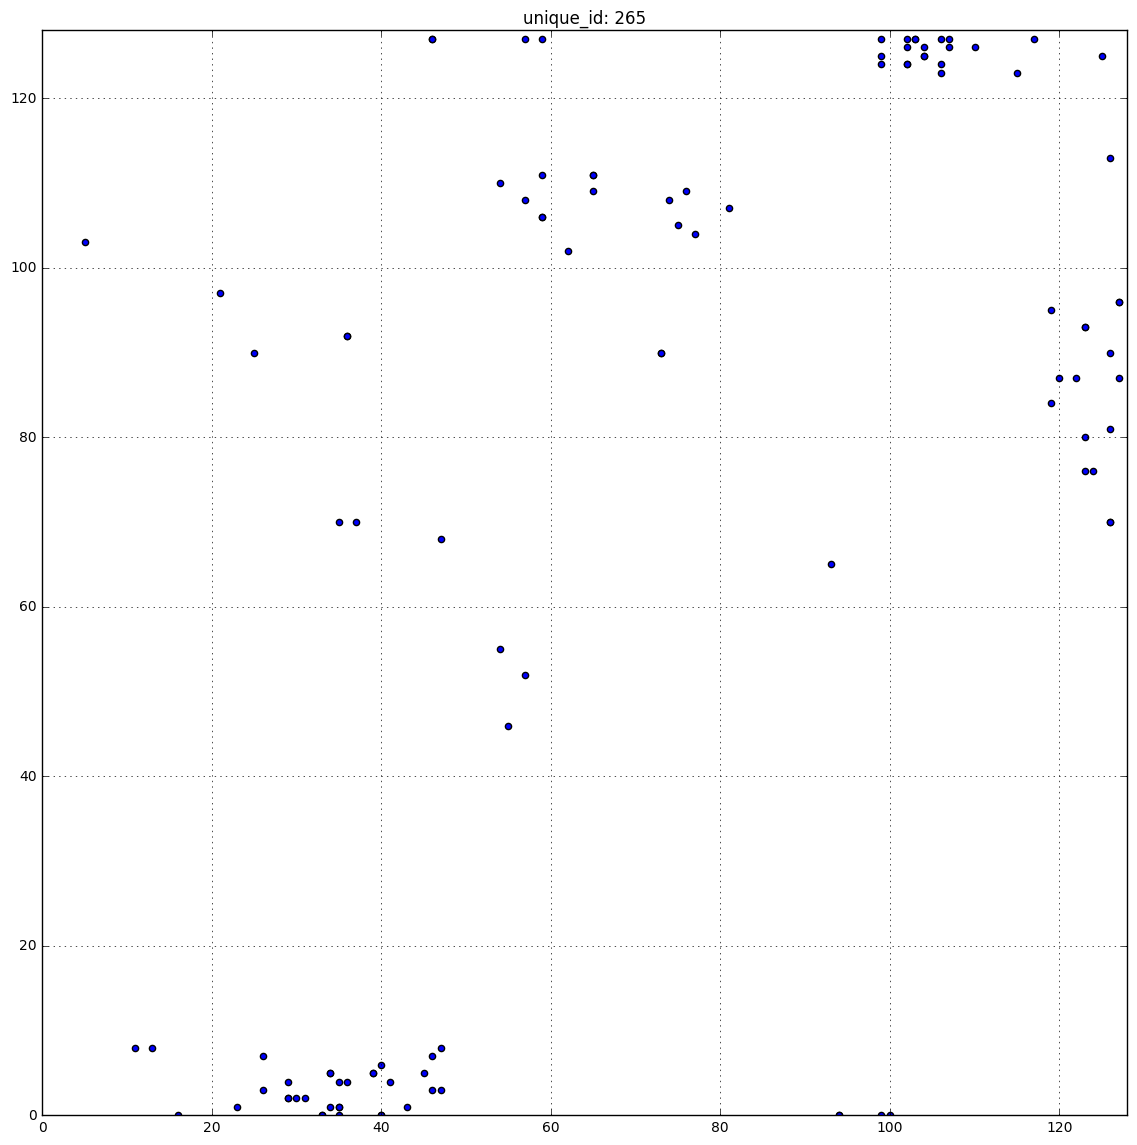

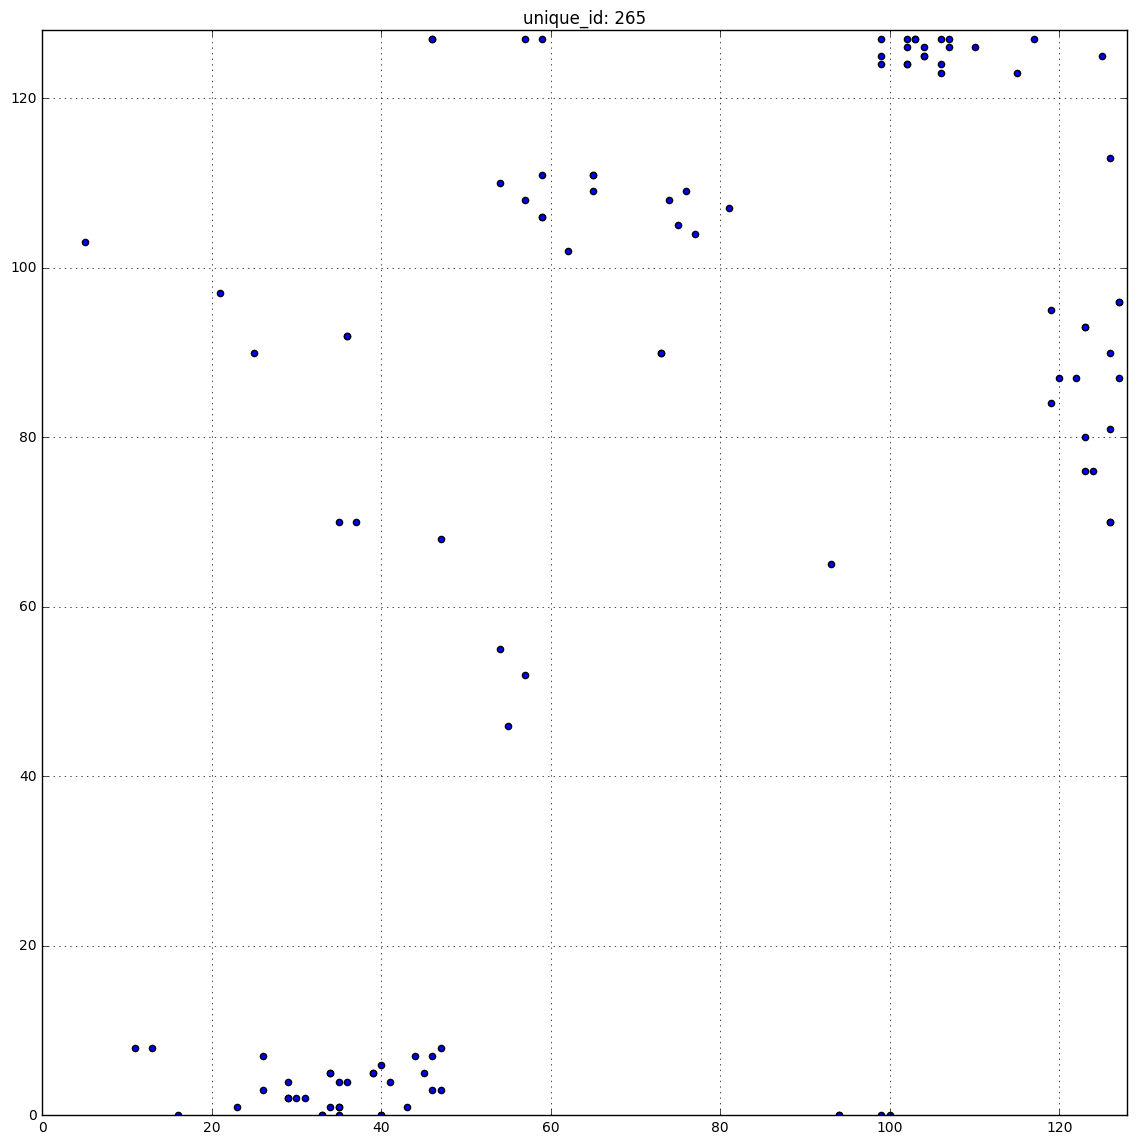

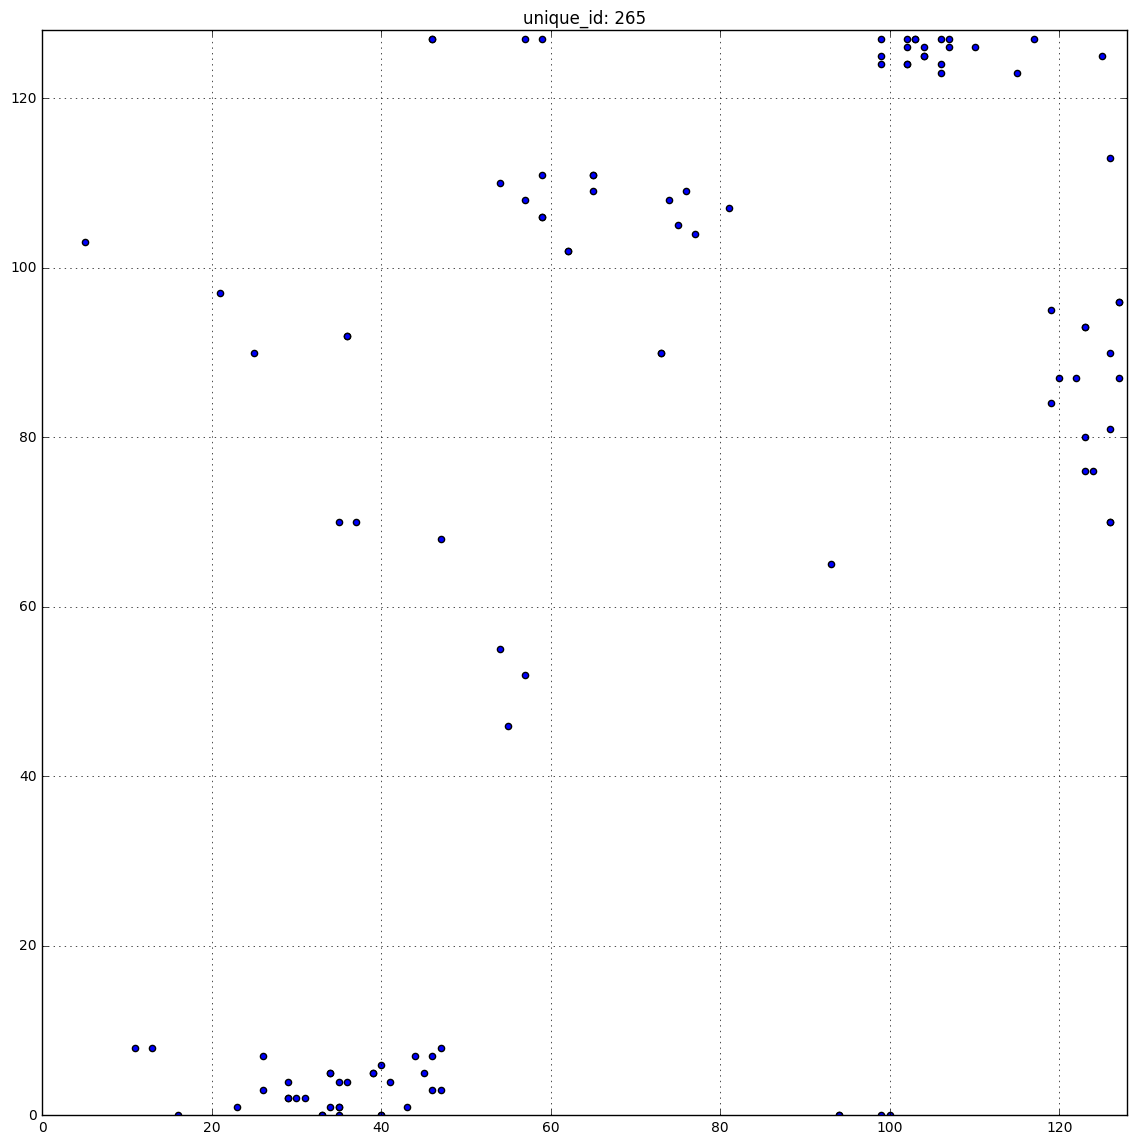

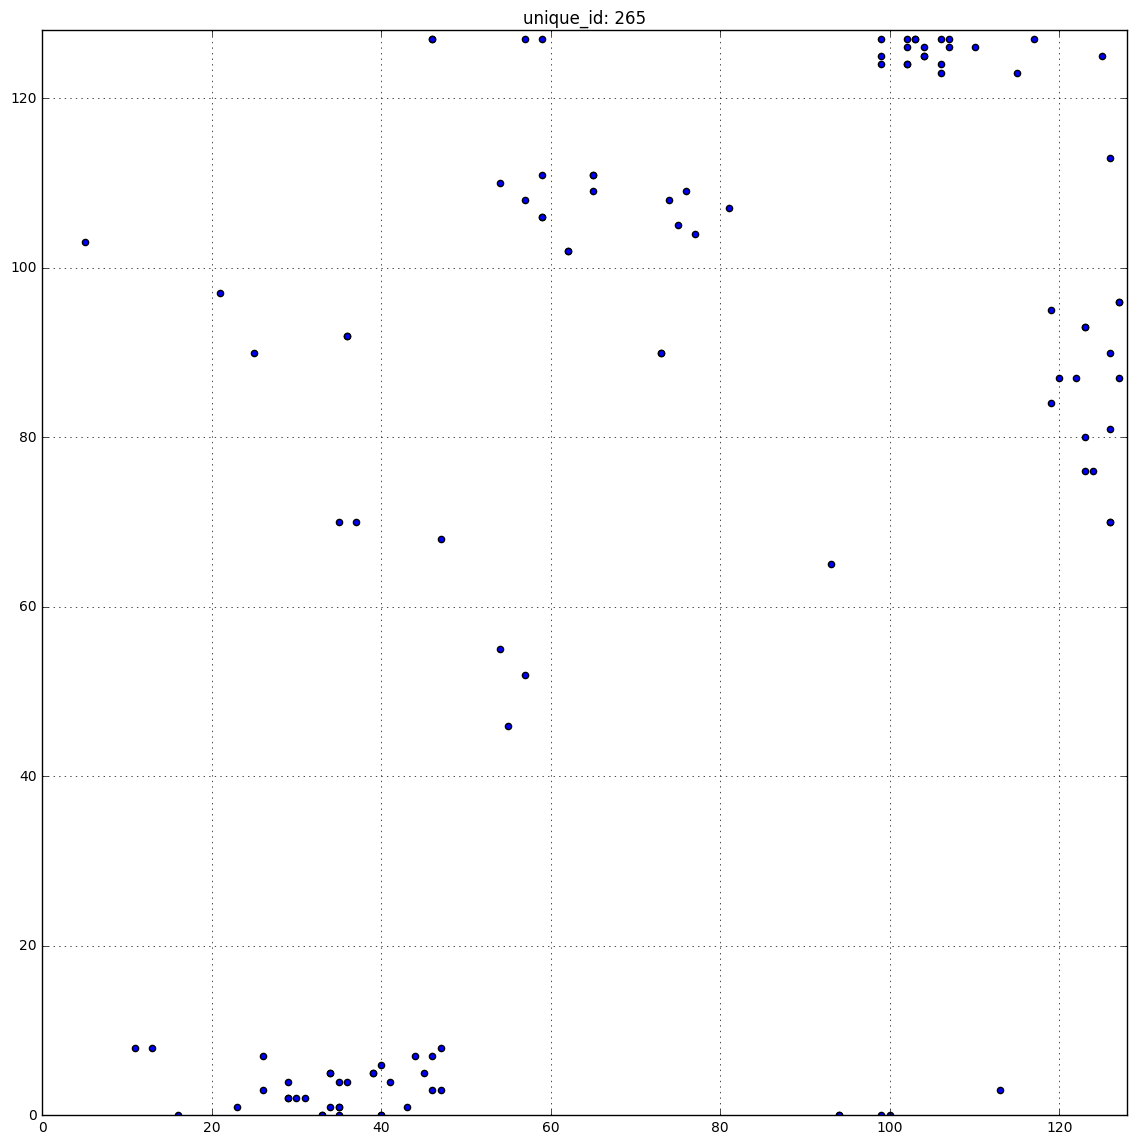

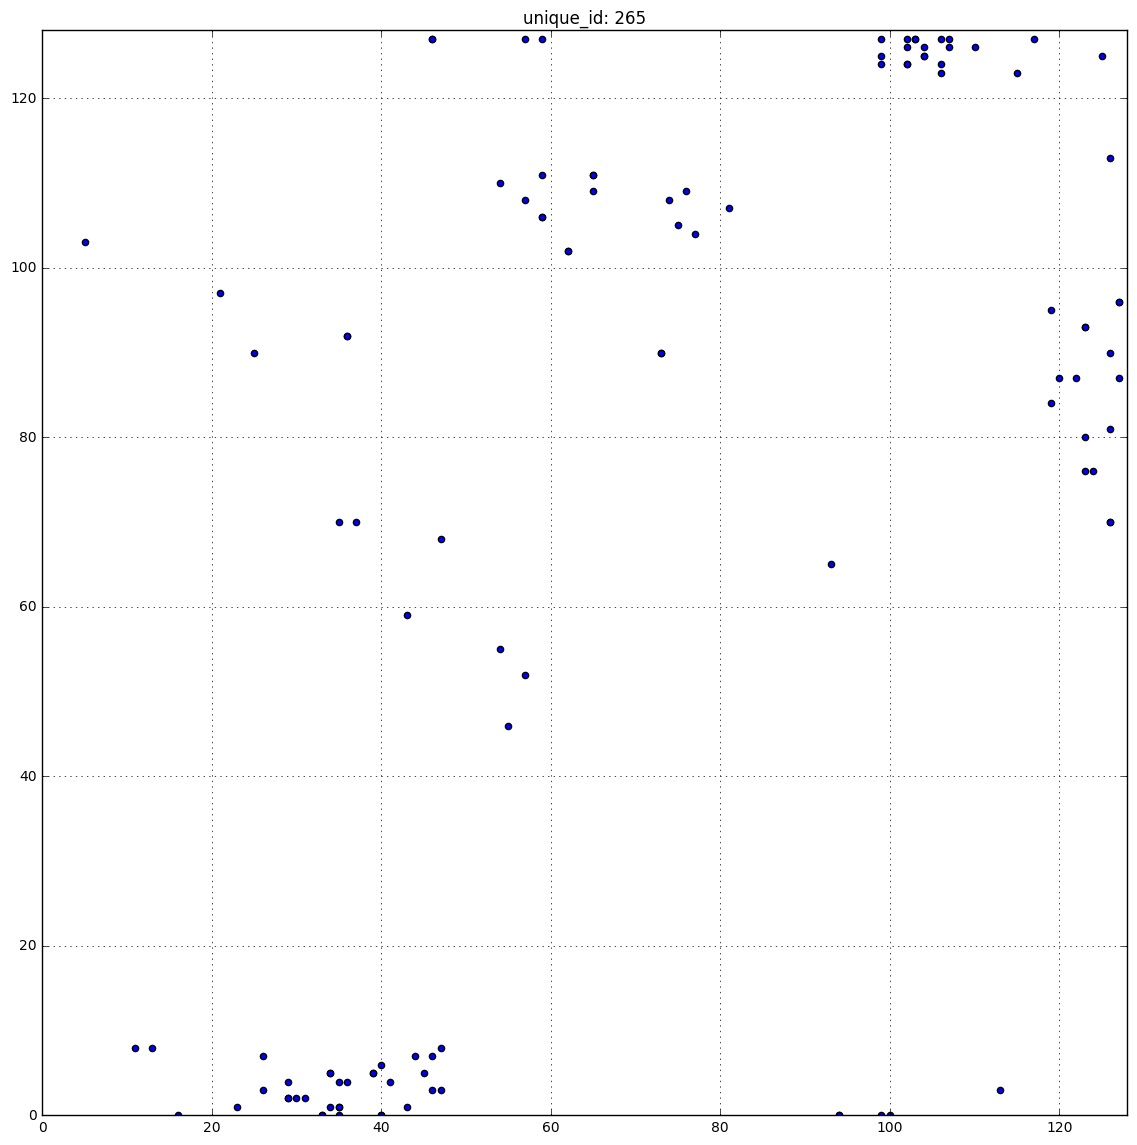

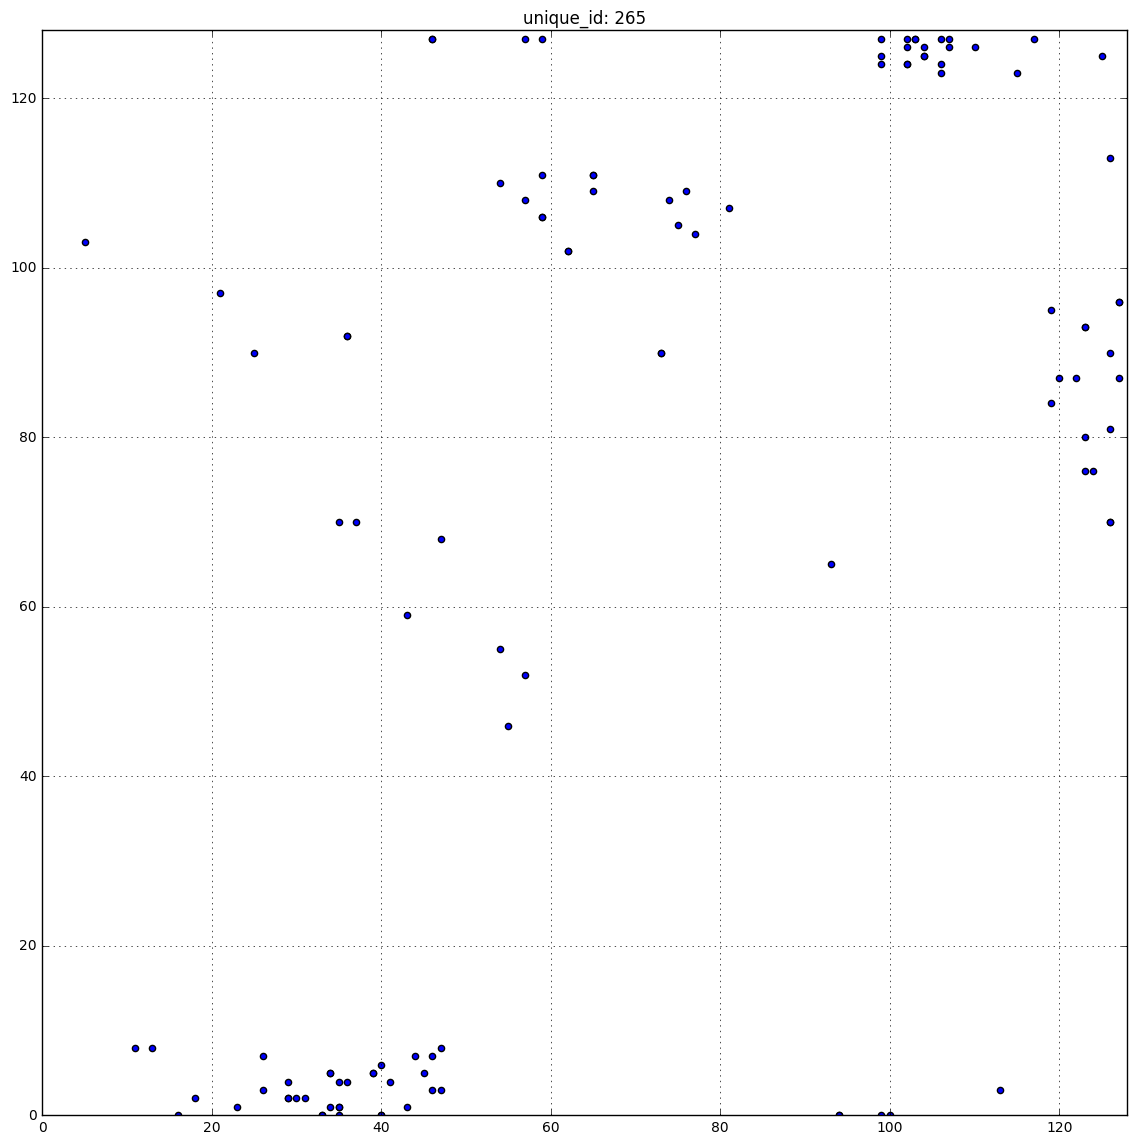

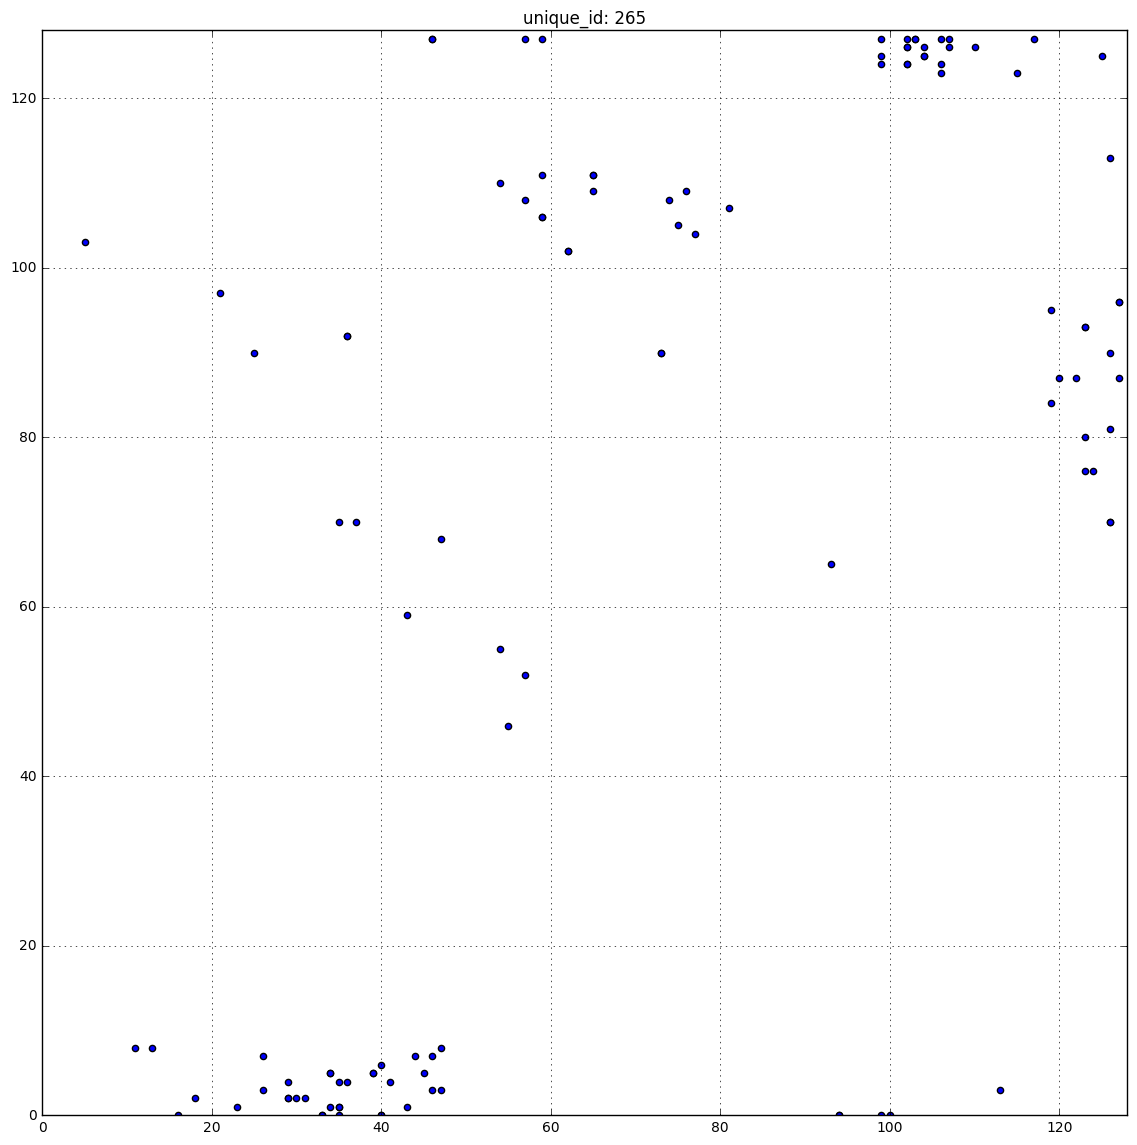

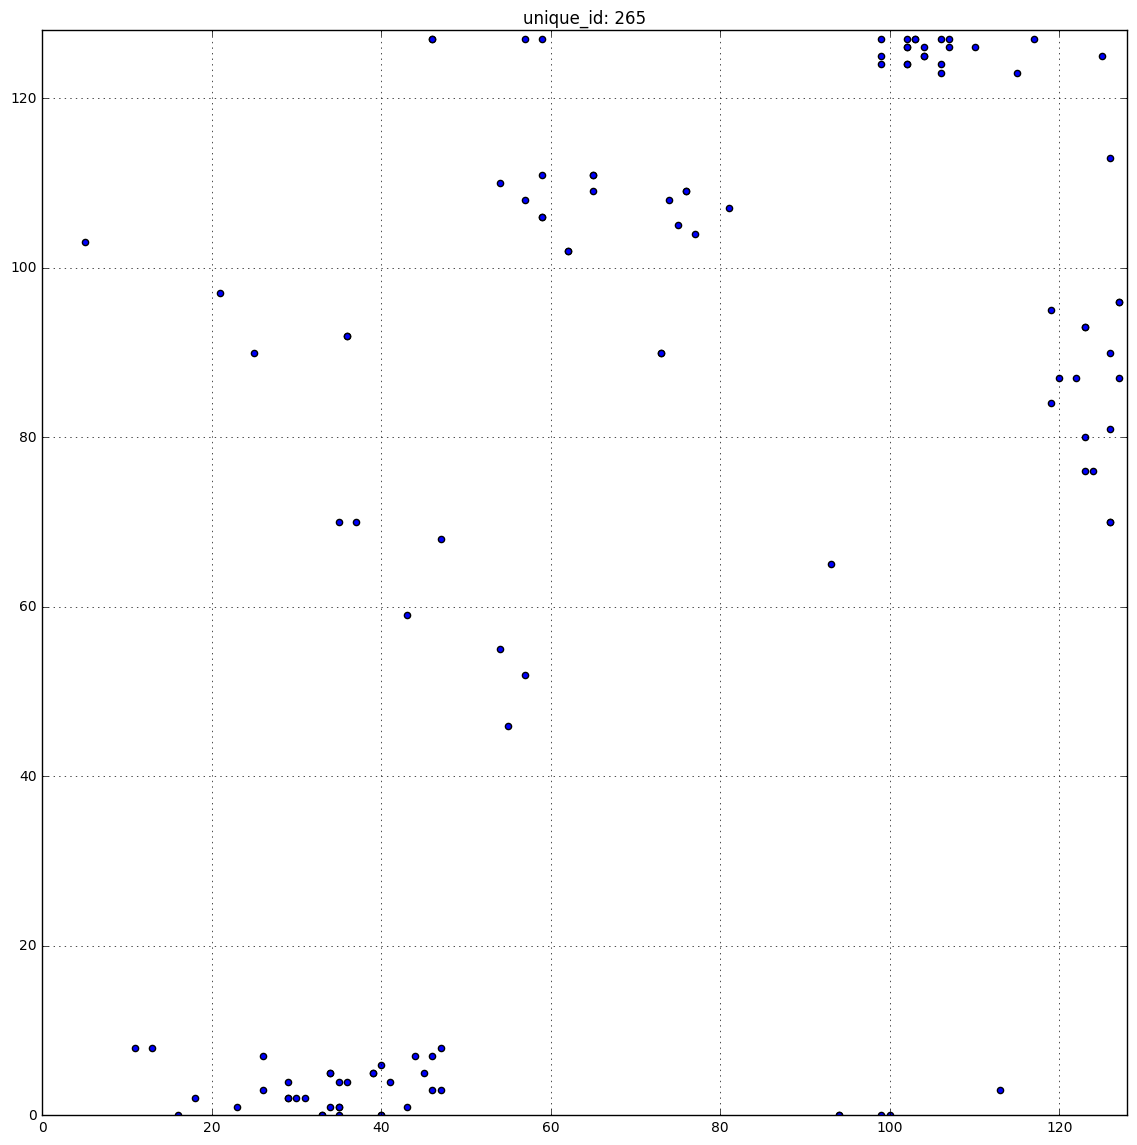

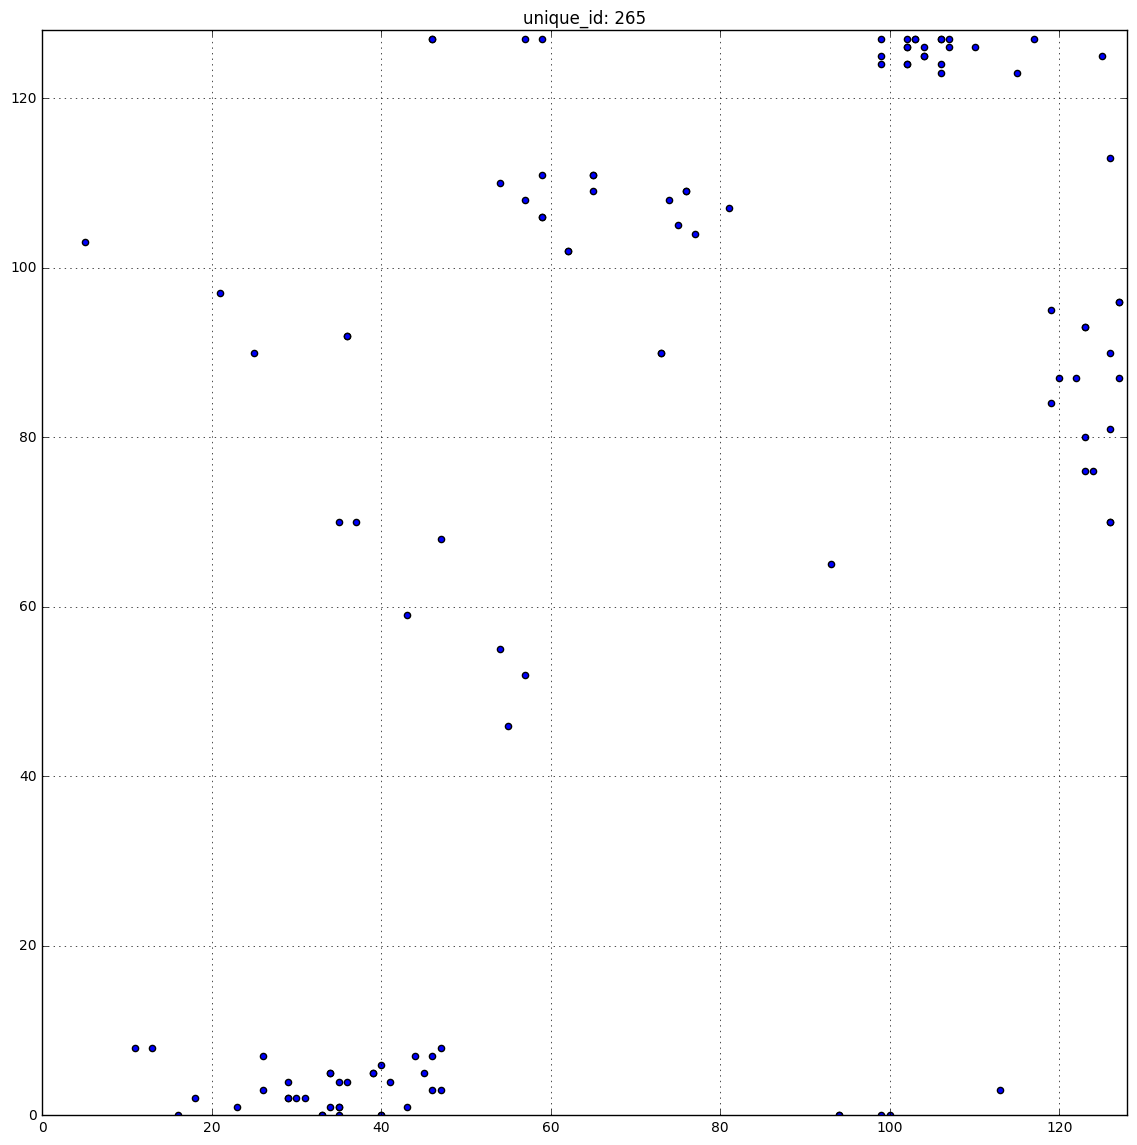

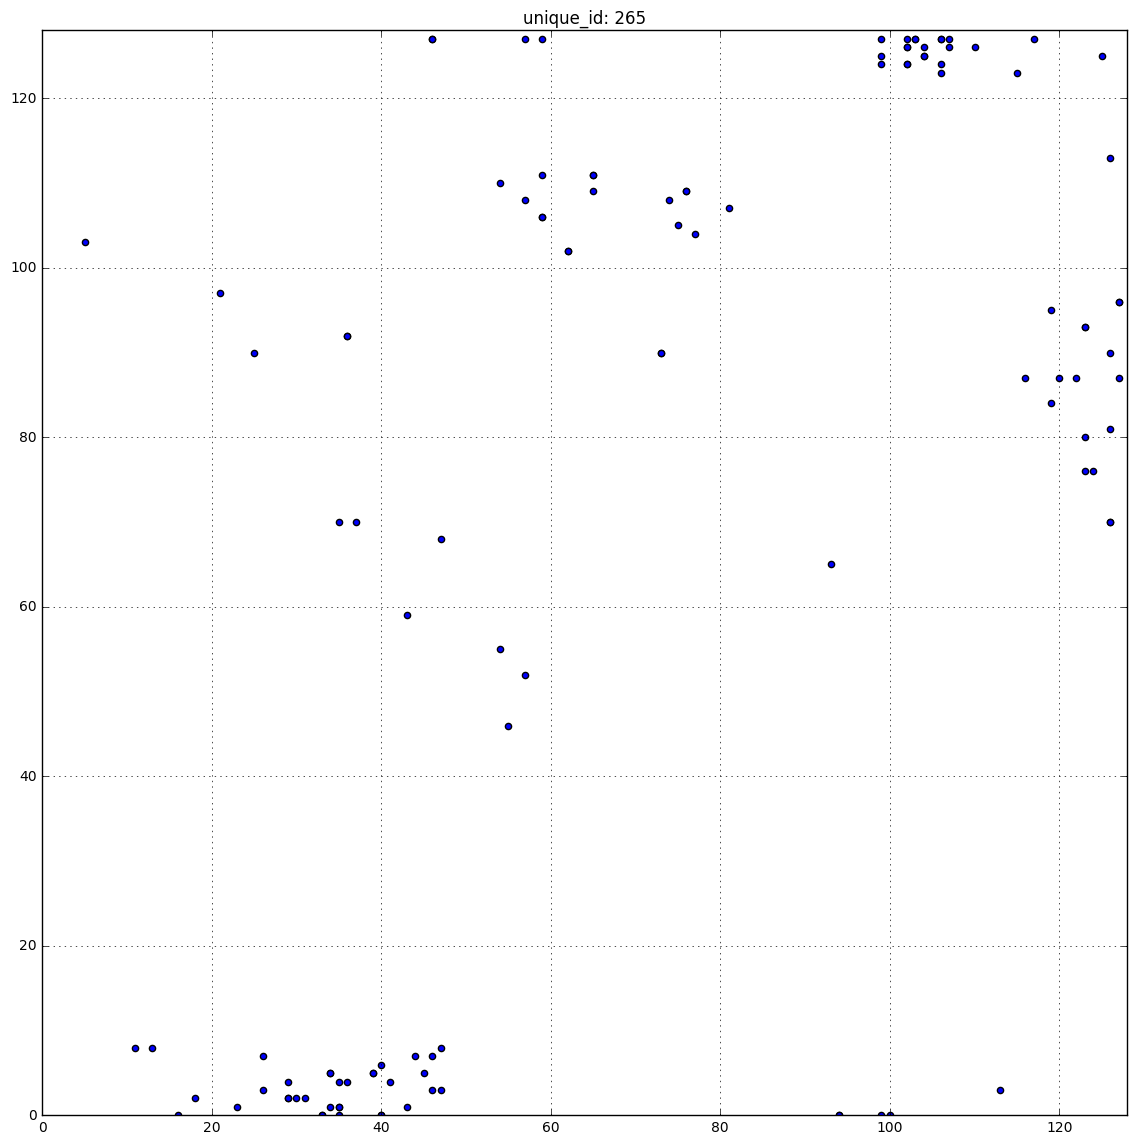

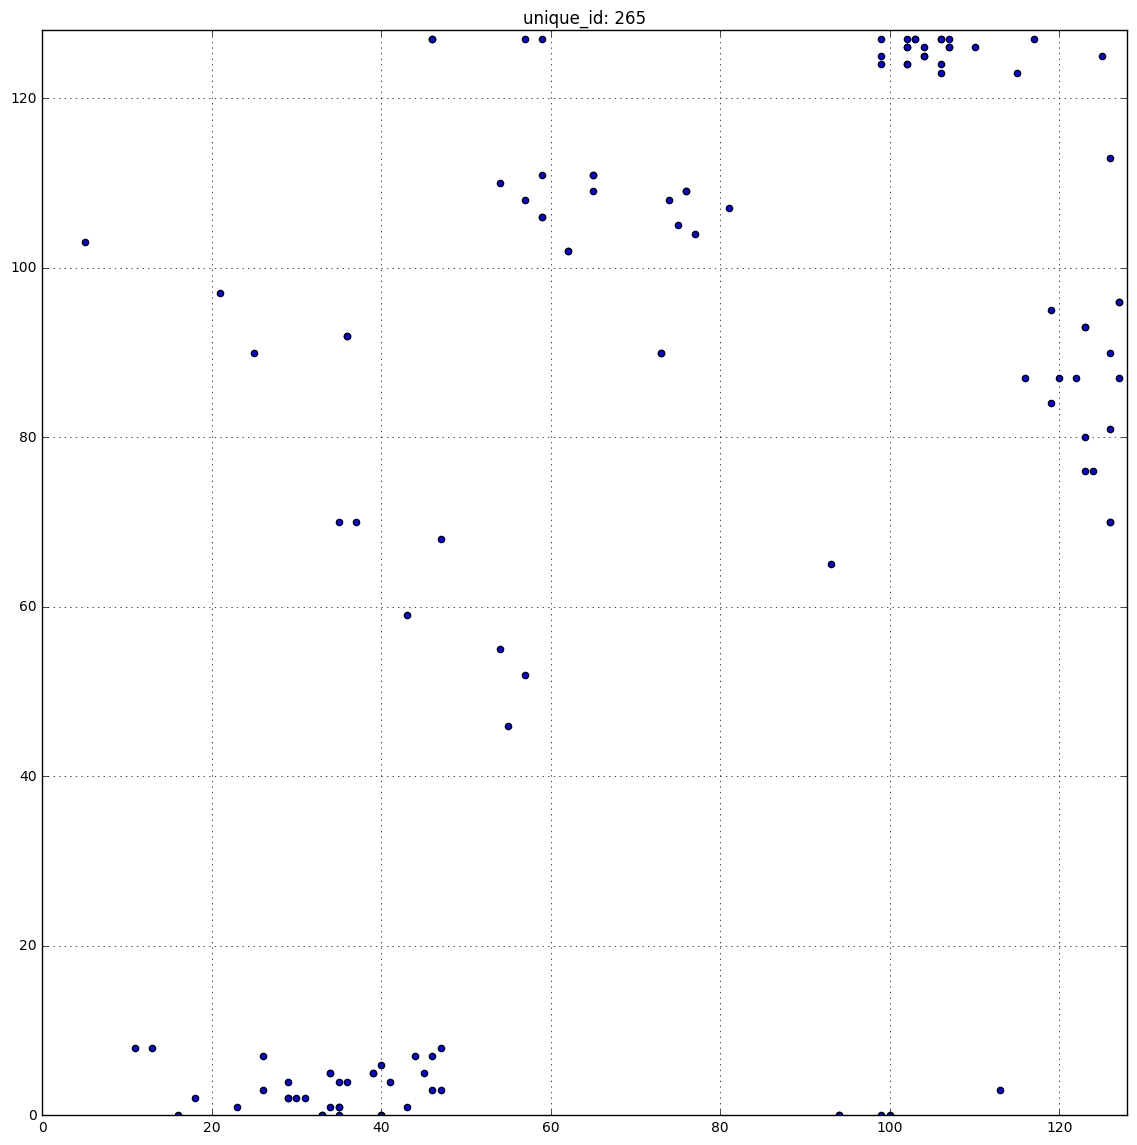

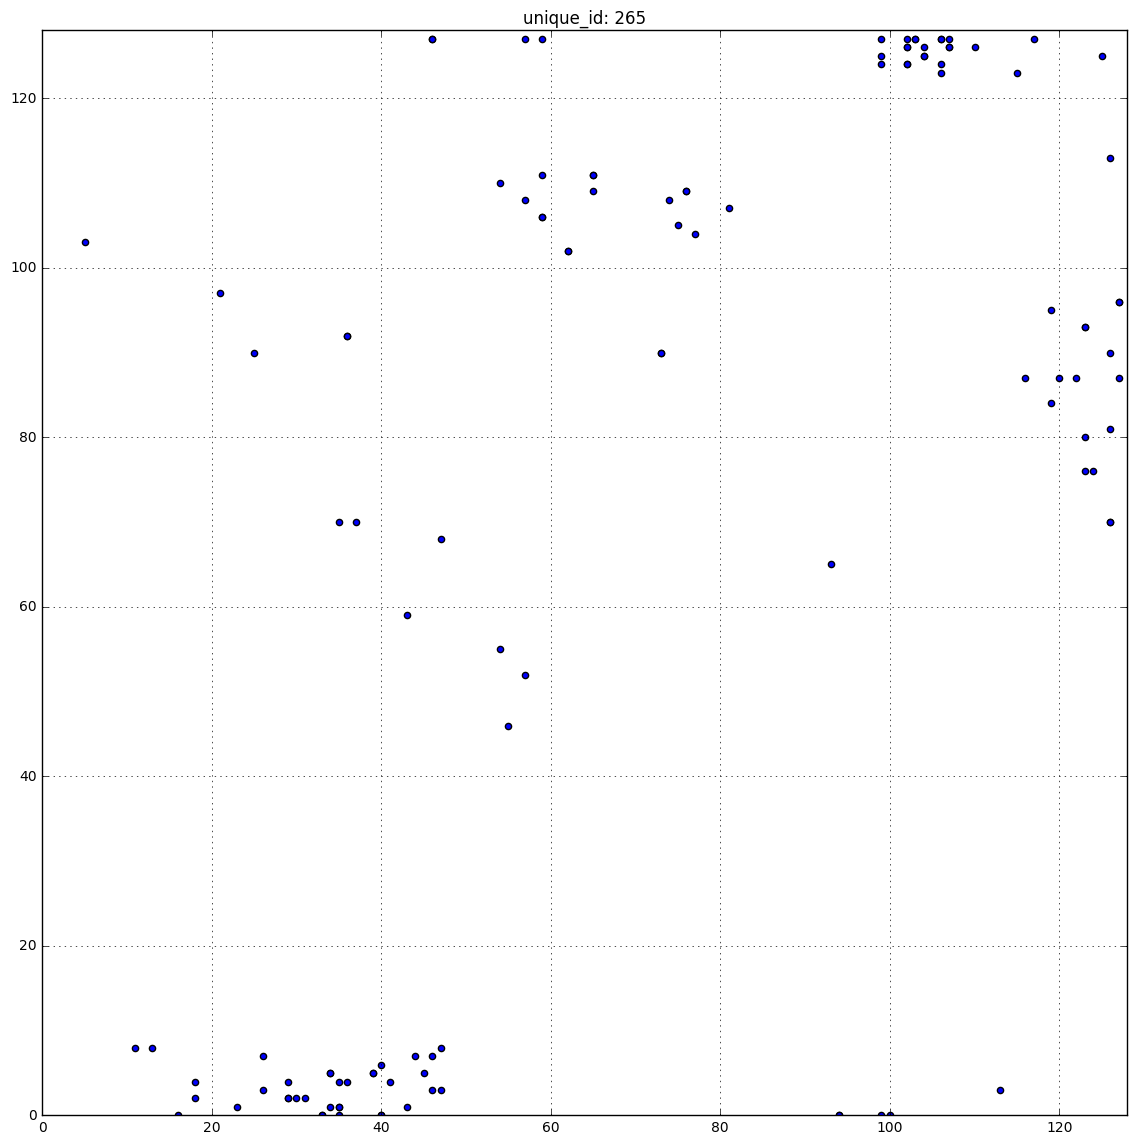

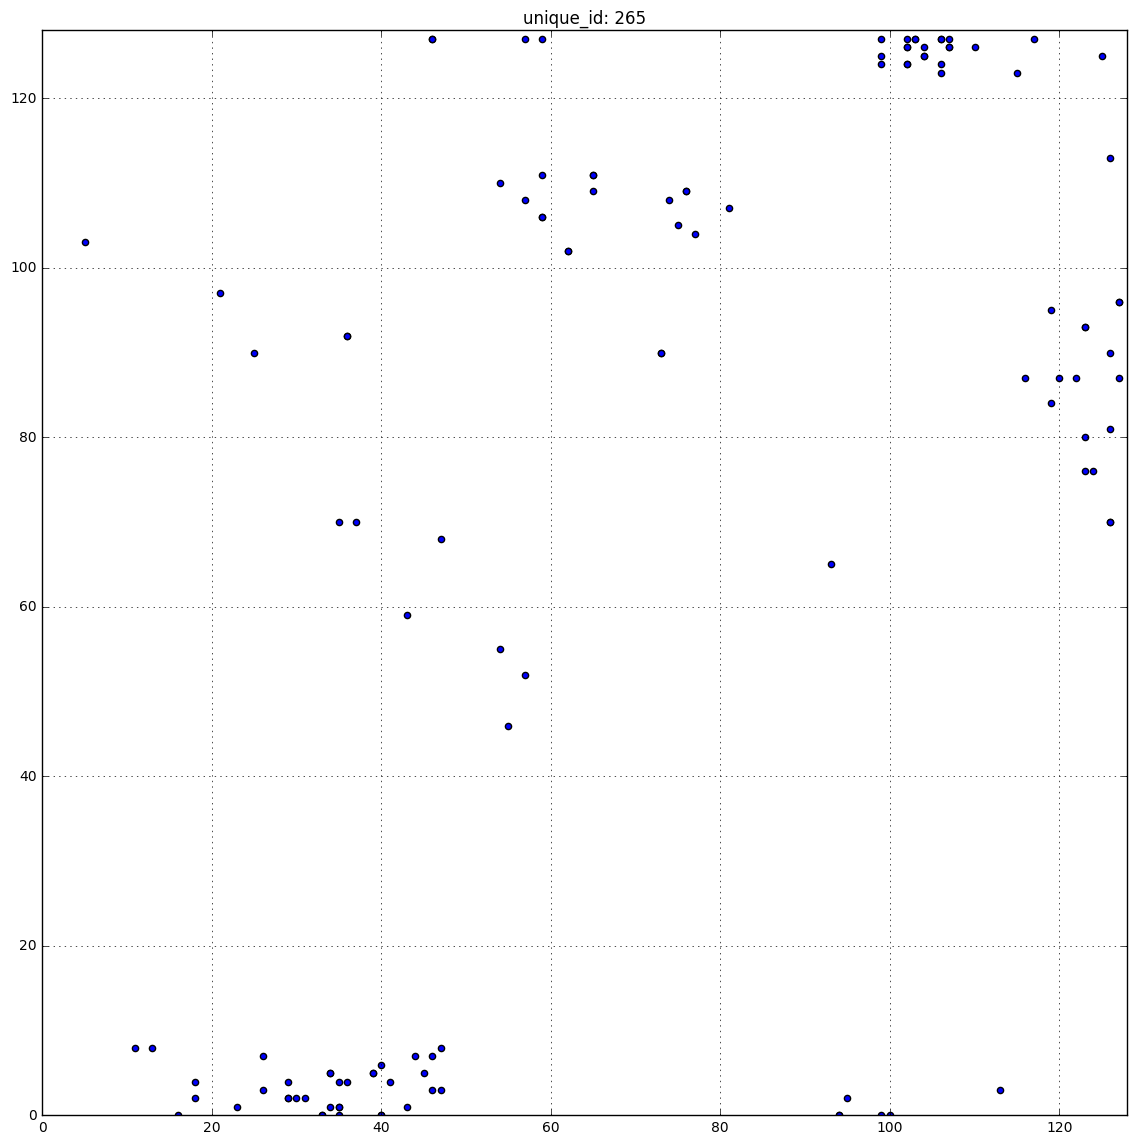

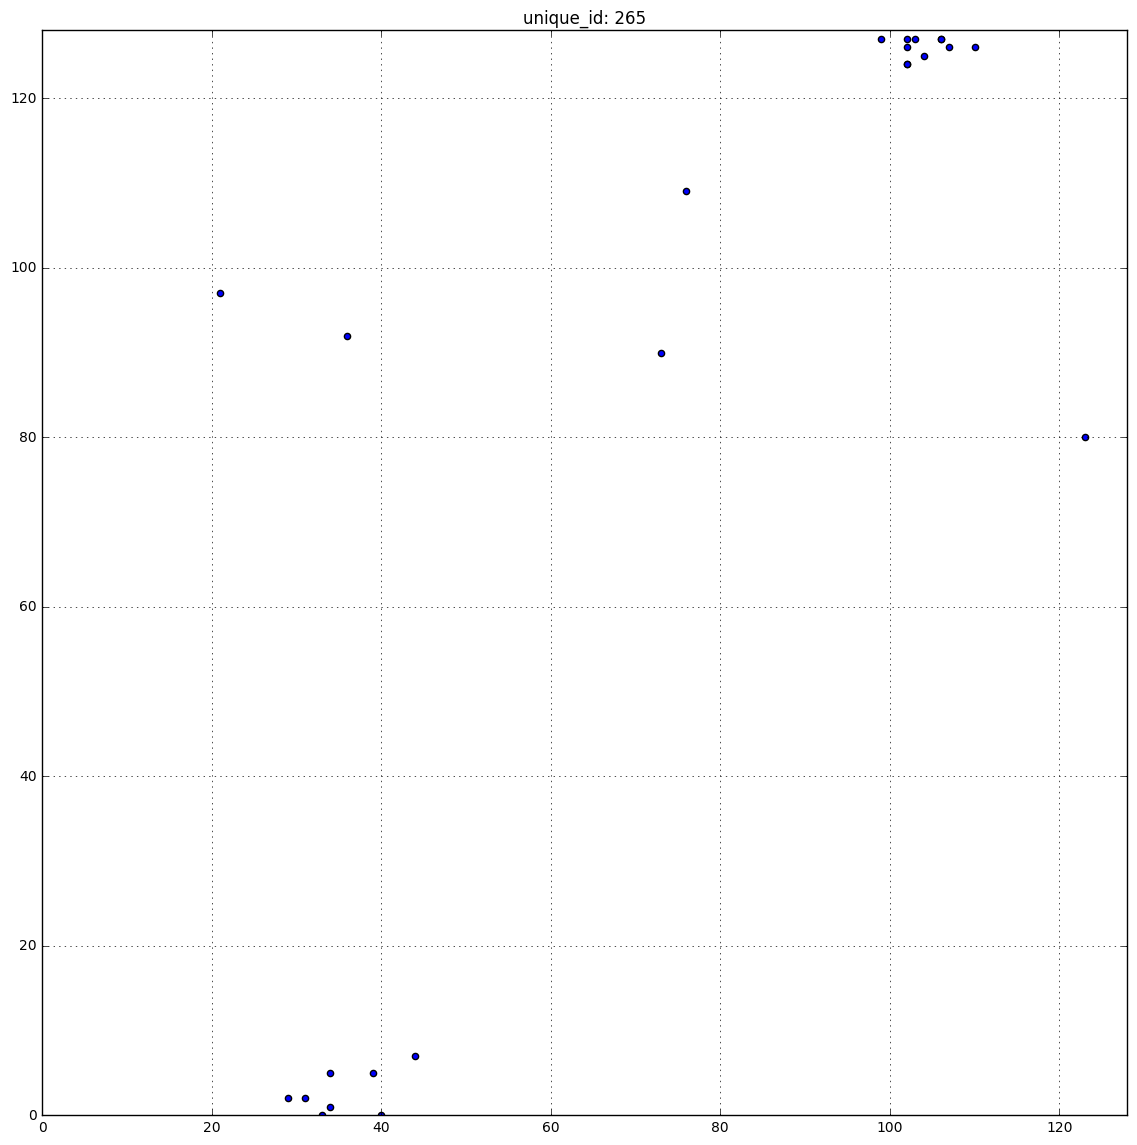

In [74]:
"""
Fingerprint example using doc with unique id 265.
Input: word_retinas.csv file

This cell plot retina for every word in doc with unique id 265 and generate fingerprint for this doc.

The threshold I am using right now is 10, but the results are lighter than I expected, 
or we can use another doc with more words.

This script only applies to generate one fingerprint, it is not iterable enough(this needs to improve latter)

OUTPUT: all the plots of retinas for each word in "data/words"
        and two fingerprints for doc with unique id 265 in "data/docs",
        one is fingerprints without add threshold, another one is fingerprints with threshold

"""

from collections import defaultdict
import matplotlib.pyplot as plt
import csv


def import_from_data_file(unique_id):
    with open(data_source, 'r') as source:
        csvfile = csv.reader(source)
        for line in csvfile:
            binary = line[6]
            if unique_id == line[0].strip():
                row_els = [word.lower().strip() for word in line[8].split(' ')]
                return binary, row_els
            else:
                continue
    print "URL NOT FOUND IN SOURCE FILE"
    return 0, []


def import_words_fingerprints(file):
    wf_dict = {}
    fr = open(file, 'r')
    for line in fr.readlines():
        ls = line.strip().split(',')
        word = ls[0]
        index = ls[1:]
        wf_dict[word] = index
    return wf_dict


data_source = 'data/medical_docs_with_id.csv'
word_fingerprints = 'data/word_fingerprints.csv'
# weights_path = 'models/som_weights_3'

print "plot retinas for every word"


def plot_retinas_for_each_wd():
    for id in range(265, 266):
        idx_stack_count = defaultdict(int)
        unique_id = str(id)
#         print unique_id
        binary, words = import_from_data_file(unique_id)
#         print words
        word_fp = import_words_fingerprints(word_fingerprints)
        for wd in words:
            try:
                arrx = []
                arry = []
                idx = word_fp[wd]
#                 print wd
#                 print idx
                for i in range(0, len(idx), 2):
                    arrx.append(idx[i])
                    arry.append(idx[i + 1])
                    pair = (idx[i], idx[i + 1])
                    idx_stack_count[pair] += 1
                fig = plt.figure(figsize=(14, 14))
                ax = fig.add_subplot(1, 1, 1)
                ax.scatter(arrx, arry)
#                 print arrx
#                 print arry
#                 print '++++'
                plt.axis([0, 128, 0, 128])
                plt.grid()
                plt.title("unique_word: {}".format(wd))
                plt.savefig(
                    "fingerprints/words/{}.png".format(wd))
                # time.sleep(5)
                plt.clf()
            except:
#                 pass
                print wd, 'not in the vocabulary!'
    return unique_id, idx_stack_count


# plot_retinas_for_each_wd()



print 'finger prints without threshold'


def plot_fp(threshold):
    arrx = []
    arry = []
    id, idx_hp = plot_retinas_for_each_wd()
    index = idx_hp.keys()
    for pair in index:
        arrx.append(pair[0])
        arry.append(pair[1])

        fig = plt.figure(figsize=(14, 14))
        ax = fig.add_subplot(1, 1, 1)
        ax.scatter(arrx, arry)
        plt.axis([0, 128, 0, 128])
        plt.grid()
        plt.title("unique_id: {}".format(id))
        plt.savefig(
            "fingerprints/docs/{}_full_fp.png".format(
                id))
        plt.clf()
    x = []
    y = []
    for key in idx_hp.keys():
        if idx_hp[key] > threshold:
            x.append(key[0])
            y.append(key[1])
    fig = plt.figure(figsize=(14, 14))
    ax = fig.add_subplot(1, 1, 1)
    ax.scatter(x, y)
    plt.axis([0, 128, 0, 128])
    plt.grid()
    plt.title("unique_id: {}".format(id))
    plt.savefig(
        "fingerprints/docs/{}_fp.png".format(id))


#
plot_fp(10)




print "DONE"